# DATA606 Week 8 & 9 - Modeling
Team 2 UMBC Spring 2024

In [3]:
from google.colab import drive
#drive.mount('/content/drive')

### imports

In [4]:
pip install shap==0.44

In [5]:
!pip install torcheval
!pip install torchmetrics

In [6]:
import shap

In [7]:
print(shap.__version__)

0.44.0


In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn import set_config

#visuals
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams


#model selection tools
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import KFold


#models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge


import warnings
warnings.filterwarnings(action='ignore')

In [9]:
from tqdm.autonotebook import tqdm
#import tqdm
import copy
import torch
import torch

from torch.utils.data import *

import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
#from torch.utils.data import DataLoader, TensorDataset

import time

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score

## Data Transformation

### Senator Approval Ratings and Demographic Data

In [10]:
url = 'https://raw.githubusercontent.com/Ecross7/approvalRatings/sai7792-patch-1/merged.csv'
df = pd.read_csv(url,parse_dates=['birthday','start_date','end_date'])

In [11]:
df = df.rename(columns={'Emotion (Majority)': 'emotion_majority', 'Race (Majority)': 'race_majority', 'Valence (Mean)': 'valence_mean'})

In [12]:
df.dtypes

full_name                   object
pct                        float64
birthday            datetime64[ns]
gender                      object
party                       object
senate_class               float64
stage                       object
cycle                        int64
start_date          datetime64[ns]
end_date            datetime64[ns]
age                          int64
emotion_majority            object
race_majority               object
valence_mean               float64
dtype: object

In [13]:
df

,full_name,pct,birthday,gender,party,senate_class,stage,cycle,start_date,end_date,age,emotion_majority,race_majority,valence_mean
0,amy klobuchar,54.0,1960-05-25,F,Democrat,1.0,general,2018,2018-10-15,2018-10-30,64,happy,white,26.80534
1,amy klobuchar,55.0,1960-05-25,F,Democrat,1.0,general,2018,2018-11-02,2018-11-04,64,happy,white,26.80534
2,amy klobuchar,53.0,1960-05-25,F,Democrat,1.0,general,2018,2018-11-01,2018-11-03,64,happy,white,26.80534
3,amy klobuchar,57.0,1960-05-25,F,Democrat,1.0,general,2018,2018-10-29,2018-10-31,64,happy,white,26.80534
4,amy klobuchar,56.0,1960-05-25,F,Democrat,1.0,general,2018,2018-10-15,2018-10-17,64,happy,white,26.80534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3030,tommy tuberville,50.0,1954-09-18,M,Republican,2.0,general,2020,2020-06-29,2020-07-02,70,neutral,white,-49.08704
3031,tommy tuberville,47.0,1954-09-18,M,Republican,2.0,general,2020,2020-06-18,2020-06-22,70,neutral,white,-49.08704
3032,tommy tuberville,49.7,1954-09-18,M,Republican,2.0,general,2020,2020-06-13,2020-06-16,70,neutral,white,-49.08704
3033,tommy tuberville,55.0,1954-09-18,M,Republican,2.0,general,2020,2020-10-11,2020-10-14,70,neutral,white,-49.08704


In [14]:
df.describe()

,pct,birthday,senate_class,cycle,start_date,end_date,age,valence_mean
count,3035.00000,3035,3035.000000,3035.000000,3035,3035,3035.000000,3035.000000
mean,45.92370,1961-04-18 04:20:00.395387136,2.020099,2019.887974,2020-06-13 09:53:33.311367168,2020-06-18 01:47:42.207578368,63.229325,26.044160
min,6.20000,1933-06-22 00:00:00,1.000000,2018.000000,2016-11-16 00:00:00,2016-11-17 00:00:00,37.000000,-73.293255
25%,43.50000,1952-12-01 00:00:00,1.000000,2018.000000,2018-10-17 00:00:00,2018-10-21 12:00:00,55.000000,5.415104
50%,47.00000,1960-08-09 00:00:00,2.000000,2020.000000,2020-08-30 00:00:00,2020-09-05 00:00:00,64.000000,27.554999
75%,50.00000,1969-07-23 00:00:00,3.000000,2022.000000,2021-03-07 00:00:00,2021-03-09 00:00:00,72.000000,56.318169
max,75.00000,1987-02-16 00:00:00,3.000000,2024.000000,2024-03-13 00:00:00,2024-03-13 00:00:00,91.000000,99.428934
std,7.53723,NaN,0.858816,1.707897,NaN,NaN,10.562811,38.443499


In [15]:
df.shape

(3035, 14)

In [16]:
# Could we use Initial term age instead?
def calculate_servingAge(dtob,startdate):
  # Calculate the age by subtracting the birth year from the current year
  # Adjust the age if the birth month and day are after today's month and day
  return startdate.year - dtob.year - ((startdate.month, startdate.day) < (dtob.month, dtob.day))


In [17]:
# create serving_age column from birthday to start of cycle
df['serving_age'] = df.apply(lambda row : (calculate_servingAge(row.birthday, row.start_date)), axis=1 )

In [18]:
df.head()

,full_name,pct,birthday,gender,party,senate_class,stage,cycle,start_date,end_date,age,emotion_majority,race_majority,valence_mean,serving_age
0,amy klobuchar,54.0,1960-05-25,F,Democrat,1.0,general,2018,2018-10-15,2018-10-30,64,happy,white,26.80534,58
1,amy klobuchar,55.0,1960-05-25,F,Democrat,1.0,general,2018,2018-11-02,2018-11-04,64,happy,white,26.80534,58
2,amy klobuchar,53.0,1960-05-25,F,Democrat,1.0,general,2018,2018-11-01,2018-11-03,64,happy,white,26.80534,58
3,amy klobuchar,57.0,1960-05-25,F,Democrat,1.0,general,2018,2018-10-29,2018-10-31,64,happy,white,26.80534,58
4,amy klobuchar,56.0,1960-05-25,F,Democrat,1.0,general,2018,2018-10-15,2018-10-17,64,happy,white,26.80534,58


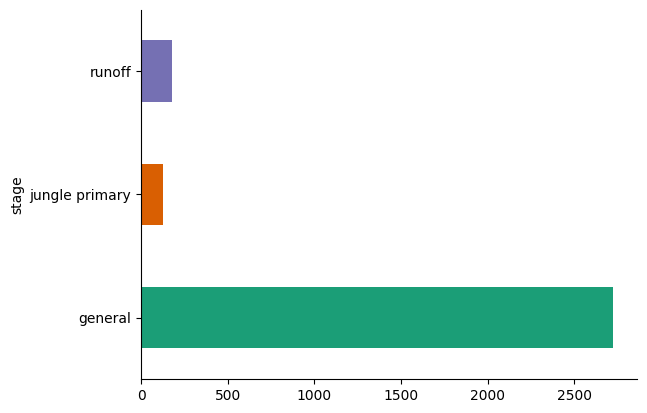

In [19]:
# @title stage

df.groupby('stage').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

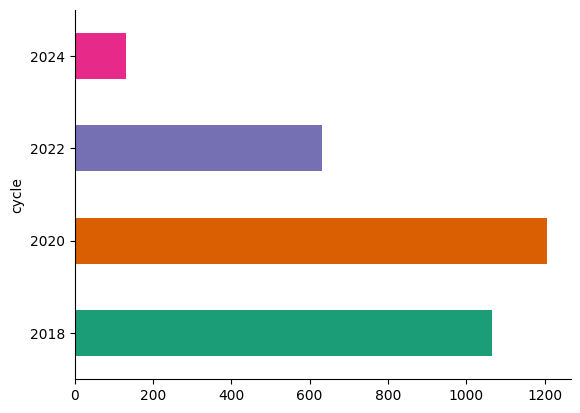

In [20]:
# @title cycle

df.groupby('cycle').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

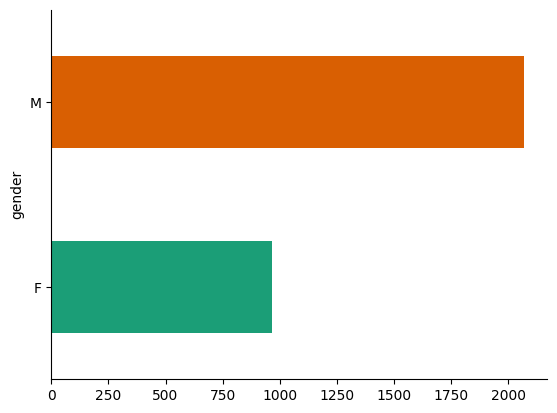

In [21]:
# @title gender

df.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

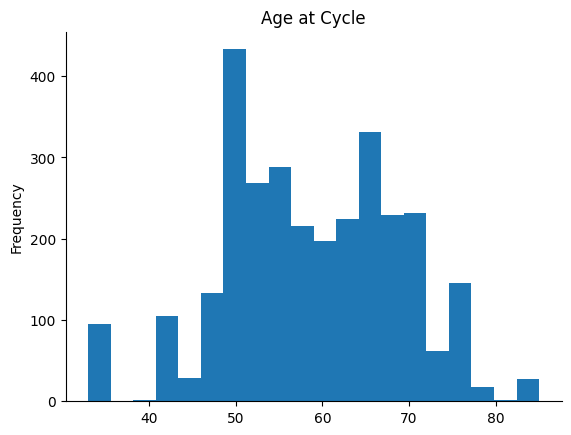

In [22]:
df['serving_age'].plot(kind='hist', bins=20, title='Age at Cycle')
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: >

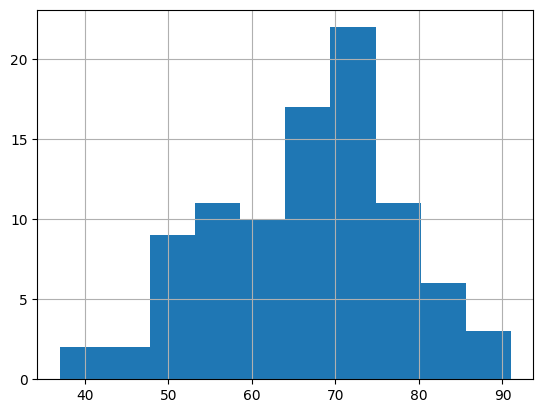

In [23]:
df.groupby('full_name')['age'].max().hist()

### TODO:
1) add the age at the time of serving -- done ✅

2) grab more features

<Axes: >

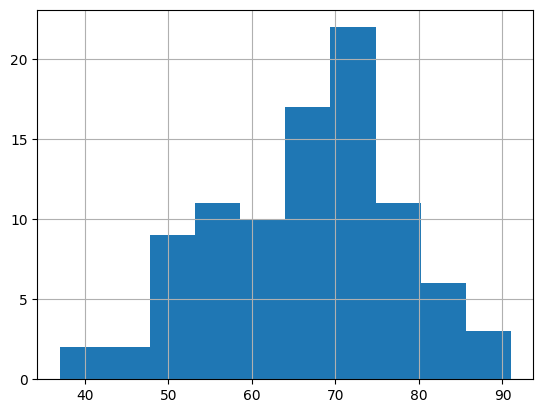

In [24]:
df.groupby('full_name')['age'].max().hist()

In [25]:
# todo: start_date & end_date -> How do we want to handle?

In [26]:
# create heatmap to view correlations
#sns.set(font_scale = 1)
#plt.figure(figsize = (10,10))
#sns.heatmap(df.corr(), annot=True)

### TODO: Senator Photo Enrichment
3 - 20 Photos of senators at various events and points in time

In [27]:
# TODO: Analysis on number and types of images available

### TODO: Emotion Detection
Classification and Valence scores

In [28]:
# todo: update with real inferences

In [29]:
# generating random valence values as a placeholder
#emotions = ['engagement','happiness','anticipation','excitement','confidence','pleasure','peace','disconnection','affection','esteem','sympathy']
#df['top_emotion'] = np.random.choice(emotions, size=len(df))

#df['valence'] = np.random.randint(0,10, size=len(df))

In [30]:
df['valence_mean'].describe()

count    3035.000000
mean       26.044160
std        38.443499
min       -73.293255
25%         5.415104
50%        27.554999
75%        56.318169
max        99.428934
Name: valence_mean, dtype: float64

In [31]:
df['race_majority'].value_counts()

race_majority
white              2695
black               218
latino hispanic     111
asian                11
Name: count, dtype: int64

In [32]:
df['emotion_majority'].value_counts()

emotion_majority
happy       2117
neutral      329
sad          329
angry        159
fear          90
surprise      11
Name: count, dtype: int64

In [33]:
# TODO: General EDA on the distribution of emotion inferences like frequency of emotion class and averge valence

### Train/Test Split

# Preprocessing

### Final Feature Selection

In [34]:
target = ['pct'] # could we do binary classification with positive or negative score?
date_features = ['start_date','end_date','birthday'] # is cycle really "date" or categorical?
categorical_features = ['emotion_majority','race_majority','gender','party','senate_class','stage','cycle']
numerical_features = ['serving_age','valence_mean'] # omitting serving_age due to correlation with age

In [35]:
df.head()

,full_name,pct,birthday,gender,party,senate_class,stage,cycle,start_date,end_date,age,emotion_majority,race_majority,valence_mean,serving_age
0,amy klobuchar,54.0,1960-05-25,F,Democrat,1.0,general,2018,2018-10-15,2018-10-30,64,happy,white,26.80534,58
1,amy klobuchar,55.0,1960-05-25,F,Democrat,1.0,general,2018,2018-11-02,2018-11-04,64,happy,white,26.80534,58
2,amy klobuchar,53.0,1960-05-25,F,Democrat,1.0,general,2018,2018-11-01,2018-11-03,64,happy,white,26.80534,58
3,amy klobuchar,57.0,1960-05-25,F,Democrat,1.0,general,2018,2018-10-29,2018-10-31,64,happy,white,26.80534,58
4,amy klobuchar,56.0,1960-05-25,F,Democrat,1.0,general,2018,2018-10-15,2018-10-17,64,happy,white,26.80534,58


In [36]:
df.isnull().sum()

full_name           0
pct                 0
birthday            0
gender              0
party               0
senate_class        0
stage               0
cycle               0
start_date          0
end_date            0
age                 0
emotion_majority    0
race_majority       0
valence_mean        0
serving_age         0
dtype: int64

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3035 entries, 0 to 3034
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   full_name         3035 non-null   object        
 1   pct               3035 non-null   float64       
 2   birthday          3035 non-null   datetime64[ns]
 3   gender            3035 non-null   object        
 4   party             3035 non-null   object        
 5   senate_class      3035 non-null   float64       
 6   stage             3035 non-null   object        
 7   cycle             3035 non-null   int64         
 8   start_date        3035 non-null   datetime64[ns]
 9   end_date          3035 non-null   datetime64[ns]
 10  age               3035 non-null   int64         
 11  emotion_majority  3035 non-null   object        
 12  race_majority     3035 non-null   object        
 13  valence_mean      3035 non-null   float64       
 14  serving_age       3035 n

In [38]:
df[categorical_features] = df[categorical_features].astype(str)

In [39]:
df

,full_name,pct,birthday,gender,party,senate_class,stage,cycle,start_date,end_date,age,emotion_majority,race_majority,valence_mean,serving_age
0,amy klobuchar,54.0,1960-05-25,F,Democrat,1.0,general,2018,2018-10-15,2018-10-30,64,happy,white,26.80534,58
1,amy klobuchar,55.0,1960-05-25,F,Democrat,1.0,general,2018,2018-11-02,2018-11-04,64,happy,white,26.80534,58
2,amy klobuchar,53.0,1960-05-25,F,Democrat,1.0,general,2018,2018-11-01,2018-11-03,64,happy,white,26.80534,58
3,amy klobuchar,57.0,1960-05-25,F,Democrat,1.0,general,2018,2018-10-29,2018-10-31,64,happy,white,26.80534,58
4,amy klobuchar,56.0,1960-05-25,F,Democrat,1.0,general,2018,2018-10-15,2018-10-17,64,happy,white,26.80534,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3030,tommy tuberville,50.0,1954-09-18,M,Republican,2.0,general,2020,2020-06-29,2020-07-02,70,neutral,white,-49.08704,65
3031,tommy tuberville,47.0,1954-09-18,M,Republican,2.0,general,2020,2020-06-18,2020-06-22,70,neutral,white,-49.08704,65
3032,tommy tuberville,49.7,1954-09-18,M,Republican,2.0,general,2020,2020-06-13,2020-06-16,70,neutral,white,-49.08704,65
3033,tommy tuberville,55.0,1954-09-18,M,Republican,2.0,general,2020,2020-10-11,2020-10-14,70,neutral,white,-49.08704,66


### Normalize Numeric Features

In [40]:
# separate pipeline for numeric so more flexible with real data
num_pipe = Pipeline([
  ('std_scaler', StandardScaler())
])

### Feat Pipeline

In [41]:
ctprocessor = ColumnTransformer(
  transformers=[
  ('numerical', StandardScaler(),numerical_features ),
  ('cat', OneHotEncoder(handle_unknown="ignore", drop='if_binary'),categorical_features),
  ],
  remainder='drop'
)

In [42]:
#display
set_config(display='diagram')
display(ctprocessor)

ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                 ['serving_age', 'valence_mean']),
                                ('cat',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['emotion_majority', 'race_majority', 'gender',
                                  'party', 'senate_class', 'stage', 'cycle'])])

#### Metrics

In [43]:
from sklearn import metrics
from sklearn.metrics import r2_score
from torchmetrics import MeanAbsoluteError,MeanSquaredError
from torchmetrics.regression import R2Score


In [44]:
# Regression chart
def chart_regression(pred, y, sort=True):
  t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
  if sort:
    t.sort_values(by=['y'], inplace=True)
  plt.plot(t['y'].tolist(), label='expected')
  plt.plot(t['pred'].tolist(), label='predicted')
  plt.ylabel('output')
  plt.legend()
  plt.show()

In [45]:
def model_scores(model_, X_, y_):
  #predict
  preds = model_(X_)

  # MSE error
  mse = mean_squared_error(preds.cpu().detach(), y_.cpu().detach())

  MSE = MeanSquaredError()
  torch_mse = MSE(preds, y_.reshape(-1,1))

  #MAE
  MAE = MeanAbsoluteError()
  torch_mae = MAE(preds,y_.reshape(-1,1))

  #R2 Score
  r2score = R2Score()
  torch_r2score = r2score(preds,y_.reshape(-1,1))

  #note RMSE error is the same units as the training data outcome. Lower is better!
  rmse = np.sqrt(mse)

  #r2 = r2_score(y_.cpu().detach(),preds.cpu().detach().numpy())


  #print('final score (MSE): {}'.format(mse))
  print('final score (MSE): {}'.format(torch_mse))
  print('final score (RMSE): {}'.format(rmse))
  print('final score (MAE): {}'.format(torch_mae))
  print('final score (R2): {}'.format(torch_r2score))


  #graph
  chart_regression(preds.flatten().cpu().detach(), y_.cpu().detach())

In [46]:
#model_scores(model_linear, X_test, y_test)

In [47]:
#model_scores(model2, X_test, y_test)

In [48]:
#model_scores(model3_drop, X_test, y_test)

In [49]:
# define the batch size
#model_cnnreg = CnnRegressor(,X_train.shape[1],1).to(device)
#run(model_cnnreg)

# DL Regression

In [50]:
# Early stop
# pytorch doesnt have a built-in fn, must customize
class EarlyStopping:
    def __init__(self, patience=50, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = copy.deepcopy(model.state_dict())
            self.status = f"Improvement found, counter reset to {self.counter}"
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                  model.load_state_dict(self.best_model)
                return True
        self.status = f'{self.counter} / {self.patience}'
        return False

In [51]:
#create basic network
class LinearRegressionNet(nn.Module):
  def __init__(self, in_count, out_count):
    super(LinearRegressionNet, self).__init__()
    self.lin1 = nn.Linear(in_count, 256)
    self.lin2 = nn.Linear(256,128)
    self.lin3 = nn.Linear(128, out_count)

  def forward(self, x):
    x = F.relu(self.lin1(x))
    x = F.relu(self.lin2(x))
    x = self.lin3(x)
    return x

In [52]:
#create basic and increase neurons in network
class FCNet(nn.Module):
  def __init__(self, in_count, out_count):
    super(FCNet, self).__init__()
    self.fc1 = nn.Linear(in_count, 512)
    self.fc2 = nn.Linear(512,256)
    self.fc3 = nn.Linear(256,128)
    self.fc4 = nn.Linear(128,64)
    self.fc5 = nn.Linear(64, out_count)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    return x

In [53]:
#create basic and increase neurons in network
class FCNet_Dropout(nn.Module):
  def __init__(self, in_count, out_count):
    super(FCNet_Dropout, self).__init__()
    self.dropout = nn.Dropout(0.1)
    self.fc1 = nn.Linear(in_count, 512)
    self.fc2 = nn.Linear(512,256)
    self.fc3 = nn.Linear(256,128)
    self.fc4 = nn.Linear(128,64)
    self.fc5 = nn.Linear(64, out_count)

  def forward(self, x):
    x = self.fc1(x)
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.relu(self.fc3(x))
    x = self.dropout(x)
    x = F.relu(self.fc4(x))
    x = self.dropout(x)
    x = F.relu(self.fc5(x))
    return x

In [54]:
class CnnRegressor(torch.nn.Module):
  # defined the initialization method
  def __init__(self, batch_size, inputs, outputs):
    super(CnnRegressor, self).__init__()
    # store the parameters
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs
    self.input_layer = nn.Conv1d(inputs, batch_size, 1, stride = 1)

    # define max pooling layer
    self.max_pooling_layer = nn.MaxPool1d(1)

    # define other convolutional layers
    self.conv_layer1 = nn.Conv1d(batch_size, 128, 1, stride = 3)
    self.conv_layer2 = nn.Conv1d(128, 256, 1, stride = 3)
    self.conv_layer3 = nn.Conv1d(256, 512, 1, stride = 3)

    # define the flatten layer
    self.flatten_layer = nn.Flatten()

    # define the linear layer
    self.linear_layer = nn.Linear(512, 128)

    # define the output layer
    self.output_layer = nn.Linear(128, outputs)

  # define the method to feed the inputs to the model
  def forward(self, input):
    # input is reshaped to the 1D array and fed into the input layer
    input = input.reshape((self.batch_size, self.inputs, 1))
    x = F.relu(self.input_layer(input))
    x = self.max_pooling_layer(x)
    x = F.relu(self.conv_layer1(x))
    x = self.max_pooling_layer(x)
    x = F.relu(self.conv_layer2(x))
    x = self.max_pooling_layer(x)
    x = F.relu(self.conv_layer3(x))
    x = self.flatten_layer(x)
    x = F.relu(self.linear_layer(x))
    x = self.output_layer(x)
    return x


In [55]:
# check for gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [56]:
device = torch.device('cpu')

In [57]:
device

device(type='cpu')

In [58]:
df.columns

Index(['full_name', 'pct', 'birthday', 'gender', 'party', 'senate_class',
       'stage', 'cycle', 'start_date', 'end_date', 'age', 'emotion_majority',
       'race_majority', 'valence_mean', 'serving_age'],
      dtype='object')

In [59]:
y = df.pop('pct')

In [60]:
df.columns

Index(['full_name', 'birthday', 'gender', 'party', 'senate_class', 'stage',
       'cycle', 'start_date', 'end_date', 'age', 'emotion_majority',
       'race_majority', 'valence_mean', 'serving_age'],
      dtype='object')

In [61]:
X = df.copy()
X.head()

,full_name,birthday,gender,party,senate_class,stage,cycle,start_date,end_date,age,emotion_majority,race_majority,valence_mean,serving_age
0,amy klobuchar,1960-05-25,F,Democrat,1.0,general,2018,2018-10-15,2018-10-30,64,happy,white,26.80534,58
1,amy klobuchar,1960-05-25,F,Democrat,1.0,general,2018,2018-11-02,2018-11-04,64,happy,white,26.80534,58
2,amy klobuchar,1960-05-25,F,Democrat,1.0,general,2018,2018-11-01,2018-11-03,64,happy,white,26.80534,58
3,amy klobuchar,1960-05-25,F,Democrat,1.0,general,2018,2018-10-29,2018-10-31,64,happy,white,26.80534,58
4,amy klobuchar,1960-05-25,F,Democrat,1.0,general,2018,2018-10-15,2018-10-17,64,happy,white,26.80534,58


In [62]:
df.shape

(3035, 14)

In [63]:
y_vals = y.values
y_vals

array([54. , 55. , 53. , ..., 49.7, 55. , 54. ])

In [64]:
#split data
x_train, x_test, y_train, y_test = train_test_split(df,y_vals, test_size=0.3, )

In [65]:
y_train.shape

(2124,)

In [66]:
X_train = ctprocessor.fit_transform(x_train)

In [67]:
X_test = ctprocessor.transform(x_test)

In [68]:
X_train.shape

(2124, 26)

In [69]:
# numpy to torch tensor
X_train = torch.tensor(X_train, device=device, dtype=torch.float32)
y_train = torch.tensor(y_train,device=device, dtype=torch.float32)

X_test = torch.tensor(X_test,device=device, dtype=torch.float32)
y_test = torch.tensor(y_test,device=device, dtype=torch.float32)

## load data

In [70]:
import multiprocessing

In [71]:
workers = multiprocessing.cpu_count()
print('there are {} workers available'.format(workers))

there are 2 workers available


In [72]:
# load
batch_size = 32

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Extra

In [73]:
# show the losses
def showLosses(model_,X_test_,y_test_,df,numepochs, prefix='Train'):
    # manually compute losses
    # final forward pass
    predictions = model_(X_test_)

    # final loss (MSE)
    testloss = (predictions-y_test_).pow(2).mean()

    plt.plot(df[prefix +' loss'],'o',markerfacecolor='w',linewidth=.1)
    plt.plot(numepochs,testloss.detach(),'ro')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Final loss = %g' %testloss.item())
    plt.show()

In [74]:
#r2_score(y_test.detach().numpy(),predictions.detach().numpy())

## create models & trials

In [75]:
X.shape

(3035, 14)

In [76]:
# fc with relu hidden layer, linear activation layer
model_linear = LinearRegressionNet(X_train.shape[1],1).to(device)

In [77]:
for param in model_linear.parameters():
  print(param)

Parameter containing:
tensor([[ 0.0556, -0.0099,  0.0212,  ...,  0.1095, -0.0579, -0.0925],
        [-0.1636, -0.1315, -0.1556,  ...,  0.0670, -0.0949, -0.0066],
        [-0.0929, -0.0347, -0.1326,  ..., -0.0678,  0.0730,  0.0727],
        ...,
        [-0.1691, -0.1775, -0.0083,  ..., -0.1805, -0.1060,  0.0545],
        [ 0.1072,  0.1260,  0.0852,  ...,  0.1382,  0.0394,  0.0667],
        [ 0.0545,  0.1502,  0.1082,  ...,  0.0813,  0.1836,  0.1038]],
       requires_grad=True)
Parameter containing:
tensor([ 1.8131e-01,  1.4232e-02, -1.2707e-01,  1.8367e-01,  1.6948e-01,
         7.2683e-03, -7.2167e-02, -4.6805e-02,  1.5191e-01, -8.8877e-02,
         8.1551e-03, -4.9754e-02,  1.8371e-01,  9.8788e-02,  5.3380e-02,
        -3.3685e-02,  1.5317e-01, -5.2609e-02,  4.2424e-02, -1.4823e-02,
        -4.7536e-02,  2.3395e-02, -1.8784e-01,  6.0724e-02, -1.4834e-01,
        -1.5940e-02,  1.6634e-01,  1.0452e-01, -7.4303e-04, -2.4002e-02,
        -1.4449e-01, -1.3371e-01,  4.2963e-02,  1.4575e-0

In [78]:
import tqdm as tq

In [79]:
#version
# update for generic model
def run(model,optimizer=None, loss_fn=None):
  # run
  epoch = 0
  vloss = 0
  done = False
  results = {}
  numepochs = 1000
  r2 = R2Score()
  trainlosses = []
  testlosses = []
  trainR2Scores = [] * 1000
  testR2Scores = [] * 1000
  epochlist = []


  # define loss function for regression
  if loss_fn == None:
    loss_fn = nn.MSELoss()

  #backstopping
  es = EarlyStopping()

  #define optimizer
  if optimizer == None:
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)


  while epoch < numepochs and not done:
    epoch +=1
    trainloss = []
    testloss = []
    trainR2 = []
    testR2 = []

    steps = list(enumerate(train_dataloader))
    #print('steps length --',len( steps))
    pbar = tq.tqdm(steps)
    model.train()

    for i, (x_batch, y_batch) in pbar:
      #print('pbar (i) INDEX:', i)
      y_batch_pred = model(x_batch.to(device)).flatten()
      loss = loss_fn(y_batch_pred, y_batch.to(device))


      trainR2.append(r2(y_batch_pred,y_batch).detach().numpy())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss, current = loss.item(), (i+1)*len(x_batch)
      #print('loss', loss)
      trainloss.append(loss)

      if i == len(steps)-1:
        #eval mode
        model.eval()
        pred = model(X_test.to(device)).flatten()
        vloss = loss_fn(pred,y_test.to(device))
        testR2.append(r2(pred,y_test).detach().numpy())
        #print('test R2', testR2)


        testloss.append(vloss.item())

        if es(model,vloss):
          done=True

        pbar.set_description(f'Epoch:{epoch}, train_loss: {loss}, val_loss: {vloss: >7f}, EStop: [{es.status}]')

      else:
        pbar.set_description(f'Epoch: {epoch}, train_loss: {loss}')

    print( 'avg r2 train scores',np.mean(trainR2))
    print( 'avg r2 test scores',np.mean(testR2))
    trainR2Scores.append(np.mean(trainR2))
    testR2Scores.append(np.mean(testR2))
    trainlosses.append(np.mean(trainloss))
    testlosses.append(np.mean(testloss))
    epochlist.append(epoch)


  results['train loss'] = trainlosses
  results['test loss'] = testlosses
  results['train R2'] = trainR2Scores
  results['test R2'] = testR2Scores
  results['epochs'] = epochlist
  #results['epoch'] = epochlist

  epochstop = epoch

 #torch.save(model, "mpg.pkl")
  return results, epochstop

In [80]:
#optimizer
optimizer = torch.optim.SGD(model_linear.parameters(), lr = 0.001)
df_lr1, stop = run(model_linear, optimizer=optimizer)

Epoch:1, train_loss: 20.502674102783203, val_loss: 57.450657, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 131.74it/s]


avg r2 train scores -6.771046
avg r2 test scores 0.088813186


Epoch:2, train_loss: 12.153305053710938, val_loss: 34.138042, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.67it/s]


avg r2 train scores 0.1175638
avg r2 test scores 0.4585591


Epoch:3, train_loss: 17.899728775024414, val_loss: 30.480362, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.54it/s]


avg r2 train scores 0.20175536
avg r2 test scores 0.51657116


Epoch:4, train_loss: 10.740580558776855, val_loss: 31.848679, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.77it/s]


avg r2 train scores 0.30594692
avg r2 test scores 0.49486917


Epoch:5, train_loss: 27.10929298400879, val_loss: 29.761993, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 129.61it/s]


avg r2 train scores 0.34070706
avg r2 test scores 0.5279647


Epoch:6, train_loss: 13.74523639678955, val_loss: 27.513603, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.90it/s]


avg r2 train scores 0.29154024
avg r2 test scores 0.563625


Epoch:7, train_loss: 23.496389389038086, val_loss: 30.010592, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.64it/s]


avg r2 train scores 0.31003118
avg r2 test scores 0.52402186


Epoch:8, train_loss: 39.54313278198242, val_loss: 35.545090, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.71it/s]


avg r2 train scores 0.3498837
avg r2 test scores 0.43624288


Epoch:9, train_loss: 23.920957565307617, val_loss: 40.338608, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.40it/s]


avg r2 train scores 0.3288501
avg r2 test scores 0.36021602


Epoch:10, train_loss: 27.228628158569336, val_loss: 27.898212, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.69it/s]


avg r2 train scores 0.40023306
avg r2 test scores 0.5575249


Epoch:11, train_loss: 36.60891342163086, val_loss: 37.335114, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 127.40it/s]


avg r2 train scores 0.3712908
avg r2 test scores 0.40785247


Epoch:12, train_loss: 63.44840621948242, val_loss: 45.411621, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 116.74it/s]


avg r2 train scores 0.36826885
avg r2 test scores 0.2797563


Epoch:13, train_loss: 18.101154327392578, val_loss: 26.334467, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 70.96it/s]


avg r2 train scores 0.3178025
avg r2 test scores 0.5823264


Epoch:14, train_loss: 42.96500015258789, val_loss: 28.755663, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 97.21it/s]


avg r2 train scores 0.31352866
avg r2 test scores 0.54392546


Epoch:15, train_loss: 11.19384479522705, val_loss: 25.103458, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 108.74it/s]


avg r2 train scores 0.37489626
avg r2 test scores 0.6018506


Epoch:16, train_loss: 21.336397171020508, val_loss: 29.003750, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 85.48it/s]


avg r2 train scores 0.38780695
avg r2 test scores 0.5399907


Epoch:17, train_loss: 19.774808883666992, val_loss: 33.041473, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 111.03it/s]


avg r2 train scores 0.34183335
avg r2 test scores 0.47595102


Epoch:18, train_loss: 23.232202529907227, val_loss: 36.806450, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 122.23it/s]


avg r2 train scores 0.39255628
avg r2 test scores 0.41623724


Epoch:19, train_loss: 16.05591583251953, val_loss: 25.001606, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 129.98it/s]


avg r2 train scores 0.39795122
avg r2 test scores 0.60346603


Epoch:20, train_loss: 50.67911148071289, val_loss: 45.030968, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.73it/s]


avg r2 train scores 0.43189436
avg r2 test scores 0.2857936


Epoch:21, train_loss: 12.16094970703125, val_loss: 26.553980, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 111.93it/s]


avg r2 train scores 0.4113812
avg r2 test scores 0.5788449


Epoch:22, train_loss: 22.167762756347656, val_loss: 36.162876, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 108.89it/s]


avg r2 train scores 0.415902
avg r2 test scores 0.4264446


Epoch:23, train_loss: 15.231947898864746, val_loss: 32.222919, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.97it/s]


avg r2 train scores 0.41013834
avg r2 test scores 0.48893362


Epoch:24, train_loss: 14.19186019897461, val_loss: 23.806688, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.67it/s]


avg r2 train scores 0.41490647
avg r2 test scores 0.62241787


Epoch:25, train_loss: 19.337892532348633, val_loss: 26.656025, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.58it/s]


avg r2 train scores 0.42286876
avg r2 test scores 0.5772264


Epoch:26, train_loss: 14.937217712402344, val_loss: 26.288338, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.93it/s]


avg r2 train scores 0.40847033
avg r2 test scores 0.58305806


Epoch:27, train_loss: 48.05165100097656, val_loss: 24.804577, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 109.47it/s]


avg r2 train scores 0.41469046
avg r2 test scores 0.606591


Epoch:28, train_loss: 19.502565383911133, val_loss: 23.195230, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.29it/s]


avg r2 train scores 0.46188432
avg r2 test scores 0.6321158


Epoch:29, train_loss: 27.773122787475586, val_loss: 30.117241, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 124.58it/s]


avg r2 train scores 0.45146638
avg r2 test scores 0.5223304


Epoch:30, train_loss: 11.518753051757812, val_loss: 22.912575, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 122.44it/s]


avg r2 train scores 0.45902273
avg r2 test scores 0.6365988


Epoch:31, train_loss: 4.484529495239258, val_loss: 22.888186, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 103.83it/s]


avg r2 train scores 0.48164693
avg r2 test scores 0.63698566


Epoch:32, train_loss: 28.380369186401367, val_loss: 23.946377, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 106.83it/s]


avg r2 train scores 0.49327183
avg r2 test scores 0.62020236


Epoch:33, train_loss: 13.1904878616333, val_loss: 23.008053, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 123.81it/s]


avg r2 train scores 0.4617502
avg r2 test scores 0.6350845


Epoch:34, train_loss: 44.222652435302734, val_loss: 24.918764, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 100.29it/s]


avg r2 train scores 0.45495412
avg r2 test scores 0.60477996


Epoch:35, train_loss: 8.42297077178955, val_loss: 22.818945, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 97.52it/s]


avg r2 train scores 0.43582657
avg r2 test scores 0.6380838


Epoch:36, train_loss: 56.79447555541992, val_loss: 23.109180, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 75.88it/s]


avg r2 train scores 0.44275516
avg r2 test scores 0.63348055


Epoch:37, train_loss: 24.65045928955078, val_loss: 34.995216, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 111.08it/s]


avg r2 train scores 0.46779743
avg r2 test scores 0.444964


Epoch:38, train_loss: 11.462246894836426, val_loss: 23.969383, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 97.78it/s] 


avg r2 train scores 0.43891004
avg r2 test scores 0.6198375


Epoch:39, train_loss: 9.382189750671387, val_loss: 23.130014, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 117.64it/s]


avg r2 train scores 0.468882
avg r2 test scores 0.6331501


Epoch:40, train_loss: 54.79554748535156, val_loss: 50.317303, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.89it/s]


avg r2 train scores 0.36937106
avg r2 test scores 0.20195055


Epoch:41, train_loss: 17.557336807250977, val_loss: 23.145235, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 122.23it/s]


avg r2 train scores 0.46475112
avg r2 test scores 0.63290876


Epoch:42, train_loss: 25.31585693359375, val_loss: 25.662460, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.42it/s]


avg r2 train scores 0.4556701
avg r2 test scores 0.5929847


Epoch:43, train_loss: 25.663557052612305, val_loss: 24.247734, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 124.97it/s]


avg r2 train scores 0.49729094
avg r2 test scores 0.6154227


Epoch:44, train_loss: 13.3153657913208, val_loss: 37.481205, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.69it/s]


avg r2 train scores 0.48144445
avg r2 test scores 0.4055354


Epoch:45, train_loss: 18.187299728393555, val_loss: 22.553566, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 95.10it/s]


avg r2 train scores 0.43584448
avg r2 test scores 0.6422928


Epoch:46, train_loss: 12.399367332458496, val_loss: 22.730946, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 98.62it/s] 


avg r2 train scores 0.50560933
avg r2 test scores 0.6394795


Epoch:47, train_loss: 8.566181182861328, val_loss: 25.699986, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 112.69it/s]


avg r2 train scores 0.47864294
avg r2 test scores 0.5923895


Epoch:48, train_loss: 12.223267555236816, val_loss: 22.096375, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 134.48it/s]


avg r2 train scores 0.5016792
avg r2 test scores 0.649544


Epoch:49, train_loss: 16.715919494628906, val_loss: 23.579231, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 123.88it/s]


avg r2 train scores 0.4840105
avg r2 test scores 0.62602544


Epoch:50, train_loss: 12.215495109558105, val_loss: 27.989357, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 107.09it/s]


avg r2 train scores 0.5096599
avg r2 test scores 0.5560793


Epoch:51, train_loss: 29.077110290527344, val_loss: 21.873116, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 113.05it/s]


avg r2 train scores 0.4791328
avg r2 test scores 0.653085


Epoch:52, train_loss: 36.056392669677734, val_loss: 23.465904, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 111.93it/s]


avg r2 train scores 0.506371
avg r2 test scores 0.6278228


Epoch:53, train_loss: 30.56761932373047, val_loss: 27.867683, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 104.90it/s]


avg r2 train scores 0.44672808
avg r2 test scores 0.55800915


Epoch:54, train_loss: 84.81246185302734, val_loss: 29.873075, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 135.80it/s]


avg r2 train scores 0.49910167
avg r2 test scores 0.5262029


Epoch:55, train_loss: 12.623522758483887, val_loss: 22.277979, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 88.30it/s]


avg r2 train scores 0.49733067
avg r2 test scores 0.6466637


Epoch:56, train_loss: 21.90995979309082, val_loss: 23.204025, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 102.87it/s]


avg r2 train scores 0.47197354
avg r2 test scores 0.6319763


Epoch:57, train_loss: 23.240114212036133, val_loss: 26.497194, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 113.24it/s]


avg r2 train scores 0.5006954
avg r2 test scores 0.57974553


Epoch:58, train_loss: 32.26298141479492, val_loss: 23.060974, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 96.06it/s] 


avg r2 train scores 0.5064017
avg r2 test scores 0.63424516


Epoch:59, train_loss: 47.93465042114258, val_loss: 24.878927, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 111.96it/s]


avg r2 train scores 0.48470694
avg r2 test scores 0.60541177


Epoch:60, train_loss: 30.996110916137695, val_loss: 26.109291, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 112.11it/s]


avg r2 train scores 0.4889901
avg r2 test scores 0.5858978


Epoch:61, train_loss: 13.026856422424316, val_loss: 24.052700, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 97.50it/s]


avg r2 train scores 0.48667726
avg r2 test scores 0.618516


Epoch:62, train_loss: 29.513036727905273, val_loss: 28.061485, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.59it/s]


avg r2 train scores 0.47706652
avg r2 test scores 0.55493534


Epoch:63, train_loss: 8.237375259399414, val_loss: 22.771587, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.03it/s]


avg r2 train scores 0.5249762
avg r2 test scores 0.63883495


Epoch:64, train_loss: 19.796552658081055, val_loss: 22.454899, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.71it/s]


avg r2 train scores 0.485996
avg r2 test scores 0.6438577


Epoch:65, train_loss: 12.949456214904785, val_loss: 23.845602, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.40it/s]


avg r2 train scores 0.5342335
avg r2 test scores 0.62180066


Epoch:66, train_loss: 29.196805953979492, val_loss: 26.381346, EStop: [15 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.69it/s]


avg r2 train scores 0.53084123
avg r2 test scores 0.5815829


Epoch:67, train_loss: 13.706718444824219, val_loss: 22.165897, EStop: [16 / 50]: 100%|██████████| 67/67 [00:00<00:00, 126.84it/s]


avg r2 train scores 0.50144225
avg r2 test scores 0.6484414


Epoch:68, train_loss: 86.09100341796875, val_loss: 51.479252, EStop: [17 / 50]: 100%|██████████| 67/67 [00:00<00:00, 123.22it/s]


avg r2 train scores 0.4915617
avg r2 test scores 0.18352163


Epoch:69, train_loss: 72.2823715209961, val_loss: 74.392410, EStop: [18 / 50]: 100%|██████████| 67/67 [00:00<00:00, 102.69it/s]


avg r2 train scores 0.46596718
avg r2 test scores -0.17988873


Epoch:70, train_loss: 22.895347595214844, val_loss: 26.763130, EStop: [19 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.73it/s]


avg r2 train scores 0.48260537
avg r2 test scores 0.57552767


Epoch:71, train_loss: 10.245654106140137, val_loss: 21.588917, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 129.58it/s]


avg r2 train scores 0.49327725
avg r2 test scores 0.6575924


Epoch:72, train_loss: 22.91551971435547, val_loss: 23.917206, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 133.62it/s]


avg r2 train scores 0.5053271
avg r2 test scores 0.620665


Epoch:73, train_loss: 22.333900451660156, val_loss: 21.544918, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 119.51it/s]


avg r2 train scores 0.5053029
avg r2 test scores 0.6582903


Epoch:74, train_loss: 20.884096145629883, val_loss: 27.137468, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 121.07it/s]


avg r2 train scores 0.5386335
avg r2 test scores 0.56959057


Epoch:75, train_loss: 11.745945930480957, val_loss: 25.460861, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.22it/s]


avg r2 train scores 0.5147239
avg r2 test scores 0.5961821


Epoch:76, train_loss: 9.995041847229004, val_loss: 22.346699, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 127.00it/s]


avg r2 train scores 0.47966573
avg r2 test scores 0.6455738


Epoch:77, train_loss: 14.781828880310059, val_loss: 22.075529, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 113.14it/s]


avg r2 train scores 0.53206
avg r2 test scores 0.6498747


Epoch:78, train_loss: 24.10175132751465, val_loss: 22.940073, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 81.32it/s]


avg r2 train scores 0.5452779
avg r2 test scores 0.63616264


Epoch:79, train_loss: 19.388198852539062, val_loss: 30.862787, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 116.24it/s]


avg r2 train scores 0.5379926
avg r2 test scores 0.51050574


Epoch:80, train_loss: 5.544839382171631, val_loss: 22.840080, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 101.58it/s]


avg r2 train scores 0.5155511
avg r2 test scores 0.6377486


Epoch:81, train_loss: 40.196353912353516, val_loss: 22.357100, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 120.62it/s]


avg r2 train scores 0.54860085
avg r2 test scores 0.6454088


Epoch:82, train_loss: 13.830055236816406, val_loss: 25.615307, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 129.68it/s]


avg r2 train scores 0.5187048
avg r2 test scores 0.5937326


Epoch:83, train_loss: 8.839731216430664, val_loss: 21.634903, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 183.04it/s]


avg r2 train scores 0.5195464
avg r2 test scores 0.6568631


Epoch:84, train_loss: 29.291807174682617, val_loss: 23.710579, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 193.43it/s]


avg r2 train scores 0.47152203
avg r2 test scores 0.6239422


Epoch:85, train_loss: 12.908440589904785, val_loss: 25.014462, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 187.59it/s]


avg r2 train scores 0.48421192
avg r2 test scores 0.6032622


Epoch:86, train_loss: 34.34326171875, val_loss: 24.810879, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 204.74it/s]


avg r2 train scores 0.55298513
avg r2 test scores 0.6064911


Epoch:87, train_loss: 11.147441864013672, val_loss: 22.161808, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 207.69it/s]


avg r2 train scores 0.5078345
avg r2 test scores 0.6485062


Epoch:88, train_loss: 7.484740734100342, val_loss: 22.416178, EStop: [15 / 50]: 100%|██████████| 67/67 [00:00<00:00, 218.11it/s]


avg r2 train scores 0.5426002
avg r2 test scores 0.6444718


Epoch:89, train_loss: 24.698820114135742, val_loss: 40.091427, EStop: [16 / 50]: 100%|██████████| 67/67 [00:00<00:00, 210.85it/s]


avg r2 train scores 0.5043924
avg r2 test scores 0.3641364


Epoch:90, train_loss: 18.667997360229492, val_loss: 21.505527, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 199.59it/s]


avg r2 train scores 0.49946514
avg r2 test scores 0.65891504


Epoch:91, train_loss: 57.878543853759766, val_loss: 39.939533, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 215.73it/s]


avg r2 train scores 0.5454772
avg r2 test scores 0.3665455


Epoch:92, train_loss: 31.841161727905273, val_loss: 25.092239, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 213.26it/s]


avg r2 train scores 0.5232321
avg r2 test scores 0.6020286


Epoch:93, train_loss: 27.145654678344727, val_loss: 26.799915, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 208.44it/s]


avg r2 train scores 0.52906895
avg r2 test scores 0.57494426


Epoch:94, train_loss: 13.230987548828125, val_loss: 24.211950, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 213.09it/s]


avg r2 train scores 0.5304073
avg r2 test scores 0.6159903


Epoch:95, train_loss: 14.15291976928711, val_loss: 21.183092, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 210.21it/s]


avg r2 train scores 0.54630136
avg r2 test scores 0.664029


Epoch:96, train_loss: 17.458168029785156, val_loss: 21.569811, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 197.95it/s]


avg r2 train scores 0.5242712
avg r2 test scores 0.6578955


Epoch:97, train_loss: 22.087133407592773, val_loss: 21.894075, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 209.90it/s]


avg r2 train scores 0.54805297
avg r2 test scores 0.6527526


Epoch:98, train_loss: 30.143110275268555, val_loss: 33.740356, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 216.95it/s]


avg r2 train scores 0.5051721
avg r2 test scores 0.46486652


Epoch:99, train_loss: 25.254684448242188, val_loss: 37.306877, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 192.31it/s]


avg r2 train scores 0.4863812
avg r2 test scores 0.40830028


Epoch:100, train_loss: 16.71407127380371, val_loss: 33.343910, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 221.41it/s]


avg r2 train scores 0.53951997
avg r2 test scores 0.47115427


Epoch:101, train_loss: 14.975341796875, val_loss: 22.540257, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 219.39it/s]


avg r2 train scores 0.5265122
avg r2 test scores 0.64250386


Epoch:102, train_loss: 25.46563148498535, val_loss: 23.691071, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 205.96it/s]


avg r2 train scores 0.54187423
avg r2 test scores 0.6242516


Epoch:103, train_loss: 14.069828987121582, val_loss: 21.732180, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 206.96it/s]


avg r2 train scores 0.5126092
avg r2 test scores 0.6553203


Epoch:104, train_loss: 24.09765625, val_loss: 25.344481, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 201.20it/s]


avg r2 train scores 0.5173781
avg r2 test scores 0.59802794


Epoch:105, train_loss: 19.76225471496582, val_loss: 24.094967, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 191.97it/s]


avg r2 train scores 0.47932145
avg r2 test scores 0.61784565


Epoch:106, train_loss: 14.887194633483887, val_loss: 22.520634, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 208.70it/s]


avg r2 train scores 0.52135694
avg r2 test scores 0.6428151


Epoch:107, train_loss: 13.685896873474121, val_loss: 22.574820, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 211.49it/s]


avg r2 train scores 0.5232721
avg r2 test scores 0.64195573


Epoch:108, train_loss: 14.197188377380371, val_loss: 21.827606, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 201.25it/s]


avg r2 train scores 0.5250005
avg r2 test scores 0.6538068


Epoch:109, train_loss: 20.291196823120117, val_loss: 23.920528, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 196.38it/s]


avg r2 train scores 0.54786307
avg r2 test scores 0.6206123


Epoch:110, train_loss: 18.179628372192383, val_loss: 27.410057, EStop: [15 / 50]: 100%|██████████| 67/67 [00:00<00:00, 210.26it/s]


avg r2 train scores 0.51970994
avg r2 test scores 0.5652672


Epoch:111, train_loss: 8.30072021484375, val_loss: 21.314142, EStop: [16 / 50]: 100%|██████████| 67/67 [00:00<00:00, 195.21it/s]


avg r2 train scores 0.50222725
avg r2 test scores 0.66195047


Epoch:112, train_loss: 16.17108917236328, val_loss: 21.822578, EStop: [17 / 50]: 100%|██████████| 67/67 [00:00<00:00, 186.88it/s]


avg r2 train scores 0.5291711
avg r2 test scores 0.65388656


Epoch:113, train_loss: 28.550329208374023, val_loss: 41.686783, EStop: [18 / 50]: 100%|██████████| 67/67 [00:00<00:00, 203.94it/s]


avg r2 train scores 0.5427953
avg r2 test scores 0.3388335


Epoch:114, train_loss: 6.054230213165283, val_loss: 21.822903, EStop: [19 / 50]: 100%|██████████| 67/67 [00:00<00:00, 194.92it/s]


avg r2 train scores 0.5294967
avg r2 test scores 0.6538814


Epoch:115, train_loss: 10.860901832580566, val_loss: 25.990793, EStop: [20 / 50]: 100%|██████████| 67/67 [00:00<00:00, 194.99it/s]


avg r2 train scores 0.5501665
avg r2 test scores 0.5877772


Epoch:116, train_loss: 32.52595901489258, val_loss: 31.230211, EStop: [21 / 50]: 100%|██████████| 67/67 [00:00<00:00, 210.23it/s]


avg r2 train scores 0.5008363
avg r2 test scores 0.50467825


Epoch:117, train_loss: 11.134639739990234, val_loss: 21.165634, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 203.44it/s]


avg r2 train scores 0.52442414
avg r2 test scores 0.66430587


Epoch:118, train_loss: 13.833958625793457, val_loss: 25.612759, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 218.87it/s]


avg r2 train scores 0.5226655
avg r2 test scores 0.593773


Epoch:119, train_loss: 17.862512588500977, val_loss: 25.637352, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 191.15it/s]


avg r2 train scores 0.5002395
avg r2 test scores 0.59338295


Epoch:120, train_loss: 13.537779808044434, val_loss: 22.340727, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 195.34it/s]


avg r2 train scores 0.53764
avg r2 test scores 0.6456685


Epoch:121, train_loss: 22.550621032714844, val_loss: 26.305149, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 191.92it/s]


avg r2 train scores 0.52213174
avg r2 test scores 0.58279145


Epoch:122, train_loss: 42.98434829711914, val_loss: 39.473408, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 192.74it/s]


avg r2 train scores 0.5266653
avg r2 test scores 0.37393838


Epoch:123, train_loss: 7.4298176765441895, val_loss: 21.362890, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 189.97it/s]


avg r2 train scores 0.5445449
avg r2 test scores 0.6611773


Epoch:124, train_loss: 11.81762409210205, val_loss: 24.668230, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 210.27it/s]


avg r2 train scores 0.5459094
avg r2 test scores 0.60875356


Epoch:125, train_loss: 25.683576583862305, val_loss: 21.332563, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 190.03it/s]


avg r2 train scores 0.52654266
avg r2 test scores 0.6616583


Epoch:126, train_loss: 11.854713439941406, val_loss: 26.539722, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 210.37it/s]


avg r2 train scores 0.5003482
avg r2 test scores 0.57907104


Epoch:127, train_loss: 18.044055938720703, val_loss: 22.953119, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 199.06it/s]


avg r2 train scores 0.55548364
avg r2 test scores 0.6359558


Epoch:128, train_loss: 26.323806762695312, val_loss: 21.341709, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 192.26it/s]


avg r2 train scores 0.53155607
avg r2 test scores 0.66151327


Epoch:129, train_loss: 7.3161091804504395, val_loss: 21.551588, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 212.86it/s]


avg r2 train scores 0.5138744
avg r2 test scores 0.6581845


Epoch:130, train_loss: 20.58421516418457, val_loss: 21.981585, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 191.91it/s]


avg r2 train scores 0.5390282
avg r2 test scores 0.6513647


Epoch:131, train_loss: 11.498672485351562, val_loss: 22.276865, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 190.43it/s]


avg r2 train scores 0.55778074
avg r2 test scores 0.64668137


Epoch:132, train_loss: 12.95159912109375, val_loss: 20.780941, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 201.84it/s]


avg r2 train scores 0.56823856
avg r2 test scores 0.67040724


Epoch:133, train_loss: 11.671893119812012, val_loss: 25.624029, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 189.67it/s]


avg r2 train scores 0.51500773
avg r2 test scores 0.5935942


Epoch:134, train_loss: 23.471704483032227, val_loss: 27.559010, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 191.65it/s]


avg r2 train scores 0.53739953
avg r2 test scores 0.5629048


Epoch:135, train_loss: 34.11915588378906, val_loss: 22.371286, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 213.22it/s]


avg r2 train scores 0.53982764
avg r2 test scores 0.6451838


Epoch:136, train_loss: 12.573330879211426, val_loss: 24.011110, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 198.97it/s]


avg r2 train scores 0.52361935
avg r2 test scores 0.6191757


Epoch:137, train_loss: 15.980944633483887, val_loss: 21.996174, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 218.81it/s]


avg r2 train scores 0.55561155
avg r2 test scores 0.65113324


Epoch:138, train_loss: 37.379093170166016, val_loss: 25.955978, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 214.52it/s]


avg r2 train scores 0.5392554
avg r2 test scores 0.58832943


Epoch:139, train_loss: 31.331771850585938, val_loss: 21.229706, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 207.03it/s]


avg r2 train scores 0.5287037
avg r2 test scores 0.66328967


Epoch:140, train_loss: 9.182430267333984, val_loss: 20.794399, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 218.68it/s]


avg r2 train scores 0.54662126
avg r2 test scores 0.6701938


Epoch:141, train_loss: 14.399971008300781, val_loss: 21.463026, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 220.06it/s]


avg r2 train scores 0.5173997
avg r2 test scores 0.6595892


Epoch:142, train_loss: 11.025193214416504, val_loss: 22.850065, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 195.03it/s]


avg r2 train scores 0.54265755
avg r2 test scores 0.6375902


Epoch:143, train_loss: 23.56447410583496, val_loss: 21.251440, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 220.73it/s]


avg r2 train scores 0.5180827
avg r2 test scores 0.6629449


Epoch:144, train_loss: 21.552892684936523, val_loss: 23.945471, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 222.11it/s]


avg r2 train scores 0.5109327
avg r2 test scores 0.6202167


Epoch:145, train_loss: 26.39514923095703, val_loss: 22.034273, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 214.53it/s]


avg r2 train scores 0.5091639
avg r2 test scores 0.65052897


Epoch:146, train_loss: 13.562443733215332, val_loss: 21.970276, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 218.06it/s]


avg r2 train scores 0.54548454
avg r2 test scores 0.651544


Epoch:147, train_loss: 7.336132049560547, val_loss: 22.122089, EStop: [15 / 50]: 100%|██████████| 67/67 [00:00<00:00, 215.40it/s]


avg r2 train scores 0.52616155
avg r2 test scores 0.6491362


Epoch:148, train_loss: 37.69584274291992, val_loss: 28.553522, EStop: [16 / 50]: 100%|██████████| 67/67 [00:00<00:00, 205.84it/s]


avg r2 train scores 0.5027816
avg r2 test scores 0.5471315


Epoch:149, train_loss: 16.12593650817871, val_loss: 21.651297, EStop: [17 / 50]: 100%|██████████| 67/67 [00:00<00:00, 223.62it/s]


avg r2 train scores 0.52900505
avg r2 test scores 0.6566031


Epoch:150, train_loss: 15.196639060974121, val_loss: 26.882877, EStop: [18 / 50]: 100%|██████████| 67/67 [00:00<00:00, 222.57it/s]


avg r2 train scores 0.5457715
avg r2 test scores 0.5736285


Epoch:151, train_loss: 16.61128807067871, val_loss: 23.983768, EStop: [19 / 50]: 100%|██████████| 67/67 [00:00<00:00, 186.27it/s]


avg r2 train scores 0.5120657
avg r2 test scores 0.61960936


Epoch:152, train_loss: 34.15079879760742, val_loss: 21.103407, EStop: [20 / 50]: 100%|██████████| 67/67 [00:00<00:00, 223.45it/s]


avg r2 train scores 0.5631636
avg r2 test scores 0.66529286


Epoch:153, train_loss: 24.29375648498535, val_loss: 31.722017, EStop: [21 / 50]: 100%|██████████| 67/67 [00:00<00:00, 228.11it/s]


avg r2 train scores 0.56455356
avg r2 test scores 0.4968781


Epoch:154, train_loss: 26.63126564025879, val_loss: 23.343683, EStop: [22 / 50]: 100%|██████████| 67/67 [00:00<00:00, 216.71it/s]


avg r2 train scores 0.53209627
avg r2 test scores 0.6297613


Epoch:155, train_loss: 10.024242401123047, val_loss: 20.737406, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 206.87it/s]


avg r2 train scores 0.52270365
avg r2 test scores 0.67109776


Epoch:156, train_loss: 19.093231201171875, val_loss: 20.646851, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 210.51it/s]


avg r2 train scores 0.5635166
avg r2 test scores 0.672534


Epoch:157, train_loss: 8.193681716918945, val_loss: 21.649443, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 203.06it/s]


avg r2 train scores 0.5247359
avg r2 test scores 0.65663254


Epoch:158, train_loss: 4.999192714691162, val_loss: 20.968018, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 201.20it/s]


avg r2 train scores 0.5522242
avg r2 test scores 0.6674402


Epoch:159, train_loss: 7.9988555908203125, val_loss: 21.436518, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 208.51it/s]


avg r2 train scores 0.5429734
avg r2 test scores 0.66000956


Epoch:160, train_loss: 8.36972427368164, val_loss: 20.757412, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 192.03it/s]


avg r2 train scores 0.54511374
avg r2 test scores 0.6707804


Epoch:161, train_loss: 24.6536808013916, val_loss: 23.679220, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 213.04it/s]


avg r2 train scores 0.5607276
avg r2 test scores 0.6244396


Epoch:162, train_loss: 7.80651330947876, val_loss: 21.099823, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 199.06it/s]


avg r2 train scores 0.52546316
avg r2 test scores 0.66534966


Epoch:163, train_loss: 21.929710388183594, val_loss: 28.291296, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 190.88it/s]


avg r2 train scores 0.5663076
avg r2 test scores 0.55129045


Epoch:164, train_loss: 15.745418548583984, val_loss: 30.281065, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 192.56it/s]


avg r2 train scores 0.5380679
avg r2 test scores 0.51973206


Epoch:165, train_loss: 21.123233795166016, val_loss: 23.834660, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 210.73it/s]


avg r2 train scores 0.56163526
avg r2 test scores 0.62197423


Epoch:166, train_loss: 7.5259222984313965, val_loss: 20.415737, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 203.66it/s]


avg r2 train scores 0.539244
avg r2 test scores 0.6761995


Epoch:167, train_loss: 8.623614311218262, val_loss: 21.505255, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 186.17it/s]


avg r2 train scores 0.53757316
avg r2 test scores 0.6589194


Epoch:168, train_loss: 23.533525466918945, val_loss: 28.477900, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 186.36it/s]


avg r2 train scores 0.5460414
avg r2 test scores 0.5483309


Epoch:169, train_loss: 20.06715202331543, val_loss: 23.576176, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 208.61it/s]


avg r2 train scores 0.5327898
avg r2 test scores 0.62607384


Epoch:170, train_loss: 23.37821388244629, val_loss: 23.434498, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 194.80it/s]


avg r2 train scores 0.5518119
avg r2 test scores 0.62832093


Epoch:171, train_loss: 13.91506290435791, val_loss: 21.796022, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 204.52it/s]


avg r2 train scores 0.5297516
avg r2 test scores 0.6543077


Epoch:172, train_loss: 10.782143592834473, val_loss: 20.775457, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 202.74it/s]


avg r2 train scores 0.53231204
avg r2 test scores 0.6704942


Epoch:173, train_loss: 15.05985164642334, val_loss: 22.012287, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 183.15it/s]


avg r2 train scores 0.55681187
avg r2 test scores 0.6508777


Epoch:174, train_loss: 11.452654838562012, val_loss: 22.094488, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 185.70it/s]


avg r2 train scores 0.5272282
avg r2 test scores 0.6495739


Epoch:175, train_loss: 7.961877822875977, val_loss: 21.600183, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 180.38it/s]


avg r2 train scores 0.4881418
avg r2 test scores 0.6574138


Epoch:176, train_loss: 21.048131942749023, val_loss: 22.952673, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 192.18it/s]


avg r2 train scores 0.5509541
avg r2 test scores 0.63596284


Epoch:177, train_loss: 8.23572826385498, val_loss: 22.749674, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 188.87it/s]


avg r2 train scores 0.5547479
avg r2 test scores 0.63918245


Epoch:178, train_loss: 18.692352294921875, val_loss: 20.303547, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 194.83it/s]


avg r2 train scores 0.5431881
avg r2 test scores 0.6779789


Epoch:179, train_loss: 23.251708984375, val_loss: 20.476248, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 203.94it/s]


avg r2 train scores 0.54613966
avg r2 test scores 0.6752398


Epoch:180, train_loss: 20.830333709716797, val_loss: 22.045048, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 200.25it/s]


avg r2 train scores 0.536975
avg r2 test scores 0.6503581


Epoch:181, train_loss: 14.5795316696167, val_loss: 22.176300, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 190.84it/s]


avg r2 train scores 0.5372675
avg r2 test scores 0.6482764


Epoch:182, train_loss: 65.64469146728516, val_loss: 35.554096, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 199.36it/s]


avg r2 train scores 0.5501789
avg r2 test scores 0.43609995


Epoch:183, train_loss: 7.968142032623291, val_loss: 20.752979, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 207.03it/s]


avg r2 train scores 0.536825
avg r2 test scores 0.67085075


Epoch:184, train_loss: 8.360391616821289, val_loss: 23.749975, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 188.51it/s]


avg r2 train scores 0.57389396
avg r2 test scores 0.62331736


Epoch:185, train_loss: 18.745685577392578, val_loss: 22.382975, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 197.66it/s]


avg r2 train scores 0.5245366
avg r2 test scores 0.64499843


Epoch:186, train_loss: 22.554542541503906, val_loss: 23.696331, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 207.62it/s]


avg r2 train scores 0.53392977
avg r2 test scores 0.62416816


Epoch:187, train_loss: 19.730388641357422, val_loss: 25.711632, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 204.46it/s]


avg r2 train scores 0.53253585
avg r2 test scores 0.5922048


Epoch:188, train_loss: 22.711854934692383, val_loss: 20.633396, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 196.98it/s]


avg r2 train scores 0.5127667
avg r2 test scores 0.6727474


Epoch:189, train_loss: 15.761897087097168, val_loss: 22.540422, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 214.26it/s]


avg r2 train scores 0.5500477
avg r2 test scores 0.6425013


Epoch:190, train_loss: 11.145812034606934, val_loss: 27.481871, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 228.12it/s]


avg r2 train scores 0.53337777
avg r2 test scores 0.5641282


Epoch:191, train_loss: 10.564581871032715, val_loss: 21.042347, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.85it/s]


avg r2 train scores 0.53835535
avg r2 test scores 0.66626126


Epoch:192, train_loss: 11.948700904846191, val_loss: 24.828575, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 194.00it/s]


avg r2 train scores 0.5510246
avg r2 test scores 0.60621035


Epoch:193, train_loss: 24.446317672729492, val_loss: 28.383327, EStop: [15 / 50]: 100%|██████████| 67/67 [00:00<00:00, 190.10it/s]


avg r2 train scores 0.5161528
avg r2 test scores 0.5498308


Epoch:194, train_loss: 16.771970748901367, val_loss: 21.265839, EStop: [16 / 50]: 100%|██████████| 67/67 [00:00<00:00, 210.78it/s]


avg r2 train scores 0.5566471
avg r2 test scores 0.6627166


Epoch:195, train_loss: 19.495365142822266, val_loss: 21.408461, EStop: [17 / 50]: 100%|██████████| 67/67 [00:00<00:00, 214.31it/s]


avg r2 train scores 0.5580003
avg r2 test scores 0.6604546


Epoch:196, train_loss: 28.529563903808594, val_loss: 32.249527, EStop: [18 / 50]: 100%|██████████| 67/67 [00:00<00:00, 210.78it/s]


avg r2 train scores 0.5337914
avg r2 test scores 0.48851156


Epoch:197, train_loss: 34.5418701171875, val_loss: 24.218399, EStop: [19 / 50]: 100%|██████████| 67/67 [00:00<00:00, 225.27it/s]


avg r2 train scores 0.5658636
avg r2 test scores 0.615888


Epoch:198, train_loss: 11.411876678466797, val_loss: 20.545671, EStop: [20 / 50]: 100%|██████████| 67/67 [00:00<00:00, 231.13it/s]


avg r2 train scores 0.50123334
avg r2 test scores 0.67413867


Epoch:199, train_loss: 12.155903816223145, val_loss: 22.064798, EStop: [21 / 50]: 100%|██████████| 67/67 [00:00<00:00, 190.09it/s]


avg r2 train scores 0.54672384
avg r2 test scores 0.6500448


Epoch:200, train_loss: 7.294841766357422, val_loss: 21.052090, EStop: [22 / 50]: 100%|██████████| 67/67 [00:00<00:00, 205.16it/s]


avg r2 train scores 0.5089677
avg r2 test scores 0.6661067


Epoch:201, train_loss: 7.439106464385986, val_loss: 20.218773, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 191.98it/s]


avg r2 train scores 0.5341862
avg r2 test scores 0.67932343


Epoch:202, train_loss: 21.74359703063965, val_loss: 24.049852, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 175.35it/s]


avg r2 train scores 0.5607071
avg r2 test scores 0.61856115


Epoch:203, train_loss: 6.284867763519287, val_loss: 20.207426, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 185.29it/s]


avg r2 train scores 0.53304756
avg r2 test scores 0.6795034


Epoch:204, train_loss: 18.491220474243164, val_loss: 22.478354, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 197.39it/s]


avg r2 train scores 0.5728092
avg r2 test scores 0.6434857


Epoch:205, train_loss: 12.906791687011719, val_loss: 20.607201, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 207.98it/s]


avg r2 train scores 0.5522297
avg r2 test scores 0.6731628


Epoch:206, train_loss: 14.345696449279785, val_loss: 20.479044, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 207.40it/s]


avg r2 train scores 0.5686621
avg r2 test scores 0.67519546


Epoch:207, train_loss: 11.51419448852539, val_loss: 20.877716, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 210.27it/s]


avg r2 train scores 0.53866607
avg r2 test scores 0.66887236


Epoch:208, train_loss: 5.926214694976807, val_loss: 20.577614, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 200.42it/s]


avg r2 train scores 0.5594037
avg r2 test scores 0.673632


Epoch:209, train_loss: 23.978975296020508, val_loss: 29.456165, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 197.37it/s]


avg r2 train scores 0.5824354
avg r2 test scores 0.5328152


Epoch:210, train_loss: 29.60237693786621, val_loss: 22.884575, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 214.21it/s]


avg r2 train scores 0.5485021
avg r2 test scores 0.6370429


Epoch:211, train_loss: 24.48491859436035, val_loss: 22.948820, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 197.16it/s]


avg r2 train scores 0.55454266
avg r2 test scores 0.63602394


Epoch:212, train_loss: 9.047425270080566, val_loss: 25.464796, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 207.03it/s]


avg r2 train scores 0.53752106
avg r2 test scores 0.5961197


Epoch:213, train_loss: 6.595184803009033, val_loss: 21.029650, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 193.05it/s]


avg r2 train scores 0.57601404
avg r2 test scores 0.66646266


Epoch:214, train_loss: 21.59375, val_loss: 26.287390, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 203.63it/s]


avg r2 train scores 0.55074406
avg r2 test scores 0.5830731


Epoch:215, train_loss: 24.897878646850586, val_loss: 22.179293, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 195.04it/s]


avg r2 train scores 0.57213324
avg r2 test scores 0.6482289


Epoch:216, train_loss: 37.247623443603516, val_loss: 35.739063, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 201.75it/s]


avg r2 train scores 0.55073655
avg r2 test scores 0.43316638


Epoch:217, train_loss: 26.838083267211914, val_loss: 22.908947, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 209.12it/s]


avg r2 train scores 0.50732505
avg r2 test scores 0.63665634


Epoch:218, train_loss: 17.697349548339844, val_loss: 20.642799, EStop: [15 / 50]: 100%|██████████| 67/67 [00:00<00:00, 210.97it/s]


avg r2 train scores 0.55343324
avg r2 test scores 0.67259824


Epoch:219, train_loss: 12.757964134216309, val_loss: 23.394497, EStop: [16 / 50]: 100%|██████████| 67/67 [00:00<00:00, 190.59it/s]


avg r2 train scores 0.5467482
avg r2 test scores 0.62895536


Epoch:220, train_loss: 6.739055633544922, val_loss: 21.454784, EStop: [17 / 50]: 100%|██████████| 67/67 [00:00<00:00, 205.78it/s]


avg r2 train scores 0.52031475
avg r2 test scores 0.6597198


Epoch:221, train_loss: 19.138404846191406, val_loss: 20.357891, EStop: [18 / 50]: 100%|██████████| 67/67 [00:00<00:00, 205.35it/s]


avg r2 train scores 0.5639653
avg r2 test scores 0.677117


Epoch:222, train_loss: 18.164871215820312, val_loss: 21.486332, EStop: [19 / 50]: 100%|██████████| 67/67 [00:00<00:00, 191.20it/s]


avg r2 train scores 0.5505934
avg r2 test scores 0.6592195


Epoch:223, train_loss: 26.824007034301758, val_loss: 28.900614, EStop: [20 / 50]: 100%|██████████| 67/67 [00:00<00:00, 223.03it/s]


avg r2 train scores 0.5546581
avg r2 test scores 0.54162645


Epoch:224, train_loss: 28.505882263183594, val_loss: 21.021255, EStop: [21 / 50]: 100%|██████████| 67/67 [00:00<00:00, 198.29it/s]


avg r2 train scores 0.56185836
avg r2 test scores 0.6665958


Epoch:225, train_loss: 22.387197494506836, val_loss: 22.722935, EStop: [22 / 50]: 100%|██████████| 67/67 [00:00<00:00, 211.28it/s]


avg r2 train scores 0.55899364
avg r2 test scores 0.6396066


Epoch:226, train_loss: 37.55091857910156, val_loss: 25.586393, EStop: [23 / 50]: 100%|██████████| 67/67 [00:00<00:00, 205.04it/s]


avg r2 train scores 0.5400087
avg r2 test scores 0.59419113


Epoch:227, train_loss: 8.776381492614746, val_loss: 21.684183, EStop: [24 / 50]: 100%|██████████| 67/67 [00:00<00:00, 206.83it/s]


avg r2 train scores 0.57352954
avg r2 test scores 0.6560815


Epoch:228, train_loss: 7.708162784576416, val_loss: 20.877626, EStop: [25 / 50]: 100%|██████████| 67/67 [00:00<00:00, 186.75it/s]


avg r2 train scores 0.552896
avg r2 test scores 0.6688738


Epoch:229, train_loss: 8.09469223022461, val_loss: 20.486341, EStop: [26 / 50]: 100%|██████████| 67/67 [00:00<00:00, 198.31it/s]


avg r2 train scores 0.5563704
avg r2 test scores 0.6750797


Epoch:230, train_loss: 15.599852561950684, val_loss: 23.658979, EStop: [27 / 50]: 100%|██████████| 67/67 [00:00<00:00, 195.88it/s]


avg r2 train scores 0.5497976
avg r2 test scores 0.62476057


Epoch:231, train_loss: 28.211105346679688, val_loss: 35.500401, EStop: [28 / 50]: 100%|██████████| 67/67 [00:00<00:00, 205.34it/s]


avg r2 train scores 0.5318889
avg r2 test scores 0.43695164


Epoch:232, train_loss: 30.715932846069336, val_loss: 29.330963, EStop: [29 / 50]: 100%|██████████| 67/67 [00:00<00:00, 197.79it/s]


avg r2 train scores 0.5320159
avg r2 test scores 0.534801


Epoch:233, train_loss: 13.103449821472168, val_loss: 20.418205, EStop: [30 / 50]: 100%|██████████| 67/67 [00:00<00:00, 211.39it/s]


avg r2 train scores 0.5245588
avg r2 test scores 0.67616034


Epoch:234, train_loss: 33.303707122802734, val_loss: 21.455404, EStop: [31 / 50]: 100%|██████████| 67/67 [00:00<00:00, 212.09it/s]


avg r2 train scores 0.5219066
avg r2 test scores 0.65971005


Epoch:235, train_loss: 10.846024513244629, val_loss: 21.732300, EStop: [32 / 50]: 100%|██████████| 67/67 [00:00<00:00, 212.96it/s]


avg r2 train scores 0.56357014
avg r2 test scores 0.6553184


Epoch:236, train_loss: 14.768885612487793, val_loss: 20.794537, EStop: [33 / 50]: 100%|██████████| 67/67 [00:00<00:00, 215.55it/s]


avg r2 train scores 0.5833553
avg r2 test scores 0.67019165


Epoch:237, train_loss: 7.573566913604736, val_loss: 20.202915, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 210.73it/s]


avg r2 train scores 0.5449821
avg r2 test scores 0.67957497


Epoch:238, train_loss: 12.224411010742188, val_loss: 26.471588, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 180.30it/s]


avg r2 train scores 0.5451611
avg r2 test scores 0.5801517


Epoch:239, train_loss: 18.19951057434082, val_loss: 24.719162, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 201.86it/s]


avg r2 train scores 0.5644306
avg r2 test scores 0.60794574


Epoch:240, train_loss: 21.961732864379883, val_loss: 20.437920, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 195.74it/s]


avg r2 train scores 0.56899726
avg r2 test scores 0.67584765


Epoch:241, train_loss: 11.95705509185791, val_loss: 25.762093, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 197.60it/s]


avg r2 train scores 0.57239455
avg r2 test scores 0.5914045


Epoch:242, train_loss: 24.789077758789062, val_loss: 20.806749, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 186.07it/s]


avg r2 train scores 0.54472417
avg r2 test scores 0.66999793


Epoch:243, train_loss: 11.803011894226074, val_loss: 24.312504, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 200.46it/s]


avg r2 train scores 0.5592541
avg r2 test scores 0.61439544


Epoch:244, train_loss: 3.7065932750701904, val_loss: 20.505226, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 206.60it/s]


avg r2 train scores 0.55864125
avg r2 test scores 0.67478013


Epoch:245, train_loss: 15.065353393554688, val_loss: 23.701225, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 214.21it/s]


avg r2 train scores 0.56687
avg r2 test scores 0.62409055


Epoch:246, train_loss: 7.011538982391357, val_loss: 20.485500, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 208.19it/s]


avg r2 train scores 0.54593825
avg r2 test scores 0.67509305


Epoch:247, train_loss: 5.806037425994873, val_loss: 20.900423, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 207.84it/s]


avg r2 train scores 0.5677161
avg r2 test scores 0.6685122


Epoch:248, train_loss: 33.22761917114258, val_loss: 20.304262, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 198.92it/s]


avg r2 train scores 0.5893574
avg r2 test scores 0.67796755


Epoch:249, train_loss: 7.108206272125244, val_loss: 20.956181, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 186.29it/s]


avg r2 train scores 0.53976655
avg r2 test scores 0.66762793


Epoch:250, train_loss: 8.038586616516113, val_loss: 22.804260, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 207.99it/s]


avg r2 train scores 0.55163634
avg r2 test scores 0.6383167


Epoch:251, train_loss: 36.081912994384766, val_loss: 31.138449, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 194.32it/s]


avg r2 train scores 0.56145835
avg r2 test scores 0.5061337


Epoch:252, train_loss: 12.993134498596191, val_loss: 22.003302, EStop: [15 / 50]: 100%|██████████| 67/67 [00:00<00:00, 200.37it/s]


avg r2 train scores 0.5490551
avg r2 test scores 0.65102017


Epoch:253, train_loss: 23.046485900878906, val_loss: 25.737133, EStop: [16 / 50]: 100%|██████████| 67/67 [00:00<00:00, 219.88it/s]


avg r2 train scores 0.5548386
avg r2 test scores 0.59180033


Epoch:254, train_loss: 17.85653305053711, val_loss: 21.147350, EStop: [17 / 50]: 100%|██████████| 67/67 [00:00<00:00, 205.88it/s]


avg r2 train scores 0.54235387
avg r2 test scores 0.66459584


Epoch:255, train_loss: 23.88585662841797, val_loss: 22.822182, EStop: [18 / 50]: 100%|██████████| 67/67 [00:00<00:00, 226.77it/s]


avg r2 train scores 0.54806364
avg r2 test scores 0.63803244


Epoch:256, train_loss: 15.402352333068848, val_loss: 19.964298, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 215.20it/s]


avg r2 train scores 0.5745426
avg r2 test scores 0.68335944


Epoch:257, train_loss: 40.85292434692383, val_loss: 23.485821, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 220.25it/s]


avg r2 train scores 0.6035973
avg r2 test scores 0.627507


Epoch:258, train_loss: 9.486431121826172, val_loss: 20.029154, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 226.30it/s]


avg r2 train scores 0.5530274
avg r2 test scores 0.68233085


Epoch:259, train_loss: 11.310633659362793, val_loss: 24.137373, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 195.23it/s]


avg r2 train scores 0.53927183
avg r2 test scores 0.6171731


Epoch:260, train_loss: 39.59599304199219, val_loss: 25.046961, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 223.96it/s]


avg r2 train scores 0.540424
avg r2 test scores 0.6027467


Epoch:261, train_loss: 18.639944076538086, val_loss: 22.035645, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 224.84it/s]


avg r2 train scores 0.56393653
avg r2 test scores 0.6505072


Epoch:262, train_loss: 11.076489448547363, val_loss: 21.988937, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 219.45it/s]


avg r2 train scores 0.5945462
avg r2 test scores 0.651248


Epoch:263, train_loss: 13.474468231201172, val_loss: 20.451246, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 216.76it/s]


avg r2 train scores 0.58191866
avg r2 test scores 0.6756363


Epoch:264, train_loss: 16.87908935546875, val_loss: 21.055433, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 218.74it/s]


avg r2 train scores 0.53526914
avg r2 test scores 0.66605365


Epoch:265, train_loss: 9.093002319335938, val_loss: 19.901842, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 224.49it/s]


avg r2 train scores 0.5825643
avg r2 test scores 0.68435


Epoch:266, train_loss: 4.122125148773193, val_loss: 26.886776, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 201.99it/s]


avg r2 train scores 0.56804466
avg r2 test scores 0.5735666


Epoch:267, train_loss: 13.665477752685547, val_loss: 21.130795, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 227.18it/s]


avg r2 train scores 0.52073914
avg r2 test scores 0.66485846


Epoch:268, train_loss: 16.537826538085938, val_loss: 20.547461, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 204.92it/s]


avg r2 train scores 0.5350829
avg r2 test scores 0.6741103


Epoch:269, train_loss: 19.26103401184082, val_loss: 22.817593, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 229.79it/s]


avg r2 train scores 0.5210882
avg r2 test scores 0.6381053


Epoch:270, train_loss: 16.826112747192383, val_loss: 26.166712, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 219.09it/s]


avg r2 train scores 0.5378489
avg r2 test scores 0.58498704


Epoch:271, train_loss: 32.94029235839844, val_loss: 32.674065, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 199.35it/s]


avg r2 train scores 0.5508894
avg r2 test scores 0.48177826


Epoch:272, train_loss: 22.91326904296875, val_loss: 21.045498, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 196.61it/s]


avg r2 train scores 0.5520646
avg r2 test scores 0.66621125


Epoch:273, train_loss: 33.19943618774414, val_loss: 22.541569, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 203.95it/s]


avg r2 train scores 0.5260009
avg r2 test scores 0.6424831


Epoch:274, train_loss: 11.132606506347656, val_loss: 20.241163, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 218.26it/s]


avg r2 train scores 0.5552804
avg r2 test scores 0.6789683


Epoch:275, train_loss: 49.0352668762207, val_loss: 30.620047, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 234.83it/s]


avg r2 train scores 0.555132
avg r2 test scores 0.51435566


Epoch:276, train_loss: 13.510364532470703, val_loss: 22.777895, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 229.35it/s]


avg r2 train scores 0.5455138
avg r2 test scores 0.6387349


Epoch:277, train_loss: 18.659257888793945, val_loss: 23.399654, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 219.62it/s]


avg r2 train scores 0.55505544
avg r2 test scores 0.6288736


Epoch:278, train_loss: 46.223236083984375, val_loss: 21.780483, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 219.52it/s]


avg r2 train scores 0.5839381
avg r2 test scores 0.6545542


Epoch:279, train_loss: 26.371973037719727, val_loss: 23.436850, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 197.75it/s]


avg r2 train scores 0.55435675
avg r2 test scores 0.6282836


Epoch:280, train_loss: 21.572965621948242, val_loss: 22.817432, EStop: [15 / 50]: 100%|██████████| 67/67 [00:00<00:00, 193.85it/s]


avg r2 train scores 0.56888515
avg r2 test scores 0.6381078


Epoch:281, train_loss: 17.804018020629883, val_loss: 20.215921, EStop: [16 / 50]: 100%|██████████| 67/67 [00:00<00:00, 184.55it/s]


avg r2 train scores 0.55590135
avg r2 test scores 0.6793686


Epoch:282, train_loss: 20.036766052246094, val_loss: 21.370518, EStop: [17 / 50]: 100%|██████████| 67/67 [00:00<00:00, 217.94it/s]


avg r2 train scores 0.5762974
avg r2 test scores 0.6610564


Epoch:283, train_loss: 35.7463493347168, val_loss: 29.986616, EStop: [18 / 50]: 100%|██████████| 67/67 [00:00<00:00, 189.30it/s]


avg r2 train scores 0.5567323
avg r2 test scores 0.52440214


Epoch:284, train_loss: 12.811474800109863, val_loss: 20.562780, EStop: [19 / 50]: 100%|██████████| 67/67 [00:00<00:00, 213.11it/s]


avg r2 train scores 0.5696688
avg r2 test scores 0.67386734


Epoch:285, train_loss: 8.0835599899292, val_loss: 20.693142, EStop: [20 / 50]: 100%|██████████| 67/67 [00:00<00:00, 224.42it/s]


avg r2 train scores 0.54403013
avg r2 test scores 0.6717998


Epoch:286, train_loss: 23.08897590637207, val_loss: 20.767504, EStop: [21 / 50]: 100%|██████████| 67/67 [00:00<00:00, 221.89it/s]


avg r2 train scores 0.5547319
avg r2 test scores 0.6706204


Epoch:287, train_loss: 28.705726623535156, val_loss: 20.815527, EStop: [22 / 50]: 100%|██████████| 67/67 [00:00<00:00, 217.01it/s]


avg r2 train scores 0.57852256
avg r2 test scores 0.6698587


Epoch:288, train_loss: 9.41258716583252, val_loss: 27.827997, EStop: [23 / 50]: 100%|██████████| 67/67 [00:00<00:00, 218.01it/s]


avg r2 train scores 0.5409278
avg r2 test scores 0.5586386


Epoch:289, train_loss: 10.66249942779541, val_loss: 21.848867, EStop: [24 / 50]: 100%|██████████| 67/67 [00:00<00:00, 215.33it/s]


avg r2 train scores 0.5470665
avg r2 test scores 0.65346956


Epoch:290, train_loss: 20.87156105041504, val_loss: 20.785439, EStop: [25 / 50]: 100%|██████████| 67/67 [00:00<00:00, 217.57it/s]


avg r2 train scores 0.57463264
avg r2 test scores 0.6703359


Epoch:291, train_loss: 7.8225884437561035, val_loss: 20.670912, EStop: [26 / 50]: 100%|██████████| 67/67 [00:00<00:00, 220.91it/s]


avg r2 train scores 0.5880157
avg r2 test scores 0.67215234


Epoch:292, train_loss: 69.6521987915039, val_loss: 21.242195, EStop: [27 / 50]: 100%|██████████| 67/67 [00:00<00:00, 213.20it/s]


avg r2 train scores 0.52789444
avg r2 test scores 0.66309154


Epoch:293, train_loss: 15.348159790039062, val_loss: 22.638626, EStop: [28 / 50]: 100%|██████████| 67/67 [00:00<00:00, 220.10it/s]


avg r2 train scores 0.54179335
avg r2 test scores 0.6409437


Epoch:294, train_loss: 19.215591430664062, val_loss: 25.797228, EStop: [29 / 50]: 100%|██████████| 67/67 [00:00<00:00, 222.80it/s]


avg r2 train scores 0.563372
avg r2 test scores 0.59084725


Epoch:295, train_loss: 9.86227798461914, val_loss: 22.916372, EStop: [30 / 50]: 100%|██████████| 67/67 [00:00<00:00, 208.69it/s]


avg r2 train scores 0.51982635
avg r2 test scores 0.6365386


Epoch:296, train_loss: 12.135466575622559, val_loss: 20.132792, EStop: [31 / 50]: 100%|██████████| 67/67 [00:00<00:00, 222.91it/s]


avg r2 train scores 0.5741347
avg r2 test scores 0.6806871


Epoch:297, train_loss: 17.263967514038086, val_loss: 20.287426, EStop: [32 / 50]: 100%|██████████| 67/67 [00:00<00:00, 224.18it/s]


avg r2 train scores 0.5749101
avg r2 test scores 0.6782346


Epoch:298, train_loss: 19.53231430053711, val_loss: 20.813547, EStop: [33 / 50]: 100%|██████████| 67/67 [00:00<00:00, 218.62it/s]


avg r2 train scores 0.5400043
avg r2 test scores 0.6698901


Epoch:299, train_loss: 19.184579849243164, val_loss: 22.400089, EStop: [34 / 50]: 100%|██████████| 67/67 [00:00<00:00, 217.21it/s]


avg r2 train scores 0.53052497
avg r2 test scores 0.644727


Epoch:300, train_loss: 5.070492744445801, val_loss: 19.945982, EStop: [35 / 50]: 100%|██████████| 67/67 [00:00<00:00, 212.37it/s]


avg r2 train scores 0.57798624
avg r2 test scores 0.68365


Epoch:301, train_loss: 24.803014755249023, val_loss: 20.956549, EStop: [36 / 50]: 100%|██████████| 67/67 [00:00<00:00, 94.93it/s]


avg r2 train scores 0.56084436
avg r2 test scores 0.667622


Epoch:302, train_loss: 20.160493850708008, val_loss: 20.514265, EStop: [37 / 50]: 100%|██████████| 67/67 [00:01<00:00, 56.81it/s]


avg r2 train scores 0.5524822
avg r2 test scores 0.67463684


Epoch:303, train_loss: 8.212518692016602, val_loss: 19.992037, EStop: [38 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.85it/s]


avg r2 train scores 0.5729957
avg r2 test scores 0.6829195


Epoch:304, train_loss: 31.3277587890625, val_loss: 23.440962, EStop: [39 / 50]: 100%|██████████| 67/67 [00:00<00:00, 213.65it/s]


avg r2 train scores 0.53632706
avg r2 test scores 0.6282184


Epoch:305, train_loss: 49.542724609375, val_loss: 32.508991, EStop: [40 / 50]: 100%|██████████| 67/67 [00:00<00:00, 206.89it/s]


avg r2 train scores 0.5705681
avg r2 test scores 0.4843964


Epoch:306, train_loss: 9.406512260437012, val_loss: 21.334610, EStop: [41 / 50]: 100%|██████████| 67/67 [00:00<00:00, 205.79it/s]


avg r2 train scores 0.54254335
avg r2 test scores 0.66162586


Epoch:307, train_loss: 15.626480102539062, val_loss: 20.686970, EStop: [42 / 50]: 100%|██████████| 67/67 [00:00<00:00, 208.90it/s]


avg r2 train scores 0.5587987
avg r2 test scores 0.67189765


Epoch:308, train_loss: 15.532490730285645, val_loss: 21.614908, EStop: [43 / 50]: 100%|██████████| 67/67 [00:00<00:00, 179.83it/s]


avg r2 train scores 0.5675282
avg r2 test scores 0.65718025


Epoch:309, train_loss: 25.65949821472168, val_loss: 22.671696, EStop: [44 / 50]: 100%|██████████| 67/67 [00:00<00:00, 200.01it/s]


avg r2 train scores 0.57941437
avg r2 test scores 0.64041924


Epoch:310, train_loss: 11.273005485534668, val_loss: 19.822294, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 195.43it/s]


avg r2 train scores 0.580623
avg r2 test scores 0.6856117


Epoch:311, train_loss: 19.68600082397461, val_loss: 19.986576, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 224.25it/s]


avg r2 train scores 0.5773598
avg r2 test scores 0.68300617


Epoch:312, train_loss: 32.68473434448242, val_loss: 42.587772, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 210.07it/s]


avg r2 train scores 0.5451478
avg r2 test scores 0.32454354


Epoch:313, train_loss: 10.076992988586426, val_loss: 19.928890, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 195.10it/s]


avg r2 train scores 0.5282443
avg r2 test scores 0.6839211


Epoch:314, train_loss: 45.30521011352539, val_loss: 21.183485, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 214.14it/s]


avg r2 train scores 0.5312342
avg r2 test scores 0.6640228


Epoch:315, train_loss: 18.616065979003906, val_loss: 21.778536, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 208.58it/s]


avg r2 train scores 0.53759587
avg r2 test scores 0.65458506


Epoch:316, train_loss: 11.85274887084961, val_loss: 23.994553, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 200.99it/s]


avg r2 train scores 0.54805034
avg r2 test scores 0.6194383


Epoch:317, train_loss: 8.358248710632324, val_loss: 19.985241, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 204.31it/s]


avg r2 train scores 0.582612
avg r2 test scores 0.68302727


Epoch:318, train_loss: 6.0061421394348145, val_loss: 19.833435, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 187.33it/s]


avg r2 train scores 0.5548527
avg r2 test scores 0.685435


Epoch:319, train_loss: 15.101055145263672, val_loss: 19.762726, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 194.51it/s]


avg r2 train scores 0.49336836
avg r2 test scores 0.68655646


Epoch:320, train_loss: 28.9988956451416, val_loss: 20.753717, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 191.19it/s]


avg r2 train scores 0.5514163
avg r2 test scores 0.670839


Epoch:321, train_loss: 16.678468704223633, val_loss: 22.631866, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 194.00it/s]


avg r2 train scores 0.5754249
avg r2 test scores 0.64105093


Epoch:322, train_loss: 13.09991455078125, val_loss: 23.905708, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 195.64it/s]


avg r2 train scores 0.55541027
avg r2 test scores 0.62084734


Epoch:323, train_loss: 36.71269989013672, val_loss: 29.731546, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 208.40it/s]


avg r2 train scores 0.5604893
avg r2 test scores 0.5284476


Epoch:324, train_loss: 15.250807762145996, val_loss: 19.870388, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 205.28it/s]


avg r2 train scores 0.58838826
avg r2 test scores 0.6848489


Epoch:325, train_loss: 13.007895469665527, val_loss: 21.424051, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 204.87it/s]


avg r2 train scores 0.53774554
avg r2 test scores 0.6602073


Epoch:326, train_loss: 20.25713348388672, val_loss: 19.877968, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 205.78it/s]


avg r2 train scores 0.55696195
avg r2 test scores 0.68472874


Epoch:327, train_loss: 9.390551567077637, val_loss: 24.693174, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 198.37it/s]


avg r2 train scores 0.5811877
avg r2 test scores 0.6083579


Epoch:328, train_loss: 18.17936897277832, val_loss: 24.456604, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 212.85it/s]


avg r2 train scores 0.53591233
avg r2 test scores 0.61210996


Epoch:329, train_loss: 8.985980987548828, val_loss: 22.035843, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 200.26it/s]


avg r2 train scores 0.6022006
avg r2 test scores 0.6505041


Epoch:330, train_loss: 9.734707832336426, val_loss: 20.261026, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 175.30it/s]


avg r2 train scores 0.5750279
avg r2 test scores 0.67865324


Epoch:331, train_loss: 22.89061737060547, val_loss: 22.102325, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 186.78it/s]


avg r2 train scores 0.5530699
avg r2 test scores 0.64944965


Epoch:332, train_loss: 24.460494995117188, val_loss: 22.202452, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 193.67it/s]


avg r2 train scores 0.560061
avg r2 test scores 0.6478616


Epoch:333, train_loss: 6.37335205078125, val_loss: 20.501804, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 198.27it/s]


avg r2 train scores 0.53705245
avg r2 test scores 0.67483443


Epoch:334, train_loss: 11.954726219177246, val_loss: 19.755810, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 195.33it/s]


avg r2 train scores 0.55870724
avg r2 test scores 0.68666613


Epoch:335, train_loss: 10.967147827148438, val_loss: 20.204733, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 200.66it/s]


avg r2 train scores 0.5917134
avg r2 test scores 0.6795461


Epoch:336, train_loss: 34.29384231567383, val_loss: 26.251970, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 203.37it/s]


avg r2 train scores 0.56119406
avg r2 test scores 0.58363485


Epoch:337, train_loss: 9.744890213012695, val_loss: 22.881071, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 207.01it/s]


avg r2 train scores 0.5738078
avg r2 test scores 0.63709843


Epoch:338, train_loss: 57.874027252197266, val_loss: 22.627365, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 202.22it/s]


avg r2 train scores 0.5633598
avg r2 test scores 0.64112234


Epoch:339, train_loss: 38.88080978393555, val_loss: 19.836985, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 186.09it/s]


avg r2 train scores 0.546943
avg r2 test scores 0.68537873


Epoch:340, train_loss: 16.008756637573242, val_loss: 23.802620, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 226.12it/s]


avg r2 train scores 0.57631665
avg r2 test scores 0.6224824


Epoch:341, train_loss: 18.206695556640625, val_loss: 20.552320, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 221.66it/s]


avg r2 train scores 0.5771837
avg r2 test scores 0.6740332


Epoch:342, train_loss: 19.8604793548584, val_loss: 20.070686, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 218.27it/s]


avg r2 train scores 0.56027746
avg r2 test scores 0.6816721


Epoch:343, train_loss: 19.588294982910156, val_loss: 20.944818, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 199.48it/s]


avg r2 train scores 0.5823663
avg r2 test scores 0.66780806


Epoch:344, train_loss: 11.289578437805176, val_loss: 25.314983, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 225.95it/s]


avg r2 train scores 0.5861603
avg r2 test scores 0.59849584


Epoch:345, train_loss: 21.518476486206055, val_loss: 30.792219, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 218.43it/s]


avg r2 train scores 0.5633746
avg r2 test scores 0.511625


Epoch:346, train_loss: 26.55449676513672, val_loss: 20.080402, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 213.74it/s]


avg r2 train scores 0.57452935
avg r2 test scores 0.681518


Epoch:347, train_loss: 10.026496887207031, val_loss: 20.632505, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 227.56it/s]


avg r2 train scores 0.54102635
avg r2 test scores 0.67276144


Epoch:348, train_loss: 7.503261566162109, val_loss: 19.467485, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 185.63it/s]


avg r2 train scores 0.5779574
avg r2 test scores 0.6912391


Epoch:349, train_loss: 15.160400390625, val_loss: 20.965540, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 209.93it/s]


avg r2 train scores 0.55489963
avg r2 test scores 0.6674794


Epoch:350, train_loss: 24.93280029296875, val_loss: 21.189541, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 224.84it/s]


avg r2 train scores 0.51332194
avg r2 test scores 0.6639267


Epoch:351, train_loss: 10.314366340637207, val_loss: 20.508053, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 225.91it/s]


avg r2 train scores 0.5701918
avg r2 test scores 0.6747353


Epoch:352, train_loss: 17.677846908569336, val_loss: 22.267038, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 226.65it/s]


avg r2 train scores 0.52604926
avg r2 test scores 0.64683723


Epoch:353, train_loss: 48.71885299682617, val_loss: 20.113838, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 229.15it/s]


avg r2 train scores 0.5837325
avg r2 test scores 0.6809877


Epoch:354, train_loss: 14.270407676696777, val_loss: 23.019709, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 223.68it/s]


avg r2 train scores 0.57960474
avg r2 test scores 0.6348996


Epoch:355, train_loss: 12.34160327911377, val_loss: 19.887302, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 227.81it/s]


avg r2 train scores 0.5612885
avg r2 test scores 0.6845807


Epoch:356, train_loss: 8.978666305541992, val_loss: 21.936069, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 200.67it/s]


avg r2 train scores 0.58404684
avg r2 test scores 0.6520865


Epoch:357, train_loss: 16.567947387695312, val_loss: 19.946266, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 187.71it/s]


avg r2 train scores 0.55823255
avg r2 test scores 0.6836455


Epoch:358, train_loss: 47.33767318725586, val_loss: 34.321777, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 190.48it/s]


avg r2 train scores 0.5909232
avg r2 test scores 0.45564497


Epoch:359, train_loss: 12.866681098937988, val_loss: 21.767910, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 198.71it/s]


avg r2 train scores 0.5648377
avg r2 test scores 0.65475357


Epoch:360, train_loss: 38.39457321166992, val_loss: 31.635338, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 190.54it/s]


avg r2 train scores 0.574805
avg r2 test scores 0.4982528


Epoch:361, train_loss: 42.95224380493164, val_loss: 33.431316, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 195.31it/s]


avg r2 train scores 0.57487136
avg r2 test scores 0.469768


Epoch:362, train_loss: 28.993383407592773, val_loss: 19.919794, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 218.90it/s]


avg r2 train scores 0.56148326
avg r2 test scores 0.68406534


Epoch:363, train_loss: 19.635353088378906, val_loss: 24.203608, EStop: [15 / 50]: 100%|██████████| 67/67 [00:00<00:00, 218.07it/s]


avg r2 train scores 0.563003
avg r2 test scores 0.6161226


Epoch:364, train_loss: 7.013195037841797, val_loss: 20.364895, EStop: [16 / 50]: 100%|██████████| 67/67 [00:00<00:00, 210.86it/s]


avg r2 train scores 0.5592091
avg r2 test scores 0.6770059


Epoch:365, train_loss: 13.871794700622559, val_loss: 20.266418, EStop: [17 / 50]: 100%|██████████| 67/67 [00:00<00:00, 222.04it/s]


avg r2 train scores 0.52482295
avg r2 test scores 0.67856777


Epoch:366, train_loss: 10.604366302490234, val_loss: 19.932384, EStop: [18 / 50]: 100%|██████████| 67/67 [00:00<00:00, 223.31it/s]


avg r2 train scores 0.5767978
avg r2 test scores 0.68386567


Epoch:367, train_loss: 2.361708879470825, val_loss: 19.551796, EStop: [19 / 50]: 100%|██████████| 67/67 [00:00<00:00, 214.16it/s]


avg r2 train scores 0.5898325
avg r2 test scores 0.68990195


Epoch:368, train_loss: 15.15039348602295, val_loss: 25.461807, EStop: [20 / 50]: 100%|██████████| 67/67 [00:00<00:00, 215.57it/s]


avg r2 train scores 0.5468622
avg r2 test scores 0.5961671


Epoch:369, train_loss: 18.455408096313477, val_loss: 20.447180, EStop: [21 / 50]: 100%|██████████| 67/67 [00:00<00:00, 219.32it/s]


avg r2 train scores 0.54182976
avg r2 test scores 0.6757008


Epoch:370, train_loss: 33.096256256103516, val_loss: 22.459660, EStop: [22 / 50]: 100%|██████████| 67/67 [00:00<00:00, 209.71it/s]


avg r2 train scores 0.5633203
avg r2 test scores 0.6437822


Epoch:371, train_loss: 13.731770515441895, val_loss: 21.417339, EStop: [23 / 50]: 100%|██████████| 67/67 [00:00<00:00, 228.56it/s]


avg r2 train scores 0.53949034
avg r2 test scores 0.6603137


Epoch:372, train_loss: 20.453514099121094, val_loss: 31.393927, EStop: [24 / 50]: 100%|██████████| 67/67 [00:00<00:00, 220.69it/s]


avg r2 train scores 0.56505007
avg r2 test scores 0.5020817


Epoch:373, train_loss: 10.528212547302246, val_loss: 20.989698, EStop: [25 / 50]: 100%|██████████| 67/67 [00:00<00:00, 197.87it/s]


avg r2 train scores 0.5798474
avg r2 test scores 0.66709626


Epoch:374, train_loss: 23.628454208374023, val_loss: 21.272568, EStop: [26 / 50]: 100%|██████████| 67/67 [00:00<00:00, 202.36it/s]


avg r2 train scores 0.57249796
avg r2 test scores 0.6626099


Epoch:375, train_loss: 6.81579065322876, val_loss: 19.406689, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 194.78it/s]


avg r2 train scores 0.57317597
avg r2 test scores 0.69220334


Epoch:376, train_loss: 10.477107048034668, val_loss: 21.363537, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 204.63it/s]


avg r2 train scores 0.56854415
avg r2 test scores 0.6611671


Epoch:377, train_loss: 45.07450485229492, val_loss: 30.552254, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 205.53it/s]


avg r2 train scores 0.56490314
avg r2 test scores 0.5154309


Epoch:378, train_loss: 32.57621765136719, val_loss: 20.166676, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 177.98it/s]


avg r2 train scores 0.5306604
avg r2 test scores 0.6801497


Epoch:379, train_loss: 12.36313533782959, val_loss: 21.245691, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 190.92it/s]


avg r2 train scores 0.5291269
avg r2 test scores 0.66303617


Epoch:380, train_loss: 11.954605102539062, val_loss: 19.852995, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 188.35it/s]


avg r2 train scores 0.5588586
avg r2 test scores 0.68512475


Epoch:381, train_loss: 31.085142135620117, val_loss: 19.401323, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 194.92it/s]


avg r2 train scores 0.5801922
avg r2 test scores 0.69228846


Epoch:382, train_loss: 10.9484224319458, val_loss: 22.664560, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 193.29it/s]


avg r2 train scores 0.5665023
avg r2 test scores 0.6405324


Epoch:383, train_loss: 7.860525131225586, val_loss: 21.830221, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 196.74it/s]


avg r2 train scores 0.5737719
avg r2 test scores 0.6537653


Epoch:384, train_loss: 10.304251670837402, val_loss: 19.246145, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 190.12it/s]


avg r2 train scores 0.5515494
avg r2 test scores 0.6947496


Epoch:385, train_loss: 38.11000442504883, val_loss: 23.620201, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 207.03it/s]


avg r2 train scores 0.5693154
avg r2 test scores 0.6253756


Epoch:386, train_loss: 4.408867835998535, val_loss: 20.668751, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 210.16it/s]


avg r2 train scores 0.59552765
avg r2 test scores 0.6721866


Epoch:387, train_loss: 25.085527420043945, val_loss: 30.424143, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 198.66it/s]


avg r2 train scores 0.56821644
avg r2 test scores 0.5174628


Epoch:388, train_loss: 9.556917190551758, val_loss: 20.966040, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 181.14it/s]


avg r2 train scores 0.5564427
avg r2 test scores 0.6674715


Epoch:389, train_loss: 19.356298446655273, val_loss: 20.013430, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 198.33it/s]


avg r2 train scores 0.55613554
avg r2 test scores 0.68258023


Epoch:390, train_loss: 35.03115463256836, val_loss: 23.469759, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 203.95it/s]


avg r2 train scores 0.571197
avg r2 test scores 0.62776166


Epoch:391, train_loss: 53.028202056884766, val_loss: 29.842430, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 204.88it/s]


avg r2 train scores 0.56838745
avg r2 test scores 0.52668893


Epoch:392, train_loss: 13.277233123779297, val_loss: 22.504517, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 204.91it/s]


avg r2 train scores 0.55316633
avg r2 test scores 0.6430707


Epoch:393, train_loss: 14.035496711730957, val_loss: 20.465740, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 220.26it/s]


avg r2 train scores 0.56213135
avg r2 test scores 0.67540646


Epoch:394, train_loss: 23.478544235229492, val_loss: 20.775333, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 216.41it/s]


avg r2 train scores 0.58590853
avg r2 test scores 0.6704962


Epoch:395, train_loss: 23.62770652770996, val_loss: 21.470257, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 211.68it/s]


avg r2 train scores 0.5629173
avg r2 test scores 0.6594745


Epoch:396, train_loss: 7.418054103851318, val_loss: 21.687656, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 217.89it/s]


avg r2 train scores 0.5395225
avg r2 test scores 0.6560264


Epoch:397, train_loss: 26.17643928527832, val_loss: 28.609407, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 195.43it/s]


avg r2 train scores 0.57317466
avg r2 test scores 0.5462451


Epoch:398, train_loss: 18.754732131958008, val_loss: 19.342951, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 181.09it/s]


avg r2 train scores 0.55598986
avg r2 test scores 0.6932143


Epoch:399, train_loss: 21.288564682006836, val_loss: 20.296213, EStop: [15 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.73it/s]


avg r2 train scores 0.6057005
avg r2 test scores 0.6780952


Epoch:400, train_loss: 23.884490966796875, val_loss: 20.964451, EStop: [16 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.86it/s]


avg r2 train scores 0.5828131
avg r2 test scores 0.6674967


Epoch:401, train_loss: 8.040156364440918, val_loss: 21.916790, EStop: [17 / 50]: 100%|██████████| 67/67 [00:00<00:00, 193.55it/s]


avg r2 train scores 0.58239955
avg r2 test scores 0.65239227


Epoch:402, train_loss: 5.9247894287109375, val_loss: 19.473579, EStop: [18 / 50]: 100%|██████████| 67/67 [00:00<00:00, 185.99it/s]


avg r2 train scores 0.584923
avg r2 test scores 0.69114244


Epoch:403, train_loss: 30.0013484954834, val_loss: 19.024477, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.43it/s]


avg r2 train scores 0.55727386
avg r2 test scores 0.6982653


Epoch:404, train_loss: 12.391571044921875, val_loss: 21.380623, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 202.93it/s]


avg r2 train scores 0.56442446
avg r2 test scores 0.66089606


Epoch:405, train_loss: 25.076387405395508, val_loss: 21.003267, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 195.07it/s]


avg r2 train scores 0.564736
avg r2 test scores 0.6668811


Epoch:406, train_loss: 43.079410552978516, val_loss: 29.367012, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 191.35it/s]


avg r2 train scores 0.5656428
avg r2 test scores 0.5342293


Epoch:407, train_loss: 4.963186740875244, val_loss: 20.784441, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 190.29it/s]


avg r2 train scores 0.5758761
avg r2 test scores 0.67035174


Epoch:408, train_loss: 22.81770896911621, val_loss: 21.222080, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 179.69it/s]


avg r2 train scores 0.56031644
avg r2 test scores 0.66341066


Epoch:409, train_loss: 11.74446964263916, val_loss: 21.650185, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 194.68it/s]


avg r2 train scores 0.5711136
avg r2 test scores 0.65662074


Epoch:410, train_loss: 24.001909255981445, val_loss: 19.657238, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 193.48it/s]


avg r2 train scores 0.5826008
avg r2 test scores 0.68822956


Epoch:411, train_loss: 12.67676830291748, val_loss: 21.445623, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 191.05it/s]


avg r2 train scores 0.5868758
avg r2 test scores 0.65986514


Epoch:412, train_loss: 7.390451908111572, val_loss: 19.036671, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 198.36it/s]


avg r2 train scores 0.54932183
avg r2 test scores 0.69807196


Epoch:413, train_loss: 27.617795944213867, val_loss: 20.885031, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 194.07it/s]


avg r2 train scores 0.5866679
avg r2 test scores 0.66875637


Epoch:414, train_loss: 12.155058860778809, val_loss: 25.911469, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 201.36it/s]


avg r2 train scores 0.5806468
avg r2 test scores 0.58903533


Epoch:415, train_loss: 20.614253997802734, val_loss: 20.451813, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 207.82it/s]


avg r2 train scores 0.5618493
avg r2 test scores 0.67562735


Epoch:416, train_loss: 26.08146858215332, val_loss: 19.096306, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 200.18it/s]


avg r2 train scores 0.5836833
avg r2 test scores 0.69712615


Epoch:417, train_loss: 47.024471282958984, val_loss: 32.244709, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 189.56it/s]


avg r2 train scores 0.5910528
avg r2 test scores 0.48858798


Epoch:418, train_loss: 19.173864364624023, val_loss: 22.076668, EStop: [15 / 50]: 100%|██████████| 67/67 [00:00<00:00, 213.08it/s]


avg r2 train scores 0.5708624
avg r2 test scores 0.64985657


Epoch:419, train_loss: 18.495027542114258, val_loss: 20.549555, EStop: [16 / 50]: 100%|██████████| 67/67 [00:00<00:00, 190.33it/s]


avg r2 train scores 0.5672753
avg r2 test scores 0.6740771


Epoch:420, train_loss: 9.76281452178955, val_loss: 20.455910, EStop: [17 / 50]: 100%|██████████| 67/67 [00:00<00:00, 229.76it/s]


avg r2 train scores 0.5843264
avg r2 test scores 0.6755624


Epoch:421, train_loss: 7.630409240722656, val_loss: 19.536234, EStop: [18 / 50]: 100%|██████████| 67/67 [00:00<00:00, 229.36it/s]


avg r2 train scores 0.5874635
avg r2 test scores 0.6901487


Epoch:422, train_loss: 9.445019721984863, val_loss: 19.893274, EStop: [19 / 50]: 100%|██████████| 67/67 [00:00<00:00, 227.53it/s]


avg r2 train scores 0.6019325
avg r2 test scores 0.6844859


Epoch:423, train_loss: 9.787139892578125, val_loss: 19.217749, EStop: [20 / 50]: 100%|██████████| 67/67 [00:00<00:00, 223.05it/s]


avg r2 train scores 0.60096055
avg r2 test scores 0.69519997


Epoch:424, train_loss: 23.15772247314453, val_loss: 21.414522, EStop: [21 / 50]: 100%|██████████| 67/67 [00:00<00:00, 223.01it/s]


avg r2 train scores 0.5509722
avg r2 test scores 0.6603584


Epoch:425, train_loss: 16.327425003051758, val_loss: 23.152061, EStop: [22 / 50]: 100%|██████████| 67/67 [00:00<00:00, 233.89it/s]


avg r2 train scores 0.58355796
avg r2 test scores 0.63280046


Epoch:426, train_loss: 27.503164291381836, val_loss: 20.054047, EStop: [23 / 50]: 100%|██████████| 67/67 [00:00<00:00, 211.61it/s]


avg r2 train scores 0.5991532
avg r2 test scores 0.681936


Epoch:427, train_loss: 27.88427734375, val_loss: 28.577456, EStop: [24 / 50]: 100%|██████████| 67/67 [00:00<00:00, 215.60it/s]


avg r2 train scores 0.5682412
avg r2 test scores 0.54675186


Epoch:428, train_loss: 13.427181243896484, val_loss: 19.791651, EStop: [25 / 50]: 100%|██████████| 67/67 [00:00<00:00, 215.46it/s]


avg r2 train scores 0.5648481
avg r2 test scores 0.68609774


Epoch:429, train_loss: 22.70418357849121, val_loss: 23.207657, EStop: [26 / 50]: 100%|██████████| 67/67 [00:00<00:00, 200.57it/s]


avg r2 train scores 0.5804213
avg r2 test scores 0.63191867


Epoch:430, train_loss: 37.57332992553711, val_loss: 30.837614, EStop: [27 / 50]: 100%|██████████| 67/67 [00:00<00:00, 225.67it/s]


avg r2 train scores 0.5858139
avg r2 test scores 0.510905


Epoch:431, train_loss: 9.39627456665039, val_loss: 21.473053, EStop: [28 / 50]: 100%|██████████| 67/67 [00:00<00:00, 234.30it/s]


avg r2 train scores 0.56812066
avg r2 test scores 0.65943015


Epoch:432, train_loss: 5.766622543334961, val_loss: 20.419186, EStop: [29 / 50]: 100%|██████████| 67/67 [00:00<00:00, 224.61it/s]


avg r2 train scores 0.56353635
avg r2 test scores 0.6761448


Epoch:433, train_loss: 26.80211067199707, val_loss: 21.935751, EStop: [30 / 50]: 100%|██████████| 67/67 [00:00<00:00, 225.15it/s]


avg r2 train scores 0.5657647
avg r2 test scores 0.65209156


Epoch:434, train_loss: 14.019791603088379, val_loss: 20.842453, EStop: [31 / 50]: 100%|██████████| 67/67 [00:00<00:00, 238.39it/s]


avg r2 train scores 0.5611757
avg r2 test scores 0.6694317


Epoch:435, train_loss: 6.425673961639404, val_loss: 19.680216, EStop: [32 / 50]: 100%|██████████| 67/67 [00:00<00:00, 213.68it/s]


avg r2 train scores 0.5796969
avg r2 test scores 0.68786514


Epoch:436, train_loss: 12.072662353515625, val_loss: 19.586096, EStop: [33 / 50]: 100%|██████████| 67/67 [00:00<00:00, 198.14it/s]


avg r2 train scores 0.5607805
avg r2 test scores 0.6893579


Epoch:437, train_loss: 19.714086532592773, val_loss: 19.692900, EStop: [34 / 50]: 100%|██████████| 67/67 [00:00<00:00, 211.72it/s]


avg r2 train scores 0.56533855
avg r2 test scores 0.6876639


Epoch:438, train_loss: 7.866738796234131, val_loss: 19.114611, EStop: [35 / 50]: 100%|██████████| 67/67 [00:00<00:00, 195.31it/s]


avg r2 train scores 0.5832348
avg r2 test scores 0.6968358


Epoch:439, train_loss: 19.84612464904785, val_loss: 19.628424, EStop: [36 / 50]: 100%|██████████| 67/67 [00:00<00:00, 216.04it/s]


avg r2 train scores 0.5852917
avg r2 test scores 0.68868655


Epoch:440, train_loss: 26.311744689941406, val_loss: 28.453875, EStop: [37 / 50]: 100%|██████████| 67/67 [00:00<00:00, 194.86it/s]


avg r2 train scores 0.5857442
avg r2 test scores 0.5487119


Epoch:441, train_loss: 17.5681209564209, val_loss: 19.633120, EStop: [38 / 50]: 100%|██████████| 67/67 [00:00<00:00, 194.14it/s]


avg r2 train scores 0.5638766
avg r2 test scores 0.6886121


Epoch:442, train_loss: 41.62196350097656, val_loss: 49.911640, EStop: [39 / 50]: 100%|██████████| 67/67 [00:00<00:00, 193.97it/s]


avg r2 train scores 0.5568808
avg r2 test scores 0.20838451


Epoch:443, train_loss: 9.381528854370117, val_loss: 20.982370, EStop: [40 / 50]: 100%|██████████| 67/67 [00:00<00:00, 190.81it/s]


avg r2 train scores 0.577036
avg r2 test scores 0.6672125


Epoch:444, train_loss: 7.900765895843506, val_loss: 19.811535, EStop: [41 / 50]: 100%|██████████| 67/67 [00:00<00:00, 225.04it/s]


avg r2 train scores 0.5579828
avg r2 test scores 0.6857823


Epoch:445, train_loss: 32.76482391357422, val_loss: 30.437017, EStop: [42 / 50]: 100%|██████████| 67/67 [00:00<00:00, 218.95it/s]


avg r2 train scores 0.558215
avg r2 test scores 0.5172586


Epoch:446, train_loss: 18.678125381469727, val_loss: 21.619831, EStop: [43 / 50]: 100%|██████████| 67/67 [00:00<00:00, 227.20it/s]


avg r2 train scores 0.5770159
avg r2 test scores 0.65710217


Epoch:447, train_loss: 12.033988952636719, val_loss: 20.699406, EStop: [44 / 50]: 100%|██████████| 67/67 [00:00<00:00, 218.83it/s]


avg r2 train scores 0.57332724
avg r2 test scores 0.6717004


Epoch:448, train_loss: 15.72714900970459, val_loss: 19.664730, EStop: [45 / 50]: 100%|██████████| 67/67 [00:00<00:00, 221.10it/s]


avg r2 train scores 0.60072005
avg r2 test scores 0.6881107


Epoch:449, train_loss: 18.1923828125, val_loss: 19.653965, EStop: [46 / 50]: 100%|██████████| 67/67 [00:00<00:00, 231.46it/s]


avg r2 train scores 0.5436769
avg r2 test scores 0.6882815


Epoch:450, train_loss: 25.700227737426758, val_loss: 20.562204, EStop: [47 / 50]: 100%|██████████| 67/67 [00:00<00:00, 222.87it/s]


avg r2 train scores 0.5788331
avg r2 test scores 0.6738765


Epoch:451, train_loss: 10.1781005859375, val_loss: 19.706095, EStop: [48 / 50]: 100%|██████████| 67/67 [00:00<00:00, 218.47it/s]


avg r2 train scores 0.58401155
avg r2 test scores 0.6874547


Epoch:452, train_loss: 11.586710929870605, val_loss: 20.978088, EStop: [49 / 50]: 100%|██████████| 67/67 [00:00<00:00, 220.38it/s]


avg r2 train scores 0.5903584
avg r2 test scores 0.66728044


Epoch:453, train_loss: 23.018091201782227, val_loss: 20.145622, EStop: [Early stopping triggered after 50 epochs.]: 100%|██████████| 67/67 [00:00<00:00, 217.20it/s]


avg r2 train scores 0.57677317
avg r2 test scores 0.6804836


final score (MSE): 16.999879837036133
final score (RMSE): 4.123091220855713
final score (MAE): 2.9701642990112305
final score (R2): 0.6856204867362976


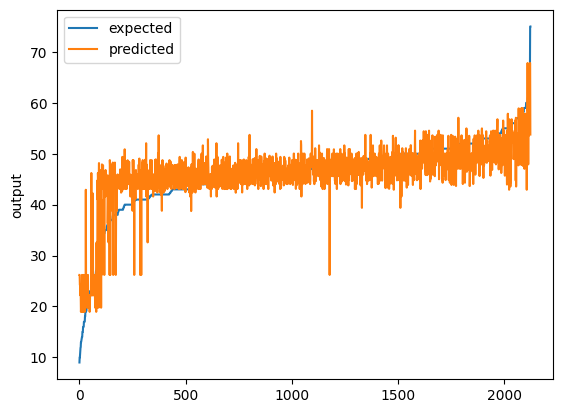

final score (MSE): 19.024477005004883
final score (RMSE): 4.361705303192139
final score (MAE): 3.0694122314453125
final score (R2): 0.6982653141021729


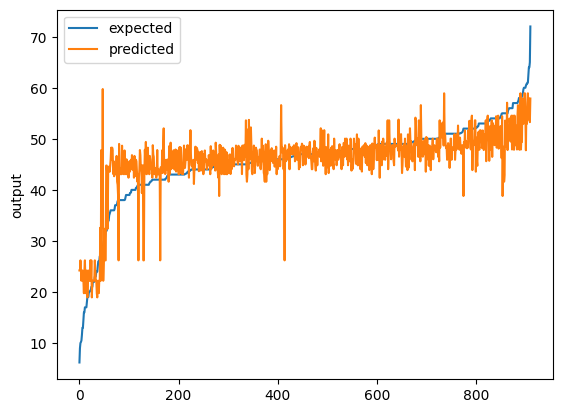

In [81]:
model_scores(model_linear, X_train, y_train)
model_scores(model_linear, X_test, y_test)

In [82]:
#sns.lineplot(x='epoch', y='train loss', data=df_lr1, label='Train')
#sns.lineplot(x='epoch', y='test loss', data=df_lr1, label='Test')

In [83]:
#optimizer
optimizer = torch.optim.Adam(model_linear.parameters(), lr = 0.001)
df_lr2, stop = run(model_linear, optimizer=optimizer)

Epoch:1, train_loss: 20.601171493530273, val_loss: 19.972450, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 177.74it/s]


avg r2 train scores 0.58407277
avg r2 test scores 0.68323016


Epoch:2, train_loss: 47.69607162475586, val_loss: 19.929014, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 184.16it/s]


avg r2 train scores 0.5789787
avg r2 test scores 0.6839191


Epoch:3, train_loss: 8.183222770690918, val_loss: 19.552826, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 179.12it/s]


avg r2 train scores 0.59853786
avg r2 test scores 0.68988556


Epoch:4, train_loss: 6.564026355743408, val_loss: 19.920403, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.99it/s]


avg r2 train scores 0.57042354
avg r2 test scores 0.6840557


Epoch:5, train_loss: 11.886738777160645, val_loss: 20.941557, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.49it/s]


avg r2 train scores 0.5773992
avg r2 test scores 0.6678598


Epoch:6, train_loss: 18.518381118774414, val_loss: 19.418489, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 176.33it/s]


avg r2 train scores 0.5774942
avg r2 test scores 0.6920162


Epoch:7, train_loss: 35.35019302368164, val_loss: 21.126293, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.47it/s]


avg r2 train scores 0.57375795
avg r2 test scores 0.66492987


Epoch:8, train_loss: 21.416532516479492, val_loss: 19.737614, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.65it/s]


avg r2 train scores 0.58099896
avg r2 test scores 0.68695474


Epoch:9, train_loss: 22.2142333984375, val_loss: 19.199108, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.15it/s]


avg r2 train scores 0.58699137
avg r2 test scores 0.69549567


Epoch:10, train_loss: 10.917350769042969, val_loss: 19.671461, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.41it/s]


avg r2 train scores 0.5873323
avg r2 test scores 0.68800396


Epoch:11, train_loss: 24.59735870361328, val_loss: 19.686663, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.20it/s]


avg r2 train scores 0.5884963
avg r2 test scores 0.68776286


Epoch:12, train_loss: 23.10198402404785, val_loss: 20.051992, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.37it/s]


avg r2 train scores 0.59622055
avg r2 test scores 0.68196857


Epoch:13, train_loss: 12.363076210021973, val_loss: 19.242342, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.19it/s]


avg r2 train scores 0.54767144
avg r2 test scores 0.6948099


Epoch:14, train_loss: 4.97882604598999, val_loss: 21.313211, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.52it/s]


avg r2 train scores 0.59857076
avg r2 test scores 0.66196525


Epoch:15, train_loss: 9.5905179977417, val_loss: 21.067442, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.91it/s]


avg r2 train scores 0.5563968
avg r2 test scores 0.6658633


Epoch:16, train_loss: 28.069433212280273, val_loss: 19.530525, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.33it/s]


avg r2 train scores 0.5826291
avg r2 test scores 0.69023925


Epoch:17, train_loss: 19.062952041625977, val_loss: 19.967413, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.30it/s]


avg r2 train scores 0.58672243
avg r2 test scores 0.6833101


Epoch:18, train_loss: 38.44435501098633, val_loss: 19.075979, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.58it/s]


avg r2 train scores 0.60446274
avg r2 test scores 0.6974485


Epoch:19, train_loss: 22.406618118286133, val_loss: 19.733637, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.38it/s]


avg r2 train scores 0.560976
avg r2 test scores 0.6870178


Epoch:20, train_loss: 7.271038055419922, val_loss: 19.628328, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.19it/s]


avg r2 train scores 0.60385346
avg r2 test scores 0.68868804


Epoch:21, train_loss: 19.213945388793945, val_loss: 19.382265, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.20it/s]


avg r2 train scores 0.5925549
avg r2 test scores 0.6925907


Epoch:22, train_loss: 26.782684326171875, val_loss: 20.260279, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.78it/s]


avg r2 train scores 0.57310617
avg r2 test scores 0.67866516


Epoch:23, train_loss: 15.168182373046875, val_loss: 19.872557, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.72it/s]


avg r2 train scores 0.59874207
avg r2 test scores 0.6848146


Epoch:24, train_loss: 27.343368530273438, val_loss: 19.458961, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.23it/s]


avg r2 train scores 0.5945152
avg r2 test scores 0.6913743


Epoch:25, train_loss: 11.492688179016113, val_loss: 19.743036, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.28it/s]


avg r2 train scores 0.5666493
avg r2 test scores 0.6868688


Epoch:26, train_loss: 16.40128517150879, val_loss: 19.245127, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.11it/s]


avg r2 train scores 0.59725535
avg r2 test scores 0.6947658


Epoch:27, train_loss: 18.89708709716797, val_loss: 20.331560, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.84it/s]


avg r2 train scores 0.59198743
avg r2 test scores 0.6775346


Epoch:28, train_loss: 15.211219787597656, val_loss: 19.205984, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.62it/s]


avg r2 train scores 0.5551883
avg r2 test scores 0.6953866


Epoch:29, train_loss: 25.902921676635742, val_loss: 19.133419, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.92it/s]


avg r2 train scores 0.5803962
avg r2 test scores 0.6965375


Epoch:30, train_loss: 21.554344177246094, val_loss: 20.690979, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 132.50it/s]


avg r2 train scores 0.59169734
avg r2 test scores 0.67183405


Epoch:31, train_loss: 6.388359546661377, val_loss: 19.442629, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.20it/s]


avg r2 train scores 0.6092899
avg r2 test scores 0.69163334


Epoch:32, train_loss: 18.83475685119629, val_loss: 18.949562, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.07it/s]


avg r2 train scores 0.5989723
avg r2 test scores 0.69945353


Epoch:33, train_loss: 48.199127197265625, val_loss: 19.512461, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.37it/s]


avg r2 train scores 0.5935357
avg r2 test scores 0.69052577


Epoch:34, train_loss: 11.835328102111816, val_loss: 21.843658, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.84it/s]


avg r2 train scores 0.5771385
avg r2 test scores 0.6535522


Epoch:35, train_loss: 7.3115620613098145, val_loss: 19.179365, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.61it/s]


avg r2 train scores 0.58310586
avg r2 test scores 0.69580877


Epoch:36, train_loss: 9.062026977539062, val_loss: 19.266270, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.47it/s]


avg r2 train scores 0.58876634
avg r2 test scores 0.6944305


Epoch:37, train_loss: 20.38304328918457, val_loss: 19.542461, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.10it/s]


avg r2 train scores 0.57663393
avg r2 test scores 0.69004995


Epoch:38, train_loss: 16.977148056030273, val_loss: 18.960245, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.31it/s]


avg r2 train scores 0.5694816
avg r2 test scores 0.6992841


Epoch:39, train_loss: 46.16375732421875, val_loss: 19.076092, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.75it/s]


avg r2 train scores 0.5981143
avg r2 test scores 0.6974467


Epoch:40, train_loss: 16.266984939575195, val_loss: 19.468363, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.47it/s]


avg r2 train scores 0.5930401
avg r2 test scores 0.6912252


Epoch:41, train_loss: 15.554181098937988, val_loss: 19.962454, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.28it/s]


avg r2 train scores 0.57963604
avg r2 test scores 0.6833887


Epoch:42, train_loss: 11.056991577148438, val_loss: 19.781183, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.01it/s]


avg r2 train scores 0.6132202
avg r2 test scores 0.68626374


Epoch:43, train_loss: 8.234829902648926, val_loss: 19.566874, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.74it/s]


avg r2 train scores 0.5902242
avg r2 test scores 0.68966275


Epoch:44, train_loss: 35.357948303222656, val_loss: 19.151121, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.74it/s]


avg r2 train scores 0.60127455
avg r2 test scores 0.69625676


Epoch:45, train_loss: 13.628874778747559, val_loss: 19.196039, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.57it/s]


avg r2 train scores 0.61081105
avg r2 test scores 0.69554436


Epoch:46, train_loss: 20.54191780090332, val_loss: 18.828747, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.73it/s]


avg r2 train scores 0.60347676
avg r2 test scores 0.7013697


Epoch:47, train_loss: 20.349809646606445, val_loss: 19.783745, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.45it/s]


avg r2 train scores 0.59858257
avg r2 test scores 0.6862231


Epoch:48, train_loss: 9.447871208190918, val_loss: 19.823456, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 175.57it/s]


avg r2 train scores 0.6043332
avg r2 test scores 0.68559325


Epoch:49, train_loss: 13.85119915008545, val_loss: 19.305445, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 182.37it/s]


avg r2 train scores 0.5568262
avg r2 test scores 0.69380915


Epoch:50, train_loss: 6.2299580574035645, val_loss: 19.937103, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.27it/s]


avg r2 train scores 0.5793454
avg r2 test scores 0.6837908


Epoch:51, train_loss: 8.608553886413574, val_loss: 19.492254, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.17it/s]


avg r2 train scores 0.5997855
avg r2 test scores 0.69084626


Epoch:52, train_loss: 12.660143852233887, val_loss: 19.077656, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.46it/s]


avg r2 train scores 0.60924053
avg r2 test scores 0.6974219


Epoch:53, train_loss: 28.87648582458496, val_loss: 19.774824, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.29it/s]


avg r2 train scores 0.5852229
avg r2 test scores 0.6863646


Epoch:54, train_loss: 17.160072326660156, val_loss: 19.528028, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.22it/s]


avg r2 train scores 0.57794785
avg r2 test scores 0.6902789


Epoch:55, train_loss: 19.2016544342041, val_loss: 19.288090, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.96it/s]


avg r2 train scores 0.613429
avg r2 test scores 0.6940844


Epoch:56, train_loss: 25.560667037963867, val_loss: 19.015051, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.32it/s]


avg r2 train scores 0.59339345
avg r2 test scores 0.69841486


Epoch:57, train_loss: 30.19045066833496, val_loss: 19.885626, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.14it/s]


avg r2 train scores 0.5751062
avg r2 test scores 0.68460727


Epoch:58, train_loss: 14.7547025680542, val_loss: 18.965391, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.77it/s]


avg r2 train scores 0.54559577
avg r2 test scores 0.6992025


Epoch:59, train_loss: 18.077396392822266, val_loss: 18.984978, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.90it/s]


avg r2 train scores 0.61975247
avg r2 test scores 0.6988918


Epoch:60, train_loss: 10.7056303024292, val_loss: 19.010822, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.94it/s]


avg r2 train scores 0.5887485
avg r2 test scores 0.6984819


Epoch:61, train_loss: 3.413517713546753, val_loss: 19.167295, EStop: [15 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.43it/s]


avg r2 train scores 0.6166586
avg r2 test scores 0.6960002


Epoch:62, train_loss: 27.250795364379883, val_loss: 18.947195, EStop: [16 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.47it/s]


avg r2 train scores 0.6040589
avg r2 test scores 0.6994911


Epoch:63, train_loss: 8.073140144348145, val_loss: 19.190363, EStop: [17 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.10it/s]


avg r2 train scores 0.6049018
avg r2 test scores 0.69563437


Epoch:64, train_loss: 29.97565269470215, val_loss: 19.304577, EStop: [18 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.50it/s]


avg r2 train scores 0.61259454
avg r2 test scores 0.69382286


Epoch:65, train_loss: 34.98373031616211, val_loss: 19.084890, EStop: [19 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.98it/s]


avg r2 train scores 0.5892393
avg r2 test scores 0.69730717


Epoch:66, train_loss: 9.452722549438477, val_loss: 18.653313, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 132.60it/s]


avg r2 train scores 0.59846425
avg r2 test scores 0.7041521


Epoch:67, train_loss: 28.22820472717285, val_loss: 19.099422, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 135.09it/s]


avg r2 train scores 0.5916056
avg r2 test scores 0.6970767


Epoch:68, train_loss: 3.6975739002227783, val_loss: 19.082443, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 130.39it/s]


avg r2 train scores 0.5827858
avg r2 test scores 0.697346


Epoch:69, train_loss: 2.357621908187866, val_loss: 18.698513, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.16it/s]


avg r2 train scores 0.582319
avg r2 test scores 0.70343524


Epoch:70, train_loss: 7.987111568450928, val_loss: 19.070997, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.60it/s]


avg r2 train scores 0.5875918
avg r2 test scores 0.6975275


Epoch:71, train_loss: 24.948989868164062, val_loss: 19.549387, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.27it/s]


avg r2 train scores 0.6088353
avg r2 test scores 0.6899401


Epoch:72, train_loss: 22.230567932128906, val_loss: 18.813740, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.34it/s]


avg r2 train scores 0.60331
avg r2 test scores 0.7016077


Epoch:73, train_loss: 12.957427024841309, val_loss: 19.353384, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.51it/s]


avg r2 train scores 0.60235196
avg r2 test scores 0.6930488


Epoch:74, train_loss: 14.763717651367188, val_loss: 19.628405, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.74it/s]


avg r2 train scores 0.60272217
avg r2 test scores 0.68868685


Epoch:75, train_loss: 54.88825988769531, val_loss: 18.910885, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.21it/s]


avg r2 train scores 0.57750285
avg r2 test scores 0.7000669


Epoch:76, train_loss: 22.29150390625, val_loss: 19.024452, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.01it/s]


avg r2 train scores 0.59872174
avg r2 test scores 0.6982658


Epoch:77, train_loss: 17.74258041381836, val_loss: 19.854912, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.62it/s]


avg r2 train scores 0.596774
avg r2 test scores 0.68509436


Epoch:78, train_loss: 12.99992847442627, val_loss: 18.974894, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.50it/s]


avg r2 train scores 0.6036772
avg r2 test scores 0.69905174


Epoch:79, train_loss: 10.098268508911133, val_loss: 19.544128, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.15it/s]


avg r2 train scores 0.5697552
avg r2 test scores 0.69002354


Epoch:80, train_loss: 26.227922439575195, val_loss: 19.496202, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.46it/s]


avg r2 train scores 0.58458817
avg r2 test scores 0.6907836


Epoch:81, train_loss: 35.863521575927734, val_loss: 19.103268, EStop: [15 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.53it/s]


avg r2 train scores 0.6074984
avg r2 test scores 0.69701576


Epoch:82, train_loss: 7.780039310455322, val_loss: 18.975985, EStop: [16 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.37it/s]


avg r2 train scores 0.6127758
avg r2 test scores 0.69903445


Epoch:83, train_loss: 40.34385299682617, val_loss: 19.394030, EStop: [17 / 50]: 100%|██████████| 67/67 [00:00<00:00, 135.48it/s]


avg r2 train scores 0.5710484
avg r2 test scores 0.69240415


Epoch:84, train_loss: 13.124678611755371, val_loss: 19.349884, EStop: [18 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.50it/s]


avg r2 train scores 0.6010954
avg r2 test scores 0.69310427


Epoch:85, train_loss: 9.381780624389648, val_loss: 19.288145, EStop: [19 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.32it/s]


avg r2 train scores 0.5779924
avg r2 test scores 0.69408345


Epoch:86, train_loss: 10.041626930236816, val_loss: 19.194662, EStop: [20 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.70it/s]


avg r2 train scores 0.5952732
avg r2 test scores 0.6955662


Epoch:87, train_loss: 43.898563385009766, val_loss: 18.857004, EStop: [21 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.66it/s]


avg r2 train scores 0.6011351
avg r2 test scores 0.70092154


Epoch:88, train_loss: 20.048370361328125, val_loss: 19.002892, EStop: [22 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.54it/s]


avg r2 train scores 0.5959707
avg r2 test scores 0.6986077


Epoch:89, train_loss: 31.628686904907227, val_loss: 18.876884, EStop: [23 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.72it/s]


avg r2 train scores 0.61578447
avg r2 test scores 0.7006062


Epoch:90, train_loss: 31.829368591308594, val_loss: 18.934019, EStop: [24 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.47it/s]


avg r2 train scores 0.55999976
avg r2 test scores 0.69970006


Epoch:91, train_loss: 19.88214683532715, val_loss: 19.295340, EStop: [25 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.07it/s]


avg r2 train scores 0.60622096
avg r2 test scores 0.69396937


Epoch:92, train_loss: 22.8857364654541, val_loss: 18.755226, EStop: [26 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.44it/s]


avg r2 train scores 0.60244054
avg r2 test scores 0.70253575


Epoch:93, train_loss: 13.93062686920166, val_loss: 19.419664, EStop: [27 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.85it/s]


avg r2 train scores 0.5791375
avg r2 test scores 0.6919975


Epoch:94, train_loss: 5.640556335449219, val_loss: 20.145983, EStop: [28 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.72it/s]


avg r2 train scores 0.61612
avg r2 test scores 0.68047786


Epoch:95, train_loss: 44.38692092895508, val_loss: 18.691525, EStop: [29 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.97it/s]


avg r2 train scores 0.5980316
avg r2 test scores 0.7035461


Epoch:96, train_loss: 49.1338005065918, val_loss: 19.303337, EStop: [30 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.14it/s]


avg r2 train scores 0.60210043
avg r2 test scores 0.69384253


Epoch:97, train_loss: 15.91203784942627, val_loss: 19.066292, EStop: [31 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.31it/s]


avg r2 train scores 0.5785986
avg r2 test scores 0.69760215


Epoch:98, train_loss: 24.071334838867188, val_loss: 19.257687, EStop: [32 / 50]: 100%|██████████| 67/67 [00:00<00:00, 133.88it/s]


avg r2 train scores 0.5890461
avg r2 test scores 0.6945666


Epoch:99, train_loss: 17.983861923217773, val_loss: 18.769514, EStop: [33 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.75it/s]


avg r2 train scores 0.6126637
avg r2 test scores 0.70230913


Epoch:100, train_loss: 38.896881103515625, val_loss: 18.701305, EStop: [34 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.12it/s]


avg r2 train scores 0.6170657
avg r2 test scores 0.70339096


Epoch:101, train_loss: 20.199935913085938, val_loss: 19.039179, EStop: [35 / 50]: 100%|██████████| 67/67 [00:01<00:00, 56.93it/s]


avg r2 train scores 0.5956281
avg r2 test scores 0.6980322


Epoch:102, train_loss: 62.27937698364258, val_loss: 18.891537, EStop: [36 / 50]: 100%|██████████| 67/67 [00:01<00:00, 51.64it/s]


avg r2 train scores 0.58016133
avg r2 test scores 0.7003738


Epoch:103, train_loss: 10.440018653869629, val_loss: 19.223074, EStop: [37 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.97it/s]


avg r2 train scores 0.6149735
avg r2 test scores 0.69511557


Epoch:104, train_loss: 15.327159881591797, val_loss: 18.890507, EStop: [38 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.17it/s]


avg r2 train scores 0.6025178
avg r2 test scores 0.70039016


Epoch:105, train_loss: 7.207534313201904, val_loss: 18.756861, EStop: [39 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.26it/s]


avg r2 train scores 0.6324031
avg r2 test scores 0.7025099


Epoch:106, train_loss: 5.873918056488037, val_loss: 18.733047, EStop: [40 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.92it/s]


avg r2 train scores 0.6245092
avg r2 test scores 0.70288754


Epoch:107, train_loss: 11.8902006149292, val_loss: 19.128546, EStop: [41 / 50]: 100%|██████████| 67/67 [00:00<00:00, 133.06it/s]


avg r2 train scores 0.60583895
avg r2 test scores 0.69661474


Epoch:108, train_loss: 16.379636764526367, val_loss: 20.168865, EStop: [42 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.76it/s]


avg r2 train scores 0.58625406
avg r2 test scores 0.680115


Epoch:109, train_loss: 17.452957153320312, val_loss: 18.645048, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.00it/s]


avg r2 train scores 0.5991718
avg r2 test scores 0.70428324


Epoch:110, train_loss: 10.258238792419434, val_loss: 19.178547, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.16it/s]


avg r2 train scores 0.6077544
avg r2 test scores 0.69582176


Epoch:111, train_loss: 15.986477851867676, val_loss: 18.701893, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.96it/s]


avg r2 train scores 0.5874551
avg r2 test scores 0.70338166


Epoch:112, train_loss: 19.585140228271484, val_loss: 18.967363, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.68it/s]


avg r2 train scores 0.6019999
avg r2 test scores 0.6991712


Epoch:113, train_loss: 19.530752182006836, val_loss: 19.344904, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.48it/s]


avg r2 train scores 0.5845198
avg r2 test scores 0.6931833


Epoch:114, train_loss: 17.54814910888672, val_loss: 19.184896, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.92it/s]


avg r2 train scores 0.60406095
avg r2 test scores 0.69572103


Epoch:115, train_loss: 5.654148101806641, val_loss: 19.265299, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.28it/s]


avg r2 train scores 0.6147969
avg r2 test scores 0.69444585


Epoch:116, train_loss: 16.429323196411133, val_loss: 19.793953, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.85it/s]


avg r2 train scores 0.5975496
avg r2 test scores 0.6860612


Epoch:117, train_loss: 5.6979451179504395, val_loss: 19.034029, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.18it/s]


avg r2 train scores 0.60034245
avg r2 test scores 0.69811386


Epoch:118, train_loss: 15.72453784942627, val_loss: 18.796223, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.23it/s]


avg r2 train scores 0.5988495
avg r2 test scores 0.7018856


Epoch:119, train_loss: 14.720954895019531, val_loss: 19.226280, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.16it/s]


avg r2 train scores 0.619925
avg r2 test scores 0.69506466


Epoch:120, train_loss: 9.876311302185059, val_loss: 18.798847, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.37it/s]


avg r2 train scores 0.6087686
avg r2 test scores 0.7018439


Epoch:121, train_loss: 37.284767150878906, val_loss: 19.129078, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.53it/s]


avg r2 train scores 0.5862124
avg r2 test scores 0.69660634


Epoch:122, train_loss: 9.722315788269043, val_loss: 19.335567, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.05it/s]


avg r2 train scores 0.6209663
avg r2 test scores 0.69333136


Epoch:123, train_loss: 11.337471008300781, val_loss: 19.130529, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.22it/s]


avg r2 train scores 0.6029947
avg r2 test scores 0.69658333


Epoch:124, train_loss: 11.548694610595703, val_loss: 18.933678, EStop: [15 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.36it/s]


avg r2 train scores 0.59784174
avg r2 test scores 0.6997055


Epoch:125, train_loss: 8.803712844848633, val_loss: 18.910547, EStop: [16 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.78it/s]


avg r2 train scores 0.605204
avg r2 test scores 0.7000723


Epoch:126, train_loss: 6.664267063140869, val_loss: 19.254974, EStop: [17 / 50]: 100%|██████████| 67/67 [00:00<00:00, 133.88it/s]


avg r2 train scores 0.60663134
avg r2 test scores 0.6946096


Epoch:127, train_loss: 37.37738800048828, val_loss: 19.435223, EStop: [18 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.23it/s]


avg r2 train scores 0.6040073
avg r2 test scores 0.69175076


Epoch:128, train_loss: 8.850260734558105, val_loss: 19.125225, EStop: [19 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.85it/s]


avg r2 train scores 0.5931383
avg r2 test scores 0.69666743


Epoch:129, train_loss: 14.290081024169922, val_loss: 18.918417, EStop: [20 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.48it/s]


avg r2 train scores 0.60742384
avg r2 test scores 0.6999475


Epoch:130, train_loss: 11.838395118713379, val_loss: 18.897545, EStop: [21 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.55it/s]


avg r2 train scores 0.59438545
avg r2 test scores 0.7002785


Epoch:131, train_loss: 6.326258182525635, val_loss: 19.581854, EStop: [22 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.47it/s]


avg r2 train scores 0.61034197
avg r2 test scores 0.6894252


Epoch:132, train_loss: 4.244394302368164, val_loss: 19.344545, EStop: [23 / 50]: 100%|██████████| 67/67 [00:00<00:00, 134.90it/s]


avg r2 train scores 0.6215565
avg r2 test scores 0.69318897


Epoch:133, train_loss: 6.9637932777404785, val_loss: 18.898127, EStop: [24 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.35it/s]


avg r2 train scores 0.57626104
avg r2 test scores 0.70026934


Epoch:134, train_loss: 17.011220932006836, val_loss: 18.732611, EStop: [25 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.73it/s]


avg r2 train scores 0.614676
avg r2 test scores 0.70289445


Epoch:135, train_loss: 6.345090866088867, val_loss: 18.886282, EStop: [26 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.14it/s]


avg r2 train scores 0.5884508
avg r2 test scores 0.7004572


Epoch:136, train_loss: 6.404365062713623, val_loss: 19.540632, EStop: [27 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.53it/s]


avg r2 train scores 0.6108112
avg r2 test scores 0.690079


Epoch:137, train_loss: 7.087165832519531, val_loss: 19.653326, EStop: [28 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.96it/s]


avg r2 train scores 0.6112734
avg r2 test scores 0.6882916


Epoch:138, train_loss: 32.66515350341797, val_loss: 18.983149, EStop: [29 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.73it/s]


avg r2 train scores 0.607378
avg r2 test scores 0.69892085


Epoch:139, train_loss: 12.339592933654785, val_loss: 19.319990, EStop: [30 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.01it/s]


avg r2 train scores 0.6120579
avg r2 test scores 0.69357836


Epoch:140, train_loss: 6.788367748260498, val_loss: 18.780209, EStop: [31 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.17it/s]


avg r2 train scores 0.60596955
avg r2 test scores 0.70213956


Epoch:141, train_loss: 17.502378463745117, val_loss: 18.883280, EStop: [32 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.30it/s]


avg r2 train scores 0.6071582
avg r2 test scores 0.7005048


Epoch:142, train_loss: 7.6447529792785645, val_loss: 18.846889, EStop: [33 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.46it/s]


avg r2 train scores 0.62435
avg r2 test scores 0.701082


Epoch:143, train_loss: 12.685149192810059, val_loss: 19.612368, EStop: [34 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.16it/s]


avg r2 train scores 0.6073446
avg r2 test scores 0.68894124


Epoch:144, train_loss: 7.535921573638916, val_loss: 19.245777, EStop: [35 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.57it/s]


avg r2 train scores 0.60041225
avg r2 test scores 0.69475543


Epoch:145, train_loss: 4.606478214263916, val_loss: 19.374844, EStop: [36 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.50it/s]


avg r2 train scores 0.61919165
avg r2 test scores 0.69270843


Epoch:146, train_loss: 8.318144798278809, val_loss: 19.078129, EStop: [37 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.68it/s]


avg r2 train scores 0.5986358
avg r2 test scores 0.6974144


Epoch:147, train_loss: 20.079570770263672, val_loss: 19.371685, EStop: [38 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.68it/s]


avg r2 train scores 0.6015549
avg r2 test scores 0.6927585


Epoch:148, train_loss: 13.022406578063965, val_loss: 18.560295, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 131.78it/s]


avg r2 train scores 0.6344008
avg r2 test scores 0.70562744


Epoch:149, train_loss: 18.43104362487793, val_loss: 19.682978, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.09it/s]


avg r2 train scores 0.6134713
avg r2 test scores 0.68782127


Epoch:150, train_loss: 19.239343643188477, val_loss: 18.855661, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.73it/s]


avg r2 train scores 0.5993473
avg r2 test scores 0.7009428


Epoch:151, train_loss: 18.146528244018555, val_loss: 18.929525, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.64it/s]


avg r2 train scores 0.6165099
avg r2 test scores 0.69977134


Epoch:152, train_loss: 8.471959114074707, val_loss: 20.010803, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.43it/s]


avg r2 train scores 0.65073234
avg r2 test scores 0.6826219


Epoch:153, train_loss: 8.282795906066895, val_loss: 19.462057, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.55it/s]


avg r2 train scores 0.58490586
avg r2 test scores 0.6913252


Epoch:154, train_loss: 13.260749816894531, val_loss: 18.733477, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.94it/s]


avg r2 train scores 0.57592744
avg r2 test scores 0.70288074


Epoch:155, train_loss: 21.43584632873535, val_loss: 19.020395, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.65it/s]


avg r2 train scores 0.58584017
avg r2 test scores 0.6983301


Epoch:156, train_loss: 26.863298416137695, val_loss: 18.819813, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.04it/s]


avg r2 train scores 0.6144963
avg r2 test scores 0.7015114


Epoch:157, train_loss: 8.334199905395508, val_loss: 19.447311, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.58it/s]


avg r2 train scores 0.60778075
avg r2 test scores 0.6915591


Epoch:158, train_loss: 7.350374221801758, val_loss: 19.237762, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.60it/s]


avg r2 train scores 0.60226697
avg r2 test scores 0.6948826


Epoch:159, train_loss: 13.833148002624512, val_loss: 18.902752, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.38it/s]


avg r2 train scores 0.627936
avg r2 test scores 0.70019597


Epoch:160, train_loss: 5.794703006744385, val_loss: 19.504463, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.71it/s]


avg r2 train scores 0.60905164
avg r2 test scores 0.6906526


Epoch:161, train_loss: 5.5727410316467285, val_loss: 19.985298, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.53it/s]


avg r2 train scores 0.5809633
avg r2 test scores 0.68302643


Epoch:162, train_loss: 18.76737403869629, val_loss: 19.157223, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.01it/s]


avg r2 train scores 0.6138128
avg r2 test scores 0.69615996


Epoch:163, train_loss: 39.40590286254883, val_loss: 19.677826, EStop: [15 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.56it/s]


avg r2 train scores 0.595523
avg r2 test scores 0.68790305


Epoch:164, train_loss: 40.41647720336914, val_loss: 18.745335, EStop: [16 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.62it/s]


avg r2 train scores 0.6107039
avg r2 test scores 0.7026926


Epoch:165, train_loss: 13.643802642822266, val_loss: 19.349096, EStop: [17 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.61it/s]


avg r2 train scores 0.6119193
avg r2 test scores 0.6931168


Epoch:166, train_loss: 17.578889846801758, val_loss: 18.884850, EStop: [18 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.34it/s]


avg r2 train scores 0.62747556
avg r2 test scores 0.70047987


Epoch:167, train_loss: 10.51530933380127, val_loss: 19.929081, EStop: [19 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.55it/s]


avg r2 train scores 0.59872615
avg r2 test scores 0.683918


Epoch:168, train_loss: 10.4996919631958, val_loss: 19.043619, EStop: [20 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.08it/s]


avg r2 train scores 0.59623486
avg r2 test scores 0.6979618


Epoch:169, train_loss: 42.03228759765625, val_loss: 18.626863, EStop: [21 / 50]: 100%|██████████| 67/67 [00:01<00:00, 47.71it/s]


avg r2 train scores 0.6308474
avg r2 test scores 0.7045716


Epoch:170, train_loss: 10.293097496032715, val_loss: 19.109150, EStop: [22 / 50]: 100%|██████████| 67/67 [00:00<00:00, 73.31it/s] 


avg r2 train scores 0.61615324
avg r2 test scores 0.6969224


Epoch:171, train_loss: 8.514386177062988, val_loss: 19.363661, EStop: [23 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.71it/s]


avg r2 train scores 0.5778238
avg r2 test scores 0.69288576


Epoch:172, train_loss: 37.66401290893555, val_loss: 18.840879, EStop: [24 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.12it/s]


avg r2 train scores 0.5978561
avg r2 test scores 0.70117724


Epoch:173, train_loss: 48.03358840942383, val_loss: 19.097631, EStop: [25 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.06it/s]


avg r2 train scores 0.62491906
avg r2 test scores 0.6971051


Epoch:174, train_loss: 8.572434425354004, val_loss: 18.878185, EStop: [26 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.26it/s]


avg r2 train scores 0.6126109
avg r2 test scores 0.7005856


Epoch:175, train_loss: 10.093522071838379, val_loss: 19.120077, EStop: [27 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.96it/s]


avg r2 train scores 0.620316
avg r2 test scores 0.6967491


Epoch:176, train_loss: 8.972454071044922, val_loss: 19.941595, EStop: [28 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.03it/s]


avg r2 train scores 0.60849744
avg r2 test scores 0.6837195


Epoch:177, train_loss: 25.537599563598633, val_loss: 19.041515, EStop: [29 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.55it/s]


avg r2 train scores 0.615421
avg r2 test scores 0.6979951


Epoch:178, train_loss: 14.214529991149902, val_loss: 18.925837, EStop: [30 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.80it/s]


avg r2 train scores 0.5831215
avg r2 test scores 0.6998298


Epoch:179, train_loss: 9.150246620178223, val_loss: 19.261877, EStop: [31 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.81it/s]


avg r2 train scores 0.60450464
avg r2 test scores 0.6945001


Epoch:180, train_loss: 8.876083374023438, val_loss: 19.280710, EStop: [32 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.08it/s]


avg r2 train scores 0.6161375
avg r2 test scores 0.6942014


Epoch:181, train_loss: 45.739166259765625, val_loss: 18.875965, EStop: [33 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.14it/s]


avg r2 train scores 0.61921614
avg r2 test scores 0.7006208


Epoch:182, train_loss: 19.517370223999023, val_loss: 19.867977, EStop: [34 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.14it/s]


avg r2 train scores 0.59174156
avg r2 test scores 0.6848872


Epoch:183, train_loss: 11.946423530578613, val_loss: 19.238710, EStop: [35 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.98it/s]


avg r2 train scores 0.6226276
avg r2 test scores 0.69486755


Epoch:184, train_loss: 7.831117153167725, val_loss: 19.016745, EStop: [36 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.62it/s]


avg r2 train scores 0.5893584
avg r2 test scores 0.698388


Epoch:185, train_loss: 13.001579284667969, val_loss: 20.457153, EStop: [37 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.29it/s]


avg r2 train scores 0.5852744
avg r2 test scores 0.6755426


Epoch:186, train_loss: 8.258413314819336, val_loss: 19.036882, EStop: [38 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.38it/s]


avg r2 train scores 0.6032553
avg r2 test scores 0.6980686


Epoch:187, train_loss: 9.666845321655273, val_loss: 19.277857, EStop: [39 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.75it/s]


avg r2 train scores 0.6216995
avg r2 test scores 0.69424665


Epoch:188, train_loss: 12.124073028564453, val_loss: 19.356184, EStop: [40 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.03it/s]


avg r2 train scores 0.59346783
avg r2 test scores 0.69300437


Epoch:189, train_loss: 47.03689956665039, val_loss: 19.001831, EStop: [41 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.80it/s]


avg r2 train scores 0.6135508
avg r2 test scores 0.6986245


Epoch:190, train_loss: 16.515867233276367, val_loss: 18.975937, EStop: [42 / 50]: 100%|██████████| 67/67 [00:00<00:00, 133.92it/s]


avg r2 train scores 0.6176192
avg r2 test scores 0.6990352


Epoch:191, train_loss: 13.370383262634277, val_loss: 18.939459, EStop: [43 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.02it/s]


avg r2 train scores 0.6128501
avg r2 test scores 0.69961375


Epoch:192, train_loss: 20.45011329650879, val_loss: 19.095156, EStop: [44 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.39it/s]


avg r2 train scores 0.599402
avg r2 test scores 0.6971444


Epoch:193, train_loss: 19.15135955810547, val_loss: 18.953659, EStop: [45 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.33it/s]


avg r2 train scores 0.6121602
avg r2 test scores 0.69938856


Epoch:194, train_loss: 11.630906105041504, val_loss: 20.315453, EStop: [46 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.45it/s]


avg r2 train scores 0.6383613
avg r2 test scores 0.67779005


Epoch:195, train_loss: 7.059525966644287, val_loss: 19.160574, EStop: [47 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.26it/s]


avg r2 train scores 0.591348
avg r2 test scores 0.6961068


Epoch:196, train_loss: 37.32096862792969, val_loss: 18.849543, EStop: [48 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.69it/s]


avg r2 train scores 0.6056044
avg r2 test scores 0.7010399


Epoch:197, train_loss: 14.607978820800781, val_loss: 19.259012, EStop: [49 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.08it/s]


avg r2 train scores 0.6171596
avg r2 test scores 0.6945455


Epoch:198, train_loss: 12.668243408203125, val_loss: 19.464357, EStop: [Early stopping triggered after 50 epochs.]: 100%|██████████| 67/67 [00:00<00:00, 139.87it/s]


avg r2 train scores 0.61069053
avg r2 test scores 0.6912887


final score (MSE): 16.186464309692383
final score (RMSE): 4.023240566253662
final score (MAE): 2.9380292892456055
final score (R2): 0.7006629705429077


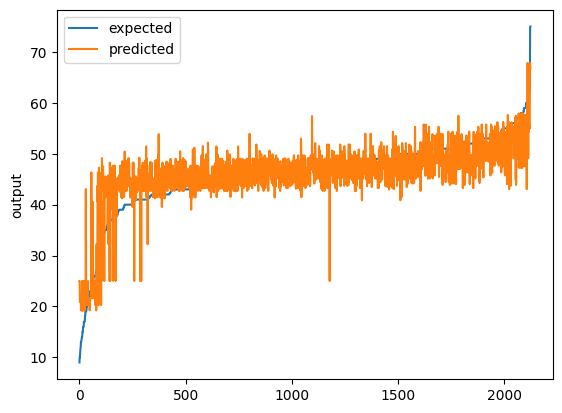

final score (MSE): 18.56029510498047
final score (RMSE): 4.308166027069092
final score (MAE): 3.042827606201172
final score (R2): 0.70562744140625


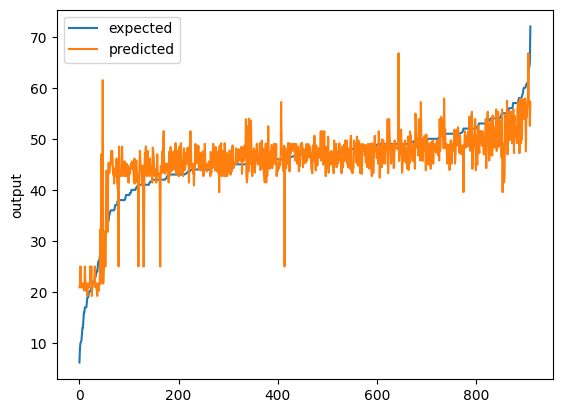

In [84]:
model_scores(model_linear, X_train, y_train)
model_scores(model_linear, X_test, y_test)

In [85]:
#pd.DataFrame()

In [86]:
#new_df = pd.concat([df_lr1['epochs'],df_lr1['train loss']], axis=1)

In [87]:
#sns.lineplot(x='epochs', y='train loss', data=df_lr2, label='Train')
#sns.lineplot(x='epoch', y='testloss', data=results_pd, label='Test')

In [88]:
# fc with relu hidden layer, linear activation layer
model2 = FCNet(X_train.shape[1],1).to(device)
optimizer = torch.optim.SGD(model2.parameters(), lr = 0.001)
fcnet1 = run(model2,optimizer)

Epoch:1, train_loss: 867.8255004882812, val_loss: 448.417023, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.03it/s]


avg r2 train scores -41.25831
avg r2 test scores -6.112046


Epoch:2, train_loss: 26.72379493713379, val_loss: 34.814865, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.93it/s]


avg r2 train scores -0.6568555
avg r2 test scores 0.44782442


Epoch:3, train_loss: 42.33956527709961, val_loss: 89.550880, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.44it/s]


avg r2 train scores 0.12586482
avg r2 test scores -0.42030728


Epoch:4, train_loss: 47.33479690551758, val_loss: 54.502773, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.22it/s]


avg r2 train scores 0.22939125
avg r2 test scores 0.13556755


Epoch:5, train_loss: 26.316476821899414, val_loss: 25.709848, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.23it/s]


avg r2 train scores 0.18834525
avg r2 test scores 0.59223306


Epoch:6, train_loss: 21.75877571105957, val_loss: 25.022055, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.02it/s]


avg r2 train scores 0.2941811
avg r2 test scores 0.6031418


Epoch:7, train_loss: 12.783348083496094, val_loss: 23.356014, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.80it/s]


avg r2 train scores 0.42869398
avg r2 test scores 0.6295657


Epoch:8, train_loss: 17.677431106567383, val_loss: 28.151409, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.83it/s]


avg r2 train scores 0.39672872
avg r2 test scores 0.5535091


Epoch:9, train_loss: 37.53168869018555, val_loss: 29.719948, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 175.00it/s]


avg r2 train scores 0.34475634
avg r2 test scores 0.52863157


Epoch:10, train_loss: 13.851492881774902, val_loss: 22.567635, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.84it/s]


avg r2 train scores 0.49278465
avg r2 test scores 0.6420697


Epoch:11, train_loss: 15.642997741699219, val_loss: 24.372366, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.04it/s]


avg r2 train scores 0.4581477
avg r2 test scores 0.613446


Epoch:12, train_loss: 17.17991065979004, val_loss: 25.649508, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.82it/s]


avg r2 train scores 0.50159305
avg r2 test scores 0.59319013


Epoch:13, train_loss: 9.308704376220703, val_loss: 25.289154, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.20it/s]


avg r2 train scores 0.45807797
avg r2 test scores 0.59890544


Epoch:14, train_loss: 28.718841552734375, val_loss: 26.376690, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.21it/s]


avg r2 train scores 0.4762848
avg r2 test scores 0.5816568


Epoch:15, train_loss: 31.951311111450195, val_loss: 24.793972, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.12it/s]


avg r2 train scores 0.4943547
avg r2 test scores 0.6067592


Epoch:16, train_loss: 20.484445571899414, val_loss: 22.824303, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 175.40it/s]


avg r2 train scores 0.51775587
avg r2 test scores 0.6379988


Epoch:17, train_loss: 14.511856079101562, val_loss: 24.914726, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.92it/s]


avg r2 train scores 0.47052988
avg r2 test scores 0.604844


Epoch:18, train_loss: 16.155607223510742, val_loss: 21.981150, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.02it/s]


avg r2 train scores 0.46663818
avg r2 test scores 0.6513715


Epoch:19, train_loss: 24.265073776245117, val_loss: 22.028833, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.02it/s]


avg r2 train scores 0.5270174
avg r2 test scores 0.6506152


Epoch:20, train_loss: 22.453399658203125, val_loss: 25.274382, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.76it/s]


avg r2 train scores 0.46007764
avg r2 test scores 0.59913975


Epoch:21, train_loss: 30.224790573120117, val_loss: 31.351439, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.24it/s]


avg r2 train scores 0.4691198
avg r2 test scores 0.5027556


Epoch:22, train_loss: 20.03457260131836, val_loss: 28.288338, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.14it/s]


avg r2 train scores 0.4629952
avg r2 test scores 0.55133736


Epoch:23, train_loss: 30.491308212280273, val_loss: 24.373379, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.79it/s]


avg r2 train scores 0.520695
avg r2 test scores 0.61342996


Epoch:24, train_loss: 41.290679931640625, val_loss: 24.779049, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.77it/s]


avg r2 train scores 0.54485226
avg r2 test scores 0.60699594


Epoch:25, train_loss: 21.81529426574707, val_loss: 21.226349, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.28it/s]


avg r2 train scores 0.51205164
avg r2 test scores 0.66334295


Epoch:26, train_loss: 24.357282638549805, val_loss: 22.415348, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 177.66it/s]


avg r2 train scores 0.53190786
avg r2 test scores 0.644485


Epoch:27, train_loss: 9.743612289428711, val_loss: 21.428102, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 187.28it/s]


avg r2 train scores 0.52023524
avg r2 test scores 0.660143


Epoch:28, train_loss: 21.055946350097656, val_loss: 24.940626, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 180.73it/s]


avg r2 train scores 0.54470545
avg r2 test scores 0.60443324


Epoch:29, train_loss: 37.5201301574707, val_loss: 24.060905, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.77it/s]


avg r2 train scores 0.52190644
avg r2 test scores 0.6183859


Epoch:30, train_loss: 9.649669647216797, val_loss: 23.454071, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.17it/s]


avg r2 train scores 0.5728038
avg r2 test scores 0.6280105


Epoch:31, train_loss: 6.285485744476318, val_loss: 21.412382, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.90it/s]


avg r2 train scores 0.5384405
avg r2 test scores 0.6603924


Epoch:32, train_loss: 23.256332397460938, val_loss: 21.017696, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.47it/s]


avg r2 train scores 0.52522826
avg r2 test scores 0.6666522


Epoch:33, train_loss: 3.950650930404663, val_loss: 21.034739, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.06it/s]


avg r2 train scores 0.5652934
avg r2 test scores 0.66638196


Epoch:34, train_loss: 52.66169738769531, val_loss: 26.506857, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.55it/s]


avg r2 train scores 0.5550788
avg r2 test scores 0.5795923


Epoch:35, train_loss: 11.892090797424316, val_loss: 25.335114, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 177.63it/s]


avg r2 train scores 0.5194763
avg r2 test scores 0.5981765


Epoch:36, train_loss: 7.298349857330322, val_loss: 21.477318, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 179.95it/s]


avg r2 train scores 0.54401964
avg r2 test scores 0.65936244


Epoch:37, train_loss: 28.34519386291504, val_loss: 21.464346, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.67it/s]


avg r2 train scores 0.5331913
avg r2 test scores 0.6595682


Epoch:38, train_loss: 5.8410162925720215, val_loss: 24.462961, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 176.10it/s]


avg r2 train scores 0.56696945
avg r2 test scores 0.61200917


Epoch:39, train_loss: 14.064671516418457, val_loss: 21.936726, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 178.10it/s]


avg r2 train scores 0.55269647
avg r2 test scores 0.6520761


Epoch:40, train_loss: 9.507905006408691, val_loss: 21.231598, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 180.00it/s]


avg r2 train scores 0.5568966
avg r2 test scores 0.6632596


Epoch:41, train_loss: 20.11216926574707, val_loss: 25.224625, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 177.16it/s]


avg r2 train scores 0.5412183
avg r2 test scores 0.5999289


Epoch:42, train_loss: 17.393571853637695, val_loss: 22.919128, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.25it/s]


avg r2 train scores 0.5768592
avg r2 test scores 0.6364949


Epoch:43, train_loss: 18.887968063354492, val_loss: 24.814125, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 178.50it/s]


avg r2 train scores 0.5435247
avg r2 test scores 0.6064396


Epoch:44, train_loss: 20.5174560546875, val_loss: 21.123756, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.06it/s]


avg r2 train scores 0.5403052
avg r2 test scores 0.66497004


Epoch:45, train_loss: 18.044034957885742, val_loss: 24.659237, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 184.59it/s]


avg r2 train scores 0.5384895
avg r2 test scores 0.60889614


Epoch:46, train_loss: 16.868188858032227, val_loss: 21.583498, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 178.80it/s]


avg r2 train scores 0.5465733
avg r2 test scores 0.6576784


Epoch:47, train_loss: 15.988572120666504, val_loss: 19.953865, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.73it/s]


avg r2 train scores 0.5597114
avg r2 test scores 0.68352497


Epoch:48, train_loss: 50.077056884765625, val_loss: 23.696533, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.73it/s]


avg r2 train scores 0.5565209
avg r2 test scores 0.62416494


Epoch:49, train_loss: 14.75914478302002, val_loss: 20.316996, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.36it/s]


avg r2 train scores 0.5750853
avg r2 test scores 0.6777656


Epoch:50, train_loss: 11.283308982849121, val_loss: 26.401812, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.09it/s]


avg r2 train scores 0.5036123
avg r2 test scores 0.5812583


Epoch:51, train_loss: 19.525115966796875, val_loss: 22.604883, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.48it/s]


avg r2 train scores 0.5514427
avg r2 test scores 0.6414789


Epoch:52, train_loss: 18.995790481567383, val_loss: 22.124540, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.59it/s]


avg r2 train scores 0.5732826
avg r2 test scores 0.6490973


Epoch:53, train_loss: 16.2004337310791, val_loss: 22.502472, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.28it/s]


avg r2 train scores 0.5467372
avg r2 test scores 0.6431032


Epoch:54, train_loss: 11.335830688476562, val_loss: 20.020569, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.78it/s]


avg r2 train scores 0.5396321
avg r2 test scores 0.682467


Epoch:55, train_loss: 13.446805000305176, val_loss: 19.645206, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 179.04it/s]


avg r2 train scores 0.5204626
avg r2 test scores 0.6884204


Epoch:56, train_loss: 19.52569580078125, val_loss: 22.782570, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.97it/s]


avg r2 train scores 0.5502556
avg r2 test scores 0.6386607


Epoch:57, train_loss: 15.879752159118652, val_loss: 21.433271, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.80it/s]


avg r2 train scores 0.5581105
avg r2 test scores 0.66006106


Epoch:58, train_loss: 14.347699165344238, val_loss: 20.221634, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 185.46it/s]


avg r2 train scores 0.5852601
avg r2 test scores 0.679278


Epoch:59, train_loss: 3.01245379447937, val_loss: 19.849613, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 180.61it/s]


avg r2 train scores 0.554693
avg r2 test scores 0.6851784


Epoch:60, train_loss: 21.252084732055664, val_loss: 21.318699, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.08it/s]


avg r2 train scores 0.56928575
avg r2 test scores 0.6618782


Epoch:61, train_loss: 21.22920036315918, val_loss: 24.801033, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.67it/s]


avg r2 train scores 0.55675113
avg r2 test scores 0.60664725


Epoch:62, train_loss: 24.31805992126465, val_loss: 25.817360, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.85it/s]


avg r2 train scores 0.51956964
avg r2 test scores 0.5905279


Epoch:63, train_loss: 20.88355255126953, val_loss: 22.240374, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.46it/s]


avg r2 train scores 0.5540827
avg r2 test scores 0.6472602


Epoch:64, train_loss: 6.694360256195068, val_loss: 19.939455, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.13it/s]


avg r2 train scores 0.5710806
avg r2 test scores 0.6837535


Epoch:65, train_loss: 16.89833641052246, val_loss: 19.862110, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.40it/s]


avg r2 train scores 0.5733614
avg r2 test scores 0.6849802


Epoch:66, train_loss: 10.949183464050293, val_loss: 20.741745, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.41it/s]


avg r2 train scores 0.58419746
avg r2 test scores 0.67102885


Epoch:67, train_loss: 10.75770092010498, val_loss: 20.565451, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 178.52it/s]


avg r2 train scores 0.54944146
avg r2 test scores 0.673825


Epoch:68, train_loss: 8.249251365661621, val_loss: 19.798878, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 182.92it/s]


avg r2 train scores 0.57023895
avg r2 test scores 0.68598306


Epoch:69, train_loss: 16.514739990234375, val_loss: 24.428007, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.28it/s]


avg r2 train scores 0.5861285
avg r2 test scores 0.61256355


Epoch:70, train_loss: 29.478347778320312, val_loss: 21.929470, EStop: [15 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.35it/s]


avg r2 train scores 0.5513337
avg r2 test scores 0.65219116


Epoch:71, train_loss: 6.196732997894287, val_loss: 19.901951, EStop: [16 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.65it/s]


avg r2 train scores 0.56348276
avg r2 test scores 0.68434834


Epoch:72, train_loss: 11.011096000671387, val_loss: 20.897713, EStop: [17 / 50]: 100%|██████████| 67/67 [00:00<00:00, 181.62it/s]


avg r2 train scores 0.5416043
avg r2 test scores 0.6685552


Epoch:73, train_loss: 7.87265157699585, val_loss: 19.757084, EStop: [18 / 50]: 100%|██████████| 67/67 [00:00<00:00, 176.50it/s]


avg r2 train scores 0.593087
avg r2 test scores 0.686646


Epoch:74, train_loss: 11.261439323425293, val_loss: 20.561659, EStop: [19 / 50]: 100%|██████████| 67/67 [00:00<00:00, 186.45it/s]


avg r2 train scores 0.58286804
avg r2 test scores 0.6738851


Epoch:75, train_loss: 18.05133056640625, val_loss: 20.839752, EStop: [20 / 50]: 100%|██████████| 67/67 [00:00<00:00, 186.84it/s]


avg r2 train scores 0.5854194
avg r2 test scores 0.6694745


Epoch:76, train_loss: 24.777313232421875, val_loss: 19.943825, EStop: [21 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.89it/s]


avg r2 train scores 0.55381966
avg r2 test scores 0.68368423


Epoch:77, train_loss: 33.35865020751953, val_loss: 22.787443, EStop: [22 / 50]: 100%|██████████| 67/67 [00:00<00:00, 184.03it/s]


avg r2 train scores 0.5751787
avg r2 test scores 0.6385834


Epoch:78, train_loss: 22.533103942871094, val_loss: 23.670738, EStop: [23 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.72it/s]


avg r2 train scores 0.57806623
avg r2 test scores 0.62457407


Epoch:79, train_loss: 15.054828643798828, val_loss: 19.541090, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.23it/s]


avg r2 train scores 0.58046436
avg r2 test scores 0.6900717


Epoch:80, train_loss: 11.899687767028809, val_loss: 19.471233, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.47it/s]


avg r2 train scores 0.5717316
avg r2 test scores 0.69117963


Epoch:81, train_loss: 6.651244640350342, val_loss: 19.822140, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.94it/s]


avg r2 train scores 0.57896113
avg r2 test scores 0.68561417


Epoch:82, train_loss: 11.23144817352295, val_loss: 20.570414, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.56it/s]


avg r2 train scores 0.5799267
avg r2 test scores 0.6737463


Epoch:83, train_loss: 12.511090278625488, val_loss: 22.743826, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.99it/s]


avg r2 train scores 0.5744631
avg r2 test scores 0.6392752


Epoch:84, train_loss: 23.290794372558594, val_loss: 25.549740, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.29it/s]


avg r2 train scores 0.5722773
avg r2 test scores 0.59477246


Epoch:85, train_loss: 10.189433097839355, val_loss: 19.665703, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.59it/s]


avg r2 train scores 0.58242065
avg r2 test scores 0.68809533


Epoch:86, train_loss: 23.772737503051758, val_loss: 22.223440, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.53it/s]


avg r2 train scores 0.55148816
avg r2 test scores 0.6475287


Epoch:87, train_loss: 55.51473617553711, val_loss: 25.410744, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.37it/s]


avg r2 train scores 0.5631557
avg r2 test scores 0.596977


Epoch:88, train_loss: 6.664558410644531, val_loss: 20.162909, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.18it/s]


avg r2 train scores 0.5885461
avg r2 test scores 0.6802094


Epoch:89, train_loss: 3.3669958114624023, val_loss: 19.567951, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.27it/s]


avg r2 train scores 0.5581
avg r2 test scores 0.68964565


Epoch:90, train_loss: 14.26480484008789, val_loss: 20.576220, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.14it/s]


avg r2 train scores 0.58630425
avg r2 test scores 0.6736542


Epoch:91, train_loss: 41.91598892211914, val_loss: 19.818233, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 175.98it/s]


avg r2 train scores 0.5744343
avg r2 test scores 0.6856761


Epoch:92, train_loss: 19.533655166625977, val_loss: 22.456226, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.92it/s]


avg r2 train scores 0.57250476
avg r2 test scores 0.6438366


Epoch:93, train_loss: 7.2641167640686035, val_loss: 19.347738, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.19it/s]


avg r2 train scores 0.5686593
avg r2 test scores 0.69313836


Epoch:94, train_loss: 14.511984825134277, val_loss: 20.584759, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.59it/s]


avg r2 train scores 0.58137006
avg r2 test scores 0.6735188


Epoch:95, train_loss: 13.303977012634277, val_loss: 19.608059, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.00it/s]


avg r2 train scores 0.5704067
avg r2 test scores 0.68900955


Epoch:96, train_loss: 52.851314544677734, val_loss: 26.921637, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.64it/s]


avg r2 train scores 0.54551864
avg r2 test scores 0.5730137


Epoch:97, train_loss: 26.311662673950195, val_loss: 20.095190, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.21it/s]


avg r2 train scores 0.58971137
avg r2 test scores 0.6812835


Epoch:98, train_loss: 15.187167167663574, val_loss: 19.440884, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.28it/s]


avg r2 train scores 0.5805634
avg r2 test scores 0.691661


Epoch:99, train_loss: 12.189562797546387, val_loss: 21.195490, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.41it/s]


avg r2 train scores 0.5662431
avg r2 test scores 0.6638323


Epoch:100, train_loss: 9.488570213317871, val_loss: 19.589582, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.17it/s]


avg r2 train scores 0.56028825
avg r2 test scores 0.68930256


Epoch:101, train_loss: 12.532113075256348, val_loss: 20.079092, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.90it/s]


avg r2 train scores 0.5623832
avg r2 test scores 0.6815388


Epoch:102, train_loss: 20.759140014648438, val_loss: 19.611814, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.33it/s]


avg r2 train scores 0.57693475
avg r2 test scores 0.68894994


Epoch:103, train_loss: 13.925026893615723, val_loss: 19.422426, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.15it/s]


avg r2 train scores 0.58565205
avg r2 test scores 0.6919538


Epoch:104, train_loss: 9.81483268737793, val_loss: 20.136562, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.91it/s]


avg r2 train scores 0.5861884
avg r2 test scores 0.68062735


Epoch:105, train_loss: 15.406402587890625, val_loss: 20.234547, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.47it/s]


avg r2 train scores 0.5695456
avg r2 test scores 0.6790732


Epoch:106, train_loss: 16.329570770263672, val_loss: 23.266771, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.33it/s]


avg r2 train scores 0.57182753
avg r2 test scores 0.6309811


Epoch:107, train_loss: 17.63489532470703, val_loss: 19.213558, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.00it/s]


avg r2 train scores 0.559175
avg r2 test scores 0.6952665


Epoch:108, train_loss: 40.09264373779297, val_loss: 21.051743, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.26it/s]


avg r2 train scores 0.5974208
avg r2 test scores 0.66611224


Epoch:109, train_loss: 34.744178771972656, val_loss: 20.184845, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 178.40it/s]


avg r2 train scores 0.5776909
avg r2 test scores 0.67986155


Epoch:110, train_loss: 42.62569808959961, val_loss: 21.678057, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.67it/s]


avg r2 train scores 0.578773
avg r2 test scores 0.6561787


Epoch:111, train_loss: 13.391094207763672, val_loss: 20.838945, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 174.23it/s]


avg r2 train scores 0.5925792
avg r2 test scores 0.66948724


Epoch:112, train_loss: 15.168551445007324, val_loss: 20.966717, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.57it/s]


avg r2 train scores 0.56039864
avg r2 test scores 0.6674608


Epoch:113, train_loss: 20.2513427734375, val_loss: 23.876915, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.99it/s]


avg r2 train scores 0.5848531
avg r2 test scores 0.62130404


Epoch:114, train_loss: 9.896438598632812, val_loss: 19.349617, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.04it/s]


avg r2 train scores 0.59390354
avg r2 test scores 0.6931085


Epoch:115, train_loss: 9.891485214233398, val_loss: 20.330091, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.21it/s]


avg r2 train scores 0.5570116
avg r2 test scores 0.6775579


Epoch:116, train_loss: 8.168071746826172, val_loss: 19.310059, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.09it/s]


avg r2 train scores 0.5777251
avg r2 test scores 0.69373596


Epoch:117, train_loss: 42.37267303466797, val_loss: 20.338774, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 175.63it/s]


avg r2 train scores 0.5888936
avg r2 test scores 0.67742014


Epoch:118, train_loss: 8.333809852600098, val_loss: 19.370321, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 181.21it/s]


avg r2 train scores 0.5733831
avg r2 test scores 0.69278014


Epoch:119, train_loss: 13.802275657653809, val_loss: 20.331182, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.50it/s]


avg r2 train scores 0.5713456
avg r2 test scores 0.67754054


Epoch:120, train_loss: 3.6870269775390625, val_loss: 19.421455, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.78it/s]


avg r2 train scores 0.6010791
avg r2 test scores 0.69196916


Epoch:121, train_loss: 6.749426364898682, val_loss: 20.716881, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.62it/s]


avg r2 train scores 0.57627165
avg r2 test scores 0.67142326


Epoch:122, train_loss: 77.3070297241211, val_loss: 20.741184, EStop: [15 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.23it/s]


avg r2 train scores 0.58826727
avg r2 test scores 0.6710378


Epoch:123, train_loss: 22.404916763305664, val_loss: 19.768246, EStop: [16 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.54it/s]


avg r2 train scores 0.5946137
avg r2 test scores 0.68646896


Epoch:124, train_loss: 9.96924877166748, val_loss: 19.421600, EStop: [17 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.59it/s]


avg r2 train scores 0.5776127
avg r2 test scores 0.69196683


Epoch:125, train_loss: 7.47812032699585, val_loss: 20.039534, EStop: [18 / 50]: 100%|██████████| 67/67 [00:00<00:00, 174.96it/s]


avg r2 train scores 0.6048846
avg r2 test scores 0.6821662


Epoch:126, train_loss: 11.878256797790527, val_loss: 21.938091, EStop: [19 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.98it/s]


avg r2 train scores 0.57832384
avg r2 test scores 0.6520544


Epoch:127, train_loss: 13.37507152557373, val_loss: 20.549643, EStop: [20 / 50]: 100%|██████████| 67/67 [00:00<00:00, 177.09it/s]


avg r2 train scores 0.58108693
avg r2 test scores 0.6740757


Epoch:128, train_loss: 18.98710823059082, val_loss: 20.676420, EStop: [21 / 50]: 100%|██████████| 67/67 [00:00<00:00, 185.98it/s]


avg r2 train scores 0.5850315
avg r2 test scores 0.672065


Epoch:129, train_loss: 3.930119276046753, val_loss: 19.265778, EStop: [22 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.03it/s]


avg r2 train scores 0.57584256
avg r2 test scores 0.6944382


Epoch:130, train_loss: 31.413652420043945, val_loss: 23.712257, EStop: [23 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.59it/s]


avg r2 train scores 0.5752084
avg r2 test scores 0.62391555


Epoch:131, train_loss: 14.326895713806152, val_loss: 19.986177, EStop: [24 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.23it/s]


avg r2 train scores 0.57797253
avg r2 test scores 0.6830125


Epoch:132, train_loss: 26.43614387512207, val_loss: 19.518179, EStop: [25 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.19it/s]


avg r2 train scores 0.56540215
avg r2 test scores 0.69043505


Epoch:133, train_loss: 15.001384735107422, val_loss: 20.305038, EStop: [26 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.12it/s]


avg r2 train scores 0.56896245
avg r2 test scores 0.6779552


Epoch:134, train_loss: 7.891460418701172, val_loss: 20.319515, EStop: [27 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.45it/s]


avg r2 train scores 0.59448665
avg r2 test scores 0.6777256


Epoch:135, train_loss: 39.731204986572266, val_loss: 23.060211, EStop: [28 / 50]: 100%|██████████| 67/67 [00:00<00:00, 182.55it/s]


avg r2 train scores 0.5668228
avg r2 test scores 0.63425726


Epoch:136, train_loss: 16.106422424316406, val_loss: 19.708977, EStop: [29 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.52it/s]


avg r2 train scores 0.58864516
avg r2 test scores 0.687409


Epoch:137, train_loss: 47.95082473754883, val_loss: 21.324408, EStop: [30 / 50]: 100%|██████████| 67/67 [00:00<00:00, 177.25it/s]


avg r2 train scores 0.59707654
avg r2 test scores 0.6617877


Epoch:138, train_loss: 12.771080017089844, val_loss: 20.092005, EStop: [31 / 50]: 100%|██████████| 67/67 [00:00<00:00, 175.16it/s]


avg r2 train scores 0.5760957
avg r2 test scores 0.681334


Epoch:139, train_loss: 7.962743282318115, val_loss: 19.388729, EStop: [32 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.73it/s]


avg r2 train scores 0.5788605
avg r2 test scores 0.6924882


Epoch:140, train_loss: 20.409290313720703, val_loss: 23.247223, EStop: [33 / 50]: 100%|██████████| 67/67 [00:00<00:00, 178.87it/s]


avg r2 train scores 0.5727532
avg r2 test scores 0.63129115


Epoch:141, train_loss: 13.35059642791748, val_loss: 20.698841, EStop: [34 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.82it/s]


avg r2 train scores 0.5787182
avg r2 test scores 0.67170936


Epoch:142, train_loss: 6.801639556884766, val_loss: 19.824156, EStop: [35 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.38it/s]


avg r2 train scores 0.59123087
avg r2 test scores 0.68558216


Epoch:143, train_loss: 19.192461013793945, val_loss: 19.237635, EStop: [36 / 50]: 100%|██████████| 67/67 [00:00<00:00, 182.19it/s]


avg r2 train scores 0.57899153
avg r2 test scores 0.69488466


Epoch:144, train_loss: 10.966374397277832, val_loss: 20.729410, EStop: [37 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.20it/s]


avg r2 train scores 0.5694931
avg r2 test scores 0.67122453


Epoch:145, train_loss: 21.59639549255371, val_loss: 19.256708, EStop: [38 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.40it/s]


avg r2 train scores 0.61537844
avg r2 test scores 0.6945821


Epoch:146, train_loss: 16.597314834594727, val_loss: 20.363123, EStop: [39 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.60it/s]


avg r2 train scores 0.59801996
avg r2 test scores 0.677034


Epoch:147, train_loss: 17.796451568603516, val_loss: 20.627205, EStop: [40 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.56it/s]


avg r2 train scores 0.59325635
avg r2 test scores 0.6728456


Epoch:148, train_loss: 17.8140926361084, val_loss: 21.396261, EStop: [41 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.99it/s]


avg r2 train scores 0.58523977
avg r2 test scores 0.66064805


Epoch:149, train_loss: 40.35356521606445, val_loss: 26.606432, EStop: [42 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.85it/s]


avg r2 train scores 0.5732506
avg r2 test scores 0.578013


Epoch:150, train_loss: 11.965203285217285, val_loss: 20.100967, EStop: [43 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.36it/s]


avg r2 train scores 0.57455593
avg r2 test scores 0.68119186


Epoch:151, train_loss: 19.902299880981445, val_loss: 23.499638, EStop: [44 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.59it/s]


avg r2 train scores 0.58744985
avg r2 test scores 0.6272878


Epoch:152, train_loss: 39.74134063720703, val_loss: 22.454887, EStop: [45 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.82it/s]


avg r2 train scores 0.5370707
avg r2 test scores 0.6438579


Epoch:153, train_loss: 40.640384674072266, val_loss: 20.835613, EStop: [46 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.50it/s]


avg r2 train scores 0.5970731
avg r2 test scores 0.6695401


Epoch:154, train_loss: 8.441123008728027, val_loss: 20.556969, EStop: [47 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.12it/s]


avg r2 train scores 0.5682484
avg r2 test scores 0.6739595


Epoch:155, train_loss: 3.853170156478882, val_loss: 19.218143, EStop: [48 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.31it/s]


avg r2 train scores 0.60879105
avg r2 test scores 0.69519377


Epoch:156, train_loss: 11.628730773925781, val_loss: 23.417114, EStop: [49 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.81it/s]


avg r2 train scores 0.5750949
avg r2 test scores 0.62859666


Epoch:157, train_loss: 13.457476615905762, val_loss: 20.519102, EStop: [Early stopping triggered after 50 epochs.]: 100%|██████████| 67/67 [00:00<00:00, 153.07it/s]

avg r2 train scores 0.5974941
avg r2 test scores 0.67456007


final score (MSE): 17.152721405029297
final score (RMSE): 4.141584873199463
final score (MAE): 3.0209450721740723
final score (R2): 0.6827939748764038


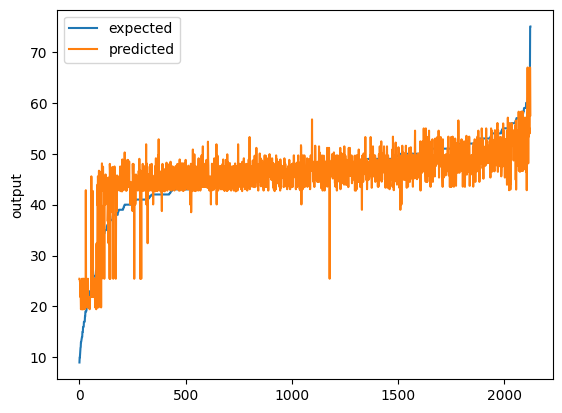

final score (MSE): 19.213558197021484
final score (RMSE): 4.383327484130859
final score (MAE): 3.1342403888702393
final score (R2): 0.6952664852142334


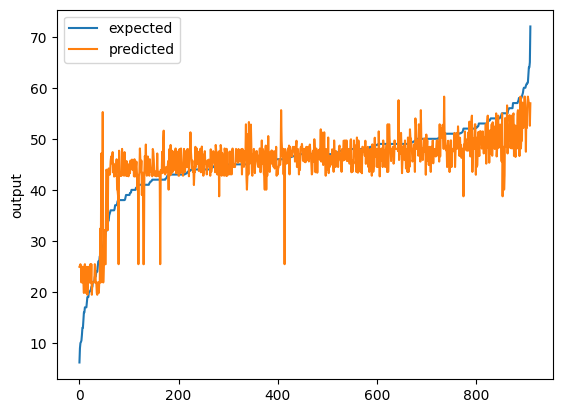

In [89]:
model_scores(model2, X_train, y_train)
model_scores(model2, X_test, y_test)

In [90]:
# fc with relu hidden layer, linear activation layer
optimizer = torch.optim.Adam(model2.parameters(), lr = 0.001)
fcnet2 = run(model2,optimizer)

Epoch:1, train_loss: 15.759613990783691, val_loss: 20.146126, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 112.01it/s]


avg r2 train scores 0.58059686
avg r2 test scores 0.6804756


Epoch:2, train_loss: 8.01664924621582, val_loss: 19.342041, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 113.59it/s]


avg r2 train scores 0.592571
avg r2 test scores 0.6932287


Epoch:3, train_loss: 17.0311279296875, val_loss: 20.057018, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 106.18it/s]


avg r2 train scores 0.55560154
avg r2 test scores 0.68188894


Epoch:4, train_loss: 19.35524559020996, val_loss: 19.653208, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 99.78it/s]


avg r2 train scores 0.56399363
avg r2 test scores 0.68829346


Epoch:5, train_loss: 19.738265991210938, val_loss: 20.199617, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 91.88it/s]


avg r2 train scores 0.5728973
avg r2 test scores 0.67962724


Epoch:6, train_loss: 23.194169998168945, val_loss: 19.530849, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 109.28it/s]


avg r2 train scores 0.57095754
avg r2 test scores 0.6902341


Epoch:7, train_loss: 24.239212036132812, val_loss: 19.728312, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 94.88it/s]


avg r2 train scores 0.5729379
avg r2 test scores 0.6871023


Epoch:8, train_loss: 8.891705513000488, val_loss: 19.649855, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 103.28it/s]


avg r2 train scores 0.56615245
avg r2 test scores 0.6883466


Epoch:9, train_loss: 17.71832275390625, val_loss: 19.805626, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 108.12it/s]


avg r2 train scores 0.5663505
avg r2 test scores 0.6858761


Epoch:10, train_loss: 8.807082176208496, val_loss: 20.399633, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 113.09it/s]


avg r2 train scores 0.58204997
avg r2 test scores 0.6764549


Epoch:11, train_loss: 12.344574928283691, val_loss: 20.081343, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 87.98it/s]


avg r2 train scores 0.57727194
avg r2 test scores 0.68150306


Epoch:12, train_loss: 20.65403938293457, val_loss: 20.277306, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 82.79it/s]


avg r2 train scores 0.5973513
avg r2 test scores 0.67839503


Epoch:13, train_loss: 7.362735748291016, val_loss: 19.680849, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 91.72it/s]


avg r2 train scores 0.5815201
avg r2 test scores 0.68785506


Epoch:14, train_loss: 24.192903518676758, val_loss: 19.580370, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 83.54it/s]


avg r2 train scores 0.5755388
avg r2 test scores 0.6894487


Epoch:15, train_loss: 6.608497142791748, val_loss: 19.620665, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 86.23it/s]


avg r2 train scores 0.5618036
avg r2 test scores 0.68880963


Epoch:16, train_loss: 10.123067855834961, val_loss: 19.951143, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 89.82it/s]


avg r2 train scores 0.5983682
avg r2 test scores 0.6835681


Epoch:17, train_loss: 18.159332275390625, val_loss: 19.691671, EStop: [15 / 50]: 100%|██████████| 67/67 [00:00<00:00, 83.27it/s]


avg r2 train scores 0.6090181
avg r2 test scores 0.6876834


Epoch:18, train_loss: 3.572293519973755, val_loss: 19.562290, EStop: [16 / 50]: 100%|██████████| 67/67 [00:00<00:00, 90.35it/s]


avg r2 train scores 0.605487
avg r2 test scores 0.6897355


Epoch:19, train_loss: 26.27104377746582, val_loss: 21.101643, EStop: [17 / 50]: 100%|██████████| 67/67 [00:00<00:00, 79.48it/s]


avg r2 train scores 0.60361475
avg r2 test scores 0.6653208


Epoch:20, train_loss: 22.253751754760742, val_loss: 19.859657, EStop: [18 / 50]: 100%|██████████| 67/67 [00:00<00:00, 85.14it/s]


avg r2 train scores 0.5873552
avg r2 test scores 0.68501914


Epoch:21, train_loss: 12.680564880371094, val_loss: 19.832294, EStop: [19 / 50]: 100%|██████████| 67/67 [00:00<00:00, 88.88it/s]


avg r2 train scores 0.57683355
avg r2 test scores 0.68545306


Epoch:22, train_loss: 10.550087928771973, val_loss: 20.349777, EStop: [20 / 50]: 100%|██████████| 67/67 [00:00<00:00, 100.46it/s]


avg r2 train scores 0.6009037
avg r2 test scores 0.6772456


Epoch:23, train_loss: 4.358611583709717, val_loss: 19.856524, EStop: [21 / 50]: 100%|██████████| 67/67 [00:00<00:00, 74.43it/s]


avg r2 train scores 0.58568233
avg r2 test scores 0.68506885


Epoch:24, train_loss: 24.871007919311523, val_loss: 19.900108, EStop: [22 / 50]: 100%|██████████| 67/67 [00:00<00:00, 76.19it/s]


avg r2 train scores 0.5851194
avg r2 test scores 0.68437755


Epoch:25, train_loss: 4.576961994171143, val_loss: 19.960342, EStop: [23 / 50]: 100%|██████████| 67/67 [00:00<00:00, 90.37it/s]


avg r2 train scores 0.5981969
avg r2 test scores 0.6834222


Epoch:26, train_loss: 21.84230613708496, val_loss: 20.206066, EStop: [24 / 50]: 100%|██████████| 67/67 [00:00<00:00, 75.78it/s]


avg r2 train scores 0.5974621
avg r2 test scores 0.67952496


Epoch:27, train_loss: 50.172821044921875, val_loss: 20.735432, EStop: [25 / 50]: 100%|██████████| 67/67 [00:00<00:00, 83.32it/s]


avg r2 train scores 0.59518015
avg r2 test scores 0.671129


Epoch:28, train_loss: 11.956408500671387, val_loss: 20.324430, EStop: [26 / 50]: 100%|██████████| 67/67 [00:00<00:00, 82.73it/s]


avg r2 train scores 0.5889362
avg r2 test scores 0.67764765


Epoch:29, train_loss: 33.847660064697266, val_loss: 19.537334, EStop: [27 / 50]: 100%|██████████| 67/67 [00:00<00:00, 83.97it/s]


avg r2 train scores 0.5804366
avg r2 test scores 0.69013125


Epoch:30, train_loss: 20.838300704956055, val_loss: 19.953199, EStop: [28 / 50]: 100%|██████████| 67/67 [00:00<00:00, 86.95it/s]


avg r2 train scores 0.583033
avg r2 test scores 0.68353546


Epoch:31, train_loss: 20.774431228637695, val_loss: 20.571434, EStop: [29 / 50]: 100%|██████████| 67/67 [00:00<00:00, 81.59it/s]


avg r2 train scores 0.58496445
avg r2 test scores 0.67373013


Epoch:32, train_loss: 7.201834201812744, val_loss: 20.147280, EStop: [30 / 50]: 100%|██████████| 67/67 [00:00<00:00, 84.18it/s]


avg r2 train scores 0.60758066
avg r2 test scores 0.68045735


Epoch:33, train_loss: 6.612070560455322, val_loss: 20.058695, EStop: [31 / 50]: 100%|██████████| 67/67 [00:00<00:00, 87.56it/s]


avg r2 train scores 0.5676066
avg r2 test scores 0.68186235


Epoch:34, train_loss: 30.893638610839844, val_loss: 19.545675, EStop: [32 / 50]: 100%|██████████| 67/67 [00:00<00:00, 88.62it/s]


avg r2 train scores 0.570252
avg r2 test scores 0.689999


Epoch:35, train_loss: 10.227694511413574, val_loss: 20.681400, EStop: [33 / 50]: 100%|██████████| 67/67 [00:00<00:00, 83.64it/s]


avg r2 train scores 0.575919
avg r2 test scores 0.671986


Epoch:36, train_loss: 23.050743103027344, val_loss: 20.061428, EStop: [34 / 50]: 100%|██████████| 67/67 [00:00<00:00, 81.20it/s]


avg r2 train scores 0.5997502
avg r2 test scores 0.68181896


Epoch:37, train_loss: 18.10642433166504, val_loss: 20.343868, EStop: [35 / 50]: 100%|██████████| 67/67 [00:00<00:00, 83.15it/s]


avg r2 train scores 0.5619865
avg r2 test scores 0.6773394


Epoch:38, train_loss: 11.691895484924316, val_loss: 19.707460, EStop: [36 / 50]: 100%|██████████| 67/67 [00:00<00:00, 92.62it/s]


avg r2 train scores 0.5864922
avg r2 test scores 0.687433


Epoch:39, train_loss: 30.28238868713379, val_loss: 20.499762, EStop: [37 / 50]: 100%|██████████| 67/67 [00:00<00:00, 89.50it/s]


avg r2 train scores 0.5892792
avg r2 test scores 0.6748668


Epoch:40, train_loss: 7.883780002593994, val_loss: 19.954939, EStop: [38 / 50]: 100%|██████████| 67/67 [00:00<00:00, 78.56it/s]


avg r2 train scores 0.5879783
avg r2 test scores 0.6835079


Epoch:41, train_loss: 14.328631401062012, val_loss: 20.091654, EStop: [39 / 50]: 100%|██████████| 67/67 [00:00<00:00, 81.01it/s]


avg r2 train scores 0.6058861
avg r2 test scores 0.6813396


Epoch:42, train_loss: 11.846026420593262, val_loss: 20.335823, EStop: [40 / 50]: 100%|██████████| 67/67 [00:00<00:00, 78.65it/s]


avg r2 train scores 0.57597476
avg r2 test scores 0.677467


Epoch:43, train_loss: 13.106019020080566, val_loss: 19.972425, EStop: [41 / 50]: 100%|██████████| 67/67 [00:00<00:00, 88.38it/s]


avg r2 train scores 0.589592
avg r2 test scores 0.6832306


Epoch:44, train_loss: 22.33989906311035, val_loss: 19.608406, EStop: [42 / 50]: 100%|██████████| 67/67 [00:00<00:00, 88.56it/s]


avg r2 train scores 0.60813105
avg r2 test scores 0.68900406


Epoch:45, train_loss: 13.57210922241211, val_loss: 21.030756, EStop: [43 / 50]: 100%|██████████| 67/67 [00:00<00:00, 79.69it/s]


avg r2 train scores 0.56639075
avg r2 test scores 0.6664451


Epoch:46, train_loss: 31.22584342956543, val_loss: 19.206028, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 84.50it/s]


avg r2 train scores 0.59742576
avg r2 test scores 0.69538593


Epoch:47, train_loss: 63.80984878540039, val_loss: 19.431868, EStop: [1 / 50]: 100%|██████████| 67/67 [00:00<00:00, 85.47it/s]


avg r2 train scores 0.60762024
avg r2 test scores 0.691804


Epoch:48, train_loss: 14.795683860778809, val_loss: 20.355639, EStop: [2 / 50]: 100%|██████████| 67/67 [00:00<00:00, 92.41it/s]


avg r2 train scores 0.59490085
avg r2 test scores 0.6771527


Epoch:49, train_loss: 11.660926818847656, val_loss: 19.538618, EStop: [3 / 50]: 100%|██████████| 67/67 [00:00<00:00, 84.91it/s]


avg r2 train scores 0.58626586
avg r2 test scores 0.6901109


Epoch:50, train_loss: 9.032812118530273, val_loss: 20.406109, EStop: [4 / 50]: 100%|██████████| 67/67 [00:00<00:00, 89.94it/s]


avg r2 train scores 0.5913358
avg r2 test scores 0.6763522


Epoch:51, train_loss: 18.0726261138916, val_loss: 19.826998, EStop: [5 / 50]: 100%|██████████| 67/67 [00:00<00:00, 90.41it/s]


avg r2 train scores 0.5968176
avg r2 test scores 0.6855371


Epoch:52, train_loss: 12.482001304626465, val_loss: 20.406643, EStop: [6 / 50]: 100%|██████████| 67/67 [00:00<00:00, 88.27it/s]


avg r2 train scores 0.60189927
avg r2 test scores 0.67634374


Epoch:53, train_loss: 15.188385963439941, val_loss: 20.070082, EStop: [7 / 50]: 100%|██████████| 67/67 [00:00<00:00, 86.76it/s]


avg r2 train scores 0.6097985
avg r2 test scores 0.68168175


Epoch:54, train_loss: 14.543098449707031, val_loss: 19.660812, EStop: [8 / 50]: 100%|██████████| 67/67 [00:00<00:00, 85.02it/s]


avg r2 train scores 0.606885
avg r2 test scores 0.6881729


Epoch:55, train_loss: 24.06822395324707, val_loss: 20.164904, EStop: [9 / 50]: 100%|██████████| 67/67 [00:00<00:00, 80.28it/s]


avg r2 train scores 0.5879675
avg r2 test scores 0.6801778


Epoch:56, train_loss: 14.34594440460205, val_loss: 20.588322, EStop: [10 / 50]: 100%|██████████| 67/67 [00:00<00:00, 89.82it/s]


avg r2 train scores 0.59473455
avg r2 test scores 0.6734623


Epoch:57, train_loss: 9.995088577270508, val_loss: 20.110640, EStop: [11 / 50]: 100%|██████████| 67/67 [00:00<00:00, 90.84it/s]


avg r2 train scores 0.6044063
avg r2 test scores 0.68103844


Epoch:58, train_loss: 19.566003799438477, val_loss: 20.176582, EStop: [12 / 50]: 100%|██████████| 67/67 [00:00<00:00, 93.03it/s]


avg r2 train scores 0.59463435
avg r2 test scores 0.67999256


Epoch:59, train_loss: 11.38187026977539, val_loss: 20.040152, EStop: [13 / 50]: 100%|██████████| 67/67 [00:00<00:00, 83.90it/s]


avg r2 train scores 0.60093826
avg r2 test scores 0.68215644


Epoch:60, train_loss: 11.170390129089355, val_loss: 20.028639, EStop: [14 / 50]: 100%|██████████| 67/67 [00:00<00:00, 73.50it/s]


avg r2 train scores 0.5920051
avg r2 test scores 0.682339


Epoch:61, train_loss: 3.9615840911865234, val_loss: 20.895247, EStop: [15 / 50]: 100%|██████████| 67/67 [00:00<00:00, 84.41it/s]


avg r2 train scores 0.6002657
avg r2 test scores 0.6685943


Epoch:62, train_loss: 9.438749313354492, val_loss: 20.024805, EStop: [16 / 50]: 100%|██████████| 67/67 [00:00<00:00, 88.44it/s]


avg r2 train scores 0.6158469
avg r2 test scores 0.6823998


Epoch:63, train_loss: 15.941654205322266, val_loss: 19.760010, EStop: [17 / 50]: 100%|██████████| 67/67 [00:00<00:00, 81.72it/s]


avg r2 train scores 0.58587253
avg r2 test scores 0.68659955


Epoch:64, train_loss: 29.20408821105957, val_loss: 19.971632, EStop: [18 / 50]: 100%|██████████| 67/67 [00:00<00:00, 77.58it/s]


avg r2 train scores 0.6120645
avg r2 test scores 0.68324316


Epoch:65, train_loss: 31.881139755249023, val_loss: 20.216269, EStop: [19 / 50]: 100%|██████████| 67/67 [00:00<00:00, 94.43it/s]


avg r2 train scores 0.58423257
avg r2 test scores 0.67936313


Epoch:66, train_loss: 44.0886344909668, val_loss: 20.848286, EStop: [20 / 50]: 100%|██████████| 67/67 [00:00<00:00, 88.02it/s]


avg r2 train scores 0.56935006
avg r2 test scores 0.6693391


Epoch:67, train_loss: 16.074344635009766, val_loss: 19.867876, EStop: [21 / 50]: 100%|██████████| 67/67 [00:00<00:00, 92.30it/s]


avg r2 train scores 0.6077528
avg r2 test scores 0.6848888


Epoch:68, train_loss: 19.513383865356445, val_loss: 19.839863, EStop: [22 / 50]: 100%|██████████| 67/67 [00:00<00:00, 91.09it/s]


avg r2 train scores 0.5971422
avg r2 test scores 0.685333


Epoch:69, train_loss: 14.260971069335938, val_loss: 20.189735, EStop: [23 / 50]: 100%|██████████| 67/67 [00:00<00:00, 90.74it/s]


avg r2 train scores 0.5951041
avg r2 test scores 0.67978394


Epoch:70, train_loss: 23.53721046447754, val_loss: 20.020994, EStop: [24 / 50]: 100%|██████████| 67/67 [00:00<00:00, 88.62it/s]


avg r2 train scores 0.58593327
avg r2 test scores 0.6824603


Epoch:71, train_loss: 19.414167404174805, val_loss: 19.820606, EStop: [25 / 50]: 100%|██████████| 67/67 [00:00<00:00, 89.82it/s]


avg r2 train scores 0.5996119
avg r2 test scores 0.6856385


Epoch:72, train_loss: 7.325115203857422, val_loss: 19.976652, EStop: [26 / 50]: 100%|██████████| 67/67 [00:00<00:00, 94.05it/s]


avg r2 train scores 0.5931302
avg r2 test scores 0.6831635


Epoch:73, train_loss: 12.979842185974121, val_loss: 19.813396, EStop: [27 / 50]: 100%|██████████| 67/67 [00:00<00:00, 92.55it/s]


avg r2 train scores 0.6011056
avg r2 test scores 0.68575287


Epoch:74, train_loss: 13.382647514343262, val_loss: 19.719629, EStop: [28 / 50]: 100%|██████████| 67/67 [00:00<00:00, 79.02it/s]


avg r2 train scores 0.61246234
avg r2 test scores 0.68724


Epoch:75, train_loss: 10.442349433898926, val_loss: 20.145256, EStop: [29 / 50]: 100%|██████████| 67/67 [00:00<00:00, 82.89it/s]


avg r2 train scores 0.5987882
avg r2 test scores 0.6804894


Epoch:76, train_loss: 18.390762329101562, val_loss: 20.524837, EStop: [30 / 50]: 100%|██████████| 67/67 [00:00<00:00, 90.52it/s]


avg r2 train scores 0.59489495
avg r2 test scores 0.6744691


Epoch:77, train_loss: 9.794116973876953, val_loss: 19.623831, EStop: [31 / 50]: 100%|██████████| 67/67 [00:00<00:00, 76.62it/s]


avg r2 train scores 0.5944907
avg r2 test scores 0.6887594


Epoch:78, train_loss: 16.318429946899414, val_loss: 19.713001, EStop: [32 / 50]: 100%|██████████| 67/67 [00:00<00:00, 73.64it/s]


avg r2 train scores 0.6020301
avg r2 test scores 0.68734515


Epoch:79, train_loss: 20.423385620117188, val_loss: 20.063875, EStop: [33 / 50]: 100%|██████████| 67/67 [00:00<00:00, 74.28it/s]


avg r2 train scores 0.6050554
avg r2 test scores 0.68178016


Epoch:80, train_loss: 9.16419506072998, val_loss: 20.093298, EStop: [34 / 50]: 100%|██████████| 67/67 [00:00<00:00, 83.01it/s]


avg r2 train scores 0.6121972
avg r2 test scores 0.6813135


Epoch:81, train_loss: 23.827451705932617, val_loss: 20.194965, EStop: [35 / 50]: 100%|██████████| 67/67 [00:00<00:00, 83.22it/s]


avg r2 train scores 0.62011653
avg r2 test scores 0.67970103


Epoch:82, train_loss: 6.184516906738281, val_loss: 20.082613, EStop: [36 / 50]: 100%|██████████| 67/67 [00:00<00:00, 85.74it/s]


avg r2 train scores 0.58294594
avg r2 test scores 0.681483


Epoch:83, train_loss: 10.893153190612793, val_loss: 19.692675, EStop: [37 / 50]: 100%|██████████| 67/67 [00:00<00:00, 82.08it/s]


avg r2 train scores 0.6055295
avg r2 test scores 0.6876675


Epoch:84, train_loss: 4.653239727020264, val_loss: 19.985456, EStop: [38 / 50]: 100%|██████████| 67/67 [00:00<00:00, 85.67it/s]


avg r2 train scores 0.5945046
avg r2 test scores 0.6830239


Epoch:85, train_loss: 33.000308990478516, val_loss: 19.590912, EStop: [39 / 50]: 100%|██████████| 67/67 [00:00<00:00, 86.64it/s]


avg r2 train scores 0.62196064
avg r2 test scores 0.6892815


Epoch:86, train_loss: 9.831256866455078, val_loss: 20.049147, EStop: [40 / 50]: 100%|██████████| 67/67 [00:00<00:00, 87.46it/s]


avg r2 train scores 0.6061733
avg r2 test scores 0.68201375


Epoch:87, train_loss: 18.883590698242188, val_loss: 20.481516, EStop: [41 / 50]: 100%|██████████| 67/67 [00:00<00:00, 75.67it/s]


avg r2 train scores 0.63191795
avg r2 test scores 0.67515624


Epoch:88, train_loss: 17.998109817504883, val_loss: 20.022770, EStop: [42 / 50]: 100%|██████████| 67/67 [00:00<00:00, 74.06it/s]


avg r2 train scores 0.6183977
avg r2 test scores 0.68243206


Epoch:89, train_loss: 6.751591205596924, val_loss: 20.282270, EStop: [43 / 50]: 100%|██████████| 67/67 [00:00<00:00, 80.06it/s]


avg r2 train scores 0.58648604
avg r2 test scores 0.67831635


Epoch:90, train_loss: 18.198774337768555, val_loss: 19.931828, EStop: [44 / 50]: 100%|██████████| 67/67 [00:00<00:00, 76.21it/s]


avg r2 train scores 0.6061202
avg r2 test scores 0.6838745


Epoch:91, train_loss: 14.597893714904785, val_loss: 19.653820, EStop: [45 / 50]: 100%|██████████| 67/67 [00:00<00:00, 74.87it/s]


avg r2 train scores 0.61370784
avg r2 test scores 0.68828374


Epoch:92, train_loss: 11.825520515441895, val_loss: 20.096596, EStop: [46 / 50]: 100%|██████████| 67/67 [00:00<00:00, 81.85it/s]


avg r2 train scores 0.612463
avg r2 test scores 0.6812612


Epoch:93, train_loss: 13.215415954589844, val_loss: 19.578533, EStop: [47 / 50]: 100%|██████████| 67/67 [00:00<00:00, 81.87it/s]


avg r2 train scores 0.5988674
avg r2 test scores 0.68947786


Epoch:94, train_loss: 19.768186569213867, val_loss: 20.231348, EStop: [48 / 50]: 100%|██████████| 67/67 [00:00<00:00, 78.50it/s]


avg r2 train scores 0.5951557
avg r2 test scores 0.679124


Epoch:95, train_loss: 29.552221298217773, val_loss: 20.239204, EStop: [49 / 50]: 100%|██████████| 67/67 [00:00<00:00, 73.67it/s]


avg r2 train scores 0.5949475
avg r2 test scores 0.67899936


Epoch:96, train_loss: 36.118408203125, val_loss: 19.895367, EStop: [Early stopping triggered after 50 epochs.]: 100%|██████████| 67/67 [00:00<00:00, 72.74it/s]

avg r2 train scores 0.6211508
avg r2 test scores 0.6844528


final score (MSE): 16.920297622680664
final score (RMSE): 4.113429069519043
final score (MAE): 2.9901797771453857
final score (R2): 0.6870921850204468


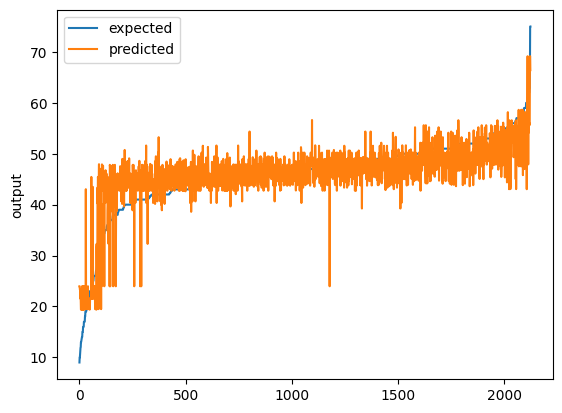

final score (MSE): 19.20602798461914
final score (RMSE): 4.3824687004089355
final score (MAE): 3.113910675048828
final score (R2): 0.6953859329223633


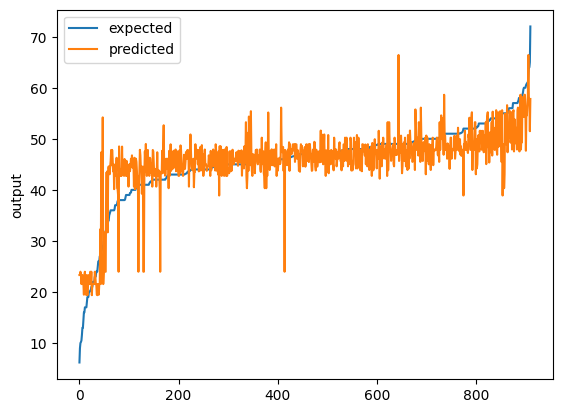

In [91]:
model_scores(model2, X_train, y_train)
model_scores(model2, X_test, y_test)

In [94]:
# fc with relu hidden layer, linear activation layer
model3_drop = FCNet_Dropout(X_train.shape[1],1).to(device)
optimizer = torch.optim.SGD(model2.parameters(), lr = 0.001)
drop1 = run(model3_drop,optimizer)

Epoch:1, train_loss: 2121.42578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 115.61it/s]


avg r2 train scores -49.97619
avg r2 test scores -33.114845


Epoch:2, train_loss: 2168.169189453125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 70.65it/s]


avg r2 train scores -51.70089
avg r2 test scores -33.114845


Epoch:3, train_loss: 2045.1942138671875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 88.82it/s]


avg r2 train scores -52.27836
avg r2 test scores -33.114845


Epoch:4, train_loss: 1918.4417724609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 99.40it/s]


avg r2 train scores -53.48168
avg r2 test scores -33.114845


Epoch:5, train_loss: 1833.3507080078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 122.98it/s]


avg r2 train scores -50.372158
avg r2 test scores -33.114845


Epoch:6, train_loss: 2166.4541015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 130.28it/s]


avg r2 train scores -49.848576
avg r2 test scores -33.114845


Epoch:7, train_loss: 2023.7774658203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 122.94it/s]


avg r2 train scores -53.014675
avg r2 test scores -33.114845


Epoch:8, train_loss: 1977.77734375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 125.29it/s]


avg r2 train scores -54.778114
avg r2 test scores -33.114845


Epoch:9, train_loss: 2033.2105712890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 88.27it/s]


avg r2 train scores -48.39332
avg r2 test scores -33.114845


Epoch:10, train_loss: 2337.8974609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 110.37it/s]


avg r2 train scores -49.01279
avg r2 test scores -33.114845


Epoch:11, train_loss: 2059.416748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 69.74it/s]


avg r2 train scores -53.004387
avg r2 test scores -33.114845


Epoch:12, train_loss: 2444.083251953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 75.45it/s]


avg r2 train scores -58.76623
avg r2 test scores -33.114845


Epoch:13, train_loss: 2418.434326171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 95.95it/s]


avg r2 train scores -53.82768
avg r2 test scores -33.114845


Epoch:14, train_loss: 2022.6607666015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:01<00:00, 55.95it/s]


avg r2 train scores -54.3311
avg r2 test scores -33.114845


Epoch:15, train_loss: 2442.774169921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.41it/s]


avg r2 train scores -52.27178
avg r2 test scores -33.114845


Epoch:16, train_loss: 2233.73583984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 179.29it/s]


avg r2 train scores -56.82313
avg r2 test scores -33.114845


Epoch:17, train_loss: 2248.171630859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.50it/s]


avg r2 train scores -55.261887
avg r2 test scores -33.114845


Epoch:18, train_loss: 2247.9228515625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.42it/s]


avg r2 train scores -52.815323
avg r2 test scores -33.114845


Epoch:19, train_loss: 2104.59326171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.19it/s]


avg r2 train scores -51.54559
avg r2 test scores -33.114845


Epoch:20, train_loss: 1946.6431884765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.07it/s]


avg r2 train scores -51.13646
avg r2 test scores -33.114845


Epoch:21, train_loss: 2178.78662109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 177.87it/s]


avg r2 train scores -53.58345
avg r2 test scores -33.114845


Epoch:22, train_loss: 2294.403076171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.13it/s]


avg r2 train scores -54.25753
avg r2 test scores -33.114845


Epoch:23, train_loss: 2013.1429443359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.08it/s]


avg r2 train scores -52.824688
avg r2 test scores -33.114845


Epoch:24, train_loss: 2338.928955078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.17it/s]


avg r2 train scores -52.603603
avg r2 test scores -33.114845


Epoch:25, train_loss: 2081.916748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.57it/s]


avg r2 train scores -52.61487
avg r2 test scores -33.114845


Epoch:26, train_loss: 1995.1300048828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.16it/s]


avg r2 train scores -52.700535
avg r2 test scores -33.114845


Epoch:27, train_loss: 2222.789306640625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 177.88it/s]


avg r2 train scores -51.40628
avg r2 test scores -33.114845


Epoch:28, train_loss: 2241.166748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.94it/s]


avg r2 train scores -53.658493
avg r2 test scores -33.114845


Epoch:29, train_loss: 2111.379150390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 176.71it/s]


avg r2 train scores -53.331924
avg r2 test scores -33.114845


Epoch:30, train_loss: 2186.675048828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 177.56it/s]


avg r2 train scores -51.449074
avg r2 test scores -33.114845


Epoch:31, train_loss: 2473.701416015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 174.85it/s]


avg r2 train scores -57.50739
avg r2 test scores -33.114845


Epoch:32, train_loss: 2472.865478515625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.74it/s]


avg r2 train scores -53.717754
avg r2 test scores -33.114845


Epoch:33, train_loss: 1780.9964599609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 179.79it/s]


avg r2 train scores -53.885612
avg r2 test scores -33.114845


Epoch:34, train_loss: 2096.8798828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.22it/s]


avg r2 train scores -51.255333
avg r2 test scores -33.114845


Epoch:35, train_loss: 2022.86328125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 174.79it/s]


avg r2 train scores -56.919476
avg r2 test scores -33.114845


Epoch:36, train_loss: 2180.974853515625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.53it/s]


avg r2 train scores -57.55208
avg r2 test scores -33.114845


Epoch:37, train_loss: 2156.16064453125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.43it/s]


avg r2 train scores -52.772778
avg r2 test scores -33.114845


Epoch:38, train_loss: 2045.8382568359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.39it/s]


avg r2 train scores -50.1061
avg r2 test scores -33.114845


Epoch:39, train_loss: 2223.908203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.88it/s]


avg r2 train scores -53.470257
avg r2 test scores -33.114845


Epoch:40, train_loss: 2114.1904296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.04it/s]


avg r2 train scores -56.02891
avg r2 test scores -33.114845


Epoch:41, train_loss: 1833.77001953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.53it/s]


avg r2 train scores -52.24817
avg r2 test scores -33.114845


Epoch:42, train_loss: 2440.89990234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.14it/s]


avg r2 train scores -51.54671
avg r2 test scores -33.114845


Epoch:43, train_loss: 2378.25, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.35it/s]


avg r2 train scores -53.06373
avg r2 test scores -33.114845


Epoch:44, train_loss: 2196.854248046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.94it/s]


avg r2 train scores -53.86169
avg r2 test scores -33.114845


Epoch:45, train_loss: 1937.7799072265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.12it/s]


avg r2 train scores -51.858807
avg r2 test scores -33.114845


Epoch:46, train_loss: 2136.749267578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.16it/s]


avg r2 train scores -58.09633
avg r2 test scores -33.114845


Epoch:47, train_loss: 2246.546630859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.00it/s]


avg r2 train scores -54.077923
avg r2 test scores -33.114845


Epoch:48, train_loss: 2347.486572265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.66it/s]


avg r2 train scores -53.486423
avg r2 test scores -33.114845


Epoch:49, train_loss: 2168.104248046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.90it/s]


avg r2 train scores -49.606773
avg r2 test scores -33.114845


Epoch:50, train_loss: 2295.268310546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.27it/s]


avg r2 train scores -53.745316
avg r2 test scores -33.114845


Epoch:51, train_loss: 2099.691650390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.81it/s]


avg r2 train scores -55.93667
avg r2 test scores -33.114845


Epoch:52, train_loss: 2111.50830078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.03it/s]


avg r2 train scores -51.560703
avg r2 test scores -33.114845


Epoch:53, train_loss: 2056.003173828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.21it/s]


avg r2 train scores -54.53386
avg r2 test scores -33.114845


Epoch:54, train_loss: 1994.31005859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.68it/s]


avg r2 train scores -53.98297
avg r2 test scores -33.114845


Epoch:55, train_loss: 2018.8997802734375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.43it/s]


avg r2 train scores -56.306164
avg r2 test scores -33.114845


Epoch:56, train_loss: 1981.2100830078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.29it/s]


avg r2 train scores -53.290775
avg r2 test scores -33.114845


Epoch:57, train_loss: 2365.524169921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.88it/s]


avg r2 train scores -57.607857
avg r2 test scores -33.114845


Epoch:58, train_loss: 2157.026611328125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.02it/s]


avg r2 train scores -49.604794
avg r2 test scores -33.114845


Epoch:59, train_loss: 2316.50244140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.83it/s]


avg r2 train scores -56.015648
avg r2 test scores -33.114845


Epoch:60, train_loss: 2179.262451171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.11it/s]


avg r2 train scores -52.27789
avg r2 test scores -33.114845


Epoch:61, train_loss: 2078.76416015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.87it/s]


avg r2 train scores -53.30539
avg r2 test scores -33.114845


Epoch:62, train_loss: 2106.67578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.75it/s]


avg r2 train scores -58.342033
avg r2 test scores -33.114845


Epoch:63, train_loss: 2110.975830078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.93it/s]


avg r2 train scores -53.1626
avg r2 test scores -33.114845


Epoch:64, train_loss: 2155.174560546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.62it/s]


avg r2 train scores -51.560146
avg r2 test scores -33.114845


Epoch:65, train_loss: 2349.208251953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.96it/s]


avg r2 train scores -54.622658
avg r2 test scores -33.114845


Epoch:66, train_loss: 2147.107666015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.98it/s]


avg r2 train scores -52.268616
avg r2 test scores -33.114845


Epoch:67, train_loss: 1867.96728515625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.69it/s]


avg r2 train scores -53.964653
avg r2 test scores -33.114845


Epoch:68, train_loss: 2070.09814453125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.19it/s]


avg r2 train scores -55.144203
avg r2 test scores -33.114845


Epoch:69, train_loss: 2413.823974609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.08it/s]


avg r2 train scores -56.86739
avg r2 test scores -33.114845


Epoch:70, train_loss: 2487.130126953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.98it/s]


avg r2 train scores -54.401657
avg r2 test scores -33.114845


Epoch:71, train_loss: 2257.9267578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.80it/s]


avg r2 train scores -55.569782
avg r2 test scores -33.114845


Epoch:72, train_loss: 2105.770751953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.45it/s]


avg r2 train scores -56.273018
avg r2 test scores -33.114845


Epoch:73, train_loss: 2105.7001953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.87it/s]


avg r2 train scores -60.180202
avg r2 test scores -33.114845


Epoch:74, train_loss: 2467.066650390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.99it/s]


avg r2 train scores -54.017605
avg r2 test scores -33.114845


Epoch:75, train_loss: 2063.800048828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.54it/s]


avg r2 train scores -54.122654
avg r2 test scores -33.114845


Epoch:76, train_loss: 1838.0611572265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 132.11it/s]


avg r2 train scores -52.192467
avg r2 test scores -33.114845


Epoch:77, train_loss: 2318.281494140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 130.18it/s]


avg r2 train scores -64.43854
avg r2 test scores -33.114845


Epoch:78, train_loss: 2415.675048828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.75it/s]


avg r2 train scores -59.10851
avg r2 test scores -33.114845


Epoch:79, train_loss: 2043.8841552734375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 174.00it/s]


avg r2 train scores -54.75085
avg r2 test scores -33.114845


Epoch:80, train_loss: 2254.025146484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.47it/s]


avg r2 train scores -56.15549
avg r2 test scores -33.114845


Epoch:81, train_loss: 2023.1619873046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.26it/s]


avg r2 train scores -52.17505
avg r2 test scores -33.114845


Epoch:82, train_loss: 2014.7125244140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.76it/s]


avg r2 train scores -52.50191
avg r2 test scores -33.114845


Epoch:83, train_loss: 2131.327392578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.17it/s]


avg r2 train scores -52.73471
avg r2 test scores -33.114845


Epoch:84, train_loss: 2301.8583984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.50it/s]


avg r2 train scores -60.281105
avg r2 test scores -33.114845


Epoch:85, train_loss: 2106.7109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.59it/s]


avg r2 train scores -57.530632
avg r2 test scores -33.114845


Epoch:86, train_loss: 1912.3250732421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.70it/s]


avg r2 train scores -53.868217
avg r2 test scores -33.114845


Epoch:87, train_loss: 2159.512451171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.41it/s]


avg r2 train scores -55.99741
avg r2 test scores -33.114845


Epoch:88, train_loss: 1887.83837890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.93it/s]


avg r2 train scores -53.034
avg r2 test scores -33.114845


Epoch:89, train_loss: 1949.619140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.93it/s]


avg r2 train scores -54.134907
avg r2 test scores -33.114845


Epoch:90, train_loss: 1982.6217041015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.53it/s]


avg r2 train scores -55.19297
avg r2 test scores -33.114845


Epoch:91, train_loss: 2068.648193359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.30it/s]


avg r2 train scores -54.851097
avg r2 test scores -33.114845


Epoch:92, train_loss: 2226.938232421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.59it/s]


avg r2 train scores -59.201538
avg r2 test scores -33.114845


Epoch:93, train_loss: 2013.26513671875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.08it/s]


avg r2 train scores -51.67002
avg r2 test scores -33.114845


Epoch:94, train_loss: 2388.989990234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.94it/s]


avg r2 train scores -51.849358
avg r2 test scores -33.114845


Epoch:95, train_loss: 2051.53662109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.88it/s]


avg r2 train scores -49.159798
avg r2 test scores -33.114845


Epoch:96, train_loss: 2294.390869140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.37it/s]


avg r2 train scores -57.96944
avg r2 test scores -33.114845


Epoch:97, train_loss: 2254.800048828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.07it/s]


avg r2 train scores -52.959713
avg r2 test scores -33.114845


Epoch:98, train_loss: 2191.278564453125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.99it/s]


avg r2 train scores -54.541885
avg r2 test scores -33.114845


Epoch:99, train_loss: 2168.696533203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.41it/s]


avg r2 train scores -52.531414
avg r2 test scores -33.114845


Epoch:100, train_loss: 2253.9833984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.35it/s]


avg r2 train scores -54.188915
avg r2 test scores -33.114845


Epoch:101, train_loss: 2429.168701171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.50it/s]


avg r2 train scores -53.719013
avg r2 test scores -33.114845


Epoch:102, train_loss: 1742.2310791015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.81it/s]


avg r2 train scores -51.923523
avg r2 test scores -33.114845


Epoch:103, train_loss: 2542.54833984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.40it/s]


avg r2 train scores -58.57459
avg r2 test scores -33.114845


Epoch:104, train_loss: 2115.481689453125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.81it/s]


avg r2 train scores -55.848732
avg r2 test scores -33.114845


Epoch:105, train_loss: 2284.02490234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.96it/s]


avg r2 train scores -55.464443
avg r2 test scores -33.114845


Epoch:106, train_loss: 2299.1650390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.55it/s]


avg r2 train scores -60.02893
avg r2 test scores -33.114845


Epoch:107, train_loss: 2104.593994140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.67it/s]


avg r2 train scores -52.07714
avg r2 test scores -33.114845


Epoch:108, train_loss: 2138.458251953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 134.82it/s]


avg r2 train scores -53.1965
avg r2 test scores -33.114845


Epoch:109, train_loss: 2122.067626953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 131.92it/s]


avg r2 train scores -50.46016
avg r2 test scores -33.114845


Epoch:110, train_loss: 2064.390869140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.76it/s]


avg r2 train scores -53.924614
avg r2 test scores -33.114845


Epoch:111, train_loss: 2093.375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.16it/s]


avg r2 train scores -55.651516
avg r2 test scores -33.114845


Epoch:112, train_loss: 2084.982177734375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.64it/s]


avg r2 train scores -54.324245
avg r2 test scores -33.114845


Epoch:113, train_loss: 2368.424072265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 133.98it/s]


avg r2 train scores -52.285767
avg r2 test scores -33.114845


Epoch:114, train_loss: 1882.994140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.84it/s]


avg r2 train scores -53.87075
avg r2 test scores -33.114845


Epoch:115, train_loss: 1954.9649658203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.04it/s]


avg r2 train scores -48.39784
avg r2 test scores -33.114845


Epoch:116, train_loss: 2238.36083984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.08it/s]


avg r2 train scores -54.612175
avg r2 test scores -33.114845


Epoch:117, train_loss: 1961.4908447265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.22it/s]


avg r2 train scores -54.350937
avg r2 test scores -33.114845


Epoch:118, train_loss: 1922.30615234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.18it/s]


avg r2 train scores -55.807747
avg r2 test scores -33.114845


Epoch:119, train_loss: 2423.4892578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.20it/s]


avg r2 train scores -53.236343
avg r2 test scores -33.114845


Epoch:120, train_loss: 2187.521728515625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.29it/s]


avg r2 train scores -53.38985
avg r2 test scores -33.114845


Epoch:121, train_loss: 2454.415283203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.77it/s]


avg r2 train scores -50.713783
avg r2 test scores -33.114845


Epoch:122, train_loss: 2104.288330078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.16it/s]


avg r2 train scores -59.4064
avg r2 test scores -33.114845


Epoch:123, train_loss: 1714.46826171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.17it/s]


avg r2 train scores -55.544956
avg r2 test scores -33.114845


Epoch:124, train_loss: 2400.308349609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.62it/s]


avg r2 train scores -54.283363
avg r2 test scores -33.114845


Epoch:125, train_loss: 2288.440673828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.25it/s]


avg r2 train scores -56.77443
avg r2 test scores -33.114845


Epoch:126, train_loss: 2384.469482421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.46it/s]


avg r2 train scores -54.013214
avg r2 test scores -33.114845


Epoch:127, train_loss: 2213.533447265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.54it/s]


avg r2 train scores -53.23151
avg r2 test scores -33.114845


Epoch:128, train_loss: 2111.918212890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.14it/s]


avg r2 train scores -52.271194
avg r2 test scores -33.114845


Epoch:129, train_loss: 2434.403564453125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.37it/s]


avg r2 train scores -50.96646
avg r2 test scores -33.114845


Epoch:130, train_loss: 2100.0283203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.10it/s]


avg r2 train scores -53.12708
avg r2 test scores -33.114845


Epoch:131, train_loss: 2250.130126953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.97it/s]


avg r2 train scores -49.9666
avg r2 test scores -33.114845


Epoch:132, train_loss: 2284.416748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.70it/s]


avg r2 train scores -60.252808
avg r2 test scores -33.114845


Epoch:133, train_loss: 2340.870849609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:01<00:00, 54.07it/s]


avg r2 train scores -56.629482
avg r2 test scores -33.114845


Epoch:134, train_loss: 2356.25, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 96.58it/s] 


avg r2 train scores -58.493954
avg r2 test scores -33.114845


Epoch:135, train_loss: 2068.807373046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 82.39it/s] 


avg r2 train scores -54.7701
avg r2 test scores -33.114845


Epoch:136, train_loss: 2167.334228515625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 67.23it/s]


avg r2 train scores -55.90388
avg r2 test scores -33.114845


Epoch:137, train_loss: 2143.544189453125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.58it/s]


avg r2 train scores -51.71942
avg r2 test scores -33.114845


Epoch:138, train_loss: 2092.619384765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.82it/s]


avg r2 train scores -51.32209
avg r2 test scores -33.114845


Epoch:139, train_loss: 2343.89990234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.96it/s]


avg r2 train scores -53.954998
avg r2 test scores -33.114845


Epoch:140, train_loss: 2181.984130859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.81it/s]


avg r2 train scores -50.707993
avg r2 test scores -33.114845


Epoch:141, train_loss: 2278.071533203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.42it/s]


avg r2 train scores -54.576916
avg r2 test scores -33.114845


Epoch:142, train_loss: 2399.304931640625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.14it/s]


avg r2 train scores -54.12395
avg r2 test scores -33.114845


Epoch:143, train_loss: 2354.854248046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.94it/s]


avg r2 train scores -56.587185
avg r2 test scores -33.114845


Epoch:144, train_loss: 2265.503662109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.05it/s]


avg r2 train scores -49.69271
avg r2 test scores -33.114845


Epoch:145, train_loss: 2090.454345703125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.48it/s]


avg r2 train scores -54.33541
avg r2 test scores -33.114845


Epoch:146, train_loss: 2395.42724609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.71it/s]


avg r2 train scores -51.64961
avg r2 test scores -33.114845


Epoch:147, train_loss: 1929.0040283203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.75it/s]


avg r2 train scores -52.089832
avg r2 test scores -33.114845


Epoch:148, train_loss: 2319.444091796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.66it/s]


avg r2 train scores -55.56628
avg r2 test scores -33.114845


Epoch:149, train_loss: 1801.57421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.05it/s]


avg r2 train scores -58.31589
avg r2 test scores -33.114845


Epoch:150, train_loss: 2416.607421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.45it/s]


avg r2 train scores -53.88726
avg r2 test scores -33.114845


Epoch:151, train_loss: 2505.32421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.64it/s]


avg r2 train scores -60.26347
avg r2 test scores -33.114845


Epoch:152, train_loss: 2071.260986328125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.23it/s]


avg r2 train scores -50.594864
avg r2 test scores -33.114845


Epoch:153, train_loss: 2094.364990234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.79it/s]


avg r2 train scores -54.316307
avg r2 test scores -33.114845


Epoch:154, train_loss: 2388.693115234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.32it/s]


avg r2 train scores -52.24251
avg r2 test scores -33.114845


Epoch:155, train_loss: 2727.134033203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.26it/s]


avg r2 train scores -53.18836
avg r2 test scores -33.114845


Epoch:156, train_loss: 2343.615966796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.39it/s]


avg r2 train scores -51.534966
avg r2 test scores -33.114845


Epoch:157, train_loss: 2387.834228515625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.33it/s]


avg r2 train scores -50.04883
avg r2 test scores -33.114845


Epoch:158, train_loss: 2330.25, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.85it/s]


avg r2 train scores -51.342506
avg r2 test scores -33.114845


Epoch:159, train_loss: 2296.68505859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.88it/s]


avg r2 train scores -54.20648
avg r2 test scores -33.114845


Epoch:160, train_loss: 2104.354248046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.89it/s]


avg r2 train scores -53.47844
avg r2 test scores -33.114845


Epoch:161, train_loss: 2225.247314453125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.79it/s]


avg r2 train scores -56.94906
avg r2 test scores -33.114845


Epoch:162, train_loss: 2163.7822265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.50it/s]


avg r2 train scores -52.048077
avg r2 test scores -33.114845


Epoch:163, train_loss: 1788.6707763671875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.96it/s]


avg r2 train scores -55.19791
avg r2 test scores -33.114845


Epoch:164, train_loss: 2401.755126953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.78it/s]


avg r2 train scores -54.56857
avg r2 test scores -33.114845


Epoch:165, train_loss: 2331.915283203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.41it/s]


avg r2 train scores -57.2122
avg r2 test scores -33.114845


Epoch:166, train_loss: 2017.55419921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.39it/s]


avg r2 train scores -52.87021
avg r2 test scores -33.114845


Epoch:167, train_loss: 1937.953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.96it/s]


avg r2 train scores -54.18184
avg r2 test scores -33.114845


Epoch:168, train_loss: 2086.5908203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.49it/s]


avg r2 train scores -52.38984
avg r2 test scores -33.114845


Epoch:169, train_loss: 1983.3126220703125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.24it/s]


avg r2 train scores -57.544712
avg r2 test scores -33.114845


Epoch:170, train_loss: 2020.9326171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.41it/s]


avg r2 train scores -52.74004
avg r2 test scores -33.114845


Epoch:171, train_loss: 2035.1175537109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.27it/s]


avg r2 train scores -50.504253
avg r2 test scores -33.114845


Epoch:172, train_loss: 2165.017578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.27it/s]


avg r2 train scores -56.790024
avg r2 test scores -33.114845


Epoch:173, train_loss: 2179.760009765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.48it/s]


avg r2 train scores -54.13569
avg r2 test scores -33.114845


Epoch:174, train_loss: 2464.9375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.19it/s]


avg r2 train scores -50.998604
avg r2 test scores -33.114845


Epoch:175, train_loss: 2050.506591796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.82it/s]


avg r2 train scores -53.079453
avg r2 test scores -33.114845


Epoch:176, train_loss: 2049.78515625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.10it/s]


avg r2 train scores -51.34613
avg r2 test scores -33.114845


Epoch:177, train_loss: 2211.520751953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.64it/s]


avg r2 train scores -54.036278
avg r2 test scores -33.114845


Epoch:178, train_loss: 2337.44677734375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.10it/s]


avg r2 train scores -54.391247
avg r2 test scores -33.114845


Epoch:179, train_loss: 2224.220947265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.67it/s]


avg r2 train scores -54.271626
avg r2 test scores -33.114845


Epoch:180, train_loss: 2157.0966796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 123.05it/s]


avg r2 train scores -53.97773
avg r2 test scores -33.114845


Epoch:181, train_loss: 1894.4632568359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.21it/s]


avg r2 train scores -53.82428
avg r2 test scores -33.114845


Epoch:182, train_loss: 2068.674072265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.75it/s]


avg r2 train scores -50.09772
avg r2 test scores -33.114845


Epoch:183, train_loss: 2033.8160400390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.05it/s]


avg r2 train scores -50.61536
avg r2 test scores -33.114845


Epoch:184, train_loss: 2167.099365234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.34it/s]


avg r2 train scores -55.057114
avg r2 test scores -33.114845


Epoch:185, train_loss: 2098.573486328125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.20it/s]


avg r2 train scores -53.5373
avg r2 test scores -33.114845


Epoch:186, train_loss: 2142.970947265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.10it/s]


avg r2 train scores -52.633514
avg r2 test scores -33.114845


Epoch:187, train_loss: 2340.902099609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.36it/s]


avg r2 train scores -53.049232
avg r2 test scores -33.114845


Epoch:188, train_loss: 2133.388427734375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.97it/s]


avg r2 train scores -55.521732
avg r2 test scores -33.114845


Epoch:189, train_loss: 2139.3916015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.08it/s]


avg r2 train scores -51.43709
avg r2 test scores -33.114845


Epoch:190, train_loss: 2369.2216796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.06it/s]


avg r2 train scores -58.55619
avg r2 test scores -33.114845


Epoch:191, train_loss: 2359.770751953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.12it/s]


avg r2 train scores -54.24683
avg r2 test scores -33.114845


Epoch:192, train_loss: 2343.059326171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 174.27it/s]


avg r2 train scores -54.349815
avg r2 test scores -33.114845


Epoch:193, train_loss: 2417.803955078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 174.53it/s]


avg r2 train scores -49.79009
avg r2 test scores -33.114845


Epoch:194, train_loss: 2129.5859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.87it/s]


avg r2 train scores -53.795097
avg r2 test scores -33.114845


Epoch:195, train_loss: 2156.9951171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 133.81it/s]


avg r2 train scores -57.456177
avg r2 test scores -33.114845


Epoch:196, train_loss: 2021.7913818359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 127.33it/s]


avg r2 train scores -52.92933
avg r2 test scores -33.114845


Epoch:197, train_loss: 2551.333251953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.15it/s]


avg r2 train scores -52.757366
avg r2 test scores -33.114845


Epoch:198, train_loss: 2248.257568359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.46it/s]


avg r2 train scores -55.104652
avg r2 test scores -33.114845


Epoch:199, train_loss: 1976.4234619140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.05it/s]


avg r2 train scores -54.076473
avg r2 test scores -33.114845


Epoch:200, train_loss: 1959.0892333984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.94it/s]


avg r2 train scores -59.65635
avg r2 test scores -33.114845


Epoch:201, train_loss: 2330.516357421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.73it/s]


avg r2 train scores -53.392292
avg r2 test scores -33.114845


Epoch:202, train_loss: 2399.637451171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.17it/s]


avg r2 train scores -52.664562
avg r2 test scores -33.114845


Epoch:203, train_loss: 2001.1517333984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.56it/s]


avg r2 train scores -54.77101
avg r2 test scores -33.114845


Epoch:204, train_loss: 2218.354248046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.03it/s]


avg r2 train scores -52.381943
avg r2 test scores -33.114845


Epoch:205, train_loss: 2400.494140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.55it/s]


avg r2 train scores -52.688404
avg r2 test scores -33.114845


Epoch:206, train_loss: 2336.41748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.07it/s]


avg r2 train scores -53.30117
avg r2 test scores -33.114845


Epoch:207, train_loss: 2217.999267578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.05it/s]


avg r2 train scores -55.722046
avg r2 test scores -33.114845


Epoch:208, train_loss: 2210.098876953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.52it/s]


avg r2 train scores -55.44803
avg r2 test scores -33.114845


Epoch:209, train_loss: 2138.158203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.48it/s]


avg r2 train scores -52.555653
avg r2 test scores -33.114845


Epoch:210, train_loss: 1991.0167236328125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.93it/s]


avg r2 train scores -52.095318
avg r2 test scores -33.114845


Epoch:211, train_loss: 2170.872314453125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.64it/s]


avg r2 train scores -51.29434
avg r2 test scores -33.114845


Epoch:212, train_loss: 2114.775634765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.46it/s]


avg r2 train scores -50.59627
avg r2 test scores -33.114845


Epoch:213, train_loss: 2393.987548828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.79it/s]


avg r2 train scores -53.818752
avg r2 test scores -33.114845


Epoch:214, train_loss: 2271.23828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.14it/s]


avg r2 train scores -51.905605
avg r2 test scores -33.114845


Epoch:215, train_loss: 2296.963134765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.51it/s]


avg r2 train scores -53.1926
avg r2 test scores -33.114845


Epoch:216, train_loss: 2271.770751953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.99it/s]


avg r2 train scores -51.333256
avg r2 test scores -33.114845


Epoch:217, train_loss: 2353.134033203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.48it/s]


avg r2 train scores -52.635895
avg r2 test scores -33.114845


Epoch:218, train_loss: 2121.718505859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.15it/s]


avg r2 train scores -54.99121
avg r2 test scores -33.114845


Epoch:219, train_loss: 2265.127685546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.08it/s]


avg r2 train scores -54.060493
avg r2 test scores -33.114845


Epoch:220, train_loss: 1967.7681884765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.78it/s]


avg r2 train scores -52.342983
avg r2 test scores -33.114845


Epoch:221, train_loss: 2143.498291015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.74it/s]


avg r2 train scores -50.24179
avg r2 test scores -33.114845


Epoch:222, train_loss: 2048.017578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 174.13it/s]


avg r2 train scores -53.58936
avg r2 test scores -33.114845


Epoch:223, train_loss: 2194.691650390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.62it/s]


avg r2 train scores -50.705517
avg r2 test scores -33.114845


Epoch:224, train_loss: 2169.221435546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.44it/s]


avg r2 train scores -54.873196
avg r2 test scores -33.114845


Epoch:225, train_loss: 2098.6083984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.51it/s]


avg r2 train scores -55.325108
avg r2 test scores -33.114845


Epoch:226, train_loss: 2130.704833984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.22it/s]


avg r2 train scores -49.012672
avg r2 test scores -33.114845


Epoch:227, train_loss: 2152.152587890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.92it/s]


avg r2 train scores -53.672726
avg r2 test scores -33.114845


Epoch:228, train_loss: 1605.7808837890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.33it/s]


avg r2 train scores -54.57242
avg r2 test scores -33.114845


Epoch:229, train_loss: 2142.80859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 132.87it/s]


avg r2 train scores -52.123287
avg r2 test scores -33.114845


Epoch:230, train_loss: 2249.3408203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.29it/s]


avg r2 train scores -59.131382
avg r2 test scores -33.114845


Epoch:231, train_loss: 1886.2374267578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.19it/s]


avg r2 train scores -54.915092
avg r2 test scores -33.114845


Epoch:232, train_loss: 2350.60498046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.91it/s]


avg r2 train scores -55.26424
avg r2 test scores -33.114845


Epoch:233, train_loss: 2326.908935546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.51it/s]


avg r2 train scores -55.596928
avg r2 test scores -33.114845


Epoch:234, train_loss: 2164.79833984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.22it/s]


avg r2 train scores -56.106388
avg r2 test scores -33.114845


Epoch:235, train_loss: 2185.250732421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.07it/s]


avg r2 train scores -56.503906
avg r2 test scores -33.114845


Epoch:236, train_loss: 2220.354248046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.53it/s]


avg r2 train scores -57.043594
avg r2 test scores -33.114845


Epoch:237, train_loss: 2170.916748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.54it/s]


avg r2 train scores -53.51166
avg r2 test scores -33.114845


Epoch:238, train_loss: 2249.978271484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.70it/s]


avg r2 train scores -54.36312
avg r2 test scores -33.114845


Epoch:239, train_loss: 2227.6240234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.06it/s]


avg r2 train scores -58.236523
avg r2 test scores -33.114845


Epoch:240, train_loss: 2338.736083984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.41it/s]


avg r2 train scores -56.450184
avg r2 test scores -33.114845


Epoch:241, train_loss: 2020.125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.65it/s]


avg r2 train scores -53.56
avg r2 test scores -33.114845


Epoch:242, train_loss: 1965.6373291015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.66it/s]


avg r2 train scores -49.776268
avg r2 test scores -33.114845


Epoch:243, train_loss: 2239.195068359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.11it/s]


avg r2 train scores -66.65952
avg r2 test scores -33.114845


Epoch:244, train_loss: 2210.354736328125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.98it/s]


avg r2 train scores -55.79943
avg r2 test scores -33.114845


Epoch:245, train_loss: 2364.504150390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.20it/s]


avg r2 train scores -53.99392
avg r2 test scores -33.114845


Epoch:246, train_loss: 2230.277587890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.92it/s]


avg r2 train scores -52.522877
avg r2 test scores -33.114845


Epoch:247, train_loss: 2272.908447265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 133.95it/s]


avg r2 train scores -53.706455
avg r2 test scores -33.114845


Epoch:248, train_loss: 1944.2603759765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.61it/s]


avg r2 train scores -56.307034
avg r2 test scores -33.114845


Epoch:249, train_loss: 2153.692138671875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 123.27it/s]


avg r2 train scores -51.906284
avg r2 test scores -33.114845


Epoch:250, train_loss: 2258.520751953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 133.65it/s]


avg r2 train scores -48.453293
avg r2 test scores -33.114845


Epoch:251, train_loss: 1966.4342041015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.50it/s]


avg r2 train scores -51.819332
avg r2 test scores -33.114845


Epoch:252, train_loss: 2428.446533203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.27it/s]


avg r2 train scores -53.629223
avg r2 test scores -33.114845


Epoch:253, train_loss: 2354.734619140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.24it/s]


avg r2 train scores -52.805645
avg r2 test scores -33.114845


Epoch:254, train_loss: 1951.6875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.94it/s]


avg r2 train scores -50.89256
avg r2 test scores -33.114845


Epoch:255, train_loss: 2353.47998046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.04it/s]


avg r2 train scores -56.263226
avg r2 test scores -33.114845


Epoch:256, train_loss: 2257.904052734375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.87it/s]


avg r2 train scores -53.816216
avg r2 test scores -33.114845


Epoch:257, train_loss: 2286.509521484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.16it/s]


avg r2 train scores -55.36758
avg r2 test scores -33.114845


Epoch:258, train_loss: 2221.573486328125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.05it/s]


avg r2 train scores -57.36485
avg r2 test scores -33.114845


Epoch:259, train_loss: 2130.342529296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 130.64it/s]


avg r2 train scores -51.34884
avg r2 test scores -33.114845


Epoch:260, train_loss: 2033.2967529296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.38it/s]


avg r2 train scores -52.98265
avg r2 test scores -33.114845


Epoch:261, train_loss: 2172.432373046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 135.92it/s]


avg r2 train scores -53.904667
avg r2 test scores -33.114845


Epoch:262, train_loss: 1805.4442138671875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.91it/s]


avg r2 train scores -51.565327
avg r2 test scores -33.114845


Epoch:263, train_loss: 2232.434814453125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.98it/s]


avg r2 train scores -52.085644
avg r2 test scores -33.114845


Epoch:264, train_loss: 2134.317138671875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.41it/s]


avg r2 train scores -53.312386
avg r2 test scores -33.114845


Epoch:265, train_loss: 2198.193359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.67it/s]


avg r2 train scores -50.11642
avg r2 test scores -33.114845


Epoch:266, train_loss: 2445.06005859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.21it/s]


avg r2 train scores -54.170303
avg r2 test scores -33.114845


Epoch:267, train_loss: 1966.9068603515625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.41it/s]


avg r2 train scores -52.685635
avg r2 test scores -33.114845


Epoch:268, train_loss: 2035.10546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.75it/s]


avg r2 train scores -57.250328
avg r2 test scores -33.114845


Epoch:269, train_loss: 1970.7315673828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.42it/s]


avg r2 train scores -52.336052
avg r2 test scores -33.114845


Epoch:270, train_loss: 1992.5689697265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.08it/s]


avg r2 train scores -54.953297
avg r2 test scores -33.114845


Epoch:271, train_loss: 2044.9097900390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.60it/s]


avg r2 train scores -53.440563
avg r2 test scores -33.114845


Epoch:272, train_loss: 2080.921630859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.80it/s]


avg r2 train scores -56.99411
avg r2 test scores -33.114845


Epoch:273, train_loss: 1846.9595947265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.99it/s]


avg r2 train scores -55.718754
avg r2 test scores -33.114845


Epoch:274, train_loss: 2248.4560546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 132.02it/s]


avg r2 train scores -55.000267
avg r2 test scores -33.114845


Epoch:275, train_loss: 2284.038330078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.87it/s]


avg r2 train scores -52.316425
avg r2 test scores -33.114845


Epoch:276, train_loss: 2367.56689453125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.76it/s]


avg r2 train scores -51.27449
avg r2 test scores -33.114845


Epoch:277, train_loss: 2221.5732421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.38it/s]


avg r2 train scores -57.046726
avg r2 test scores -33.114845


Epoch:278, train_loss: 2393.053466796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.78it/s]


avg r2 train scores -55.78086
avg r2 test scores -33.114845


Epoch:279, train_loss: 2259.017333984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.97it/s]


avg r2 train scores -53.285385
avg r2 test scores -33.114845


Epoch:280, train_loss: 2320.21337890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.17it/s]


avg r2 train scores -55.066433
avg r2 test scores -33.114845


Epoch:281, train_loss: 1890.0, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.00it/s]


avg r2 train scores -55.852016
avg r2 test scores -33.114845


Epoch:282, train_loss: 2059.627197265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.62it/s]


avg r2 train scores -57.535496
avg r2 test scores -33.114845


Epoch:283, train_loss: 1964.0516357421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.03it/s]


avg r2 train scores -56.965366
avg r2 test scores -33.114845


Epoch:284, train_loss: 2282.524169921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.24it/s]


avg r2 train scores -54.688164
avg r2 test scores -33.114845


Epoch:285, train_loss: 1866.1112060546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.49it/s]


avg r2 train scores -53.451847
avg r2 test scores -33.114845


Epoch:286, train_loss: 2145.47509765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 174.26it/s]


avg r2 train scores -55.462723
avg r2 test scores -33.114845


Epoch:287, train_loss: 2135.367431640625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.05it/s]


avg r2 train scores -60.91058
avg r2 test scores -33.114845


Epoch:288, train_loss: 2222.4140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.77it/s]


avg r2 train scores -54.9919
avg r2 test scores -33.114845


Epoch:289, train_loss: 2094.3642578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.35it/s]


avg r2 train scores -52.204617
avg r2 test scores -33.114845


Epoch:290, train_loss: 1985.82080078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.88it/s]


avg r2 train scores -49.488003
avg r2 test scores -33.114845


Epoch:291, train_loss: 2049.938720703125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.20it/s]


avg r2 train scores -50.298687
avg r2 test scores -33.114845


Epoch:292, train_loss: 2159.335693359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.24it/s]


avg r2 train scores -56.616608
avg r2 test scores -33.114845


Epoch:293, train_loss: 2110.496826171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.37it/s]


avg r2 train scores -57.810024
avg r2 test scores -33.114845


Epoch:294, train_loss: 2249.825927734375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.93it/s]


avg r2 train scores -55.167847
avg r2 test scores -33.114845


Epoch:295, train_loss: 2089.419189453125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.15it/s]


avg r2 train scores -50.32514
avg r2 test scores -33.114845


Epoch:296, train_loss: 2100.416748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.43it/s]


avg r2 train scores -56.92801
avg r2 test scores -33.114845


Epoch:297, train_loss: 2206.570068359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.53it/s]


avg r2 train scores -54.158615
avg r2 test scores -33.114845


Epoch:298, train_loss: 2030.6409912109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.84it/s]


avg r2 train scores -57.209377
avg r2 test scores -33.114845


Epoch:299, train_loss: 2000.5877685546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.31it/s]


avg r2 train scores -54.131023
avg r2 test scores -33.114845


Epoch:300, train_loss: 1983.9283447265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.37it/s]


avg r2 train scores -51.821686
avg r2 test scores -33.114845


Epoch:301, train_loss: 2385.23828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.63it/s]


avg r2 train scores -58.16014
avg r2 test scores -33.114845


Epoch:302, train_loss: 2338.333251953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.42it/s]


avg r2 train scores -56.066837
avg r2 test scores -33.114845


Epoch:303, train_loss: 2187.294921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.62it/s]


avg r2 train scores -54.995613
avg r2 test scores -33.114845


Epoch:304, train_loss: 2218.953369140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 94.10it/s]


avg r2 train scores -50.50599
avg r2 test scores -33.114845


Epoch:305, train_loss: 2024.1865234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.38it/s]


avg r2 train scores -51.89978
avg r2 test scores -33.114845


Epoch:306, train_loss: 2033.4407958984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.28it/s]


avg r2 train scores -53.70958
avg r2 test scores -33.114845


Epoch:307, train_loss: 1997.9708251953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.47it/s]


avg r2 train scores -58.425644
avg r2 test scores -33.114845


Epoch:308, train_loss: 2302.4599609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.12it/s]


avg r2 train scores -53.558247
avg r2 test scores -33.114845


Epoch:309, train_loss: 2205.60107421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.98it/s]


avg r2 train scores -53.836533
avg r2 test scores -33.114845


Epoch:310, train_loss: 2063.70166015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.47it/s]


avg r2 train scores -52.272373
avg r2 test scores -33.114845


Epoch:311, train_loss: 2129.574951171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.83it/s]


avg r2 train scores -51.535812
avg r2 test scores -33.114845


Epoch:312, train_loss: 2155.570068359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.89it/s]


avg r2 train scores -53.427086
avg r2 test scores -33.114845


Epoch:313, train_loss: 2310.337646484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.65it/s]


avg r2 train scores -55.30659
avg r2 test scores -33.114845


Epoch:314, train_loss: 2390.110107421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.97it/s]


avg r2 train scores -52.637596
avg r2 test scores -33.114845


Epoch:315, train_loss: 2306.2607421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.45it/s]


avg r2 train scores -55.15503
avg r2 test scores -33.114845


Epoch:316, train_loss: 2209.817626953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.35it/s]


avg r2 train scores -54.012733
avg r2 test scores -33.114845


Epoch:317, train_loss: 2174.604248046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.45it/s]


avg r2 train scores -51.420113
avg r2 test scores -33.114845


Epoch:318, train_loss: 2339.254150390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.45it/s]


avg r2 train scores -47.912098
avg r2 test scores -33.114845


Epoch:319, train_loss: 2073.344970703125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.80it/s]


avg r2 train scores -53.59254
avg r2 test scores -33.114845


Epoch:320, train_loss: 2465.80078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.58it/s]


avg r2 train scores -52.865997
avg r2 test scores -33.114845


Epoch:321, train_loss: 1983.73828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 134.54it/s]


avg r2 train scores -49.3141
avg r2 test scores -33.114845


Epoch:322, train_loss: 2193.884033203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.83it/s]


avg r2 train scores -53.665417
avg r2 test scores -33.114845


Epoch:323, train_loss: 2135.278564453125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.77it/s]


avg r2 train scores -49.617554
avg r2 test scores -33.114845


Epoch:324, train_loss: 1950.8177490234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.68it/s]


avg r2 train scores -53.601353
avg r2 test scores -33.114845


Epoch:325, train_loss: 2163.585693359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.37it/s]


avg r2 train scores -51.02954
avg r2 test scores -33.114845


Epoch:326, train_loss: 2276.209228515625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 133.51it/s]


avg r2 train scores -56.546776
avg r2 test scores -33.114845


Epoch:327, train_loss: 2278.164306640625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 126.16it/s]


avg r2 train scores -52.103527
avg r2 test scores -33.114845


Epoch:328, train_loss: 2269.919921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.75it/s]


avg r2 train scores -52.868217
avg r2 test scores -33.114845


Epoch:329, train_loss: 2129.542724609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.43it/s]


avg r2 train scores -57.439865
avg r2 test scores -33.114845


Epoch:330, train_loss: 2230.087646484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.30it/s]


avg r2 train scores -51.421787
avg r2 test scores -33.114845


Epoch:331, train_loss: 2200.6748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.35it/s]


avg r2 train scores -49.45616
avg r2 test scores -33.114845


Epoch:332, train_loss: 2476.497314453125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.55it/s]


avg r2 train scores -52.93243
avg r2 test scores -33.114845


Epoch:333, train_loss: 2395.8408203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.46it/s]


avg r2 train scores -54.668995
avg r2 test scores -33.114845


Epoch:334, train_loss: 1949.8248291015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.19it/s]


avg r2 train scores -52.68684
avg r2 test scores -33.114845


Epoch:335, train_loss: 2038.6922607421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.73it/s]


avg r2 train scores -53.295105
avg r2 test scores -33.114845


Epoch:336, train_loss: 2187.873291015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.78it/s]


avg r2 train scores -56.30243
avg r2 test scores -33.114845


Epoch:337, train_loss: 2164.507568359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.34it/s]


avg r2 train scores -53.05455
avg r2 test scores -33.114845


Epoch:338, train_loss: 1964.5933837890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.80it/s]


avg r2 train scores -52.41029
avg r2 test scores -33.114845


Epoch:339, train_loss: 2205.791748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.85it/s]


avg r2 train scores -53.901257
avg r2 test scores -33.114845


Epoch:340, train_loss: 2300.874267578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.05it/s]


avg r2 train scores -49.656445
avg r2 test scores -33.114845


Epoch:341, train_loss: 2304.25, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.48it/s]


avg r2 train scores -55.539913
avg r2 test scores -33.114845


Epoch:342, train_loss: 2273.273193359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.62it/s]


avg r2 train scores -55.358723
avg r2 test scores -33.114845


Epoch:343, train_loss: 2010.40087890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.19it/s]


avg r2 train scores -49.15126
avg r2 test scores -33.114845


Epoch:344, train_loss: 2361.836669921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.33it/s]


avg r2 train scores -54.533382
avg r2 test scores -33.114845


Epoch:345, train_loss: 1970.6773681640625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.64it/s]


avg r2 train scores -53.248985
avg r2 test scores -33.114845


Epoch:346, train_loss: 2178.90234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.39it/s]


avg r2 train scores -53.897854
avg r2 test scores -33.114845


Epoch:347, train_loss: 2001.1065673828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.89it/s]


avg r2 train scores -52.919865
avg r2 test scores -33.114845


Epoch:348, train_loss: 2234.25, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.07it/s]


avg r2 train scores -56.512352
avg r2 test scores -33.114845


Epoch:349, train_loss: 1911.6009521484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 134.71it/s]


avg r2 train scores -50.48991
avg r2 test scores -33.114845


Epoch:350, train_loss: 2225.871826171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.49it/s]


avg r2 train scores -52.215717
avg r2 test scores -33.114845


Epoch:351, train_loss: 2110.590087890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.33it/s]


avg r2 train scores -56.11392
avg r2 test scores -33.114845


Epoch:352, train_loss: 2365.47412109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.97it/s]


avg r2 train scores -57.66616
avg r2 test scores -33.114845


Epoch:353, train_loss: 2423.597412109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.04it/s]


avg r2 train scores -52.86574
avg r2 test scores -33.114845


Epoch:354, train_loss: 1859.11669921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.20it/s]


avg r2 train scores -50.77349
avg r2 test scores -33.114845


Epoch:355, train_loss: 2262.726806640625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.00it/s]


avg r2 train scores -50.422783
avg r2 test scores -33.114845


Epoch:356, train_loss: 1822.5555419921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.57it/s]


avg r2 train scores -53.704403
avg r2 test scores -33.114845


Epoch:357, train_loss: 2200.553955078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 135.97it/s]


avg r2 train scores -52.507404
avg r2 test scores -33.114845


Epoch:358, train_loss: 2100.900146484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.15it/s]


avg r2 train scores -54.614315
avg r2 test scores -33.114845


Epoch:359, train_loss: 2297.060791015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.46it/s]


avg r2 train scores -52.011776
avg r2 test scores -33.114845


Epoch:360, train_loss: 2182.8466796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.33it/s]


avg r2 train scores -52.670288
avg r2 test scores -33.114845


Epoch:361, train_loss: 2223.604248046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.45it/s]


avg r2 train scores -53.050323
avg r2 test scores -33.114845


Epoch:362, train_loss: 2024.3841552734375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.22it/s]


avg r2 train scores -54.60549
avg r2 test scores -33.114845


Epoch:363, train_loss: 2160.155029296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.28it/s]


avg r2 train scores -49.434513
avg r2 test scores -33.114845


Epoch:364, train_loss: 1964.4752197265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.58it/s]


avg r2 train scores -58.28042
avg r2 test scores -33.114845


Epoch:365, train_loss: 2155.38671875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.11it/s]


avg r2 train scores -58.293972
avg r2 test scores -33.114845


Epoch:366, train_loss: 2044.32080078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.45it/s]


avg r2 train scores -52.292427
avg r2 test scores -33.114845


Epoch:367, train_loss: 2204.757568359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.28it/s]


avg r2 train scores -53.18962
avg r2 test scores -33.114845


Epoch:368, train_loss: 1996.1875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.85it/s]


avg r2 train scores -54.109417
avg r2 test scores -33.114845


Epoch:369, train_loss: 2261.451416015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.03it/s]


avg r2 train scores -53.855984
avg r2 test scores -33.114845


Epoch:370, train_loss: 1867.4986572265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:01<00:00, 57.73it/s]


avg r2 train scores -52.356537
avg r2 test scores -33.114845


Epoch:371, train_loss: 2282.520751953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 78.19it/s]


avg r2 train scores -54.825
avg r2 test scores -33.114845


Epoch:372, train_loss: 2229.529296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 72.43it/s]


avg r2 train scores -57.256634
avg r2 test scores -33.114845


Epoch:373, train_loss: 2079.765869140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 71.69it/s]


avg r2 train scores -51.255093
avg r2 test scores -33.114845


Epoch:374, train_loss: 1924.7867431640625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 74.49it/s]


avg r2 train scores -53.828735
avg r2 test scores -33.114845


Epoch:375, train_loss: 2494.254150390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:01<00:00, 53.81it/s]


avg r2 train scores -55.19065
avg r2 test scores -33.114845


Epoch:376, train_loss: 2054.0283203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:01<00:00, 44.75it/s]


avg r2 train scores -54.385876
avg r2 test scores -33.114845


Epoch:377, train_loss: 2281.007568359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 76.17it/s]


avg r2 train scores -50.9982
avg r2 test scores -33.114845


Epoch:378, train_loss: 2209.44580078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 67.10it/s]


avg r2 train scores -54.492775
avg r2 test scores -33.114845


Epoch:379, train_loss: 2126.936767578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 72.42it/s]


avg r2 train scores -51.124622
avg r2 test scores -33.114845


Epoch:380, train_loss: 2340.847412109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 78.63it/s]


avg r2 train scores -53.22647
avg r2 test scores -33.114845


Epoch:381, train_loss: 1959.03662109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 74.76it/s]


avg r2 train scores -52.0988
avg r2 test scores -33.114845


Epoch:382, train_loss: 2135.295654296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 69.48it/s]


avg r2 train scores -52.99277
avg r2 test scores -33.114845


Epoch:383, train_loss: 1857.5299072265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 128.87it/s]


avg r2 train scores -51.257366
avg r2 test scores -33.114845


Epoch:384, train_loss: 1960.9217529296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.25it/s]


avg r2 train scores -55.897587
avg r2 test scores -33.114845


Epoch:385, train_loss: 2060.737548828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.80it/s]


avg r2 train scores -50.949535
avg r2 test scores -33.114845


Epoch:386, train_loss: 2137.8408203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.12it/s]


avg r2 train scores -49.517246
avg r2 test scores -33.114845


Epoch:387, train_loss: 2124.598388671875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 132.51it/s]


avg r2 train scores -54.016922
avg r2 test scores -33.114845


Epoch:388, train_loss: 2227.5537109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.64it/s]


avg r2 train scores -56.00154
avg r2 test scores -33.114845


Epoch:389, train_loss: 2155.705078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.57it/s]


avg r2 train scores -54.595875
avg r2 test scores -33.114845


Epoch:390, train_loss: 2310.717529296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 176.59it/s]


avg r2 train scores -52.02879
avg r2 test scores -33.114845


Epoch:391, train_loss: 2117.818359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.41it/s]


avg r2 train scores -53.687653
avg r2 test scores -33.114845


Epoch:392, train_loss: 2511.102294921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.58it/s]


avg r2 train scores -55.297977
avg r2 test scores -33.114845


Epoch:393, train_loss: 2447.3837890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.09it/s]


avg r2 train scores -52.31092
avg r2 test scores -33.114845


Epoch:394, train_loss: 2149.058349609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 131.34it/s]


avg r2 train scores -52.327785
avg r2 test scores -33.114845


Epoch:395, train_loss: 2202.16796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.47it/s]


avg r2 train scores -58.362045
avg r2 test scores -33.114845


Epoch:396, train_loss: 1847.1148681640625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.92it/s]


avg r2 train scores -54.192776
avg r2 test scores -33.114845


Epoch:397, train_loss: 2135.324951171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 132.71it/s]


avg r2 train scores -59.449875
avg r2 test scores -33.114845


Epoch:398, train_loss: 2057.265869140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.23it/s]


avg r2 train scores -52.09632
avg r2 test scores -33.114845


Epoch:399, train_loss: 2296.919921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.45it/s]


avg r2 train scores -57.618275
avg r2 test scores -33.114845


Epoch:400, train_loss: 2006.6683349609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.37it/s]


avg r2 train scores -53.976707
avg r2 test scores -33.114845


Epoch:401, train_loss: 2256.66162109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.25it/s]


avg r2 train scores -51.458263
avg r2 test scores -33.114845


Epoch:402, train_loss: 2124.795166015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.44it/s]


avg r2 train scores -52.077713
avg r2 test scores -33.114845


Epoch:403, train_loss: 2135.853271484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.54it/s]


avg r2 train scores -56.059837
avg r2 test scores -33.114845


Epoch:404, train_loss: 2394.466796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.73it/s]


avg r2 train scores -54.814816
avg r2 test scores -33.114845


Epoch:405, train_loss: 1631.9091796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.97it/s]


avg r2 train scores -59.12763
avg r2 test scores -33.114845


Epoch:406, train_loss: 2190.5, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.17it/s]


avg r2 train scores -54.50404
avg r2 test scores -33.114845


Epoch:407, train_loss: 2117.167724609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.04it/s]


avg r2 train scores -58.68037
avg r2 test scores -33.114845


Epoch:408, train_loss: 1929.34912109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.08it/s]


avg r2 train scores -54.020054
avg r2 test scores -33.114845


Epoch:409, train_loss: 2182.308837890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.43it/s]


avg r2 train scores -57.02195
avg r2 test scores -33.114845


Epoch:410, train_loss: 2218.392333984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.71it/s]


avg r2 train scores -53.82073
avg r2 test scores -33.114845


Epoch:411, train_loss: 2290.095703125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.24it/s]


avg r2 train scores -53.291374
avg r2 test scores -33.114845


Epoch:412, train_loss: 2296.564208984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.71it/s]


avg r2 train scores -57.83402
avg r2 test scores -33.114845


Epoch:413, train_loss: 2067.32080078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.80it/s]


avg r2 train scores -50.29015
avg r2 test scores -33.114845


Epoch:414, train_loss: 2347.182373046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.95it/s]


avg r2 train scores -55.14058
avg r2 test scores -33.114845


Epoch:415, train_loss: 2011.9476318359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.84it/s]


avg r2 train scores -54.17008
avg r2 test scores -33.114845


Epoch:416, train_loss: 2261.746826171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.22it/s]


avg r2 train scores -55.528984
avg r2 test scores -33.114845


Epoch:417, train_loss: 1747.1217041015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.87it/s]


avg r2 train scores -52.212826
avg r2 test scores -33.114845


Epoch:418, train_loss: 1876.9166259765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.01it/s]


avg r2 train scores -48.94362
avg r2 test scores -33.114845


Epoch:419, train_loss: 2071.24072265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.25it/s]


avg r2 train scores -55.272915
avg r2 test scores -33.114845


Epoch:420, train_loss: 1884.8914794921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.76it/s]


avg r2 train scores -59.304634
avg r2 test scores -33.114845


Epoch:421, train_loss: 1994.5550537109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.71it/s]


avg r2 train scores -55.6599
avg r2 test scores -33.114845


Epoch:422, train_loss: 2144.522705078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.95it/s]


avg r2 train scores -55.441265
avg r2 test scores -33.114845


Epoch:423, train_loss: 2116.744873046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.01it/s]


avg r2 train scores -53.85035
avg r2 test scores -33.114845


Epoch:424, train_loss: 2152.630126953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.68it/s]


avg r2 train scores -50.02861
avg r2 test scores -33.114845


Epoch:425, train_loss: 2145.867431640625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.67it/s]


avg r2 train scores -58.72666
avg r2 test scores -33.114845


Epoch:426, train_loss: 2035.07080078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.96it/s]


avg r2 train scores -54.278778
avg r2 test scores -33.114845


Epoch:427, train_loss: 2482.926025390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.51it/s]


avg r2 train scores -52.366024
avg r2 test scores -33.114845


Epoch:428, train_loss: 1920.07421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 124.04it/s]


avg r2 train scores -53.154205
avg r2 test scores -33.114845


Epoch:429, train_loss: 2208.151611328125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.04it/s]


avg r2 train scores -52.64324
avg r2 test scores -33.114845


Epoch:430, train_loss: 2316.4833984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.85it/s]


avg r2 train scores -53.391315
avg r2 test scores -33.114845


Epoch:431, train_loss: 2033.4482421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.00it/s]


avg r2 train scores -52.59233
avg r2 test scores -33.114845


Epoch:432, train_loss: 2241.219970703125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.05it/s]


avg r2 train scores -53.290936
avg r2 test scores -33.114845


Epoch:433, train_loss: 1756.6676025390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.22it/s]


avg r2 train scores -54.767834
avg r2 test scores -33.114845


Epoch:434, train_loss: 2094.183349609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.28it/s]


avg r2 train scores -54.158627
avg r2 test scores -33.114845


Epoch:435, train_loss: 2360.575439453125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.20it/s]


avg r2 train scores -57.46931
avg r2 test scores -33.114845


Epoch:436, train_loss: 2177.903564453125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.59it/s]


avg r2 train scores -56.0299
avg r2 test scores -33.114845


Epoch:437, train_loss: 2183.916748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.94it/s]


avg r2 train scores -53.239193
avg r2 test scores -33.114845


Epoch:438, train_loss: 2422.390869140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.77it/s]


avg r2 train scores -54.985798
avg r2 test scores -33.114845


Epoch:439, train_loss: 2111.54443359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.29it/s]


avg r2 train scores -54.14617
avg r2 test scores -33.114845


Epoch:440, train_loss: 2128.807373046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.29it/s]


avg r2 train scores -55.925236
avg r2 test scores -33.114845


Epoch:441, train_loss: 1918.2392578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.53it/s]


avg r2 train scores -57.187943
avg r2 test scores -33.114845


Epoch:442, train_loss: 2393.288330078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.73it/s]


avg r2 train scores -51.824093
avg r2 test scores -33.114845


Epoch:443, train_loss: 1946.1282958984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.61it/s]


avg r2 train scores -53.333145
avg r2 test scores -33.114845


Epoch:444, train_loss: 2273.104248046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.66it/s]


avg r2 train scores -53.046204
avg r2 test scores -33.114845


Epoch:445, train_loss: 2176.003173828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.68it/s]


avg r2 train scores -56.57988
avg r2 test scores -33.114845


Epoch:446, train_loss: 2009.0035400390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.62it/s]


avg r2 train scores -54.13635
avg r2 test scores -33.114845


Epoch:447, train_loss: 2140.503173828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.06it/s]


avg r2 train scores -52.319176
avg r2 test scores -33.114845


Epoch:448, train_loss: 2251.770751953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.15it/s]


avg r2 train scores -52.297836
avg r2 test scores -33.114845


Epoch:449, train_loss: 2157.073974609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.27it/s]


avg r2 train scores -50.996613
avg r2 test scores -33.114845


Epoch:450, train_loss: 2355.430908203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.62it/s]


avg r2 train scores -56.677937
avg r2 test scores -33.114845


Epoch:451, train_loss: 2101.426513671875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.56it/s]


avg r2 train scores -55.093098
avg r2 test scores -33.114845


Epoch:452, train_loss: 2037.8935546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.08it/s]


avg r2 train scores -55.526752
avg r2 test scores -33.114845


Epoch:453, train_loss: 2262.531005859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.59it/s]


avg r2 train scores -53.58342
avg r2 test scores -33.114845


Epoch:454, train_loss: 2320.678955078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.73it/s]


avg r2 train scores -53.000652
avg r2 test scores -33.114845


Epoch:455, train_loss: 2093.643310546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 177.02it/s]


avg r2 train scores -52.826736
avg r2 test scores -33.114845


Epoch:456, train_loss: 2195.4150390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 180.11it/s]


avg r2 train scores -54.256226
avg r2 test scores -33.114845


Epoch:457, train_loss: 2220.270751953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.09it/s]


avg r2 train scores -53.906624
avg r2 test scores -33.114845


Epoch:458, train_loss: 2408.371826171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.67it/s]


avg r2 train scores -53.109093
avg r2 test scores -33.114845


Epoch:459, train_loss: 2352.927490234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.65it/s]


avg r2 train scores -55.818157
avg r2 test scores -33.114845


Epoch:460, train_loss: 2294.87841796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.67it/s]


avg r2 train scores -56.93522
avg r2 test scores -33.114845


Epoch:461, train_loss: 2253.574951171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.50it/s]


avg r2 train scores -54.84659
avg r2 test scores -33.114845


Epoch:462, train_loss: 2173.857421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.84it/s]


avg r2 train scores -57.220913
avg r2 test scores -33.114845


Epoch:463, train_loss: 2110.9267578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 133.51it/s]


avg r2 train scores -51.313194
avg r2 test scores -33.114845


Epoch:464, train_loss: 2069.803955078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.54it/s]


avg r2 train scores -51.107353
avg r2 test scores -33.114845


Epoch:465, train_loss: 2009.1982421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.59it/s]


avg r2 train scores -55.017
avg r2 test scores -33.114845


Epoch:466, train_loss: 2334.854248046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.39it/s]


avg r2 train scores -53.257557
avg r2 test scores -33.114845


Epoch:467, train_loss: 2148.60546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.78it/s]


avg r2 train scores -51.13932
avg r2 test scores -33.114845


Epoch:468, train_loss: 2011.8642578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.30it/s]


avg r2 train scores -53.220337
avg r2 test scores -33.114845


Epoch:469, train_loss: 2235.744873046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.22it/s]


avg r2 train scores -53.346184
avg r2 test scores -33.114845


Epoch:470, train_loss: 1981.7674560546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.40it/s]


avg r2 train scores -52.80014
avg r2 test scores -33.114845


Epoch:471, train_loss: 2058.064208984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.51it/s]


avg r2 train scores -50.10748
avg r2 test scores -33.114845


Epoch:472, train_loss: 2196.104248046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.50it/s]


avg r2 train scores -52.099556
avg r2 test scores -33.114845


Epoch:473, train_loss: 2238.53076171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.82it/s]


avg r2 train scores -53.303875
avg r2 test scores -33.114845


Epoch:474, train_loss: 2320.088134765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.11it/s]


avg r2 train scores -56.096676
avg r2 test scores -33.114845


Epoch:475, train_loss: 2135.2841796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.33it/s]


avg r2 train scores -55.439575
avg r2 test scores -33.114845


Epoch:476, train_loss: 2398.44580078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.20it/s]


avg r2 train scores -53.732224
avg r2 test scores -33.114845


Epoch:477, train_loss: 2212.52490234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.14it/s]


avg r2 train scores -54.742443
avg r2 test scores -33.114845


Epoch:478, train_loss: 2316.55419921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.18it/s]


avg r2 train scores -54.79798
avg r2 test scores -33.114845


Epoch:479, train_loss: 2240.827392578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 135.35it/s]


avg r2 train scores -51.19669
avg r2 test scores -33.114845


Epoch:480, train_loss: 2158.538330078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.90it/s]


avg r2 train scores -51.92636
avg r2 test scores -33.114845


Epoch:481, train_loss: 2131.472412109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.21it/s]


avg r2 train scores -52.79987
avg r2 test scores -33.114845


Epoch:482, train_loss: 2125.75244140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.05it/s]


avg r2 train scores -52.785034
avg r2 test scores -33.114845


Epoch:483, train_loss: 2150.137451171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.23it/s]


avg r2 train scores -54.455738
avg r2 test scores -33.114845


Epoch:484, train_loss: 2126.94482421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 182.39it/s]


avg r2 train scores -51.16734
avg r2 test scores -33.114845


Epoch:485, train_loss: 1773.6666259765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.32it/s]


avg r2 train scores -52.205097
avg r2 test scores -33.114845


Epoch:486, train_loss: 1954.80908203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.90it/s]


avg r2 train scores -53.32561
avg r2 test scores -33.114845


Epoch:487, train_loss: 2162.481689453125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 176.38it/s]


avg r2 train scores -54.795013
avg r2 test scores -33.114845


Epoch:488, train_loss: 2118.82421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.12it/s]


avg r2 train scores -56.02477
avg r2 test scores -33.114845


Epoch:489, train_loss: 2255.0, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.38it/s]


avg r2 train scores -56.157715
avg r2 test scores -33.114845


Epoch:490, train_loss: 2124.737548828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.32it/s]


avg r2 train scores -57.01553
avg r2 test scores -33.114845


Epoch:491, train_loss: 2237.830810546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.31it/s]


avg r2 train scores -52.140354
avg r2 test scores -33.114845


Epoch:492, train_loss: 2047.4217529296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.72it/s]


avg r2 train scores -52.34561
avg r2 test scores -33.114845


Epoch:493, train_loss: 2068.295166015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.57it/s]


avg r2 train scores -52.446507
avg r2 test scores -33.114845


Epoch:494, train_loss: 2107.368408203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.12it/s]


avg r2 train scores -53.378048
avg r2 test scores -33.114845


Epoch:495, train_loss: 2015.9664306640625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.67it/s]


avg r2 train scores -51.1388
avg r2 test scores -33.114845


Epoch:496, train_loss: 2184.330322265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.37it/s]


avg r2 train scores -52.85185
avg r2 test scores -33.114845


Epoch:497, train_loss: 2110.08349609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.11it/s]


avg r2 train scores -53.469444
avg r2 test scores -33.114845


Epoch:498, train_loss: 2263.130859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.50it/s]


avg r2 train scores -55.54816
avg r2 test scores -33.114845


Epoch:499, train_loss: 2322.295654296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.14it/s]


avg r2 train scores -57.560368
avg r2 test scores -33.114845


Epoch:500, train_loss: 2196.80078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.86it/s]


avg r2 train scores -50.822144
avg r2 test scores -33.114845


Epoch:501, train_loss: 2239.2119140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.68it/s]


avg r2 train scores -52.032375
avg r2 test scores -33.114845


Epoch:502, train_loss: 2171.802734375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 133.36it/s]


avg r2 train scores -56.71259
avg r2 test scores -33.114845


Epoch:503, train_loss: 1920.9400634765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.23it/s]


avg r2 train scores -56.44064
avg r2 test scores -33.114845


Epoch:504, train_loss: 2201.416748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.68it/s]


avg r2 train scores -54.14109
avg r2 test scores -33.114845


Epoch:505, train_loss: 2014.7567138671875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.04it/s]


avg r2 train scores -51.13459
avg r2 test scores -33.114845


Epoch:506, train_loss: 2266.074951171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.35it/s]


avg r2 train scores -55.416428
avg r2 test scores -33.114845


Epoch:507, train_loss: 2163.175048828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.62it/s]


avg r2 train scores -53.21337
avg r2 test scores -33.114845


Epoch:508, train_loss: 2333.981201171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.45it/s]


avg r2 train scores -49.32366
avg r2 test scores -33.114845


Epoch:509, train_loss: 2449.793212890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.07it/s]


avg r2 train scores -51.535133
avg r2 test scores -33.114845


Epoch:510, train_loss: 2211.857421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.47it/s]


avg r2 train scores -59.409138
avg r2 test scores -33.114845


Epoch:511, train_loss: 2175.609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.23it/s]


avg r2 train scores -50.292137
avg r2 test scores -33.114845


Epoch:512, train_loss: 2436.11669921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.81it/s]


avg r2 train scores -55.39541
avg r2 test scores -33.114845


Epoch:513, train_loss: 2299.38525390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.48it/s]


avg r2 train scores -53.405293
avg r2 test scores -33.114845


Epoch:514, train_loss: 2347.544189453125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.11it/s]


avg r2 train scores -52.374813
avg r2 test scores -33.114845


Epoch:515, train_loss: 2140.036865234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.68it/s]


avg r2 train scores -55.45863
avg r2 test scores -33.114845


Epoch:516, train_loss: 1806.45263671875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.44it/s]


avg r2 train scores -51.590927
avg r2 test scores -33.114845


Epoch:517, train_loss: 2378.583251953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 177.70it/s]


avg r2 train scores -50.714756
avg r2 test scores -33.114845


Epoch:518, train_loss: 2316.321044921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.57it/s]


avg r2 train scores -58.247402
avg r2 test scores -33.114845


Epoch:519, train_loss: 2120.614990234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.76it/s]


avg r2 train scores -54.603592
avg r2 test scores -33.114845


Epoch:520, train_loss: 2163.248291015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.12it/s]


avg r2 train scores -55.01213
avg r2 test scores -33.114845


Epoch:521, train_loss: 2224.171630859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.57it/s]


avg r2 train scores -55.727375
avg r2 test scores -33.114845


Epoch:522, train_loss: 2441.479248046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 128.08it/s]


avg r2 train scores -54.805717
avg r2 test scores -33.114845


Epoch:523, train_loss: 1953.2342529296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.54it/s]


avg r2 train scores -51.38664
avg r2 test scores -33.114845


Epoch:524, train_loss: 1988.587890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.76it/s]


avg r2 train scores -50.976
avg r2 test scores -33.114845


Epoch:525, train_loss: 1884.1923828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.31it/s]


avg r2 train scores -54.01971
avg r2 test scores -33.114845


Epoch:526, train_loss: 2196.896728515625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.77it/s]


avg r2 train scores -52.865616
avg r2 test scores -33.114845


Epoch:527, train_loss: 2124.354736328125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.60it/s]


avg r2 train scores -52.23244
avg r2 test scores -33.114845


Epoch:528, train_loss: 2194.744873046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.09it/s]


avg r2 train scores -52.84113
avg r2 test scores -33.114845


Epoch:529, train_loss: 2231.453369140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.17it/s]


avg r2 train scores -49.61208
avg r2 test scores -33.114845


Epoch:530, train_loss: 2073.881591796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.94it/s]


avg r2 train scores -52.59857
avg r2 test scores -33.114845


Epoch:531, train_loss: 2337.331787109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.98it/s]


avg r2 train scores -54.32115
avg r2 test scores -33.114845


Epoch:532, train_loss: 2152.994140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.78it/s]


avg r2 train scores -52.944946
avg r2 test scores -33.114845


Epoch:533, train_loss: 2172.051025390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.53it/s]


avg r2 train scores -50.942043
avg r2 test scores -33.114845


Epoch:534, train_loss: 2244.826171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.90it/s]


avg r2 train scores -55.719383
avg r2 test scores -33.114845


Epoch:535, train_loss: 2184.7548828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.03it/s]


avg r2 train scores -55.244568
avg r2 test scores -33.114845


Epoch:536, train_loss: 1993.9107666015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.94it/s]


avg r2 train scores -57.18448
avg r2 test scores -33.114845


Epoch:537, train_loss: 1855.7449951171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.14it/s]


avg r2 train scores -55.734585
avg r2 test scores -33.114845


Epoch:538, train_loss: 2062.413330078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.20it/s]


avg r2 train scores -50.07775
avg r2 test scores -33.114845


Epoch:539, train_loss: 2465.508544921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.17it/s]


avg r2 train scores -53.234425
avg r2 test scores -33.114845


Epoch:540, train_loss: 2123.593505859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.85it/s]


avg r2 train scores -52.508015
avg r2 test scores -33.114845


Epoch:541, train_loss: 2457.446533203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.75it/s]


avg r2 train scores -53.383575
avg r2 test scores -33.114845


Epoch:542, train_loss: 2330.635986328125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.34it/s]


avg r2 train scores -55.602337
avg r2 test scores -33.114845


Epoch:543, train_loss: 1861.4407958984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.86it/s]


avg r2 train scores -54.185455
avg r2 test scores -33.114845


Epoch:544, train_loss: 1931.5032958984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.58it/s]


avg r2 train scores -52.721653
avg r2 test scores -33.114845


Epoch:545, train_loss: 2236.440673828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.55it/s]


avg r2 train scores -53.69813
avg r2 test scores -33.114845


Epoch:546, train_loss: 1975.1300048828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.21it/s]


avg r2 train scores -54.20522
avg r2 test scores -33.114845


Epoch:547, train_loss: 2150.175048828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.06it/s]


avg r2 train scores -50.66512
avg r2 test scores -33.114845


Epoch:548, train_loss: 2230.389892578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.81it/s]


avg r2 train scores -50.930515
avg r2 test scores -33.114845


Epoch:549, train_loss: 1965.20166015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.08it/s]


avg r2 train scores -55.719025
avg r2 test scores -33.114845


Epoch:550, train_loss: 2543.9716796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.27it/s]


avg r2 train scores -51.54358
avg r2 test scores -33.114845


Epoch:551, train_loss: 2022.4495849609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.35it/s]


avg r2 train scores -50.582672
avg r2 test scores -33.114845


Epoch:552, train_loss: 2218.307373046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.61it/s]


avg r2 train scores -52.522068
avg r2 test scores -33.114845


Epoch:553, train_loss: 2249.009033203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.75it/s]


avg r2 train scores -51.871365
avg r2 test scores -33.114845


Epoch:554, train_loss: 2361.784423828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.08it/s]


avg r2 train scores -52.094925
avg r2 test scores -33.114845


Epoch:555, train_loss: 2455.427490234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.92it/s]


avg r2 train scores -56.36857
avg r2 test scores -33.114845


Epoch:556, train_loss: 2112.308349609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.89it/s]


avg r2 train scores -49.763817
avg r2 test scores -33.114845


Epoch:557, train_loss: 2506.090576171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.09it/s]


avg r2 train scores -54.797894
avg r2 test scores -33.114845


Epoch:558, train_loss: 2203.439208984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.55it/s]


avg r2 train scores -55.67604
avg r2 test scores -33.114845


Epoch:559, train_loss: 2332.748779296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.02it/s]


avg r2 train scores -55.19184
avg r2 test scores -33.114845


Epoch:560, train_loss: 2357.34912109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.60it/s]


avg r2 train scores -51.624344
avg r2 test scores -33.114845


Epoch:561, train_loss: 2180.943359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.99it/s]


avg r2 train scores -53.391914
avg r2 test scores -33.114845


Epoch:562, train_loss: 2343.248046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.64it/s]


avg r2 train scores -53.118206
avg r2 test scores -33.114845


Epoch:563, train_loss: 2154.725830078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.12it/s]


avg r2 train scores -52.18325
avg r2 test scores -33.114845


Epoch:564, train_loss: 2301.364990234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.14it/s]


avg r2 train scores -55.034897
avg r2 test scores -33.114845


Epoch:565, train_loss: 2242.921630859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.40it/s]


avg r2 train scores -53.706417
avg r2 test scores -33.114845


Epoch:566, train_loss: 1703.61328125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.17it/s]


avg r2 train scores -53.26984
avg r2 test scores -33.114845


Epoch:567, train_loss: 2586.33837890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.75it/s]


avg r2 train scores -50.895256
avg r2 test scores -33.114845


Epoch:568, train_loss: 2148.916748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.42it/s]


avg r2 train scores -52.64753
avg r2 test scores -33.114845


Epoch:569, train_loss: 1827.6600341796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.59it/s]


avg r2 train scores -50.376392
avg r2 test scores -33.114845


Epoch:570, train_loss: 2210.6875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.08it/s]


avg r2 train scores -52.282085
avg r2 test scores -33.114845


Epoch:571, train_loss: 2208.607666015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.39it/s]


avg r2 train scores -53.291622
avg r2 test scores -33.114845


Epoch:572, train_loss: 2403.5, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.49it/s]


avg r2 train scores -56.05399
avg r2 test scores -33.114845


Epoch:573, train_loss: 2224.166748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.84it/s]


avg r2 train scores -54.866314
avg r2 test scores -33.114845


Epoch:574, train_loss: 2039.7747802734375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.90it/s]


avg r2 train scores -60.075527
avg r2 test scores -33.114845


Epoch:575, train_loss: 2613.72412109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.35it/s]


avg r2 train scores -56.483078
avg r2 test scores -33.114845


Epoch:576, train_loss: 2053.7265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.11it/s]


avg r2 train scores -52.6321
avg r2 test scores -33.114845


Epoch:577, train_loss: 2239.989990234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.23it/s]


avg r2 train scores -51.449368
avg r2 test scores -33.114845


Epoch:578, train_loss: 1957.9473876953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.93it/s]


avg r2 train scores -52.963604
avg r2 test scores -33.114845


Epoch:579, train_loss: 2088.324951171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.73it/s]


avg r2 train scores -57.83213
avg r2 test scores -33.114845


Epoch:580, train_loss: 2104.865966796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.02it/s]


avg r2 train scores -53.618847
avg r2 test scores -33.114845


Epoch:581, train_loss: 2273.637451171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 180.85it/s]


avg r2 train scores -53.31059
avg r2 test scores -33.114845


Epoch:582, train_loss: 2413.1484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.50it/s]


avg r2 train scores -59.4674
avg r2 test scores -33.114845


Epoch:583, train_loss: 1972.482421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.90it/s]


avg r2 train scores -52.378773
avg r2 test scores -33.114845


Epoch:584, train_loss: 2185.820068359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.10it/s]


avg r2 train scores -53.23025
avg r2 test scores -33.114845


Epoch:585, train_loss: 2284.4375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.52it/s]


avg r2 train scores -51.890457
avg r2 test scores -33.114845


Epoch:586, train_loss: 2310.470703125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.14it/s]


avg r2 train scores -57.873928
avg r2 test scores -33.114845


Epoch:587, train_loss: 2033.10693359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:01<00:00, 66.77it/s]


avg r2 train scores -57.244343
avg r2 test scores -33.114845


Epoch:588, train_loss: 2239.540771484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 94.39it/s] 


avg r2 train scores -52.115433
avg r2 test scores -33.114845


Epoch:589, train_loss: 2375.660888671875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:01<00:00, 46.36it/s]


avg r2 train scores -51.94504
avg r2 test scores -33.114845


Epoch:590, train_loss: 2126.484130859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:01<00:00, 57.27it/s]


avg r2 train scores -53.864975
avg r2 test scores -33.114845


Epoch:591, train_loss: 2121.897705078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 116.58it/s]


avg r2 train scores -53.017365
avg r2 test scores -33.114845


Epoch:592, train_loss: 1848.3583984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.10it/s]


avg r2 train scores -52.671165
avg r2 test scores -33.114845


Epoch:593, train_loss: 1863.017578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.95it/s]


avg r2 train scores -57.08561
avg r2 test scores -33.114845


Epoch:594, train_loss: 2038.73583984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.62it/s]


avg r2 train scores -52.46753
avg r2 test scores -33.114845


Epoch:595, train_loss: 2437.086669921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.21it/s]


avg r2 train scores -58.78738
avg r2 test scores -33.114845


Epoch:596, train_loss: 2294.219970703125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 174.44it/s]


avg r2 train scores -51.931664
avg r2 test scores -33.114845


Epoch:597, train_loss: 2267.657470703125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.59it/s]


avg r2 train scores -59.67558
avg r2 test scores -33.114845


Epoch:598, train_loss: 2103.371826171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.08it/s]


avg r2 train scores -59.40844
avg r2 test scores -33.114845


Epoch:599, train_loss: 2146.580810546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.43it/s]


avg r2 train scores -56.616993
avg r2 test scores -33.114845


Epoch:600, train_loss: 2174.640869140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.90it/s]


avg r2 train scores -54.11272
avg r2 test scores -33.114845


Epoch:601, train_loss: 2252.26416015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.84it/s]


avg r2 train scores -54.27875
avg r2 test scores -33.114845


Epoch:602, train_loss: 2147.371337890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.45it/s]


avg r2 train scores -51.23646
avg r2 test scores -33.114845


Epoch:603, train_loss: 2204.818359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.57it/s]


avg r2 train scores -54.477528
avg r2 test scores -33.114845


Epoch:604, train_loss: 2167.338623046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.05it/s]


avg r2 train scores -51.76355
avg r2 test scores -33.114845


Epoch:605, train_loss: 2445.1357421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.42it/s]


avg r2 train scores -60.594727
avg r2 test scores -33.114845


Epoch:606, train_loss: 2548.733154296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.64it/s]


avg r2 train scores -52.657024
avg r2 test scores -33.114845


Epoch:607, train_loss: 2130.89501953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.14it/s]


avg r2 train scores -51.408054
avg r2 test scores -33.114845


Epoch:608, train_loss: 2430.996826171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.90it/s]


avg r2 train scores -54.268616
avg r2 test scores -33.114845


Epoch:609, train_loss: 1972.478515625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.48it/s]


avg r2 train scores -55.46427
avg r2 test scores -33.114845


Epoch:610, train_loss: 2087.74658203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.13it/s]


avg r2 train scores -50.578827
avg r2 test scores -33.114845


Epoch:611, train_loss: 2221.392822265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.62it/s]


avg r2 train scores -55.969902
avg r2 test scores -33.114845


Epoch:612, train_loss: 2271.47412109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.96it/s]


avg r2 train scores -50.770576
avg r2 test scores -33.114845


Epoch:613, train_loss: 2144.5283203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.18it/s]


avg r2 train scores -55.122
avg r2 test scores -33.114845


Epoch:614, train_loss: 2277.128173828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.44it/s]


avg r2 train scores -56.17932
avg r2 test scores -33.114845


Epoch:615, train_loss: 2312.823486328125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.59it/s]


avg r2 train scores -53.500416
avg r2 test scores -33.114845


Epoch:616, train_loss: 2355.5625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.20it/s]


avg r2 train scores -49.53834
avg r2 test scores -33.114845


Epoch:617, train_loss: 2278.953369140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.50it/s]


avg r2 train scores -57.151146
avg r2 test scores -33.114845


Epoch:618, train_loss: 2086.584228515625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.83it/s]


avg r2 train scores -54.26539
avg r2 test scores -33.114845


Epoch:619, train_loss: 1899.8775634765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.61it/s]


avg r2 train scores -53.32912
avg r2 test scores -33.114845


Epoch:620, train_loss: 2092.74365234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.47it/s]


avg r2 train scores -54.565197
avg r2 test scores -33.114845


Epoch:621, train_loss: 2005.6090087890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.54it/s]


avg r2 train scores -54.943176
avg r2 test scores -33.114845


Epoch:622, train_loss: 2113.728271484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.54it/s]


avg r2 train scores -55.785988
avg r2 test scores -33.114845


Epoch:623, train_loss: 2178.491455078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.86it/s]


avg r2 train scores -52.86934
avg r2 test scores -33.114845


Epoch:624, train_loss: 2343.486083984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.66it/s]


avg r2 train scores -53.36832
avg r2 test scores -33.114845


Epoch:625, train_loss: 2105.627685546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.62it/s]


avg r2 train scores -52.90338
avg r2 test scores -33.114845


Epoch:626, train_loss: 2319.880859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.52it/s]


avg r2 train scores -49.924812
avg r2 test scores -33.114845


Epoch:627, train_loss: 2542.541748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.85it/s]


avg r2 train scores -56.44779
avg r2 test scores -33.114845


Epoch:628, train_loss: 2254.1416015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.98it/s]


avg r2 train scores -59.248554
avg r2 test scores -33.114845


Epoch:629, train_loss: 2477.92578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.21it/s]


avg r2 train scores -52.072746
avg r2 test scores -33.114845


Epoch:630, train_loss: 2010.6644287109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.62it/s]


avg r2 train scores -52.699116
avg r2 test scores -33.114845


Epoch:631, train_loss: 2178.64990234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.20it/s]


avg r2 train scores -52.48715
avg r2 test scores -33.114845


Epoch:632, train_loss: 2026.3768310546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.75it/s]


avg r2 train scores -54.395653
avg r2 test scores -33.114845


Epoch:633, train_loss: 1884.1583251953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.83it/s]


avg r2 train scores -57.382423
avg r2 test scores -33.114845


Epoch:634, train_loss: 2159.351806640625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.84it/s]


avg r2 train scores -56.612167
avg r2 test scores -33.114845


Epoch:635, train_loss: 1975.9375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.11it/s]


avg r2 train scores -53.389736
avg r2 test scores -33.114845


Epoch:636, train_loss: 2420.447509765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.80it/s]


avg r2 train scores -52.85579
avg r2 test scores -33.114845


Epoch:637, train_loss: 1937.8475341796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.13it/s]


avg r2 train scores -55.01064
avg r2 test scores -33.114845


Epoch:638, train_loss: 2122.953369140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.18it/s]


avg r2 train scores -58.304604
avg r2 test scores -33.114845


Epoch:639, train_loss: 2371.051025390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.89it/s]


avg r2 train scores -56.520725
avg r2 test scores -33.114845


Epoch:640, train_loss: 2200.134033203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.49it/s]


avg r2 train scores -55.87814
avg r2 test scores -33.114845


Epoch:641, train_loss: 2476.928466796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.85it/s]


avg r2 train scores -50.090515
avg r2 test scores -33.114845


Epoch:642, train_loss: 2293.344970703125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.83it/s]


avg r2 train scores -55.42796
avg r2 test scores -33.114845


Epoch:643, train_loss: 2176.93505859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.37it/s]


avg r2 train scores -52.35207
avg r2 test scores -33.114845


Epoch:644, train_loss: 2345.579833984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.37it/s]


avg r2 train scores -52.510708
avg r2 test scores -33.114845


Epoch:645, train_loss: 2389.024169921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 118.14it/s]


avg r2 train scores -53.59259
avg r2 test scores -33.114845


Epoch:646, train_loss: 1826.8060302734375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 129.63it/s]


avg r2 train scores -53.529102
avg r2 test scores -33.114845


Epoch:647, train_loss: 2154.171630859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.16it/s]


avg r2 train scores -51.46526
avg r2 test scores -33.114845


Epoch:648, train_loss: 2039.1988525390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.27it/s]


avg r2 train scores -55.930374
avg r2 test scores -33.114845


Epoch:649, train_loss: 2131.42431640625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.24it/s]


avg r2 train scores -51.79351
avg r2 test scores -33.114845


Epoch:650, train_loss: 2110.7666015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.55it/s]


avg r2 train scores -55.61829
avg r2 test scores -33.114845


Epoch:651, train_loss: 2001.5299072265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.50it/s]


avg r2 train scores -52.07885
avg r2 test scores -33.114845


Epoch:652, train_loss: 2060.087646484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.46it/s]


avg r2 train scores -50.183746
avg r2 test scores -33.114845


Epoch:653, train_loss: 2134.64697265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.95it/s]


avg r2 train scores -50.68108
avg r2 test scores -33.114845


Epoch:654, train_loss: 2198.381591796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.79it/s]


avg r2 train scores -53.11084
avg r2 test scores -33.114845


Epoch:655, train_loss: 2112.662353515625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.14it/s]


avg r2 train scores -51.88916
avg r2 test scores -33.114845


Epoch:656, train_loss: 2215.941650390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.11it/s]


avg r2 train scores -54.62553
avg r2 test scores -33.114845


Epoch:657, train_loss: 1960.7540283203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.17it/s]


avg r2 train scores -55.442493
avg r2 test scores -33.114845


Epoch:658, train_loss: 2064.13671875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.62it/s]


avg r2 train scores -57.54731
avg r2 test scores -33.114845


Epoch:659, train_loss: 2137.514892578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.87it/s]


avg r2 train scores -52.106785
avg r2 test scores -33.114845


Epoch:660, train_loss: 2427.617431640625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.25it/s]


avg r2 train scores -55.216755
avg r2 test scores -33.114845


Epoch:661, train_loss: 2248.53662109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.98it/s]


avg r2 train scores -53.538017
avg r2 test scores -33.114845


Epoch:662, train_loss: 2339.239013671875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.40it/s]


avg r2 train scores -53.534267
avg r2 test scores -33.114845


Epoch:663, train_loss: 1847.8782958984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.98it/s]


avg r2 train scores -52.17416
avg r2 test scores -33.114845


Epoch:664, train_loss: 2387.291748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.61it/s]


avg r2 train scores -58.703335
avg r2 test scores -33.114845


Epoch:665, train_loss: 2251.694091796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.15it/s]


avg r2 train scores -51.9462
avg r2 test scores -33.114845


Epoch:666, train_loss: 2095.8017578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.35it/s]


avg r2 train scores -51.972073
avg r2 test scores -33.114845


Epoch:667, train_loss: 2325.85498046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.57it/s]


avg r2 train scores -51.54837
avg r2 test scores -33.114845


Epoch:668, train_loss: 2158.16748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.34it/s]


avg r2 train scores -53.198654
avg r2 test scores -33.114845


Epoch:669, train_loss: 2429.02685546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.54it/s]


avg r2 train scores -51.25215
avg r2 test scores -33.114845


Epoch:670, train_loss: 1869.20166015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.95it/s]


avg r2 train scores -56.364292
avg r2 test scores -33.114845


Epoch:671, train_loss: 2189.280029296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 132.50it/s]


avg r2 train scores -56.43575
avg r2 test scores -33.114845


Epoch:672, train_loss: 2169.908203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.17it/s]


avg r2 train scores -57.08391
avg r2 test scores -33.114845


Epoch:673, train_loss: 2174.313720703125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.72it/s]


avg r2 train scores -51.375656
avg r2 test scores -33.114845


Epoch:674, train_loss: 2318.934814453125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 134.60it/s]


avg r2 train scores -50.488285
avg r2 test scores -33.114845


Epoch:675, train_loss: 2305.625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.84it/s]


avg r2 train scores -55.463192
avg r2 test scores -33.114845


Epoch:676, train_loss: 2268.45166015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.46it/s]


avg r2 train scores -53.832005
avg r2 test scores -33.114845


Epoch:677, train_loss: 1868.9322509765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.46it/s]


avg r2 train scores -51.521755
avg r2 test scores -33.114845


Epoch:678, train_loss: 2169.396728515625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.11it/s]


avg r2 train scores -54.48965
avg r2 test scores -33.114845


Epoch:679, train_loss: 2452.23828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.34it/s]


avg r2 train scores -59.17341
avg r2 test scores -33.114845


Epoch:680, train_loss: 2003.1033935546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.94it/s]


avg r2 train scores -50.640568
avg r2 test scores -33.114845


Epoch:681, train_loss: 1922.4549560546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.61it/s]


avg r2 train scores -51.35082
avg r2 test scores -33.114845


Epoch:682, train_loss: 2312.20849609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.94it/s]


avg r2 train scores -56.56815
avg r2 test scores -33.114845


Epoch:683, train_loss: 2141.264892578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.78it/s]


avg r2 train scores -56.036736
avg r2 test scores -33.114845


Epoch:684, train_loss: 2316.434326171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.62it/s]


avg r2 train scores -54.3934
avg r2 test scores -33.114845


Epoch:685, train_loss: 2203.666748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.66it/s]


avg r2 train scores -53.8421
avg r2 test scores -33.114845


Epoch:686, train_loss: 2120.130126953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.89it/s]


avg r2 train scores -49.915512
avg r2 test scores -33.114845


Epoch:687, train_loss: 2420.095947265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.21it/s]


avg r2 train scores -54.714485
avg r2 test scores -33.114845


Epoch:688, train_loss: 2226.7841796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.58it/s]


avg r2 train scores -54.045643
avg r2 test scores -33.114845


Epoch:689, train_loss: 2219.6083984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.34it/s]


avg r2 train scores -50.41043
avg r2 test scores -33.114845


Epoch:690, train_loss: 2051.736083984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.94it/s]


avg r2 train scores -50.929573
avg r2 test scores -33.114845


Epoch:691, train_loss: 2331.621826171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.98it/s]


avg r2 train scores -53.364075
avg r2 test scores -33.114845


Epoch:692, train_loss: 2065.10498046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.81it/s]


avg r2 train scores -58.3893
avg r2 test scores -33.114845


Epoch:693, train_loss: 1941.7884521484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.95it/s]


avg r2 train scores -52.27933
avg r2 test scores -33.114845


Epoch:694, train_loss: 1925.0150146484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.80it/s]


avg r2 train scores -55.65537
avg r2 test scores -33.114845


Epoch:695, train_loss: 2491.130126953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.22it/s]


avg r2 train scores -52.87436
avg r2 test scores -33.114845


Epoch:696, train_loss: 2277.737548828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.47it/s]


avg r2 train scores -55.89856
avg r2 test scores -33.114845


Epoch:697, train_loss: 2472.2158203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.69it/s]


avg r2 train scores -59.3033
avg r2 test scores -33.114845


Epoch:698, train_loss: 2353.783935546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.46it/s]


avg r2 train scores -55.92304
avg r2 test scores -33.114845


Epoch:699, train_loss: 2349.83837890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 175.93it/s]


avg r2 train scores -51.015957
avg r2 test scores -33.114845


Epoch:700, train_loss: 2201.314208984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.41it/s]


avg r2 train scores -51.78887
avg r2 test scores -33.114845


Epoch:701, train_loss: 2184.490966796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 181.02it/s]


avg r2 train scores -55.933586
avg r2 test scores -33.114845


Epoch:702, train_loss: 2612.768310546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.73it/s]


avg r2 train scores -50.4125
avg r2 test scores -33.114845


Epoch:703, train_loss: 2112.680908203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.86it/s]


avg r2 train scores -54.632076
avg r2 test scores -33.114845


Epoch:704, train_loss: 2161.3466796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.64it/s]


avg r2 train scores -55.793835
avg r2 test scores -33.114845


Epoch:705, train_loss: 2050.5810546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 132.52it/s]


avg r2 train scores -50.960136
avg r2 test scores -33.114845


Epoch:706, train_loss: 2412.788330078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.81it/s]


avg r2 train scores -56.363117
avg r2 test scores -33.114845


Epoch:707, train_loss: 2115.208251953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.18it/s]


avg r2 train scores -54.124306
avg r2 test scores -33.114845


Epoch:708, train_loss: 2308.53515625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.53it/s]


avg r2 train scores -52.088257
avg r2 test scores -33.114845


Epoch:709, train_loss: 2153.4775390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.18it/s]


avg r2 train scores -54.69448
avg r2 test scores -33.114845


Epoch:710, train_loss: 2263.796630859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.84it/s]


avg r2 train scores -51.510128
avg r2 test scores -33.114845


Epoch:711, train_loss: 1940.0540771484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.45it/s]


avg r2 train scores -50.193096
avg r2 test scores -33.114845


Epoch:712, train_loss: 2164.22412109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.29it/s]


avg r2 train scores -57.17572
avg r2 test scores -33.114845


Epoch:713, train_loss: 1998.4033203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.51it/s]


avg r2 train scores -52.098526
avg r2 test scores -33.114845


Epoch:714, train_loss: 2247.694091796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.21it/s]


avg r2 train scores -57.18405
avg r2 test scores -33.114845


Epoch:715, train_loss: 1989.9700927734375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.10it/s]


avg r2 train scores -54.21054
avg r2 test scores -33.114845


Epoch:716, train_loss: 2087.724853515625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.02it/s]


avg r2 train scores -52.223454
avg r2 test scores -33.114845


Epoch:717, train_loss: 2405.966552734375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.46it/s]


avg r2 train scores -52.769596
avg r2 test scores -33.114845


Epoch:718, train_loss: 2332.017333984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.50it/s]


avg r2 train scores -56.302353
avg r2 test scores -33.114845


Epoch:719, train_loss: 2178.868408203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.27it/s]


avg r2 train scores -50.779087
avg r2 test scores -33.114845


Epoch:720, train_loss: 2425.032470703125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.41it/s]


avg r2 train scores -53.725716
avg r2 test scores -33.114845


Epoch:721, train_loss: 2350.37744140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.33it/s]


avg r2 train scores -54.037296
avg r2 test scores -33.114845


Epoch:722, train_loss: 1988.2196044921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.39it/s]


avg r2 train scores -53.628822
avg r2 test scores -33.114845


Epoch:723, train_loss: 2126.354248046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.52it/s]


avg r2 train scores -50.319702
avg r2 test scores -33.114845


Epoch:724, train_loss: 2123.706787109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.75it/s]


avg r2 train scores -51.87662
avg r2 test scores -33.114845


Epoch:725, train_loss: 1993.3275146484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.62it/s]


avg r2 train scores -50.965088
avg r2 test scores -33.114845


Epoch:726, train_loss: 2166.587646484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.92it/s]


avg r2 train scores -53.87894
avg r2 test scores -33.114845


Epoch:727, train_loss: 2187.0673828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.25it/s]


avg r2 train scores -54.907936
avg r2 test scores -33.114845


Epoch:728, train_loss: 2004.3699951171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.45it/s]


avg r2 train scores -51.998886
avg r2 test scores -33.114845


Epoch:729, train_loss: 2145.263916015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.44it/s]


avg r2 train scores -53.07099
avg r2 test scores -33.114845


Epoch:730, train_loss: 2259.940673828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.75it/s]


avg r2 train scores -55.87682
avg r2 test scores -33.114845


Epoch:731, train_loss: 2180.04248046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.91it/s]


avg r2 train scores -51.83647
avg r2 test scores -33.114845


Epoch:732, train_loss: 1979.0032958984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 177.18it/s]


avg r2 train scores -49.43031
avg r2 test scores -33.114845


Epoch:733, train_loss: 2326.337646484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.55it/s]


avg r2 train scores -52.8509
avg r2 test scores -33.114845


Epoch:734, train_loss: 2187.680908203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.61it/s]


avg r2 train scores -50.646484
avg r2 test scores -33.114845


Epoch:735, train_loss: 2042.4888916015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.33it/s]


avg r2 train scores -51.48466
avg r2 test scores -33.114845


Epoch:736, train_loss: 1990.2291259765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.64it/s]


avg r2 train scores -56.213192
avg r2 test scores -33.114845


Epoch:737, train_loss: 2097.70849609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.51it/s]


avg r2 train scores -54.979458
avg r2 test scores -33.114845


Epoch:738, train_loss: 2134.4267578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.60it/s]


avg r2 train scores -56.51011
avg r2 test scores -33.114845


Epoch:739, train_loss: 2085.274169921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 134.12it/s]


avg r2 train scores -53.663914
avg r2 test scores -33.114845


Epoch:740, train_loss: 2227.08154296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.16it/s]


avg r2 train scores -51.825264
avg r2 test scores -33.114845


Epoch:741, train_loss: 2103.264892578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.78it/s]


avg r2 train scores -57.50067
avg r2 test scores -33.114845


Epoch:742, train_loss: 2235.0966796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.55it/s]


avg r2 train scores -52.922894
avg r2 test scores -33.114845


Epoch:743, train_loss: 2354.27490234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.38it/s]


avg r2 train scores -58.61923
avg r2 test scores -33.114845


Epoch:744, train_loss: 1942.6624755859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.34it/s]


avg r2 train scores -56.11115
avg r2 test scores -33.114845


Epoch:745, train_loss: 2039.2884521484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.08it/s]


avg r2 train scores -50.67441
avg r2 test scores -33.114845


Epoch:746, train_loss: 2176.261962890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.54it/s]


avg r2 train scores -53.685013
avg r2 test scores -33.114845


Epoch:747, train_loss: 2191.51416015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.76it/s]


avg r2 train scores -55.26065
avg r2 test scores -33.114845


Epoch:748, train_loss: 2139.0654296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.02it/s]


avg r2 train scores -51.484177
avg r2 test scores -33.114845


Epoch:749, train_loss: 2154.464111328125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.40it/s]


avg r2 train scores -55.458
avg r2 test scores -33.114845


Epoch:750, train_loss: 2228.165771484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.38it/s]


avg r2 train scores -55.397484
avg r2 test scores -33.114845


Epoch:751, train_loss: 2009.4678955078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.13it/s]


avg r2 train scores -51.44246
avg r2 test scores -33.114845


Epoch:752, train_loss: 1859.4720458984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.53it/s]


avg r2 train scores -52.526066
avg r2 test scores -33.114845


Epoch:753, train_loss: 2231.1376953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.50it/s]


avg r2 train scores -53.98812
avg r2 test scores -33.114845


Epoch:754, train_loss: 2294.891357421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.95it/s]


avg r2 train scores -52.306637
avg r2 test scores -33.114845


Epoch:755, train_loss: 2112.448486328125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.29it/s]


avg r2 train scores -52.60048
avg r2 test scores -33.114845


Epoch:756, train_loss: 2169.599365234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.99it/s]


avg r2 train scores -53.04437
avg r2 test scores -33.114845


Epoch:757, train_loss: 1952.25, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.79it/s]


avg r2 train scores -55.81205
avg r2 test scores -33.114845


Epoch:758, train_loss: 2168.938232421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.69it/s]


avg r2 train scores -56.572403
avg r2 test scores -33.114845


Epoch:759, train_loss: 2264.3916015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.27it/s]


avg r2 train scores -53.718887
avg r2 test scores -33.114845


Epoch:760, train_loss: 1748.0576171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.00it/s]


avg r2 train scores -54.740547
avg r2 test scores -33.114845


Epoch:761, train_loss: 2366.945068359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.44it/s]


avg r2 train scores -57.553104
avg r2 test scores -33.114845


Epoch:762, train_loss: 1992.3133544921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.93it/s]


avg r2 train scores -51.311054
avg r2 test scores -33.114845


Epoch:763, train_loss: 2161.91845703125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.44it/s]


avg r2 train scores -57.27679
avg r2 test scores -33.114845


Epoch:764, train_loss: 2325.435791015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.83it/s]


avg r2 train scores -51.285114
avg r2 test scores -33.114845


Epoch:765, train_loss: 2193.283447265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.21it/s]


avg r2 train scores -54.515755
avg r2 test scores -33.114845


Epoch:766, train_loss: 1946.91162109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.44it/s]


avg r2 train scores -55.695717
avg r2 test scores -33.114845


Epoch:767, train_loss: 2298.4033203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.08it/s]


avg r2 train scores -60.236877
avg r2 test scores -33.114845


Epoch:768, train_loss: 2589.10498046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.41it/s]


avg r2 train scores -56.379227
avg r2 test scores -33.114845


Epoch:769, train_loss: 2091.205078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.92it/s]


avg r2 train scores -50.542686
avg r2 test scores -33.114845


Epoch:770, train_loss: 1929.6373291015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.24it/s]


avg r2 train scores -52.874966
avg r2 test scores -33.114845


Epoch:771, train_loss: 2266.694580078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.66it/s]


avg r2 train scores -50.247128
avg r2 test scores -33.114845


Epoch:772, train_loss: 2138.35498046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.66it/s]


avg r2 train scores -56.87602
avg r2 test scores -33.114845


Epoch:773, train_loss: 1889.1041259765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.87it/s]


avg r2 train scores -52.268574
avg r2 test scores -33.114845


Epoch:774, train_loss: 2282.410888671875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.12it/s]


avg r2 train scores -52.4435
avg r2 test scores -33.114845


Epoch:775, train_loss: 2224.538330078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.09it/s]


avg r2 train scores -58.23065
avg r2 test scores -33.114845


Epoch:776, train_loss: 2132.0009765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.06it/s]


avg r2 train scores -50.741894
avg r2 test scores -33.114845


Epoch:777, train_loss: 2349.371826171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.08it/s]


avg r2 train scores -55.65212
avg r2 test scores -33.114845


Epoch:778, train_loss: 1955.580078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.02it/s]


avg r2 train scores -52.60507
avg r2 test scores -33.114845


Epoch:779, train_loss: 2189.640625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.56it/s]


avg r2 train scores -51.46268
avg r2 test scores -33.114845


Epoch:780, train_loss: 2283.124267578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.09it/s]


avg r2 train scores -55.37159
avg r2 test scores -33.114845


Epoch:781, train_loss: 2237.350830078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.02it/s]


avg r2 train scores -51.1862
avg r2 test scores -33.114845


Epoch:782, train_loss: 2192.744140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.31it/s]


avg r2 train scores -56.23157
avg r2 test scores -33.114845


Epoch:783, train_loss: 2102.866455078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.16it/s]


avg r2 train scores -52.23377
avg r2 test scores -33.114845


Epoch:784, train_loss: 2280.918701171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.51it/s]


avg r2 train scores -54.1496
avg r2 test scores -33.114845


Epoch:785, train_loss: 2293.57666015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.29it/s]


avg r2 train scores -50.15251
avg r2 test scores -33.114845


Epoch:786, train_loss: 2314.804931640625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.19it/s]


avg r2 train scores -54.70307
avg r2 test scores -33.114845


Epoch:787, train_loss: 2458.9375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.12it/s]


avg r2 train scores -59.27348
avg r2 test scores -33.114845


Epoch:788, train_loss: 2127.000732421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.49it/s]


avg r2 train scores -54.839092
avg r2 test scores -33.114845


Epoch:789, train_loss: 2393.67578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.15it/s]


avg r2 train scores -54.70421
avg r2 test scores -33.114845


Epoch:790, train_loss: 2009.07177734375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.55it/s]


avg r2 train scores -52.883095
avg r2 test scores -33.114845


Epoch:791, train_loss: 2148.38330078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.64it/s]


avg r2 train scores -58.709335
avg r2 test scores -33.114845


Epoch:792, train_loss: 2118.004150390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.09it/s]


avg r2 train scores -52.819946
avg r2 test scores -33.114845


Epoch:793, train_loss: 2229.634033203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 175.70it/s]


avg r2 train scores -57.81499
avg r2 test scores -33.114845


Epoch:794, train_loss: 2017.3408203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.12it/s]


avg r2 train scores -53.001915
avg r2 test scores -33.114845


Epoch:795, train_loss: 2170.833251953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.09it/s]


avg r2 train scores -54.38922
avg r2 test scores -33.114845


Epoch:796, train_loss: 2153.094970703125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.69it/s]


avg r2 train scores -52.26599
avg r2 test scores -33.114845


Epoch:797, train_loss: 2031.4830322265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.80it/s]


avg r2 train scores -53.290077
avg r2 test scores -33.114845


Epoch:798, train_loss: 2170.244873046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.78it/s]


avg r2 train scores -51.302006
avg r2 test scores -33.114845


Epoch:799, train_loss: 2477.664794921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.98it/s]


avg r2 train scores -52.9461
avg r2 test scores -33.114845


Epoch:800, train_loss: 2183.1875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.43it/s]


avg r2 train scores -52.508007
avg r2 test scores -33.114845


Epoch:801, train_loss: 1959.3541259765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.28it/s]


avg r2 train scores -58.855766
avg r2 test scores -33.114845


Epoch:802, train_loss: 2320.935791015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.67it/s]


avg r2 train scores -56.434643
avg r2 test scores -33.114845


Epoch:803, train_loss: 1926.6875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.56it/s]


avg r2 train scores -51.95528
avg r2 test scores -33.114845


Epoch:804, train_loss: 2308.808837890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.81it/s]


avg r2 train scores -60.49654
avg r2 test scores -33.114845


Epoch:805, train_loss: 1981.1314697265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.47it/s]


avg r2 train scores -54.046825
avg r2 test scores -33.114845


Epoch:806, train_loss: 1792.1490478515625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.16it/s]


avg r2 train scores -53.532784
avg r2 test scores -33.114845


Epoch:807, train_loss: 2398.827392578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.38it/s]


avg r2 train scores -51.55769
avg r2 test scores -33.114845


Epoch:808, train_loss: 2118.441650390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.67it/s]


avg r2 train scores -53.105526
avg r2 test scores -33.114845


Epoch:809, train_loss: 2121.67041015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.32it/s]


avg r2 train scores -52.310055
avg r2 test scores -33.114845


Epoch:810, train_loss: 2437.7001953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.58it/s]


avg r2 train scores -56.984158
avg r2 test scores -33.114845


Epoch:811, train_loss: 2231.919189453125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.40it/s]


avg r2 train scores -61.916656
avg r2 test scores -33.114845


Epoch:812, train_loss: 1874.7132568359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.73it/s]


avg r2 train scores -57.353924
avg r2 test scores -33.114845


Epoch:813, train_loss: 2139.328369140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.06it/s]


avg r2 train scores -56.52521
avg r2 test scores -33.114845


Epoch:814, train_loss: 2203.623291015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.56it/s]


avg r2 train scores -51.422226
avg r2 test scores -33.114845


Epoch:815, train_loss: 2310.913330078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.69it/s]


avg r2 train scores -57.99507
avg r2 test scores -33.114845


Epoch:816, train_loss: 2265.513427734375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.24it/s]


avg r2 train scores -52.76333
avg r2 test scores -33.114845


Epoch:817, train_loss: 1836.5440673828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.51it/s]


avg r2 train scores -53.945137
avg r2 test scores -33.114845


Epoch:818, train_loss: 2200.311279296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.55it/s]


avg r2 train scores -55.565346
avg r2 test scores -33.114845


Epoch:819, train_loss: 2180.46728515625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.66it/s]


avg r2 train scores -53.459652
avg r2 test scores -33.114845


Epoch:820, train_loss: 1707.0533447265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.61it/s]


avg r2 train scores -54.684784
avg r2 test scores -33.114845


Epoch:821, train_loss: 2350.797607421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.00it/s]


avg r2 train scores -56.887592
avg r2 test scores -33.114845


Epoch:822, train_loss: 2319.48828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.49it/s]


avg r2 train scores -54.60683
avg r2 test scores -33.114845


Epoch:823, train_loss: 1962.7874755859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.98it/s]


avg r2 train scores -52.558346
avg r2 test scores -33.114845


Epoch:824, train_loss: 2154.448486328125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.70it/s]


avg r2 train scores -55.67102
avg r2 test scores -33.114845


Epoch:825, train_loss: 2065.824462890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.72it/s]


avg r2 train scores -50.16467
avg r2 test scores -33.114845


Epoch:826, train_loss: 2335.540771484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 177.36it/s]


avg r2 train scores -55.131958
avg r2 test scores -33.114845


Epoch:827, train_loss: 2306.130126953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.59it/s]


avg r2 train scores -54.170563
avg r2 test scores -33.114845


Epoch:828, train_loss: 2310.552490234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.13it/s]


avg r2 train scores -54.24278
avg r2 test scores -33.114845


Epoch:829, train_loss: 2195.097412109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.90it/s]


avg r2 train scores -55.37242
avg r2 test scores -33.114845


Epoch:830, train_loss: 2262.160400390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.38it/s]


avg r2 train scores -57.394867
avg r2 test scores -33.114845


Epoch:831, train_loss: 1960.33056640625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 134.06it/s]


avg r2 train scores -54.525867
avg r2 test scores -33.114845


Epoch:832, train_loss: 1935.78125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.08it/s]


avg r2 train scores -53.15156
avg r2 test scores -33.114845


Epoch:833, train_loss: 2062.179931640625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.40it/s]


avg r2 train scores -52.696163
avg r2 test scores -33.114845


Epoch:834, train_loss: 2286.07763671875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.74it/s]


avg r2 train scores -55.75226
avg r2 test scores -33.114845


Epoch:835, train_loss: 1997.8140869140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.73it/s]


avg r2 train scores -53.53244
avg r2 test scores -33.114845


Epoch:836, train_loss: 1855.4375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.87it/s]


avg r2 train scores -55.50521
avg r2 test scores -33.114845


Epoch:837, train_loss: 2351.22509765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.36it/s]


avg r2 train scores -57.64257
avg r2 test scores -33.114845


Epoch:838, train_loss: 2463.416748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.42it/s]


avg r2 train scores -54.529705
avg r2 test scores -33.114845


Epoch:839, train_loss: 2369.770751953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.61it/s]


avg r2 train scores -55.195045
avg r2 test scores -33.114845


Epoch:840, train_loss: 2317.2021484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.72it/s]


avg r2 train scores -48.112583
avg r2 test scores -33.114845


Epoch:841, train_loss: 2405.317626953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.80it/s]


avg r2 train scores -51.072914
avg r2 test scores -33.114845


Epoch:842, train_loss: 2305.16162109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.63it/s]


avg r2 train scores -50.56462
avg r2 test scores -33.114845


Epoch:843, train_loss: 2306.401611328125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.18it/s]


avg r2 train scores -49.612675
avg r2 test scores -33.114845


Epoch:844, train_loss: 1940.4921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.12it/s]


avg r2 train scores -51.589146
avg r2 test scores -33.114845


Epoch:845, train_loss: 2095.9384765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.85it/s]


avg r2 train scores -53.22428
avg r2 test scores -33.114845


Epoch:846, train_loss: 2145.456298828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.12it/s]


avg r2 train scores -56.100372
avg r2 test scores -33.114845


Epoch:847, train_loss: 2100.793212890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.14it/s]


avg r2 train scores -57.24919
avg r2 test scores -33.114845


Epoch:848, train_loss: 1937.9766845703125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.62it/s]


avg r2 train scores -52.401375
avg r2 test scores -33.114845


Epoch:849, train_loss: 2378.674072265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.31it/s]


avg r2 train scores -54.87925
avg r2 test scores -33.114845


Epoch:850, train_loss: 1994.4503173828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.34it/s]


avg r2 train scores -51.130093
avg r2 test scores -33.114845


Epoch:851, train_loss: 2229.256591796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.51it/s]


avg r2 train scores -55.77306
avg r2 test scores -33.114845


Epoch:852, train_loss: 2283.544921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.39it/s]


avg r2 train scores -51.46586
avg r2 test scores -33.114845


Epoch:853, train_loss: 2050.195068359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.95it/s]


avg r2 train scores -56.9469
avg r2 test scores -33.114845


Epoch:854, train_loss: 1898.4105224609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.11it/s]


avg r2 train scores -50.852314
avg r2 test scores -33.114845


Epoch:855, train_loss: 2392.696533203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.45it/s]


avg r2 train scores -55.422096
avg r2 test scores -33.114845


Epoch:856, train_loss: 2324.098876953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.97it/s]


avg r2 train scores -55.34874
avg r2 test scores -33.114845


Epoch:857, train_loss: 2051.686767578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.66it/s]


avg r2 train scores -55.760624
avg r2 test scores -33.114845


Epoch:858, train_loss: 2260.900634765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.94it/s]


avg r2 train scores -53.921906
avg r2 test scores -33.114845


Epoch:859, train_loss: 1962.7708740234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.76it/s]


avg r2 train scores -52.695187
avg r2 test scores -33.114845


Epoch:860, train_loss: 2536.250732421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.62it/s]


avg r2 train scores -56.701916
avg r2 test scores -33.114845


Epoch:861, train_loss: 2118.51171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.02it/s]


avg r2 train scores -51.689373
avg r2 test scores -33.114845


Epoch:862, train_loss: 1940.5234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.65it/s]


avg r2 train scores -51.854145
avg r2 test scores -33.114845


Epoch:863, train_loss: 1943.1275634765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 134.58it/s]


avg r2 train scores -49.701733
avg r2 test scores -33.114845


Epoch:864, train_loss: 2209.660400390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.75it/s]


avg r2 train scores -52.22371
avg r2 test scores -33.114845


Epoch:865, train_loss: 2255.080078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.92it/s]


avg r2 train scores -56.444267
avg r2 test scores -33.114845


Epoch:866, train_loss: 2108.215576171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.05it/s]


avg r2 train scores -54.092354
avg r2 test scores -33.114845


Epoch:867, train_loss: 2288.21484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.91it/s]


avg r2 train scores -53.33524
avg r2 test scores -33.114845


Epoch:868, train_loss: 2136.6259765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.80it/s]


avg r2 train scores -54.822968
avg r2 test scores -33.114845


Epoch:869, train_loss: 2260.54833984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.30it/s]


avg r2 train scores -54.654858
avg r2 test scores -33.114845


Epoch:870, train_loss: 2392.332763671875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.76it/s]


avg r2 train scores -51.252056
avg r2 test scores -33.114845


Epoch:871, train_loss: 2552.80029296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.04it/s]


avg r2 train scores -52.7931
avg r2 test scores -33.114845


Epoch:872, train_loss: 2489.994873046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.01it/s]


avg r2 train scores -54.645187
avg r2 test scores -33.114845


Epoch:873, train_loss: 2300.459228515625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.87it/s]


avg r2 train scores -50.991405
avg r2 test scores -33.114845


Epoch:874, train_loss: 1961.3055419921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.06it/s]


avg r2 train scores -53.003826
avg r2 test scores -33.114845


Epoch:875, train_loss: 2158.836669921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.97it/s]


avg r2 train scores -52.064533
avg r2 test scores -33.114845


Epoch:876, train_loss: 1873.2950439453125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.14it/s]


avg r2 train scores -56.38104
avg r2 test scores -33.114845


Epoch:877, train_loss: 2049.344970703125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.02it/s]


avg r2 train scores -54.061687
avg r2 test scores -33.114845


Epoch:878, train_loss: 2185.75830078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.05it/s]


avg r2 train scores -57.120728
avg r2 test scores -33.114845


Epoch:879, train_loss: 2150.28759765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.48it/s]


avg r2 train scores -52.882175
avg r2 test scores -33.114845


Epoch:880, train_loss: 2194.193359375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.23it/s]


avg r2 train scores -49.82562
avg r2 test scores -33.114845


Epoch:881, train_loss: 2406.455078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.44it/s]


avg r2 train scores -54.861332
avg r2 test scores -33.114845


Epoch:882, train_loss: 2204.836669921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.41it/s]


avg r2 train scores -54.553165
avg r2 test scores -33.114845


Epoch:883, train_loss: 2210.674072265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.68it/s]


avg r2 train scores -55.35302
avg r2 test scores -33.114845


Epoch:884, train_loss: 2128.119873046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.11it/s]


avg r2 train scores -52.322937
avg r2 test scores -33.114845


Epoch:885, train_loss: 2087.583251953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.53it/s]


avg r2 train scores -52.25005
avg r2 test scores -33.114845


Epoch:886, train_loss: 2293.940673828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.29it/s]


avg r2 train scores -53.304348
avg r2 test scores -33.114845


Epoch:887, train_loss: 2307.746826171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.31it/s]


avg r2 train scores -53.580032
avg r2 test scores -33.114845


Epoch:888, train_loss: 1944.0267333984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.80it/s]


avg r2 train scores -51.674553
avg r2 test scores -33.114845


Epoch:889, train_loss: 1994.98583984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.83it/s]


avg r2 train scores -58.05069
avg r2 test scores -33.114845


Epoch:890, train_loss: 2055.756591796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.58it/s]


avg r2 train scores -56.57375
avg r2 test scores -33.114845


Epoch:891, train_loss: 2013.25, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.31it/s]


avg r2 train scores -50.895535
avg r2 test scores -33.114845


Epoch:892, train_loss: 2123.894287109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.72it/s]


avg r2 train scores -55.900463
avg r2 test scores -33.114845


Epoch:893, train_loss: 2194.286376953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.86it/s]


avg r2 train scores -54.285664
avg r2 test scores -33.114845


Epoch:894, train_loss: 1917.1666259765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.95it/s]


avg r2 train scores -49.27172
avg r2 test scores -33.114845


Epoch:895, train_loss: 2094.684326171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.03it/s]


avg r2 train scores -51.812286
avg r2 test scores -33.114845


Epoch:896, train_loss: 2083.025634765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.01it/s]


avg r2 train scores -52.366337
avg r2 test scores -33.114845


Epoch:897, train_loss: 2171.666748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.44it/s]


avg r2 train scores -56.218864
avg r2 test scores -33.114845


Epoch:898, train_loss: 2297.900146484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.63it/s]


avg r2 train scores -54.320267
avg r2 test scores -33.114845


Epoch:899, train_loss: 2009.4365234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.49it/s]


avg r2 train scores -54.762566
avg r2 test scores -33.114845


Epoch:900, train_loss: 2394.227294921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.51it/s]


avg r2 train scores -57.677692
avg r2 test scores -33.114845


Epoch:901, train_loss: 2740.166748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.12it/s]


avg r2 train scores -56.723423
avg r2 test scores -33.114845


Epoch:902, train_loss: 2579.166748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.36it/s]


avg r2 train scores -52.996727
avg r2 test scores -33.114845


Epoch:903, train_loss: 2238.296630859375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.15it/s]


avg r2 train scores -53.59107
avg r2 test scores -33.114845


Epoch:904, train_loss: 2224.302001953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.06it/s]


avg r2 train scores -53.82551
avg r2 test scores -33.114845


Epoch:905, train_loss: 2257.928466796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.22it/s]


avg r2 train scores -55.48951
avg r2 test scores -33.114845


Epoch:906, train_loss: 2027.2508544921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.99it/s]


avg r2 train scores -51.780293
avg r2 test scores -33.114845


Epoch:907, train_loss: 1797.9676513671875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.76it/s]


avg r2 train scores -52.895573
avg r2 test scores -33.114845


Epoch:908, train_loss: 1820.5625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.87it/s]


avg r2 train scores -53.318207
avg r2 test scores -33.114845


Epoch:909, train_loss: 1731.8580322265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.56it/s]


avg r2 train scores -52.96773
avg r2 test scores -33.114845


Epoch:910, train_loss: 2392.897705078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.53it/s]


avg r2 train scores -51.05896
avg r2 test scores -33.114845


Epoch:911, train_loss: 2011.0699462890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.44it/s]


avg r2 train scores -55.63477
avg r2 test scores -33.114845


Epoch:912, train_loss: 2538.59765625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.51it/s]


avg r2 train scores -54.434673
avg r2 test scores -33.114845


Epoch:913, train_loss: 2078.909912109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.17it/s]


avg r2 train scores -53.487976
avg r2 test scores -33.114845


Epoch:914, train_loss: 2329.058349609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.33it/s]


avg r2 train scores -56.684143
avg r2 test scores -33.114845


Epoch:915, train_loss: 2254.847412109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.61it/s]


avg r2 train scores -54.025623
avg r2 test scores -33.114845


Epoch:916, train_loss: 2128.342529296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.53it/s]


avg r2 train scores -52.23804
avg r2 test scores -33.114845


Epoch:917, train_loss: 2385.149169921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.75it/s]


avg r2 train scores -55.262386
avg r2 test scores -33.114845


Epoch:918, train_loss: 2182.47412109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.62it/s]


avg r2 train scores -54.07851
avg r2 test scores -33.114845


Epoch:919, train_loss: 2122.198974609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.22it/s]


avg r2 train scores -54.122112
avg r2 test scores -33.114845


Epoch:920, train_loss: 2456.41748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.11it/s]


avg r2 train scores -53.433968
avg r2 test scores -33.114845


Epoch:921, train_loss: 2320.23583984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.63it/s]


avg r2 train scores -55.608147
avg r2 test scores -33.114845


Epoch:922, train_loss: 2189.16748046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.93it/s]


avg r2 train scores -56.166485
avg r2 test scores -33.114845


Epoch:923, train_loss: 2184.86328125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.96it/s]


avg r2 train scores -56.17395
avg r2 test scores -33.114845


Epoch:924, train_loss: 2233.923095703125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 127.01it/s]


avg r2 train scores -51.30586
avg r2 test scores -33.114845


Epoch:925, train_loss: 2248.5615234375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.51it/s]


avg r2 train scores -53.185265
avg r2 test scores -33.114845


Epoch:926, train_loss: 2277.250732421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.03it/s]


avg r2 train scores -55.100845
avg r2 test scores -33.114845


Epoch:927, train_loss: 2193.879150390625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.21it/s]


avg r2 train scores -54.32548
avg r2 test scores -33.114845


Epoch:928, train_loss: 1864.3974609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.84it/s]


avg r2 train scores -54.182114
avg r2 test scores -33.114845


Epoch:929, train_loss: 2358.75, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.92it/s]


avg r2 train scores -54.52779
avg r2 test scores -33.114845


Epoch:930, train_loss: 2126.49169921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.90it/s]


avg r2 train scores -54.415283
avg r2 test scores -33.114845


Epoch:931, train_loss: 1952.1298828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.34it/s]


avg r2 train scores -55.669506
avg r2 test scores -33.114845


Epoch:932, train_loss: 2256.572021484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.27it/s]


avg r2 train scores -55.950596
avg r2 test scores -33.114845


Epoch:933, train_loss: 2083.110107421875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.07it/s]


avg r2 train scores -53.65534
avg r2 test scores -33.114845


Epoch:934, train_loss: 1812.6534423828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.20it/s]


avg r2 train scores -54.53263
avg r2 test scores -33.114845


Epoch:935, train_loss: 2252.9609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.28it/s]


avg r2 train scores -53.402523
avg r2 test scores -33.114845


Epoch:936, train_loss: 2158.345947265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.99it/s]


avg r2 train scores -53.590374
avg r2 test scores -33.114845


Epoch:937, train_loss: 2004.81494140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.81it/s]


avg r2 train scores -50.91907
avg r2 test scores -33.114845


Epoch:938, train_loss: 1872.3770751953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.24it/s]


avg r2 train scores -56.929962
avg r2 test scores -33.114845


Epoch:939, train_loss: 2023.6282958984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.39it/s]


avg r2 train scores -51.86141
avg r2 test scores -33.114845


Epoch:940, train_loss: 2297.8798828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.65it/s]


avg r2 train scores -55.53928
avg r2 test scores -33.114845


Epoch:941, train_loss: 2173.906494140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.70it/s]


avg r2 train scores -52.347485
avg r2 test scores -33.114845


Epoch:942, train_loss: 1860.0655517578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.77it/s]


avg r2 train scores -53.48162
avg r2 test scores -33.114845


Epoch:943, train_loss: 2103.083251953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.77it/s]


avg r2 train scores -54.125633
avg r2 test scores -33.114845


Epoch:944, train_loss: 1941.919921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.50it/s]


avg r2 train scores -56.14236
avg r2 test scores -33.114845


Epoch:945, train_loss: 1943.6336669921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.34it/s]


avg r2 train scores -52.71673
avg r2 test scores -33.114845


Epoch:946, train_loss: 2254.466552734375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.99it/s]


avg r2 train scores -57.042824
avg r2 test scores -33.114845


Epoch:947, train_loss: 2406.532470703125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.65it/s]


avg r2 train scores -52.688766
avg r2 test scores -33.114845


Epoch:948, train_loss: 2329.7919921875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.95it/s]


avg r2 train scores -53.077724
avg r2 test scores -33.114845


Epoch:949, train_loss: 2152.404052734375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.75it/s]


avg r2 train scores -52.29049
avg r2 test scores -33.114845


Epoch:950, train_loss: 2041.00341796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.77it/s]


avg r2 train scores -54.049442
avg r2 test scores -33.114845


Epoch:951, train_loss: 2231.64501953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.13it/s]


avg r2 train scores -50.883938
avg r2 test scores -33.114845


Epoch:952, train_loss: 2273.154296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.06it/s]


avg r2 train scores -57.366795
avg r2 test scores -33.114845


Epoch:953, train_loss: 2450.125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.70it/s]


avg r2 train scores -54.983288
avg r2 test scores -33.114845


Epoch:954, train_loss: 2159.75, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.49it/s]


avg r2 train scores -55.323616
avg r2 test scores -33.114845


Epoch:955, train_loss: 2001.1875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 130.40it/s]


avg r2 train scores -54.357883
avg r2 test scores -33.114845


Epoch:956, train_loss: 2392.395751953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.72it/s]


avg r2 train scores -52.823395
avg r2 test scores -33.114845


Epoch:957, train_loss: 2318.217529296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.26it/s]


avg r2 train scores -51.524776
avg r2 test scores -33.114845


Epoch:958, train_loss: 1902.7540283203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.15it/s]


avg r2 train scores -56.393715
avg r2 test scores -33.114845


Epoch:959, train_loss: 2349.987548828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.53it/s]


avg r2 train scores -55.779778
avg r2 test scores -33.114845


Epoch:960, train_loss: 2021.9874267578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.55it/s]


avg r2 train scores -52.926033
avg r2 test scores -33.114845


Epoch:961, train_loss: 2054.1875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.92it/s]


avg r2 train scores -48.77889
avg r2 test scores -33.114845


Epoch:962, train_loss: 2181.08642578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.32it/s]


avg r2 train scores -54.72578
avg r2 test scores -33.114845


Epoch:963, train_loss: 1777.0174560546875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.36it/s]


avg r2 train scores -49.556236
avg r2 test scores -33.114845


Epoch:964, train_loss: 2167.583251953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.15it/s]


avg r2 train scores -53.089203
avg r2 test scores -33.114845


Epoch:965, train_loss: 2164.331787109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.79it/s]


avg r2 train scores -57.464233
avg r2 test scores -33.114845


Epoch:966, train_loss: 2095.104248046875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.47it/s]


avg r2 train scores -50.997654
avg r2 test scores -33.114845


Epoch:967, train_loss: 2453.775146484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.10it/s]


avg r2 train scores -53.24826
avg r2 test scores -33.114845


Epoch:968, train_loss: 2321.496826171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.13it/s]


avg r2 train scores -52.506268
avg r2 test scores -33.114845


Epoch:969, train_loss: 2307.00830078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.83it/s]


avg r2 train scores -57.022896
avg r2 test scores -33.114845


Epoch:970, train_loss: 2185.075927734375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.34it/s]


avg r2 train scores -54.145847
avg r2 test scores -33.114845


Epoch:971, train_loss: 2361.07666015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.22it/s]


avg r2 train scores -56.636185
avg r2 test scores -33.114845


Epoch:972, train_loss: 2136.809326171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.72it/s]


avg r2 train scores -52.110996
avg r2 test scores -33.114845


Epoch:973, train_loss: 2095.208251953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.35it/s]


avg r2 train scores -59.674232
avg r2 test scores -33.114845


Epoch:974, train_loss: 2122.57177734375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.88it/s]


avg r2 train scores -53.762665
avg r2 test scores -33.114845


Epoch:975, train_loss: 2123.408203125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.27it/s]


avg r2 train scores -55.906384
avg r2 test scores -33.114845


Epoch:976, train_loss: 1943.1400146484375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.87it/s]


avg r2 train scores -52.083008
avg r2 test scores -33.114845


Epoch:977, train_loss: 2043.3583984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.25it/s]


avg r2 train scores -53.480556
avg r2 test scores -33.114845


Epoch:978, train_loss: 2339.878173828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.57it/s]


avg r2 train scores -52.08764
avg r2 test scores -33.114845


Epoch:979, train_loss: 2253.097412109375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.89it/s]


avg r2 train scores -56.67059
avg r2 test scores -33.114845


Epoch:980, train_loss: 1860.2667236328125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.60it/s]


avg r2 train scores -51.344997
avg r2 test scores -33.114845


Epoch:981, train_loss: 2149.183349609375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.19it/s]


avg r2 train scores -48.287197
avg r2 test scores -33.114845


Epoch:982, train_loss: 2115.1298828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.51it/s]


avg r2 train scores -51.44451
avg r2 test scores -33.114845


Epoch:983, train_loss: 1754.2689208984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.32it/s]


avg r2 train scores -55.64379
avg r2 test scores -33.114845


Epoch:984, train_loss: 2189.220947265625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 134.72it/s]


avg r2 train scores -52.73383
avg r2 test scores -33.114845


Epoch:985, train_loss: 1745.1361083984375, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.99it/s]


avg r2 train scores -54.15268
avg r2 test scores -33.114845


Epoch:986, train_loss: 1923.4000244140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 131.48it/s]


avg r2 train scores -57.108437
avg r2 test scores -33.114845


Epoch:987, train_loss: 2599.175048828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.62it/s]


avg r2 train scores -53.074684
avg r2 test scores -33.114845


Epoch:988, train_loss: 1902.6217041015625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.02it/s]


avg r2 train scores -55.882927
avg r2 test scores -33.114845


Epoch:989, train_loss: 2232.121826171875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.44it/s]


avg r2 train scores -51.260864
avg r2 test scores -33.114845


Epoch:990, train_loss: 2341.414306640625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.40it/s]


avg r2 train scores -53.47715
avg r2 test scores -33.114845


Epoch:991, train_loss: 2207.58837890625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.93it/s]


avg r2 train scores -55.59158
avg r2 test scores -33.114845


Epoch:992, train_loss: 2266.413330078125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.81it/s]


avg r2 train scores -60.157333
avg r2 test scores -33.114845


Epoch:993, train_loss: 2518.492431640625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.17it/s]


avg r2 train scores -54.143986
avg r2 test scores -33.114845


Epoch:994, train_loss: 2123.237548828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.00it/s]


avg r2 train scores -58.39101
avg r2 test scores -33.114845


Epoch:995, train_loss: 2126.583251953125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.31it/s]


avg r2 train scores -50.81784
avg r2 test scores -33.114845


Epoch:996, train_loss: 1662.1591796875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.83it/s]


avg r2 train scores -51.454567
avg r2 test scores -33.114845


Epoch:997, train_loss: 2024.3436279296875, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.46it/s]


avg r2 train scores -56.112408
avg r2 test scores -33.114845


Epoch:998, train_loss: 2095.065673828125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.86it/s]


avg r2 train scores -48.80659
avg r2 test scores -33.114845


Epoch:999, train_loss: 2034.9718017578125, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.76it/s]


avg r2 train scores -50.326237
avg r2 test scores -33.114845


Epoch:1000, train_loss: 2241.062744140625, val_loss: 2150.953125, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.01it/s]


avg r2 train scores -56.820248
avg r2 test scores -33.114845


final score (MSE): 2172.135498046875
final score (RMSE): 46.60617446899414
final score (MAE): 46.02239990234375
final score (R2): -39.16939926147461


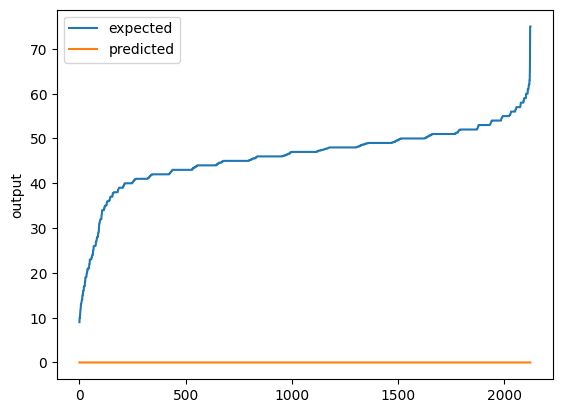

final score (MSE): 2150.953125
final score (RMSE): 46.37837219238281
final score (MAE): 45.69357681274414
final score (R2): -33.114845275878906


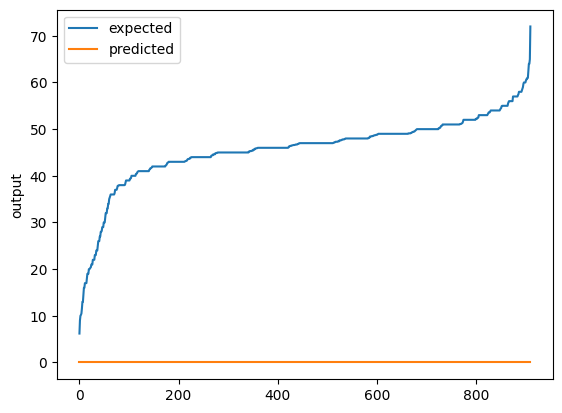

In [95]:
model_scores(model3_drop, X_train, y_train)
model_scores(model3_drop, X_test, y_test)

In [96]:
# fc with relu hidden layer, linear activation layer
model3_drop = FCNet_Dropout(X_train.shape[1],1).to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr = 0.001)
drop2 = run(model3_drop,optimizer)

Epoch:1, train_loss: 2357.458740234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.39it/s]


avg r2 train scores -55.979492
avg r2 test scores -32.956924


Epoch:2, train_loss: 2228.109619140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 178.24it/s]


avg r2 train scores -55.954166
avg r2 test scores -32.956924


Epoch:3, train_loss: 2411.26171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 181.22it/s]


avg r2 train scores -53.35408
avg r2 test scores -32.956924


Epoch:4, train_loss: 1891.8348388671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.00it/s]


avg r2 train scores -54.93717
avg r2 test scores -32.956924


Epoch:5, train_loss: 2368.429443359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.99it/s]


avg r2 train scores -56.199997
avg r2 test scores -32.956924


Epoch:6, train_loss: 2065.994140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.40it/s]


avg r2 train scores -53.246807
avg r2 test scores -32.956924


Epoch:7, train_loss: 2033.1385498046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 175.38it/s]


avg r2 train scores -53.483208
avg r2 test scores -32.956924


Epoch:8, train_loss: 2153.678955078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 179.68it/s]


avg r2 train scores -53.028797
avg r2 test scores -32.956924


Epoch:9, train_loss: 2318.232666015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 176.06it/s]


avg r2 train scores -57.42348
avg r2 test scores -32.956924


Epoch:10, train_loss: 2232.76513671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 176.17it/s]


avg r2 train scores -54.09428
avg r2 test scores -32.956924


Epoch:11, train_loss: 2056.623291015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 174.29it/s]


avg r2 train scores -49.367176
avg r2 test scores -32.956924


Epoch:12, train_loss: 2170.932373046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 175.10it/s]


avg r2 train scores -51.155857
avg r2 test scores -32.956924


Epoch:13, train_loss: 1996.6168212890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 181.05it/s]


avg r2 train scores -49.030247
avg r2 test scores -32.956924


Epoch:14, train_loss: 2299.539306640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 174.28it/s]


avg r2 train scores -52.1003
avg r2 test scores -32.956924


Epoch:15, train_loss: 2211.528076171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 176.14it/s]


avg r2 train scores -51.800213
avg r2 test scores -32.956924


Epoch:16, train_loss: 2493.906005859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.84it/s]


avg r2 train scores -55.926643
avg r2 test scores -32.956924


Epoch:17, train_loss: 2309.950439453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.01it/s]


avg r2 train scores -54.93413
avg r2 test scores -32.956924


Epoch:18, train_loss: 2239.89697265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 135.41it/s]


avg r2 train scores -61.658466
avg r2 test scores -32.956924


Epoch:19, train_loss: 2687.579345703125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.89it/s]


avg r2 train scores -55.53851
avg r2 test scores -32.956924


Epoch:20, train_loss: 1849.1927490234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.24it/s]


avg r2 train scores -49.16143
avg r2 test scores -32.956924


Epoch:21, train_loss: 2260.33154296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 133.35it/s]


avg r2 train scores -57.69258
avg r2 test scores -32.956924


Epoch:22, train_loss: 2220.603759765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.77it/s]


avg r2 train scores -50.651543
avg r2 test scores -32.956924


Epoch:23, train_loss: 2093.052734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.89it/s]


avg r2 train scores -50.07759
avg r2 test scores -32.956924


Epoch:24, train_loss: 2181.207275390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.17it/s]


avg r2 train scores -52.661385
avg r2 test scores -32.956924


Epoch:25, train_loss: 2146.637451171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 178.41it/s]


avg r2 train scores -50.24266
avg r2 test scores -32.956924


Epoch:26, train_loss: 2226.281982421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.42it/s]


avg r2 train scores -51.73526
avg r2 test scores -32.956924


Epoch:27, train_loss: 2203.122802734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.13it/s]


avg r2 train scores -51.262943
avg r2 test scores -32.956924


Epoch:28, train_loss: 2307.9169921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.84it/s]


avg r2 train scores -54.285927
avg r2 test scores -32.956924


Epoch:29, train_loss: 2163.163818359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.06it/s]


avg r2 train scores -50.29145
avg r2 test scores -32.956924


Epoch:30, train_loss: 2461.909423828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.25it/s]


avg r2 train scores -56.817116
avg r2 test scores -32.956924


Epoch:31, train_loss: 2155.489990234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.64it/s]


avg r2 train scores -50.79272
avg r2 test scores -32.956924


Epoch:32, train_loss: 1998.1470947265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.33it/s]


avg r2 train scores -54.096657
avg r2 test scores -32.956924


Epoch:33, train_loss: 2247.173583984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.50it/s]


avg r2 train scores -51.89068
avg r2 test scores -32.956924


Epoch:34, train_loss: 2107.753173828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.87it/s]


avg r2 train scores -54.5113
avg r2 test scores -32.956924


Epoch:35, train_loss: 2336.67431640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.48it/s]


avg r2 train scores -52.60653
avg r2 test scores -32.956924


Epoch:36, train_loss: 2096.446533203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.04it/s]


avg r2 train scores -50.30987
avg r2 test scores -32.956924


Epoch:37, train_loss: 2276.79736328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.47it/s]


avg r2 train scores -54.267353
avg r2 test scores -32.956924


Epoch:38, train_loss: 2086.829833984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.62it/s]


avg r2 train scores -54.75244
avg r2 test scores -32.956924


Epoch:39, train_loss: 2078.825439453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.13it/s]


avg r2 train scores -53.958202
avg r2 test scores -32.956924


Epoch:40, train_loss: 2506.115478515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.09it/s]


avg r2 train scores -54.14421
avg r2 test scores -32.956924


Epoch:41, train_loss: 1763.1126708984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.46it/s]


avg r2 train scores -54.139427
avg r2 test scores -32.956924


Epoch:42, train_loss: 2043.6607666015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 175.30it/s]


avg r2 train scores -52.603733
avg r2 test scores -32.956924


Epoch:43, train_loss: 2021.1270751953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.86it/s]


avg r2 train scores -51.854404
avg r2 test scores -32.956924


Epoch:44, train_loss: 2009.3546142578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.24it/s]


avg r2 train scores -49.48372
avg r2 test scores -32.956924


Epoch:45, train_loss: 1993.2347412109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.23it/s]


avg r2 train scores -53.470974
avg r2 test scores -32.956924


Epoch:46, train_loss: 2298.300048828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 133.63it/s]


avg r2 train scores -49.843357
avg r2 test scores -32.956924


Epoch:47, train_loss: 1996.5059814453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 119.68it/s]


avg r2 train scores -51.933716
avg r2 test scores -32.956924


Epoch:48, train_loss: 2115.8955078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.60it/s]


avg r2 train scores -56.145184
avg r2 test scores -32.956924


Epoch:49, train_loss: 2344.753173828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.67it/s]


avg r2 train scores -53.517548
avg r2 test scores -32.956924


Epoch:50, train_loss: 2228.629150390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.90it/s]


avg r2 train scores -53.719734
avg r2 test scores -32.956924


Epoch:51, train_loss: 2021.9736328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.56it/s]


avg r2 train scores -55.377216
avg r2 test scores -32.956924


Epoch:52, train_loss: 2312.843017578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.19it/s]


avg r2 train scores -54.63081
avg r2 test scores -32.956924


Epoch:53, train_loss: 2429.373046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.89it/s]


avg r2 train scores -52.171364
avg r2 test scores -32.956924


Epoch:54, train_loss: 2415.848876953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 128.58it/s]


avg r2 train scores -57.35306
avg r2 test scores -32.956924


Epoch:55, train_loss: 2261.224365234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.96it/s]


avg r2 train scores -52.978973
avg r2 test scores -32.956924


Epoch:56, train_loss: 2337.6884765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.18it/s]


avg r2 train scores -57.145187
avg r2 test scores -32.956924


Epoch:57, train_loss: 2491.560546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.89it/s]


avg r2 train scores -53.646004
avg r2 test scores -32.956924


Epoch:58, train_loss: 2169.861328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.67it/s]


avg r2 train scores -54.184917
avg r2 test scores -32.956924


Epoch:59, train_loss: 2120.320068359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.37it/s]


avg r2 train scores -55.25142
avg r2 test scores -32.956924


Epoch:60, train_loss: 2249.122314453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.24it/s]


avg r2 train scores -56.87587
avg r2 test scores -32.956924


Epoch:61, train_loss: 2178.984130859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.36it/s]


avg r2 train scores -51.94156
avg r2 test scores -32.956924


Epoch:62, train_loss: 2379.923095703125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.92it/s]


avg r2 train scores -51.32146
avg r2 test scores -32.956924


Epoch:63, train_loss: 2562.253662109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.66it/s]


avg r2 train scores -52.886868
avg r2 test scores -32.956924


Epoch:64, train_loss: 2226.812744140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.46it/s]


avg r2 train scores -53.473858
avg r2 test scores -32.956924


Epoch:65, train_loss: 1994.0914306640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.40it/s]


avg r2 train scores -52.092205
avg r2 test scores -32.956924


Epoch:66, train_loss: 2467.3935546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.22it/s]


avg r2 train scores -55.694946
avg r2 test scores -32.956924


Epoch:67, train_loss: 1877.9427490234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.26it/s]


avg r2 train scores -55.138027
avg r2 test scores -32.956924


Epoch:68, train_loss: 2414.5244140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.49it/s]


avg r2 train scores -50.615192
avg r2 test scores -32.956924


Epoch:69, train_loss: 2316.614990234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.96it/s]


avg r2 train scores -52.85355
avg r2 test scores -32.956924


Epoch:70, train_loss: 2072.142822265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.58it/s]


avg r2 train scores -56.806866
avg r2 test scores -32.956924


Epoch:71, train_loss: 1706.46240234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.80it/s]


avg r2 train scores -53.66073
avg r2 test scores -32.956924


Epoch:72, train_loss: 2095.828857421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.41it/s]


avg r2 train scores -53.277332
avg r2 test scores -32.956924


Epoch:73, train_loss: 2141.72119140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.78it/s]


avg r2 train scores -54.375156
avg r2 test scores -32.956924


Epoch:74, train_loss: 2166.416259765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.09it/s]


avg r2 train scores -52.498688
avg r2 test scores -32.956924


Epoch:75, train_loss: 2060.76513671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.46it/s]


avg r2 train scores -50.831898
avg r2 test scores -32.956924


Epoch:76, train_loss: 2376.482421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.80it/s]


avg r2 train scores -53.702908
avg r2 test scores -32.956924


Epoch:77, train_loss: 2170.070068359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.95it/s]


avg r2 train scores -52.77629
avg r2 test scores -32.956924


Epoch:78, train_loss: 2303.73681640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.87it/s]


avg r2 train scores -54.40339
avg r2 test scores -32.956924


Epoch:79, train_loss: 2109.04052734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.59it/s]


avg r2 train scores -56.384857
avg r2 test scores -32.956924


Epoch:80, train_loss: 2139.046142578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.24it/s]


avg r2 train scores -52.601467
avg r2 test scores -32.956924


Epoch:81, train_loss: 2265.3935546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.72it/s]


avg r2 train scores -48.94383
avg r2 test scores -32.956924


Epoch:82, train_loss: 1981.4927978515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.55it/s]


avg r2 train scores -57.461246
avg r2 test scores -32.956924


Epoch:83, train_loss: 2299.883544921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.92it/s]


avg r2 train scores -49.26594
avg r2 test scores -32.956924


Epoch:84, train_loss: 1811.9053955078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.30it/s]


avg r2 train scores -55.410828
avg r2 test scores -32.956924


Epoch:85, train_loss: 2083.1923828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.97it/s]


avg r2 train scores -51.853672
avg r2 test scores -32.956924


Epoch:86, train_loss: 2223.80224609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.73it/s]


avg r2 train scores -60.613026
avg r2 test scores -32.956924


Epoch:87, train_loss: 2165.836181640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.43it/s]


avg r2 train scores -51.908802
avg r2 test scores -32.956924


Epoch:88, train_loss: 2179.01513671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.88it/s]


avg r2 train scores -54.506687
avg r2 test scores -32.956924


Epoch:89, train_loss: 1905.03515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.76it/s]


avg r2 train scores -53.638153
avg r2 test scores -32.956924


Epoch:90, train_loss: 2297.604248046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.83it/s]


avg r2 train scores -54.302883
avg r2 test scores -32.956924


Epoch:91, train_loss: 2106.499267578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 174.95it/s]


avg r2 train scores -51.000366
avg r2 test scores -32.956924


Epoch:92, train_loss: 1908.5140380859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.69it/s]


avg r2 train scores -56.408882
avg r2 test scores -32.956924


Epoch:93, train_loss: 2421.843505859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.90it/s]


avg r2 train scores -53.436653
avg r2 test scores -32.956924


Epoch:94, train_loss: 2207.576416015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.35it/s]


avg r2 train scores -57.11278
avg r2 test scores -32.956924


Epoch:95, train_loss: 2075.041259765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.64it/s]


avg r2 train scores -56.382717
avg r2 test scores -32.956924


Epoch:96, train_loss: 2424.727783203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.25it/s]


avg r2 train scores -57.579163
avg r2 test scores -32.956924


Epoch:97, train_loss: 2202.441650390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.09it/s]


avg r2 train scores -53.924385
avg r2 test scores -32.956924


Epoch:98, train_loss: 2476.850341796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.70it/s]


avg r2 train scores -55.252567
avg r2 test scores -32.956924


Epoch:99, train_loss: 2279.05908203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.24it/s]


avg r2 train scores -52.96841
avg r2 test scores -32.956924


Epoch:100, train_loss: 1975.99462890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.48it/s]


avg r2 train scores -58.905468
avg r2 test scores -32.956924


Epoch:101, train_loss: 2157.38037109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.82it/s]


avg r2 train scores -55.803375
avg r2 test scores -32.956924


Epoch:102, train_loss: 1932.9090576171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.39it/s]


avg r2 train scores -56.123135
avg r2 test scores -32.956924


Epoch:103, train_loss: 2021.5478515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.94it/s]


avg r2 train scores -53.414
avg r2 test scores -32.956924


Epoch:104, train_loss: 1871.36572265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.28it/s]


avg r2 train scores -53.275196
avg r2 test scores -32.956924


Epoch:105, train_loss: 2302.386474609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.72it/s]


avg r2 train scores -55.9592
avg r2 test scores -32.956924


Epoch:106, train_loss: 2211.88623046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.20it/s]


avg r2 train scores -49.06509
avg r2 test scores -32.956924


Epoch:107, train_loss: 2291.201416015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.27it/s]


avg r2 train scores -52.118767
avg r2 test scores -32.956924


Epoch:108, train_loss: 2328.787353515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.61it/s]


avg r2 train scores -55.57554
avg r2 test scores -32.956924


Epoch:109, train_loss: 2201.927001953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.60it/s]


avg r2 train scores -55.62431
avg r2 test scores -32.956924


Epoch:110, train_loss: 2325.272216796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.23it/s]


avg r2 train scores -50.079655
avg r2 test scores -32.956924


Epoch:111, train_loss: 2316.092529296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.79it/s]


avg r2 train scores -51.35012
avg r2 test scores -32.956924


Epoch:112, train_loss: 2194.3974609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.66it/s]


avg r2 train scores -54.42692
avg r2 test scores -32.956924


Epoch:113, train_loss: 2381.264404296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.84it/s]


avg r2 train scores -52.422997
avg r2 test scores -32.956924


Epoch:114, train_loss: 2122.674072265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.26it/s]


avg r2 train scores -48.637894
avg r2 test scores -32.956924


Epoch:115, train_loss: 2530.601806640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.21it/s]


avg r2 train scores -59.412827
avg r2 test scores -32.956924


Epoch:116, train_loss: 2283.456787109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.04it/s]


avg r2 train scores -49.692562
avg r2 test scores -32.956924


Epoch:117, train_loss: 2238.982666015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.06it/s]


avg r2 train scores -54.576588
avg r2 test scores -32.956924


Epoch:118, train_loss: 2240.59423828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 128.88it/s]


avg r2 train scores -54.711716
avg r2 test scores -32.956924


Epoch:119, train_loss: 2130.15283203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.04it/s]


avg r2 train scores -52.944145
avg r2 test scores -32.956924


Epoch:120, train_loss: 2264.9365234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.97it/s]


avg r2 train scores -55.651077
avg r2 test scores -32.956924


Epoch:121, train_loss: 2392.790771484375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.17it/s]


avg r2 train scores -51.47523
avg r2 test scores -32.956924


Epoch:122, train_loss: 1903.1124267578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.79it/s]


avg r2 train scores -49.709633
avg r2 test scores -32.956924


Epoch:123, train_loss: 2537.741455078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.53it/s]


avg r2 train scores -54.80578
avg r2 test scores -32.956924


Epoch:124, train_loss: 2177.159912109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.83it/s]


avg r2 train scores -53.09719
avg r2 test scores -32.956924


Epoch:125, train_loss: 2317.73828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.46it/s]


avg r2 train scores -48.851807
avg r2 test scores -32.956924


Epoch:126, train_loss: 1996.25390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.74it/s]


avg r2 train scores -50.974396
avg r2 test scores -32.956924


Epoch:127, train_loss: 2173.808349609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.60it/s]


avg r2 train scores -52.642494
avg r2 test scores -32.956924


Epoch:128, train_loss: 1956.03515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.25it/s]


avg r2 train scores -59.37246
avg r2 test scores -32.956924


Epoch:129, train_loss: 1887.59619140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.12it/s]


avg r2 train scores -51.42947
avg r2 test scores -32.956924


Epoch:130, train_loss: 2157.257080078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.99it/s]


avg r2 train scores -57.008057
avg r2 test scores -32.956924


Epoch:131, train_loss: 2231.072021484375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.68it/s]


avg r2 train scores -50.304134
avg r2 test scores -32.956924


Epoch:132, train_loss: 2521.768310546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.21it/s]


avg r2 train scores -53.619514
avg r2 test scores -32.956924


Epoch:133, train_loss: 2358.03515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.28it/s]


avg r2 train scores -52.312645
avg r2 test scores -32.956924


Epoch:134, train_loss: 2036.3001708984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.55it/s]


avg r2 train scores -51.668304
avg r2 test scores -32.956924


Epoch:135, train_loss: 2429.156494140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.07it/s]


avg r2 train scores -58.6432
avg r2 test scores -32.956924


Epoch:136, train_loss: 2152.574462890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.00it/s]


avg r2 train scores -54.47221
avg r2 test scores -32.956924


Epoch:137, train_loss: 2115.793701171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.97it/s]


avg r2 train scores -54.75324
avg r2 test scores -32.956924


Epoch:138, train_loss: 2325.78076171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.32it/s]


avg r2 train scores -51.749092
avg r2 test scores -32.956924


Epoch:139, train_loss: 2329.357421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.21it/s]


avg r2 train scores -54.368587
avg r2 test scores -32.956924


Epoch:140, train_loss: 1927.2406005859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.51it/s]


avg r2 train scores -51.420258
avg r2 test scores -32.956924


Epoch:141, train_loss: 2353.750732421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.93it/s]


avg r2 train scores -55.067795
avg r2 test scores -32.956924


Epoch:142, train_loss: 2215.782470703125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.99it/s]


avg r2 train scores -52.547955
avg r2 test scores -32.956924


Epoch:143, train_loss: 1897.55810546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.32it/s]


avg r2 train scores -53.251446
avg r2 test scores -32.956924


Epoch:144, train_loss: 2352.007080078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.54it/s]


avg r2 train scores -55.76956
avg r2 test scores -32.956924


Epoch:145, train_loss: 2217.197998046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.02it/s]


avg r2 train scores -56.14399
avg r2 test scores -32.956924


Epoch:146, train_loss: 1724.7509765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 178.60it/s]


avg r2 train scores -57.43138
avg r2 test scores -32.956924


Epoch:147, train_loss: 2009.951171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.01it/s]


avg r2 train scores -53.043335
avg r2 test scores -32.956924


Epoch:148, train_loss: 2430.70751953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.92it/s]


avg r2 train scores -51.064926
avg r2 test scores -32.956924


Epoch:149, train_loss: 2454.276123046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.84it/s]


avg r2 train scores -54.77798
avg r2 test scores -32.956924


Epoch:150, train_loss: 2193.443603515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.11it/s]


avg r2 train scores -62.09612
avg r2 test scores -32.956924


Epoch:151, train_loss: 2230.051513671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.69it/s]


avg r2 train scores -54.74235
avg r2 test scores -32.956924


Epoch:152, train_loss: 2313.669189453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.53it/s]


avg r2 train scores -54.884193
avg r2 test scores -32.956924


Epoch:153, train_loss: 2040.2183837890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.42it/s]


avg r2 train scores -52.358597
avg r2 test scores -32.956924


Epoch:154, train_loss: 2170.966064453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.60it/s]


avg r2 train scores -52.475075
avg r2 test scores -32.956924


Epoch:155, train_loss: 1847.6763916015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.85it/s]


avg r2 train scores -49.046448
avg r2 test scores -32.956924


Epoch:156, train_loss: 2429.680908203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.39it/s]


avg r2 train scores -53.61807
avg r2 test scores -32.956924


Epoch:157, train_loss: 2586.450439453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.08it/s]


avg r2 train scores -55.791878
avg r2 test scores -32.956924


Epoch:158, train_loss: 1624.9503173828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.27it/s]


avg r2 train scores -53.48816
avg r2 test scores -32.956924


Epoch:159, train_loss: 2028.6357421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.07it/s]


avg r2 train scores -55.766216
avg r2 test scores -32.956924


Epoch:160, train_loss: 2205.442626953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.83it/s]


avg r2 train scores -50.47449
avg r2 test scores -32.956924


Epoch:161, train_loss: 2302.512939453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.16it/s]


avg r2 train scores -53.06159
avg r2 test scores -32.956924


Epoch:162, train_loss: 2249.729248046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.42it/s]


avg r2 train scores -53.126076
avg r2 test scores -32.956924


Epoch:163, train_loss: 2386.6962890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 135.36it/s]


avg r2 train scores -60.143105
avg r2 test scores -32.956924


Epoch:164, train_loss: 2099.649658203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.00it/s]


avg r2 train scores -55.395565
avg r2 test scores -32.956924


Epoch:165, train_loss: 2322.28564453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.32it/s]


avg r2 train scores -54.28072
avg r2 test scores -32.956924


Epoch:166, train_loss: 2055.69921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.32it/s]


avg r2 train scores -53.647804
avg r2 test scores -32.956924


Epoch:167, train_loss: 2065.21826171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.38it/s]


avg r2 train scores -50.961987
avg r2 test scores -32.956924


Epoch:168, train_loss: 2315.416259765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.12it/s]


avg r2 train scores -56.248005
avg r2 test scores -32.956924


Epoch:169, train_loss: 2464.157958984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.65it/s]


avg r2 train scores -54.930233
avg r2 test scores -32.956924


Epoch:170, train_loss: 2317.955078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.45it/s]


avg r2 train scores -57.10952
avg r2 test scores -32.956924


Epoch:171, train_loss: 2134.47119140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.55it/s]


avg r2 train scores -48.758533
avg r2 test scores -32.956924


Epoch:172, train_loss: 1994.4954833984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.02it/s]


avg r2 train scores -51.580177
avg r2 test scores -32.956924


Epoch:173, train_loss: 2096.159912109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.41it/s]


avg r2 train scores -56.935703
avg r2 test scores -32.956924


Epoch:174, train_loss: 2046.6219482421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.23it/s]


avg r2 train scores -53.833694
avg r2 test scores -32.956924


Epoch:175, train_loss: 1978.6678466796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.32it/s]


avg r2 train scores -51.51241
avg r2 test scores -32.956924


Epoch:176, train_loss: 2426.900634765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.40it/s]


avg r2 train scores -53.040546
avg r2 test scores -32.956924


Epoch:177, train_loss: 2231.237060546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.54it/s]


avg r2 train scores -53.852146
avg r2 test scores -32.956924


Epoch:178, train_loss: 1907.8673095703125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.17it/s]


avg r2 train scores -53.648373
avg r2 test scores -32.956924


Epoch:179, train_loss: 2489.953857421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.88it/s]


avg r2 train scores -54.90271
avg r2 test scores -32.956924


Epoch:180, train_loss: 2108.050048828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.07it/s]


avg r2 train scores -57.684185
avg r2 test scores -32.956924


Epoch:181, train_loss: 1842.23388671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 133.10it/s]


avg r2 train scores -49.37024
avg r2 test scores -32.956924


Epoch:182, train_loss: 2136.645263671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.27it/s]


avg r2 train scores -49.458378
avg r2 test scores -32.956924


Epoch:183, train_loss: 2244.371337890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.99it/s]


avg r2 train scores -55.436077
avg r2 test scores -32.956924


Epoch:184, train_loss: 2057.947998046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.04it/s]


avg r2 train scores -54.573612
avg r2 test scores -32.956924


Epoch:185, train_loss: 2190.491943359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.69it/s]


avg r2 train scores -51.90856
avg r2 test scores -32.956924


Epoch:186, train_loss: 2160.149169921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.20it/s]


avg r2 train scores -52.545403
avg r2 test scores -32.956924


Epoch:187, train_loss: 2190.85009765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.64it/s]


avg r2 train scores -55.134056
avg r2 test scores -32.956924


Epoch:188, train_loss: 2180.109130859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.45it/s]


avg r2 train scores -56.334557
avg r2 test scores -32.956924


Epoch:189, train_loss: 1759.1947021484375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.32it/s]


avg r2 train scores -50.912624
avg r2 test scores -32.956924


Epoch:190, train_loss: 1804.3831787109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.62it/s]


avg r2 train scores -49.317455
avg r2 test scores -32.956924


Epoch:191, train_loss: 2087.125244140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.58it/s]


avg r2 train scores -49.573376
avg r2 test scores -32.956924


Epoch:192, train_loss: 2402.5146484375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.66it/s]


avg r2 train scores -56.73819
avg r2 test scores -32.956924


Epoch:193, train_loss: 2049.77880859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.64it/s]


avg r2 train scores -50.894745
avg r2 test scores -32.956924


Epoch:194, train_loss: 2116.416015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.85it/s]


avg r2 train scores -54.190464
avg r2 test scores -32.956924


Epoch:195, train_loss: 2232.844482421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.29it/s]


avg r2 train scores -51.570892
avg r2 test scores -32.956924


Epoch:196, train_loss: 2012.8961181640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.64it/s]


avg r2 train scores -54.725784
avg r2 test scores -32.956924


Epoch:197, train_loss: 2406.771484375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.90it/s]


avg r2 train scores -52.52193
avg r2 test scores -32.956924


Epoch:198, train_loss: 2196.502685546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.86it/s]


avg r2 train scores -50.990753
avg r2 test scores -32.956924


Epoch:199, train_loss: 2265.101806640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 135.50it/s]


avg r2 train scores -59.12871
avg r2 test scores -32.956924


Epoch:200, train_loss: 1921.0361328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.01it/s]


avg r2 train scores -54.280285
avg r2 test scores -32.956924


Epoch:201, train_loss: 2076.898681640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.77it/s]


avg r2 train scores -48.650864
avg r2 test scores -32.956924


Epoch:202, train_loss: 2066.9794921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.12it/s]


avg r2 train scores -52.90374
avg r2 test scores -32.956924


Epoch:203, train_loss: 2223.804931640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.53it/s]


avg r2 train scores -53.125317
avg r2 test scores -32.956924


Epoch:204, train_loss: 1991.1669921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.28it/s]


avg r2 train scores -56.808773
avg r2 test scores -32.956924


Epoch:205, train_loss: 1980.4901123046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.69it/s]


avg r2 train scores -53.89383
avg r2 test scores -32.956924


Epoch:206, train_loss: 2386.03076171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.80it/s]


avg r2 train scores -52.269176
avg r2 test scores -32.956924


Epoch:207, train_loss: 2163.285400390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.23it/s]


avg r2 train scores -54.31997
avg r2 test scores -32.956924


Epoch:208, train_loss: 1983.1661376953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.35it/s]


avg r2 train scores -49.89205
avg r2 test scores -32.956924


Epoch:209, train_loss: 2203.792236328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.85it/s]


avg r2 train scores -56.71852
avg r2 test scores -32.956924


Epoch:210, train_loss: 2542.400146484375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.80it/s]


avg r2 train scores -54.325726
avg r2 test scores -32.956924


Epoch:211, train_loss: 2224.956298828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.88it/s]


avg r2 train scores -52.805614
avg r2 test scores -32.956924


Epoch:212, train_loss: 1942.6324462890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.56it/s]


avg r2 train scores -51.600124
avg r2 test scores -32.956924


Epoch:213, train_loss: 2307.147705078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.76it/s]


avg r2 train scores -51.402496
avg r2 test scores -32.956924


Epoch:214, train_loss: 2134.443115234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.06it/s]


avg r2 train scores -52.173298
avg r2 test scores -32.956924


Epoch:215, train_loss: 2104.04248046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.39it/s]


avg r2 train scores -53.95149
avg r2 test scores -32.956924


Epoch:216, train_loss: 2210.717041015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.98it/s]


avg r2 train scores -55.603447
avg r2 test scores -32.956924


Epoch:217, train_loss: 2378.609619140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 125.69it/s]


avg r2 train scores -51.896667
avg r2 test scores -32.956924


Epoch:218, train_loss: 2194.894287109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.66it/s]


avg r2 train scores -53.605785
avg r2 test scores -32.956924


Epoch:219, train_loss: 2128.315185546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.47it/s]


avg r2 train scores -55.00238
avg r2 test scores -32.956924


Epoch:220, train_loss: 2144.7021484375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 131.82it/s]


avg r2 train scores -50.29016
avg r2 test scores -32.956924


Epoch:221, train_loss: 2185.683837890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.83it/s]


avg r2 train scores -53.911087
avg r2 test scores -32.956924


Epoch:222, train_loss: 2206.076416015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.93it/s]


avg r2 train scores -55.838806
avg r2 test scores -32.956924


Epoch:223, train_loss: 2339.291748046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.99it/s]


avg r2 train scores -54.86294
avg r2 test scores -32.956924


Epoch:224, train_loss: 1960.255859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.86it/s]


avg r2 train scores -56.41887
avg r2 test scores -32.956924


Epoch:225, train_loss: 2006.7125244140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.37it/s]


avg r2 train scores -51.103127
avg r2 test scores -32.956924


Epoch:226, train_loss: 1788.42431640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.04it/s]


avg r2 train scores -52.433723
avg r2 test scores -32.956924


Epoch:227, train_loss: 1981.3245849609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.38it/s]


avg r2 train scores -56.782284
avg r2 test scores -32.956924


Epoch:228, train_loss: 2024.40673828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 129.76it/s]


avg r2 train scores -52.004387
avg r2 test scores -32.956924


Epoch:229, train_loss: 2391.724609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.46it/s]


avg r2 train scores -52.900997
avg r2 test scores -32.956924


Epoch:230, train_loss: 2189.124267578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 132.29it/s]


avg r2 train scores -50.67481
avg r2 test scores -32.956924


Epoch:231, train_loss: 2234.195068359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 135.84it/s]


avg r2 train scores -50.476124
avg r2 test scores -32.956924


Epoch:232, train_loss: 2277.94580078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.60it/s]


avg r2 train scores -53.789196
avg r2 test scores -32.956924


Epoch:233, train_loss: 2425.006591796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.39it/s]


avg r2 train scores -52.80402
avg r2 test scores -32.956924


Epoch:234, train_loss: 2394.38037109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.43it/s]


avg r2 train scores -52.063587
avg r2 test scores -32.956924


Epoch:235, train_loss: 2037.9385986328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.41it/s]


avg r2 train scores -52.770607
avg r2 test scores -32.956924


Epoch:236, train_loss: 2448.511962890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.64it/s]


avg r2 train scores -52.306976
avg r2 test scores -32.956924


Epoch:237, train_loss: 2341.507080078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.63it/s]


avg r2 train scores -55.01447
avg r2 test scores -32.956924


Epoch:238, train_loss: 2210.343505859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.67it/s]


avg r2 train scores -51.787224
avg r2 test scores -32.956924


Epoch:239, train_loss: 2211.285400390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.19it/s]


avg r2 train scores -62.36412
avg r2 test scores -32.956924


Epoch:240, train_loss: 1936.3861083984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.81it/s]


avg r2 train scores -54.95442
avg r2 test scores -32.956924


Epoch:241, train_loss: 1758.2359619140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.85it/s]


avg r2 train scores -51.024788
avg r2 test scores -32.956924


Epoch:242, train_loss: 2011.375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 131.67it/s]


avg r2 train scores -59.69041
avg r2 test scores -32.956924


Epoch:243, train_loss: 2155.002197265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.52it/s]


avg r2 train scores -54.920353
avg r2 test scores -32.956924


Epoch:244, train_loss: 2136.007568359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.76it/s]


avg r2 train scores -49.401993
avg r2 test scores -32.956924


Epoch:245, train_loss: 2191.31884765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.76it/s]


avg r2 train scores -52.55323
avg r2 test scores -32.956924


Epoch:246, train_loss: 1947.0533447265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.59it/s]


avg r2 train scores -53.2165
avg r2 test scores -32.956924


Epoch:247, train_loss: 1998.12939453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.76it/s]


avg r2 train scores -51.397163
avg r2 test scores -32.956924


Epoch:248, train_loss: 2270.463134765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.79it/s]


avg r2 train scores -52.244328
avg r2 test scores -32.956924


Epoch:249, train_loss: 2284.190185546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.40it/s]


avg r2 train scores -49.83503
avg r2 test scores -32.956924


Epoch:250, train_loss: 2087.294921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.01it/s]


avg r2 train scores -52.05165
avg r2 test scores -32.956924


Epoch:251, train_loss: 2128.0546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.05it/s]


avg r2 train scores -56.533344
avg r2 test scores -32.956924


Epoch:252, train_loss: 2228.152099609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.06it/s]


avg r2 train scores -54.496826
avg r2 test scores -32.956924


Epoch:253, train_loss: 2295.161865234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.70it/s]


avg r2 train scores -53.600735
avg r2 test scores -32.956924


Epoch:254, train_loss: 2189.822509765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.83it/s]


avg r2 train scores -56.663177
avg r2 test scores -32.956924


Epoch:255, train_loss: 2217.539306640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.10it/s]


avg r2 train scores -54.035973
avg r2 test scores -32.956924


Epoch:256, train_loss: 2062.43701171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.37it/s]


avg r2 train scores -51.986122
avg r2 test scores -32.956924


Epoch:257, train_loss: 2477.409423828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.16it/s]


avg r2 train scores -54.017616
avg r2 test scores -32.956924


Epoch:258, train_loss: 2139.863525390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.16it/s]


avg r2 train scores -52.439045
avg r2 test scores -32.956924


Epoch:259, train_loss: 2074.294677734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.02it/s]


avg r2 train scores -53.176807
avg r2 test scores -32.956924


Epoch:260, train_loss: 2184.4091796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.67it/s]


avg r2 train scores -53.098873
avg r2 test scores -32.956924


Epoch:261, train_loss: 2129.427734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.38it/s]


avg r2 train scores -54.81596
avg r2 test scores -32.956924


Epoch:262, train_loss: 2291.328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.51it/s]


avg r2 train scores -53.885815
avg r2 test scores -32.956924


Epoch:263, train_loss: 2144.9189453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.62it/s]


avg r2 train scores -52.411137
avg r2 test scores -32.956924


Epoch:264, train_loss: 1996.7698974609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.84it/s]


avg r2 train scores -52.15169
avg r2 test scores -32.956924


Epoch:265, train_loss: 1794.5838623046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.50it/s]


avg r2 train scores -52.328823
avg r2 test scores -32.956924


Epoch:266, train_loss: 2182.139404296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.76it/s]


avg r2 train scores -55.644104
avg r2 test scores -32.956924


Epoch:267, train_loss: 2412.752197265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.73it/s]


avg r2 train scores -56.377174
avg r2 test scores -32.956924


Epoch:268, train_loss: 1979.8109130859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.03it/s]


avg r2 train scores -53.09583
avg r2 test scores -32.956924


Epoch:269, train_loss: 1831.7364501953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 176.95it/s]


avg r2 train scores -49.2436
avg r2 test scores -32.956924


Epoch:270, train_loss: 2030.4658203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.29it/s]


avg r2 train scores -55.12544
avg r2 test scores -32.956924


Epoch:271, train_loss: 1977.45654296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.41it/s]


avg r2 train scores -54.916664
avg r2 test scores -32.956924


Epoch:272, train_loss: 2278.17578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.18it/s]


avg r2 train scores -54.11872
avg r2 test scores -32.956924


Epoch:273, train_loss: 2640.862060546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 129.78it/s]


avg r2 train scores -49.950924
avg r2 test scores -32.956924


Epoch:274, train_loss: 2273.259521484375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.43it/s]


avg r2 train scores -56.073685
avg r2 test scores -32.956924


Epoch:275, train_loss: 2038.9754638671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.61it/s]


avg r2 train scores -51.825516
avg r2 test scores -32.956924


Epoch:276, train_loss: 1989.25146484375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.27it/s]


avg r2 train scores -49.849483
avg r2 test scores -32.956924


Epoch:277, train_loss: 2299.137939453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.54it/s]


avg r2 train scores -52.281635
avg r2 test scores -32.956924


Epoch:278, train_loss: 2060.427978515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.27it/s]


avg r2 train scores -53.44595
avg r2 test scores -32.956924


Epoch:279, train_loss: 1911.4703369140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.57it/s]


avg r2 train scores -49.56866
avg r2 test scores -32.956924


Epoch:280, train_loss: 2240.060302734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.42it/s]


avg r2 train scores -55.932625
avg r2 test scores -32.956924


Epoch:281, train_loss: 2256.379638671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.57it/s]


avg r2 train scores -52.78126
avg r2 test scores -32.956924


Epoch:282, train_loss: 2018.7586669921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.56it/s]


avg r2 train scores -52.108818
avg r2 test scores -32.956924


Epoch:283, train_loss: 2083.033203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.70it/s]


avg r2 train scores -54.431297
avg r2 test scores -32.956924


Epoch:284, train_loss: 1926.6341552734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.30it/s]


avg r2 train scores -54.609386
avg r2 test scores -32.956924


Epoch:285, train_loss: 2173.705322265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.19it/s]


avg r2 train scores -58.72343
avg r2 test scores -32.956924


Epoch:286, train_loss: 1974.9178466796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.57it/s]


avg r2 train scores -56.043728
avg r2 test scores -32.956924


Epoch:287, train_loss: 2193.986328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.61it/s]


avg r2 train scores -53.618984
avg r2 test scores -32.956924


Epoch:288, train_loss: 2117.265869140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.58it/s]


avg r2 train scores -55.23042
avg r2 test scores -32.956924


Epoch:289, train_loss: 2193.966552734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.99it/s]


avg r2 train scores -50.585117
avg r2 test scores -32.956924


Epoch:290, train_loss: 2167.80517578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.51it/s]


avg r2 train scores -55.16235
avg r2 test scores -32.956924


Epoch:291, train_loss: 2298.520751953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.93it/s]


avg r2 train scores -56.38655
avg r2 test scores -32.956924


Epoch:292, train_loss: 1985.7611083984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.98it/s]


avg r2 train scores -54.32841
avg r2 test scores -32.956924


Epoch:293, train_loss: 1924.3775634765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.40it/s]


avg r2 train scores -55.28305
avg r2 test scores -32.956924


Epoch:294, train_loss: 1924.47705078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.05it/s]


avg r2 train scores -56.087044
avg r2 test scores -32.956924


Epoch:295, train_loss: 2233.745361328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.22it/s]


avg r2 train scores -56.794235
avg r2 test scores -32.956924


Epoch:296, train_loss: 2110.760009765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.75it/s]


avg r2 train scores -50.203945
avg r2 test scores -32.956924


Epoch:297, train_loss: 2165.722900390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.18it/s]


avg r2 train scores -58.761658
avg r2 test scores -32.956924


Epoch:298, train_loss: 2116.66015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.41it/s]


avg r2 train scores -57.15056
avg r2 test scores -32.956924


Epoch:299, train_loss: 2267.3896484375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.63it/s]


avg r2 train scores -53.51392
avg r2 test scores -32.956924


Epoch:300, train_loss: 2109.578857421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.50it/s]


avg r2 train scores -51.046513
avg r2 test scores -32.956924


Epoch:301, train_loss: 2072.66845703125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.67it/s]


avg r2 train scores -55.1244
avg r2 test scores -32.956924


Epoch:302, train_loss: 2200.88525390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 134.43it/s]


avg r2 train scores -52.7106
avg r2 test scores -32.956924


Epoch:303, train_loss: 2224.34375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.40it/s]


avg r2 train scores -57.85397
avg r2 test scores -32.956924


Epoch:304, train_loss: 2451.12353515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.27it/s]


avg r2 train scores -53.46688
avg r2 test scores -32.956924


Epoch:305, train_loss: 2392.80322265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.87it/s]


avg r2 train scores -57.186565
avg r2 test scores -32.956924


Epoch:306, train_loss: 1867.6378173828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.68it/s]


avg r2 train scores -55.057117
avg r2 test scores -32.956924


Epoch:307, train_loss: 2146.0302734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.83it/s]


avg r2 train scores -59.620983
avg r2 test scores -32.956924


Epoch:308, train_loss: 2407.96044921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.65it/s]


avg r2 train scores -56.752514
avg r2 test scores -32.956924


Epoch:309, train_loss: 2093.032958984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 122.18it/s]


avg r2 train scores -54.536175
avg r2 test scores -32.956924


Epoch:310, train_loss: 2064.164306640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.27it/s]


avg r2 train scores -51.822815
avg r2 test scores -32.956924


Epoch:311, train_loss: 1894.7843017578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.09it/s]


avg r2 train scores -52.509144
avg r2 test scores -32.956924


Epoch:312, train_loss: 2169.329345703125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.48it/s]


avg r2 train scores -56.487114
avg r2 test scores -32.956924


Epoch:313, train_loss: 1689.109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.55it/s]


avg r2 train scores -53.50259
avg r2 test scores -32.956924


Epoch:314, train_loss: 2368.827880859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.34it/s]


avg r2 train scores -51.274296
avg r2 test scores -32.956924


Epoch:315, train_loss: 2144.380126953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.99it/s]


avg r2 train scores -51.825726
avg r2 test scores -32.956924


Epoch:316, train_loss: 1978.0196533203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.11it/s]


avg r2 train scores -52.09283
avg r2 test scores -32.956924


Epoch:317, train_loss: 2066.005126953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.71it/s]


avg r2 train scores -51.58479
avg r2 test scores -32.956924


Epoch:318, train_loss: 2102.453857421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.43it/s]


avg r2 train scores -52.19966
avg r2 test scores -32.956924


Epoch:319, train_loss: 2313.826904296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.29it/s]


avg r2 train scores -50.52963
avg r2 test scores -32.956924


Epoch:320, train_loss: 2373.685791015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.15it/s]


avg r2 train scores -54.518383
avg r2 test scores -32.956924


Epoch:321, train_loss: 2041.7939453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.00it/s]


avg r2 train scores -50.738407
avg r2 test scores -32.956924


Epoch:322, train_loss: 2177.7900390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.68it/s]


avg r2 train scores -55.295143
avg r2 test scores -32.956924


Epoch:323, train_loss: 2155.500732421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.00it/s]


avg r2 train scores -52.458458
avg r2 test scores -32.956924


Epoch:324, train_loss: 2168.614990234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.90it/s]


avg r2 train scores -57.905476
avg r2 test scores -32.956924


Epoch:325, train_loss: 2512.95263671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.55it/s]


avg r2 train scores -52.578613
avg r2 test scores -32.956924


Epoch:326, train_loss: 2098.575439453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 124.89it/s]


avg r2 train scores -50.88081
avg r2 test scores -32.956924


Epoch:327, train_loss: 2267.899658203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.76it/s]


avg r2 train scores -57.83977
avg r2 test scores -32.956924


Epoch:328, train_loss: 2098.8203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.61it/s]


avg r2 train scores -49.797543
avg r2 test scores -32.956924


Epoch:329, train_loss: 2119.97314453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.69it/s]


avg r2 train scores -50.326355
avg r2 test scores -32.956924


Epoch:330, train_loss: 2214.629638671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.53it/s]


avg r2 train scores -50.083797
avg r2 test scores -32.956924


Epoch:331, train_loss: 2171.863525390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.89it/s]


avg r2 train scores -55.81867
avg r2 test scores -32.956924


Epoch:332, train_loss: 2364.49462890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.86it/s]


avg r2 train scores -55.261116
avg r2 test scores -32.956924


Epoch:333, train_loss: 2255.195556640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.99it/s]


avg r2 train scores -50.48942
avg r2 test scores -32.956924


Epoch:334, train_loss: 2199.12890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.61it/s]


avg r2 train scores -53.928436
avg r2 test scores -32.956924


Epoch:335, train_loss: 2211.795166015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.04it/s]


avg r2 train scores -53.683796
avg r2 test scores -32.956924


Epoch:336, train_loss: 1942.0487060546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 134.04it/s]


avg r2 train scores -52.333424
avg r2 test scores -32.956924


Epoch:337, train_loss: 2305.0078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.15it/s]


avg r2 train scores -53.69361
avg r2 test scores -32.956924


Epoch:338, train_loss: 2134.46435546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.67it/s]


avg r2 train scores -55.066917
avg r2 test scores -32.956924


Epoch:339, train_loss: 2177.861083984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.48it/s]


avg r2 train scores -53.867237
avg r2 test scores -32.956924


Epoch:340, train_loss: 2202.21240234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.78it/s]


avg r2 train scores -52.64022
avg r2 test scores -32.956924


Epoch:341, train_loss: 1859.2095947265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.38it/s]


avg r2 train scores -54.24258
avg r2 test scores -32.956924


Epoch:342, train_loss: 2079.4716796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.90it/s]


avg r2 train scores -52.945538
avg r2 test scores -32.956924


Epoch:343, train_loss: 2474.26611328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.68it/s]


avg r2 train scores -54.92566
avg r2 test scores -32.956924


Epoch:344, train_loss: 2044.78515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.03it/s]


avg r2 train scores -54.91961
avg r2 test scores -32.956924


Epoch:345, train_loss: 2220.710693359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.40it/s]


avg r2 train scores -58.08215
avg r2 test scores -32.956924


Epoch:346, train_loss: 2176.4130859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.14it/s]


avg r2 train scores -54.088074
avg r2 test scores -32.956924


Epoch:347, train_loss: 2155.691162109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.57it/s]


avg r2 train scores -52.41089
avg r2 test scores -32.956924


Epoch:348, train_loss: 2203.96630859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 135.46it/s]


avg r2 train scores -54.309822
avg r2 test scores -32.956924


Epoch:349, train_loss: 2164.326416015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.84it/s]


avg r2 train scores -55.602192
avg r2 test scores -32.956924


Epoch:350, train_loss: 2023.0494384765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.31it/s]


avg r2 train scores -55.91841
avg r2 test scores -32.956924


Epoch:351, train_loss: 2225.68994140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.86it/s]


avg r2 train scores -52.80953
avg r2 test scores -32.956924


Epoch:352, train_loss: 2093.498291015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.27it/s]


avg r2 train scores -53.986748
avg r2 test scores -32.956924


Epoch:353, train_loss: 2053.128173828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.79it/s]


avg r2 train scores -51.62882
avg r2 test scores -32.956924


Epoch:354, train_loss: 2340.8154296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.46it/s]


avg r2 train scores -56.247738
avg r2 test scores -32.956924


Epoch:355, train_loss: 1836.5135498046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.87it/s]


avg r2 train scores -55.998222
avg r2 test scores -32.956924


Epoch:356, train_loss: 2333.994873046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.26it/s]


avg r2 train scores -48.913654
avg r2 test scores -32.956924


Epoch:357, train_loss: 2189.708251953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.32it/s]


avg r2 train scores -53.38739
avg r2 test scores -32.956924


Epoch:358, train_loss: 2287.85205078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.09it/s]


avg r2 train scores -56.11501
avg r2 test scores -32.956924


Epoch:359, train_loss: 2100.78857421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.17it/s]


avg r2 train scores -52.259193
avg r2 test scores -32.956924


Epoch:360, train_loss: 1871.623046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.04it/s]


avg r2 train scores -57.09306
avg r2 test scores -32.956924


Epoch:361, train_loss: 2010.6622314453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.99it/s]


avg r2 train scores -52.386658
avg r2 test scores -32.956924


Epoch:362, train_loss: 2458.524658203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 135.35it/s]


avg r2 train scores -54.58538
avg r2 test scores -32.956924


Epoch:363, train_loss: 2202.370849609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.47it/s]


avg r2 train scores -50.45226
avg r2 test scores -32.956924


Epoch:364, train_loss: 2200.836669921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 134.68it/s]


avg r2 train scores -54.159218
avg r2 test scores -32.956924


Epoch:365, train_loss: 2212.751708984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.59it/s]


avg r2 train scores -54.195957
avg r2 test scores -32.956924


Epoch:366, train_loss: 2372.940673828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.96it/s]


avg r2 train scores -52.627
avg r2 test scores -32.956924


Epoch:367, train_loss: 2109.080322265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.51it/s]


avg r2 train scores -52.345905
avg r2 test scores -32.956924


Epoch:368, train_loss: 2080.439208984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.29it/s]


avg r2 train scores -52.85269
avg r2 test scores -32.956924


Epoch:369, train_loss: 2020.3699951171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 130.45it/s]


avg r2 train scores -55.31265
avg r2 test scores -32.956924


Epoch:370, train_loss: 1648.5960693359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.24it/s]


avg r2 train scores -48.20029
avg r2 test scores -32.956924


Epoch:371, train_loss: 2265.669677734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 134.10it/s]


avg r2 train scores -53.833447
avg r2 test scores -32.956924


Epoch:372, train_loss: 2136.75830078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.30it/s]


avg r2 train scores -56.85751
avg r2 test scores -32.956924


Epoch:373, train_loss: 1896.5565185546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.43it/s]


avg r2 train scores -52.216366
avg r2 test scores -32.956924


Epoch:374, train_loss: 2128.550048828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.20it/s]


avg r2 train scores -50.4806
avg r2 test scores -32.956924


Epoch:375, train_loss: 2122.522705078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.50it/s]


avg r2 train scores -50.274036
avg r2 test scores -32.956924


Epoch:376, train_loss: 1946.76904296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.29it/s]


avg r2 train scores -58.523495
avg r2 test scores -32.956924


Epoch:377, train_loss: 2011.69970703125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.54it/s]


avg r2 train scores -53.263264
avg r2 test scores -32.956924


Epoch:378, train_loss: 1752.9932861328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.46it/s]


avg r2 train scores -52.030254
avg r2 test scores -32.956924


Epoch:379, train_loss: 2315.1787109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.77it/s]


avg r2 train scores -51.929672
avg r2 test scores -32.956924


Epoch:380, train_loss: 2481.76904296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.99it/s]


avg r2 train scores -51.629738
avg r2 test scores -32.956924


Epoch:381, train_loss: 1879.0113525390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.83it/s]


avg r2 train scores -51.91043
avg r2 test scores -32.956924


Epoch:382, train_loss: 2361.07275390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.37it/s]


avg r2 train scores -53.742943
avg r2 test scores -32.956924


Epoch:383, train_loss: 2152.3955078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.70it/s]


avg r2 train scores -53.71642
avg r2 test scores -32.956924


Epoch:384, train_loss: 2134.695556640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.90it/s]


avg r2 train scores -49.587833
avg r2 test scores -32.956924


Epoch:385, train_loss: 2077.037353515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.50it/s]


avg r2 train scores -52.30202
avg r2 test scores -32.956924


Epoch:386, train_loss: 2026.4371337890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.96it/s]


avg r2 train scores -51.74789
avg r2 test scores -32.956924


Epoch:387, train_loss: 2022.5084228515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.45it/s]


avg r2 train scores -50.896767
avg r2 test scores -32.956924


Epoch:388, train_loss: 2039.8963623046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.62it/s]


avg r2 train scores -53.15793
avg r2 test scores -32.956924


Epoch:389, train_loss: 2101.77685546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.03it/s]


avg r2 train scores -50.725227
avg r2 test scores -32.956924


Epoch:390, train_loss: 2265.317138671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.10it/s]


avg r2 train scores -51.01192
avg r2 test scores -32.956924


Epoch:391, train_loss: 2173.583251953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.11it/s]


avg r2 train scores -50.781876
avg r2 test scores -32.956924


Epoch:392, train_loss: 2062.200927734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.02it/s]


avg r2 train scores -49.395077
avg r2 test scores -32.956924


Epoch:393, train_loss: 2021.06494140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.59it/s]


avg r2 train scores -55.057644
avg r2 test scores -32.956924


Epoch:394, train_loss: 1785.5682373046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.27it/s]


avg r2 train scores -52.354183
avg r2 test scores -32.956924


Epoch:395, train_loss: 1960.6339111328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 135.45it/s]


avg r2 train scores -56.03831
avg r2 test scores -32.956924


Epoch:396, train_loss: 2310.221923828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 133.36it/s]


avg r2 train scores -60.022728
avg r2 test scores -32.956924


Epoch:397, train_loss: 2029.7652587890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.77it/s]


avg r2 train scores -53.35543
avg r2 test scores -32.956924


Epoch:398, train_loss: 2163.074951171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.94it/s]


avg r2 train scores -51.285534
avg r2 test scores -32.956924


Epoch:399, train_loss: 2389.82958984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.90it/s]


avg r2 train scores -50.873962
avg r2 test scores -32.956924


Epoch:400, train_loss: 2274.598388671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.25it/s]


avg r2 train scores -52.531532
avg r2 test scores -32.956924


Epoch:401, train_loss: 1910.3333740234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.33it/s]


avg r2 train scores -54.67932
avg r2 test scores -32.956924


Epoch:402, train_loss: 2026.5838623046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.44it/s]


avg r2 train scores -53.647934
avg r2 test scores -32.956924


Epoch:403, train_loss: 2094.256591796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.52it/s]


avg r2 train scores -55.025143
avg r2 test scores -32.956924


Epoch:404, train_loss: 2226.856689453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.73it/s]


avg r2 train scores -49.908054
avg r2 test scores -32.956924


Epoch:405, train_loss: 2135.072998046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.85it/s]


avg r2 train scores -52.501797
avg r2 test scores -32.956924


Epoch:406, train_loss: 2296.573974609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.33it/s]


avg r2 train scores -56.55716
avg r2 test scores -32.956924


Epoch:407, train_loss: 2141.259765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.16it/s]


avg r2 train scores -51.837856
avg r2 test scores -32.956924


Epoch:408, train_loss: 2192.908203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.05it/s]


avg r2 train scores -56.548634
avg r2 test scores -32.956924


Epoch:409, train_loss: 1919.0025634765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.63it/s]


avg r2 train scores -49.98146
avg r2 test scores -32.956924


Epoch:410, train_loss: 2386.093017578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.00it/s]


avg r2 train scores -53.003918
avg r2 test scores -32.956924


Epoch:411, train_loss: 2443.834228515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.66it/s]


avg r2 train scores -52.51428
avg r2 test scores -32.956924


Epoch:412, train_loss: 2259.366943359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.17it/s]


avg r2 train scores -51.927677
avg r2 test scores -32.956924


Epoch:413, train_loss: 2196.966552734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.37it/s]


avg r2 train scores -55.094913
avg r2 test scores -32.956924


Epoch:414, train_loss: 1943.4114990234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 134.70it/s]


avg r2 train scores -55.978867
avg r2 test scores -32.956924


Epoch:415, train_loss: 2337.022216796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.80it/s]


avg r2 train scores -52.395153
avg r2 test scores -32.956924


Epoch:416, train_loss: 2114.595458984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.06it/s]


avg r2 train scores -57.81339
avg r2 test scores -32.956924


Epoch:417, train_loss: 1987.7486572265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.83it/s]


avg r2 train scores -50.230885
avg r2 test scores -32.956924


Epoch:418, train_loss: 2387.7099609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.36it/s]


avg r2 train scores -56.34681
avg r2 test scores -32.956924


Epoch:419, train_loss: 2103.836669921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.55it/s]


avg r2 train scores -50.657352
avg r2 test scores -32.956924


Epoch:420, train_loss: 2118.5927734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.04it/s]


avg r2 train scores -51.6832
avg r2 test scores -32.956924


Epoch:421, train_loss: 2131.448486328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.96it/s]


avg r2 train scores -53.91543
avg r2 test scores -32.956924


Epoch:422, train_loss: 2290.196533203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.02it/s]


avg r2 train scores -51.799583
avg r2 test scores -32.956924


Epoch:423, train_loss: 1941.5877685546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.65it/s]


avg r2 train scores -54.293472
avg r2 test scores -32.956924


Epoch:424, train_loss: 2221.480712890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.03it/s]


avg r2 train scores -48.329624
avg r2 test scores -32.956924


Epoch:425, train_loss: 2171.485107421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 129.33it/s]


avg r2 train scores -51.467033
avg r2 test scores -32.956924


Epoch:426, train_loss: 2131.1025390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.31it/s]


avg r2 train scores -57.87849
avg r2 test scores -32.956924


Epoch:427, train_loss: 2029.6768798828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.16it/s]


avg r2 train scores -53.086193
avg r2 test scores -32.956924


Epoch:428, train_loss: 2309.83203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.62it/s]


avg r2 train scores -54.69465
avg r2 test scores -32.956924


Epoch:429, train_loss: 2045.0980224609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.79it/s]


avg r2 train scores -55.244987
avg r2 test scores -32.956924


Epoch:430, train_loss: 1944.7108154296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.84it/s]


avg r2 train scores -57.61986
avg r2 test scores -32.956924


Epoch:431, train_loss: 1879.9320068359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.74it/s]


avg r2 train scores -54.021954
avg r2 test scores -32.956924


Epoch:432, train_loss: 2316.44140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.10it/s]


avg r2 train scores -54.37069
avg r2 test scores -32.956924


Epoch:433, train_loss: 2375.994873046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.20it/s]


avg r2 train scores -52.612034
avg r2 test scores -32.956924


Epoch:434, train_loss: 2152.10546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.94it/s]


avg r2 train scores -52.93677
avg r2 test scores -32.956924


Epoch:435, train_loss: 2356.325927734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.41it/s]


avg r2 train scores -53.412773
avg r2 test scores -32.956924


Epoch:436, train_loss: 2217.37255859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.87it/s]


avg r2 train scores -53.19577
avg r2 test scores -32.956924


Epoch:437, train_loss: 1683.8642578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.11it/s]


avg r2 train scores -54.354675
avg r2 test scores -32.956924


Epoch:438, train_loss: 2147.314453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.17it/s]


avg r2 train scores -53.756435
avg r2 test scores -32.956924


Epoch:439, train_loss: 2241.949951171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.80it/s]


avg r2 train scores -53.874115
avg r2 test scores -32.956924


Epoch:440, train_loss: 2321.907958984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.75it/s]


avg r2 train scores -52.8661
avg r2 test scores -32.956924


Epoch:441, train_loss: 2299.233642578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.00it/s]


avg r2 train scores -58.48205
avg r2 test scores -32.956924


Epoch:442, train_loss: 2224.906982421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.42it/s]


avg r2 train scores -57.325684
avg r2 test scores -32.956924


Epoch:443, train_loss: 2395.80126953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.16it/s]


avg r2 train scores -56.11003
avg r2 test scores -32.956924


Epoch:444, train_loss: 1866.6983642578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.65it/s]


avg r2 train scores -56.137466
avg r2 test scores -32.956924


Epoch:445, train_loss: 2024.3013916015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.93it/s]


avg r2 train scores -55.148106
avg r2 test scores -32.956924


Epoch:446, train_loss: 2050.856689453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.21it/s]


avg r2 train scores -57.96706
avg r2 test scores -32.956924


Epoch:447, train_loss: 2066.796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.42it/s]


avg r2 train scores -54.9786
avg r2 test scores -32.956924


Epoch:448, train_loss: 2406.856201171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.68it/s]


avg r2 train scores -54.283806
avg r2 test scores -32.956924


Epoch:449, train_loss: 2431.34033203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.19it/s]


avg r2 train scores -60.09844
avg r2 test scores -32.956924


Epoch:450, train_loss: 2094.947509765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.06it/s]


avg r2 train scores -54.74761
avg r2 test scores -32.956924


Epoch:451, train_loss: 2185.630615234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.50it/s]


avg r2 train scores -51.908512
avg r2 test scores -32.956924


Epoch:452, train_loss: 2121.258056640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.37it/s]


avg r2 train scores -49.639465
avg r2 test scores -32.956924


Epoch:453, train_loss: 2406.667236328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 178.40it/s]


avg r2 train scores -57.563282
avg r2 test scores -32.956924


Epoch:454, train_loss: 1861.5196533203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 182.27it/s]


avg r2 train scores -51.743496
avg r2 test scores -32.956924


Epoch:455, train_loss: 2191.410888671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.92it/s]


avg r2 train scores -49.26266
avg r2 test scores -32.956924


Epoch:456, train_loss: 2142.663818359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.81it/s]


avg r2 train scores -53.200203
avg r2 test scores -32.956924


Epoch:457, train_loss: 2034.7869873046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.56it/s]


avg r2 train scores -54.25204
avg r2 test scores -32.956924


Epoch:458, train_loss: 1907.5496826171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.95it/s]


avg r2 train scores -54.993446
avg r2 test scores -32.956924


Epoch:459, train_loss: 1550.9493408203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 132.44it/s]


avg r2 train scores -51.48529
avg r2 test scores -32.956924


Epoch:460, train_loss: 1960.1654052734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.89it/s]


avg r2 train scores -53.585007
avg r2 test scores -32.956924


Epoch:461, train_loss: 2346.718505859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.95it/s]


avg r2 train scores -54.113537
avg r2 test scores -32.956924


Epoch:462, train_loss: 2230.13623046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.23it/s]


avg r2 train scores -54.25242
avg r2 test scores -32.956924


Epoch:463, train_loss: 2426.2236328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.42it/s]


avg r2 train scores -60.817448
avg r2 test scores -32.956924


Epoch:464, train_loss: 2106.614501953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.26it/s]


avg r2 train scores -51.02652
avg r2 test scores -32.956924


Epoch:465, train_loss: 2203.276123046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.76it/s]


avg r2 train scores -52.481205
avg r2 test scores -32.956924


Epoch:466, train_loss: 2170.112548828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.83it/s]


avg r2 train scores -52.646526
avg r2 test scores -32.956924


Epoch:467, train_loss: 2190.639892578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.42it/s]


avg r2 train scores -56.040443
avg r2 test scores -32.956924


Epoch:468, train_loss: 2163.4541015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.97it/s]


avg r2 train scores -52.817364
avg r2 test scores -32.956924


Epoch:469, train_loss: 2213.55224609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.96it/s]


avg r2 train scores -51.039764
avg r2 test scores -32.956924


Epoch:470, train_loss: 2176.037109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.12it/s]


avg r2 train scores -52.25079
avg r2 test scores -32.956924


Epoch:471, train_loss: 2108.589599609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.25it/s]


avg r2 train scores -52.415302
avg r2 test scores -32.956924


Epoch:472, train_loss: 2044.0087890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.63it/s]


avg r2 train scores -53.995808
avg r2 test scores -32.956924


Epoch:473, train_loss: 2310.03955078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.75it/s]


avg r2 train scores -52.804966
avg r2 test scores -32.956924


Epoch:474, train_loss: 1890.5511474609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.92it/s]


avg r2 train scores -54.25982
avg r2 test scores -32.956924


Epoch:475, train_loss: 2335.330810546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.32it/s]


avg r2 train scores -52.785706
avg r2 test scores -32.956924


Epoch:476, train_loss: 2265.796630859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.11it/s]


avg r2 train scores -52.983078
avg r2 test scores -32.956924


Epoch:477, train_loss: 2168.504150390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.08it/s]


avg r2 train scores -53.21368
avg r2 test scores -32.956924


Epoch:478, train_loss: 2369.542236328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.80it/s]


avg r2 train scores -56.516243
avg r2 test scores -32.956924


Epoch:479, train_loss: 2105.0234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.67it/s]


avg r2 train scores -54.880013
avg r2 test scores -32.956924


Epoch:480, train_loss: 2246.20458984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.58it/s]


avg r2 train scores -50.541992
avg r2 test scores -32.956924


Epoch:481, train_loss: 2033.5, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.34it/s]


avg r2 train scores -53.221672
avg r2 test scores -32.956924


Epoch:482, train_loss: 2272.091064453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.73it/s]


avg r2 train scores -53.27148
avg r2 test scores -32.956924


Epoch:483, train_loss: 2486.54833984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.65it/s]


avg r2 train scores -53.018726
avg r2 test scores -32.956924


Epoch:484, train_loss: 2363.041259765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.72it/s]


avg r2 train scores -59.76439
avg r2 test scores -32.956924


Epoch:485, train_loss: 2282.018310546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.89it/s]


avg r2 train scores -54.274124
avg r2 test scores -32.956924


Epoch:486, train_loss: 2202.085205078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.19it/s]


avg r2 train scores -51.31305
avg r2 test scores -32.956924


Epoch:487, train_loss: 2140.030517578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.05it/s]


avg r2 train scores -51.72516
avg r2 test scores -32.956924


Epoch:488, train_loss: 2343.530517578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.98it/s]


avg r2 train scores -55.912025
avg r2 test scores -32.956924


Epoch:489, train_loss: 2081.07958984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.01it/s]


avg r2 train scores -55.18595
avg r2 test scores -32.956924


Epoch:490, train_loss: 2049.281494140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.08it/s]


avg r2 train scores -53.937866
avg r2 test scores -32.956924


Epoch:491, train_loss: 2015.8062744140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.21it/s]


avg r2 train scores -53.83295
avg r2 test scores -32.956924


Epoch:492, train_loss: 2520.501708984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.23it/s]


avg r2 train scores -52.64764
avg r2 test scores -32.956924


Epoch:493, train_loss: 1812.1146240234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.13it/s]


avg r2 train scores -55.077755
avg r2 test scores -32.956924


Epoch:494, train_loss: 2068.164306640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.09it/s]


avg r2 train scores -50.30753
avg r2 test scores -32.956924


Epoch:495, train_loss: 2144.848388671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.79it/s]


avg r2 train scores -53.71265
avg r2 test scores -32.956924


Epoch:496, train_loss: 2419.78662109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.48it/s]


avg r2 train scores -53.01084
avg r2 test scores -32.956924


Epoch:497, train_loss: 2173.027099609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 132.41it/s]


avg r2 train scores -55.89954
avg r2 test scores -32.956924


Epoch:498, train_loss: 2321.94189453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.33it/s]


avg r2 train scores -53.857693
avg r2 test scores -32.956924


Epoch:499, train_loss: 2295.590087890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.30it/s]


avg r2 train scores -54.096474
avg r2 test scores -32.956924


Epoch:500, train_loss: 1991.7884521484375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.65it/s]


avg r2 train scores -55.9696
avg r2 test scores -32.956924


Epoch:501, train_loss: 2009.33544921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.73it/s]


avg r2 train scores -53.783012
avg r2 test scores -32.956924


Epoch:502, train_loss: 2029.7847900390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.38it/s]


avg r2 train scores -56.93682
avg r2 test scores -32.956924


Epoch:503, train_loss: 2049.89697265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.90it/s]


avg r2 train scores -55.071007
avg r2 test scores -32.956924


Epoch:504, train_loss: 2112.082763671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.27it/s]


avg r2 train scores -53.206406
avg r2 test scores -32.956924


Epoch:505, train_loss: 2198.882568359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.92it/s]


avg r2 train scores -51.419884
avg r2 test scores -32.956924


Epoch:506, train_loss: 2051.316650390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.92it/s]


avg r2 train scores -52.301556
avg r2 test scores -32.956924


Epoch:507, train_loss: 1912.1888427734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.72it/s]


avg r2 train scores -53.35968
avg r2 test scores -32.956924


Epoch:508, train_loss: 2132.212158203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.84it/s]


avg r2 train scores -52.454403
avg r2 test scores -32.956924


Epoch:509, train_loss: 2059.34033203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.62it/s]


avg r2 train scores -55.35972
avg r2 test scores -32.956924


Epoch:510, train_loss: 2261.551513671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.09it/s]


avg r2 train scores -51.302914
avg r2 test scores -32.956924


Epoch:511, train_loss: 2251.995849609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.39it/s]


avg r2 train scores -54.653427
avg r2 test scores -32.956924


Epoch:512, train_loss: 2170.035888671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.29it/s]


avg r2 train scores -53.700474
avg r2 test scores -32.956924


Epoch:513, train_loss: 2454.67236328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.57it/s]


avg r2 train scores -57.200645
avg r2 test scores -32.956924


Epoch:514, train_loss: 2314.32958984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.14it/s]


avg r2 train scores -54.813076
avg r2 test scores -32.956924


Epoch:515, train_loss: 2146.125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.90it/s]


avg r2 train scores -52.813496
avg r2 test scores -32.956924


Epoch:516, train_loss: 1782.8681640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.72it/s]


avg r2 train scores -55.34366
avg r2 test scores -32.956924


Epoch:517, train_loss: 2302.640869140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 129.61it/s]


avg r2 train scores -54.69772
avg r2 test scores -32.956924


Epoch:518, train_loss: 2371.12646484375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.08it/s]


avg r2 train scores -51.49845
avg r2 test scores -32.956924


Epoch:519, train_loss: 1850.3819580078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.70it/s]


avg r2 train scores -52.030846
avg r2 test scores -32.956924


Epoch:520, train_loss: 1915.8935546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 131.87it/s]


avg r2 train scores -53.49427
avg r2 test scores -32.956924


Epoch:521, train_loss: 2074.65283203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.35it/s]


avg r2 train scores -57.164207
avg r2 test scores -32.956924


Epoch:522, train_loss: 2492.955810546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.61it/s]


avg r2 train scores -56.342396
avg r2 test scores -32.956924


Epoch:523, train_loss: 2044.7041015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.01it/s]


avg r2 train scores -55.267838
avg r2 test scores -32.956924


Epoch:524, train_loss: 2088.831787109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.24it/s]


avg r2 train scores -50.73226
avg r2 test scores -32.956924


Epoch:525, train_loss: 2172.438232421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.25it/s]


avg r2 train scores -52.466095
avg r2 test scores -32.956924


Epoch:526, train_loss: 2250.5263671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.94it/s]


avg r2 train scores -52.323517
avg r2 test scores -32.956924


Epoch:527, train_loss: 2068.987548828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.49it/s]


avg r2 train scores -51.66207
avg r2 test scores -32.956924


Epoch:528, train_loss: 2084.31005859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.62it/s]


avg r2 train scores -51.543346
avg r2 test scores -32.956924


Epoch:529, train_loss: 2498.617919921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.27it/s]


avg r2 train scores -53.525265
avg r2 test scores -32.956924


Epoch:530, train_loss: 2206.861083984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.56it/s]


avg r2 train scores -52.15172
avg r2 test scores -32.956924


Epoch:531, train_loss: 2010.06103515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.44it/s]


avg r2 train scores -54.021336
avg r2 test scores -32.956924


Epoch:532, train_loss: 2192.359130859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.03it/s]


avg r2 train scores -52.88716
avg r2 test scores -32.956924


Epoch:533, train_loss: 2242.6650390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.89it/s]


avg r2 train scores -56.2171
avg r2 test scores -32.956924


Epoch:534, train_loss: 1842.7318115234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.67it/s]


avg r2 train scores -53.73831
avg r2 test scores -32.956924


Epoch:535, train_loss: 2112.67822265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.92it/s]


avg r2 train scores -52.75058
avg r2 test scores -32.956924


Epoch:536, train_loss: 2192.080322265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.23it/s]


avg r2 train scores -56.767754
avg r2 test scores -32.956924


Epoch:537, train_loss: 2413.890869140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.77it/s]


avg r2 train scores -55.21757
avg r2 test scores -32.956924


Epoch:538, train_loss: 2127.772216796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.86it/s]


avg r2 train scores -53.626495
avg r2 test scores -32.956924


Epoch:539, train_loss: 2414.972412109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.79it/s]


avg r2 train scores -54.629295
avg r2 test scores -32.956924


Epoch:540, train_loss: 2148.01708984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.84it/s]


avg r2 train scores -53.8618
avg r2 test scores -32.956924


Epoch:541, train_loss: 2527.386962890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.01it/s]


avg r2 train scores -53.87468
avg r2 test scores -32.956924


Epoch:542, train_loss: 2142.4091796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.83it/s]


avg r2 train scores -50.683716
avg r2 test scores -32.956924


Epoch:543, train_loss: 2671.23046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.72it/s]


avg r2 train scores -52.83509
avg r2 test scores -32.956924


Epoch:544, train_loss: 2206.37548828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.48it/s]


avg r2 train scores -51.4771
avg r2 test scores -32.956924


Epoch:545, train_loss: 1964.265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.69it/s]


avg r2 train scores -51.984837
avg r2 test scores -32.956924


Epoch:546, train_loss: 2097.587890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 122.68it/s]


avg r2 train scores -55.002327
avg r2 test scores -32.956924


Epoch:547, train_loss: 2162.708740234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.13it/s]


avg r2 train scores -49.28536
avg r2 test scores -32.956924


Epoch:548, train_loss: 2060.35693359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.57it/s]


avg r2 train scores -55.346176
avg r2 test scores -32.956924


Epoch:549, train_loss: 2109.198486328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.36it/s]


avg r2 train scores -58.638775
avg r2 test scores -32.956924


Epoch:550, train_loss: 2385.035888671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.08it/s]


avg r2 train scores -51.975056
avg r2 test scores -32.956924


Epoch:551, train_loss: 1768.4552001953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.95it/s]


avg r2 train scores -53.6893
avg r2 test scores -32.956924


Epoch:552, train_loss: 2133.6796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.02it/s]


avg r2 train scores -53.434296
avg r2 test scores -32.956924


Epoch:553, train_loss: 2102.7587890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.15it/s]


avg r2 train scores -49.625343
avg r2 test scores -32.956924


Epoch:554, train_loss: 2136.603759765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.86it/s]


avg r2 train scores -53.379246
avg r2 test scores -32.956924


Epoch:555, train_loss: 2149.654296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.81it/s]


avg r2 train scores -53.486572
avg r2 test scores -32.956924


Epoch:556, train_loss: 2069.3857421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.00it/s]


avg r2 train scores -52.51254
avg r2 test scores -32.956924


Epoch:557, train_loss: 2207.892578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.91it/s]


avg r2 train scores -51.97471
avg r2 test scores -32.956924


Epoch:558, train_loss: 1865.37353515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.34it/s]


avg r2 train scores -52.239307
avg r2 test scores -32.956924


Epoch:559, train_loss: 1880.05908203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.94it/s]


avg r2 train scores -55.46298
avg r2 test scores -32.956924


Epoch:560, train_loss: 2197.044921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.27it/s]


avg r2 train scores -55.522476
avg r2 test scores -32.956924


Epoch:561, train_loss: 2264.843017578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.77it/s]


avg r2 train scores -51.181213
avg r2 test scores -32.956924


Epoch:562, train_loss: 2085.697021484375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.48it/s]


avg r2 train scores -50.186565
avg r2 test scores -32.956924


Epoch:563, train_loss: 2127.430419921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.19it/s]


avg r2 train scores -54.823402
avg r2 test scores -32.956924


Epoch:564, train_loss: 2168.313720703125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.53it/s]


avg r2 train scores -49.644466
avg r2 test scores -32.956924


Epoch:565, train_loss: 1935.8759765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 128.32it/s]


avg r2 train scores -50.278767
avg r2 test scores -32.956924


Epoch:566, train_loss: 2251.2431640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.79it/s]


avg r2 train scores -52.94577
avg r2 test scores -32.956924


Epoch:567, train_loss: 2235.911865234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.51it/s]


avg r2 train scores -53.083
avg r2 test scores -32.956924


Epoch:568, train_loss: 2388.328857421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.95it/s]


avg r2 train scores -54.66492
avg r2 test scores -32.956924


Epoch:569, train_loss: 2465.214111328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.44it/s]


avg r2 train scores -51.595333
avg r2 test scores -32.956924


Epoch:570, train_loss: 2210.740478515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.31it/s]


avg r2 train scores -56.716843
avg r2 test scores -32.956924


Epoch:571, train_loss: 2151.583984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.09it/s]


avg r2 train scores -52.816814
avg r2 test scores -32.956924


Epoch:572, train_loss: 1960.0250244140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.56it/s]


avg r2 train scores -51.362556
avg r2 test scores -32.956924


Epoch:573, train_loss: 2120.9365234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.96it/s]


avg r2 train scores -51.488297
avg r2 test scores -32.956924


Epoch:574, train_loss: 2226.129150390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.51it/s]


avg r2 train scores -55.75575
avg r2 test scores -32.956924


Epoch:575, train_loss: 2351.253173828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.73it/s]


avg r2 train scores -53.43263
avg r2 test scores -32.956924


Epoch:576, train_loss: 2195.4111328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.40it/s]


avg r2 train scores -52.613304
avg r2 test scores -32.956924


Epoch:577, train_loss: 2101.749755859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.96it/s]


avg r2 train scores -55.373585
avg r2 test scores -32.956924


Epoch:578, train_loss: 2128.88330078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.53it/s]


avg r2 train scores -53.689285
avg r2 test scores -32.956924


Epoch:579, train_loss: 2055.140869140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.32it/s]


avg r2 train scores -54.133003
avg r2 test scores -32.956924


Epoch:580, train_loss: 2160.916015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.90it/s]


avg r2 train scores -50.623108
avg r2 test scores -32.956924


Epoch:581, train_loss: 2289.911865234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.71it/s]


avg r2 train scores -52.45255
avg r2 test scores -32.956924


Epoch:582, train_loss: 2192.8486328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.28it/s]


avg r2 train scores -50.42905
avg r2 test scores -32.956924


Epoch:583, train_loss: 1892.4932861328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.34it/s]


avg r2 train scores -50.856236
avg r2 test scores -32.956924


Epoch:584, train_loss: 2226.78857421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.88it/s]


avg r2 train scores -55.936256
avg r2 test scores -32.956924


Epoch:585, train_loss: 2148.66162109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.16it/s]


avg r2 train scores -51.784473
avg r2 test scores -32.956924


Epoch:586, train_loss: 2048.1708984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.00it/s]


avg r2 train scores -51.415234
avg r2 test scores -32.956924


Epoch:587, train_loss: 2186.316650390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.68it/s]


avg r2 train scores -50.43675
avg r2 test scores -32.956924


Epoch:588, train_loss: 1933.111328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.93it/s]


avg r2 train scores -50.43632
avg r2 test scores -32.956924


Epoch:589, train_loss: 2242.755859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.25it/s]


avg r2 train scores -52.484177
avg r2 test scores -32.956924


Epoch:590, train_loss: 2034.33447265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.88it/s]


avg r2 train scores -48.469917
avg r2 test scores -32.956924


Epoch:591, train_loss: 2172.014404296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.12it/s]


avg r2 train scores -56.88298
avg r2 test scores -32.956924


Epoch:592, train_loss: 2182.787353515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.10it/s]


avg r2 train scores -58.58964
avg r2 test scores -32.956924


Epoch:593, train_loss: 2063.4091796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.06it/s]


avg r2 train scores -52.02148
avg r2 test scores -32.956924


Epoch:594, train_loss: 2018.7674560546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.23it/s]


avg r2 train scores -52.90968
avg r2 test scores -32.956924


Epoch:595, train_loss: 1944.642578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.40it/s]


avg r2 train scores -50.204678
avg r2 test scores -32.956924


Epoch:596, train_loss: 2281.672119140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.00it/s]


avg r2 train scores -52.34501
avg r2 test scores -32.956924


Epoch:597, train_loss: 2064.401123046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.90it/s]


avg r2 train scores -57.58933
avg r2 test scores -32.956924


Epoch:598, train_loss: 2216.376953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.31it/s]


avg r2 train scores -55.92408
avg r2 test scores -32.956924


Epoch:599, train_loss: 2280.511962890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.18it/s]


avg r2 train scores -55.676426
avg r2 test scores -32.956924


Epoch:600, train_loss: 2342.7333984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.46it/s]


avg r2 train scores -55.154415
avg r2 test scores -32.956924


Epoch:601, train_loss: 2306.873046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.31it/s]


avg r2 train scores -55.998825
avg r2 test scores -32.956924


Epoch:602, train_loss: 1524.1561279296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.37it/s]


avg r2 train scores -52.02549
avg r2 test scores -32.956924


Epoch:603, train_loss: 2069.633544921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.79it/s]


avg r2 train scores -50.870132
avg r2 test scores -32.956924


Epoch:604, train_loss: 2352.085693359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.67it/s]


avg r2 train scores -55.231133
avg r2 test scores -32.956924


Epoch:605, train_loss: 2422.27734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.41it/s]


avg r2 train scores -54.891167
avg r2 test scores -32.956924


Epoch:606, train_loss: 2097.907470703125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.99it/s]


avg r2 train scores -54.441513
avg r2 test scores -32.956924


Epoch:607, train_loss: 2430.236083984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.93it/s]


avg r2 train scores -53.69835
avg r2 test scores -32.956924


Epoch:608, train_loss: 2220.466552734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.94it/s]


avg r2 train scores -52.20349
avg r2 test scores -32.956924


Epoch:609, train_loss: 1820.9957275390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 133.71it/s]


avg r2 train scores -56.605175
avg r2 test scores -32.956924


Epoch:610, train_loss: 1965.4713134765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 135.10it/s]


avg r2 train scores -49.90135
avg r2 test scores -32.956924


Epoch:611, train_loss: 2196.9404296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.54it/s]


avg r2 train scores -52.038113
avg r2 test scores -32.956924


Epoch:612, train_loss: 2221.872802734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.36it/s]


avg r2 train scores -53.908405
avg r2 test scores -32.956924


Epoch:613, train_loss: 2103.99072265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.08it/s]


avg r2 train scores -51.607487
avg r2 test scores -32.956924


Epoch:614, train_loss: 2356.424560546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.76it/s]


avg r2 train scores -55.299942
avg r2 test scores -32.956924


Epoch:615, train_loss: 2174.774658203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.79it/s]


avg r2 train scores -51.98348
avg r2 test scores -32.956924


Epoch:616, train_loss: 2145.18798828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.02it/s]


avg r2 train scores -53.542885
avg r2 test scores -32.956924


Epoch:617, train_loss: 2081.0517578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.71it/s]


avg r2 train scores -53.158154
avg r2 test scores -32.956924


Epoch:618, train_loss: 2328.956298828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.06it/s]


avg r2 train scores -56.367924
avg r2 test scores -32.956924


Epoch:619, train_loss: 2011.7445068359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.97it/s]


avg r2 train scores -52.712704
avg r2 test scores -32.956924


Epoch:620, train_loss: 1942.5338134765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.37it/s]


avg r2 train scores -55.83986
avg r2 test scores -32.956924


Epoch:621, train_loss: 1939.3448486328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.31it/s]


avg r2 train scores -55.62025
avg r2 test scores -32.956924


Epoch:622, train_loss: 2188.099853515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.55it/s]


avg r2 train scores -53.407345
avg r2 test scores -32.956924


Epoch:623, train_loss: 2183.333984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.94it/s]


avg r2 train scores -52.74416
avg r2 test scores -32.956924


Epoch:624, train_loss: 2158.356689453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.19it/s]


avg r2 train scores -52.009083
avg r2 test scores -32.956924


Epoch:625, train_loss: 2314.482177734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.31it/s]


avg r2 train scores -52.86246
avg r2 test scores -32.956924


Epoch:626, train_loss: 2033.1265869140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.20it/s]


avg r2 train scores -54.765713
avg r2 test scores -32.956924


Epoch:627, train_loss: 2034.8402099609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.54it/s]


avg r2 train scores -51.228214
avg r2 test scores -32.956924


Epoch:628, train_loss: 2247.848388671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.70it/s]


avg r2 train scores -58.931087
avg r2 test scores -32.956924


Epoch:629, train_loss: 2020.5035400390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.76it/s]


avg r2 train scores -53.554943
avg r2 test scores -32.956924


Epoch:630, train_loss: 2482.044189453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.30it/s]


avg r2 train scores -49.84772
avg r2 test scores -32.956924


Epoch:631, train_loss: 2395.708740234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.25it/s]


avg r2 train scores -58.82169
avg r2 test scores -32.956924


Epoch:632, train_loss: 2310.988037109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.55it/s]


avg r2 train scores -55.65606
avg r2 test scores -32.956924


Epoch:633, train_loss: 2065.948974609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.82it/s]


avg r2 train scores -49.432606
avg r2 test scores -32.956924


Epoch:634, train_loss: 2135.075439453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.42it/s]


avg r2 train scores -57.66907
avg r2 test scores -32.956924


Epoch:635, train_loss: 2181.813232421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.17it/s]


avg r2 train scores -55.252335
avg r2 test scores -32.956924


Epoch:636, train_loss: 2301.20654296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.61it/s]


avg r2 train scores -52.799828
avg r2 test scores -32.956924


Epoch:637, train_loss: 2215.111572265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.10it/s]


avg r2 train scores -58.37444
avg r2 test scores -32.956924


Epoch:638, train_loss: 2041.95849609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.63it/s]


avg r2 train scores -55.245945
avg r2 test scores -32.956924


Epoch:639, train_loss: 2470.209716796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.02it/s]


avg r2 train scores -51.655693
avg r2 test scores -32.956924


Epoch:640, train_loss: 2164.229736328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 132.36it/s]


avg r2 train scores -58.378506
avg r2 test scores -32.956924


Epoch:641, train_loss: 2307.383544921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 127.93it/s]


avg r2 train scores -51.9859
avg r2 test scores -32.956924


Epoch:642, train_loss: 1977.3387451171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.75it/s]


avg r2 train scores -51.403713
avg r2 test scores -32.956924


Epoch:643, train_loss: 2135.559326171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.06it/s]


avg r2 train scores -51.61753
avg r2 test scores -32.956924


Epoch:644, train_loss: 2155.859130859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.55it/s]


avg r2 train scores -53.610775
avg r2 test scores -32.956924


Epoch:645, train_loss: 2166.9228515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 131.53it/s]


avg r2 train scores -53.29519
avg r2 test scores -32.956924


Epoch:646, train_loss: 2245.57958984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.76it/s]


avg r2 train scores -52.375935
avg r2 test scores -32.956924


Epoch:647, train_loss: 2539.490234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.44it/s]


avg r2 train scores -54.127796
avg r2 test scores -32.956924


Epoch:648, train_loss: 2114.849609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.33it/s]


avg r2 train scores -53.72883
avg r2 test scores -32.956924


Epoch:649, train_loss: 2061.838134765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.56it/s]


avg r2 train scores -55.308403
avg r2 test scores -32.956924


Epoch:650, train_loss: 2359.59716796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.85it/s]


avg r2 train scores -58.27901
avg r2 test scores -32.956924


Epoch:651, train_loss: 2286.358642578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.83it/s]


avg r2 train scores -55.15382
avg r2 test scores -32.956924


Epoch:652, train_loss: 2024.3076171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.57it/s]


avg r2 train scores -49.957798
avg r2 test scores -32.956924


Epoch:653, train_loss: 2108.673095703125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.35it/s]


avg r2 train scores -53.401814
avg r2 test scores -32.956924


Epoch:654, train_loss: 2184.641357421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.71it/s]


avg r2 train scores -50.38407
avg r2 test scores -32.956924


Epoch:655, train_loss: 1759.2523193359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.28it/s]


avg r2 train scores -54.647816
avg r2 test scores -32.956924


Epoch:656, train_loss: 2342.894287109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.70it/s]


avg r2 train scores -53.37608
avg r2 test scores -32.956924


Epoch:657, train_loss: 2295.60107421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.40it/s]


avg r2 train scores -54.434128
avg r2 test scores -32.956924


Epoch:658, train_loss: 2114.503662109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.00it/s]


avg r2 train scores -56.178867
avg r2 test scores -32.956924


Epoch:659, train_loss: 2414.685546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.09it/s]


avg r2 train scores -55.3908
avg r2 test scores -32.956924


Epoch:660, train_loss: 2256.936279296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.04it/s]


avg r2 train scores -53.807495
avg r2 test scores -32.956924


Epoch:661, train_loss: 2080.0888671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.86it/s]


avg r2 train scores -56.161873
avg r2 test scores -32.956924


Epoch:662, train_loss: 2324.71484375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 134.57it/s]


avg r2 train scores -54.020348
avg r2 test scores -32.956924


Epoch:663, train_loss: 2445.595703125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.83it/s]


avg r2 train scores -54.818344
avg r2 test scores -32.956924


Epoch:664, train_loss: 2127.048828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.01it/s]


avg r2 train scores -58.697723
avg r2 test scores -32.956924


Epoch:665, train_loss: 2196.87841796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 174.16it/s]


avg r2 train scores -54.0999
avg r2 test scores -32.956924


Epoch:666, train_loss: 2167.195068359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.28it/s]


avg r2 train scores -55.31632
avg r2 test scores -32.956924


Epoch:667, train_loss: 1959.7271728515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.87it/s]


avg r2 train scores -52.343384
avg r2 test scores -32.956924


Epoch:668, train_loss: 2148.221435546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.37it/s]


avg r2 train scores -57.241947
avg r2 test scores -32.956924


Epoch:669, train_loss: 2154.526611328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.48it/s]


avg r2 train scores -51.45429
avg r2 test scores -32.956924


Epoch:670, train_loss: 1945.72509765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.05it/s]


avg r2 train scores -55.12061
avg r2 test scores -32.956924


Epoch:671, train_loss: 2410.485595703125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 132.94it/s]


avg r2 train scores -53.268425
avg r2 test scores -32.956924


Epoch:672, train_loss: 2091.867919921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.99it/s]


avg r2 train scores -57.738194
avg r2 test scores -32.956924


Epoch:673, train_loss: 2156.858154296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.06it/s]


avg r2 train scores -55.706913
avg r2 test scores -32.956924


Epoch:674, train_loss: 2073.260009765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.51it/s]


avg r2 train scores -52.987164
avg r2 test scores -32.956924


Epoch:675, train_loss: 2258.902587890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.71it/s]


avg r2 train scores -51.70896
avg r2 test scores -32.956924


Epoch:676, train_loss: 1995.3851318359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.11it/s]


avg r2 train scores -51.901257
avg r2 test scores -32.956924


Epoch:677, train_loss: 2097.893798828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.19it/s]


avg r2 train scores -51.842125
avg r2 test scores -32.956924


Epoch:678, train_loss: 2267.726806640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.46it/s]


avg r2 train scores -55.171146
avg r2 test scores -32.956924


Epoch:679, train_loss: 2052.675537109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.51it/s]


avg r2 train scores -51.54687
avg r2 test scores -32.956924


Epoch:680, train_loss: 2150.61572265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.26it/s]


avg r2 train scores -50.391518
avg r2 test scores -32.956924


Epoch:681, train_loss: 2267.490234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.40it/s]


avg r2 train scores -58.495335
avg r2 test scores -32.956924


Epoch:682, train_loss: 2405.445556640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.28it/s]


avg r2 train scores -56.488647
avg r2 test scores -32.956924


Epoch:683, train_loss: 2132.32421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 132.70it/s]


avg r2 train scores -52.964085
avg r2 test scores -32.956924


Epoch:684, train_loss: 2233.86328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.34it/s]


avg r2 train scores -52.00048
avg r2 test scores -32.956924


Epoch:685, train_loss: 1934.2503662109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.02it/s]


avg r2 train scores -58.498405
avg r2 test scores -32.956924


Epoch:686, train_loss: 2174.884521484375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.81it/s]


avg r2 train scores -52.88779
avg r2 test scores -32.956924


Epoch:687, train_loss: 2414.864501953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.51it/s]


avg r2 train scores -54.69346
avg r2 test scores -32.956924


Epoch:688, train_loss: 2047.1986083984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.04it/s]


avg r2 train scores -48.96042
avg r2 test scores -32.956924


Epoch:689, train_loss: 2318.825927734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.31it/s]


avg r2 train scores -53.759495
avg r2 test scores -32.956924


Epoch:690, train_loss: 2299.02978515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.14it/s]


avg r2 train scores -51.961304
avg r2 test scores -32.956924


Epoch:691, train_loss: 2245.698486328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.90it/s]


avg r2 train scores -52.55268
avg r2 test scores -32.956924


Epoch:692, train_loss: 1985.5286865234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.11it/s]


avg r2 train scores -53.888973
avg r2 test scores -32.956924


Epoch:693, train_loss: 2287.384033203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.21it/s]


avg r2 train scores -51.48916
avg r2 test scores -32.956924


Epoch:694, train_loss: 2247.4365234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.50it/s]


avg r2 train scores -52.59862
avg r2 test scores -32.956924


Epoch:695, train_loss: 1853.9537353515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.01it/s]


avg r2 train scores -55.295696
avg r2 test scores -32.956924


Epoch:696, train_loss: 1997.9141845703125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.35it/s]


avg r2 train scores -52.076004
avg r2 test scores -32.956924


Epoch:697, train_loss: 2161.681396484375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.20it/s]


avg r2 train scores -55.225124
avg r2 test scores -32.956924


Epoch:698, train_loss: 1961.53662109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.50it/s]


avg r2 train scores -55.96032
avg r2 test scores -32.956924


Epoch:699, train_loss: 1926.9053955078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 175.66it/s]


avg r2 train scores -53.176907
avg r2 test scores -32.956924


Epoch:700, train_loss: 2020.6788330078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.92it/s]


avg r2 train scores -51.14321
avg r2 test scores -32.956924


Epoch:701, train_loss: 2180.86083984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.05it/s]


avg r2 train scores -53.273457
avg r2 test scores -32.956924


Epoch:702, train_loss: 2395.795166015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.90it/s]


avg r2 train scores -53.271957
avg r2 test scores -32.956924


Epoch:703, train_loss: 1981.458984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.20it/s]


avg r2 train scores -52.71469
avg r2 test scores -32.956924


Epoch:704, train_loss: 2481.05224609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.18it/s]


avg r2 train scores -50.768898
avg r2 test scores -32.956924


Epoch:705, train_loss: 1853.8736572265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.45it/s]


avg r2 train scores -55.21271
avg r2 test scores -32.956924


Epoch:706, train_loss: 2354.110107421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.83it/s]


avg r2 train scores -55.26749
avg r2 test scores -32.956924


Epoch:707, train_loss: 2358.142822265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.80it/s]


avg r2 train scores -55.48602
avg r2 test scores -32.956924


Epoch:708, train_loss: 2019.33935546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.74it/s]


avg r2 train scores -50.58197
avg r2 test scores -32.956924


Epoch:709, train_loss: 2233.275634765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.63it/s]


avg r2 train scores -55.495296
avg r2 test scores -32.956924


Epoch:710, train_loss: 2062.568603515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.70it/s]


avg r2 train scores -50.99538
avg r2 test scores -32.956924


Epoch:711, train_loss: 2180.094482421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.53it/s]


avg r2 train scores -54.743546
avg r2 test scores -32.956924


Epoch:712, train_loss: 2343.102294921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.16it/s]


avg r2 train scores -54.886482
avg r2 test scores -32.956924


Epoch:713, train_loss: 2275.316650390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.13it/s]


avg r2 train scores -52.48457
avg r2 test scores -32.956924


Epoch:714, train_loss: 2345.311279296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.73it/s]


avg r2 train scores -57.949734
avg r2 test scores -32.956924


Epoch:715, train_loss: 2130.845947265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.01it/s]


avg r2 train scores -52.590096
avg r2 test scores -32.956924


Epoch:716, train_loss: 2017.0794677734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.01it/s]


avg r2 train scores -51.100544
avg r2 test scores -32.956924


Epoch:717, train_loss: 2194.91015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.35it/s]


avg r2 train scores -58.498306
avg r2 test scores -32.956924


Epoch:718, train_loss: 2007.85009765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.59it/s]


avg r2 train scores -49.87041
avg r2 test scores -32.956924


Epoch:719, train_loss: 2141.069091796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.69it/s]


avg r2 train scores -52.779034
avg r2 test scores -32.956924


Epoch:720, train_loss: 2370.708251953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.27it/s]


avg r2 train scores -54.483864
avg r2 test scores -32.956924


Epoch:721, train_loss: 2129.39501953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.92it/s]


avg r2 train scores -51.405342
avg r2 test scores -32.956924


Epoch:722, train_loss: 2037.1357421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.32it/s]


avg r2 train scores -52.566223
avg r2 test scores -32.956924


Epoch:723, train_loss: 2193.324462890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.50it/s]


avg r2 train scores -57.512894
avg r2 test scores -32.956924


Epoch:724, train_loss: 1919.6107177734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.93it/s]


avg r2 train scores -54.731174
avg r2 test scores -32.956924


Epoch:725, train_loss: 1975.4952392578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.43it/s]


avg r2 train scores -55.090843
avg r2 test scores -32.956924


Epoch:726, train_loss: 2111.714599609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.13it/s]


avg r2 train scores -55.86577
avg r2 test scores -32.956924


Epoch:727, train_loss: 2305.402099609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.51it/s]


avg r2 train scores -56.36958
avg r2 test scores -32.956924


Epoch:728, train_loss: 2173.661865234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.60it/s]


avg r2 train scores -53.582798
avg r2 test scores -32.956924


Epoch:729, train_loss: 2154.850341796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.51it/s]


avg r2 train scores -52.739178
avg r2 test scores -32.956924


Epoch:730, train_loss: 2479.255615234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.83it/s]


avg r2 train scores -52.49877
avg r2 test scores -32.956924


Epoch:731, train_loss: 2037.5906982421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 176.79it/s]


avg r2 train scores -50.200394
avg r2 test scores -32.956924


Epoch:732, train_loss: 2318.629638671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.55it/s]


avg r2 train scores -48.715652
avg r2 test scores -32.956924


Epoch:733, train_loss: 2092.246337890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.58it/s]


avg r2 train scores -55.391113
avg r2 test scores -32.956924


Epoch:734, train_loss: 2074.026123046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.39it/s]


avg r2 train scores -56.801037
avg r2 test scores -32.956924


Epoch:735, train_loss: 2125.642822265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.96it/s]


avg r2 train scores -51.270317
avg r2 test scores -32.956924


Epoch:736, train_loss: 2090.114013671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.29it/s]


avg r2 train scores -51.857254
avg r2 test scores -32.956924


Epoch:737, train_loss: 2311.205810546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.63it/s]


avg r2 train scores -52.333847
avg r2 test scores -32.956924


Epoch:738, train_loss: 1927.224609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.63it/s]


avg r2 train scores -56.89688
avg r2 test scores -32.956924


Epoch:739, train_loss: 2101.79931640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.77it/s]


avg r2 train scores -55.80673
avg r2 test scores -32.956924


Epoch:740, train_loss: 2161.417724609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.04it/s]


avg r2 train scores -51.514084
avg r2 test scores -32.956924


Epoch:741, train_loss: 2149.148193359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.36it/s]


avg r2 train scores -53.39042
avg r2 test scores -32.956924


Epoch:742, train_loss: 2084.219970703125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.68it/s]


avg r2 train scores -52.59622
avg r2 test scores -32.956924


Epoch:743, train_loss: 1963.4349365234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.46it/s]


avg r2 train scores -56.13347
avg r2 test scores -32.956924


Epoch:744, train_loss: 2489.448974609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.16it/s]


avg r2 train scores -54.17104
avg r2 test scores -32.956924


Epoch:745, train_loss: 2047.2186279296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.04it/s]


avg r2 train scores -52.94433
avg r2 test scores -32.956924


Epoch:746, train_loss: 2074.789794921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.93it/s]


avg r2 train scores -53.177586
avg r2 test scores -32.956924


Epoch:747, train_loss: 2096.1865234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.60it/s]


avg r2 train scores -53.49693
avg r2 test scores -32.956924


Epoch:748, train_loss: 2252.315185546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.66it/s]


avg r2 train scores -53.332546
avg r2 test scores -32.956924


Epoch:749, train_loss: 2292.647705078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.88it/s]


avg r2 train scores -58.770508
avg r2 test scores -32.956924


Epoch:750, train_loss: 2169.871826171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.23it/s]


avg r2 train scores -51.31725
avg r2 test scores -32.956924


Epoch:751, train_loss: 1975.9825439453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.59it/s]


avg r2 train scores -51.809734
avg r2 test scores -32.956924


Epoch:752, train_loss: 2246.481201171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.53it/s]


avg r2 train scores -52.979366
avg r2 test scores -32.956924


Epoch:753, train_loss: 2195.734130859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.21it/s]


avg r2 train scores -52.25692
avg r2 test scores -32.956924


Epoch:754, train_loss: 2110.004150390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.60it/s]


avg r2 train scores -54.29069
avg r2 test scores -32.956924


Epoch:755, train_loss: 2246.654541015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.74it/s]


avg r2 train scores -55.36441
avg r2 test scores -32.956924


Epoch:756, train_loss: 2185.929931640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.81it/s]


avg r2 train scores -56.36972
avg r2 test scores -32.956924


Epoch:757, train_loss: 2105.061279296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.73it/s]


avg r2 train scores -52.219933
avg r2 test scores -32.956924


Epoch:758, train_loss: 2396.338623046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.89it/s]


avg r2 train scores -50.503395
avg r2 test scores -32.956924


Epoch:759, train_loss: 2386.735107421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 171.70it/s]


avg r2 train scores -54.67666
avg r2 test scores -32.956924


Epoch:760, train_loss: 2150.638671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.33it/s]


avg r2 train scores -47.866962
avg r2 test scores -32.956924


Epoch:761, train_loss: 2040.6654052734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.06it/s]


avg r2 train scores -51.732788
avg r2 test scores -32.956924


Epoch:762, train_loss: 2119.307373046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.25it/s]


avg r2 train scores -55.76752
avg r2 test scores -32.956924


Epoch:763, train_loss: 2323.80078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.50it/s]


avg r2 train scores -57.39409
avg r2 test scores -32.956924


Epoch:764, train_loss: 1960.1983642578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.59it/s]


avg r2 train scores -52.154663
avg r2 test scores -32.956924


Epoch:765, train_loss: 2076.567626953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.70it/s]


avg r2 train scores -54.69778
avg r2 test scores -32.956924


Epoch:766, train_loss: 2215.515380859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.59it/s]


avg r2 train scores -55.849766
avg r2 test scores -32.956924


Epoch:767, train_loss: 2072.265380859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.32it/s]


avg r2 train scores -51.360615
avg r2 test scores -32.956924


Epoch:768, train_loss: 2045.14990234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.32it/s]


avg r2 train scores -54.842346
avg r2 test scores -32.956924


Epoch:769, train_loss: 2451.3037109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.43it/s]


avg r2 train scores -55.961098
avg r2 test scores -32.956924


Epoch:770, train_loss: 2231.174072265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.57it/s]


avg r2 train scores -49.629616
avg r2 test scores -32.956924


Epoch:771, train_loss: 1950.8328857421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.38it/s]


avg r2 train scores -54.07195
avg r2 test scores -32.956924


Epoch:772, train_loss: 2237.589111328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.32it/s]


avg r2 train scores -54.46501
avg r2 test scores -32.956924


Epoch:773, train_loss: 2024.115234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.54it/s]


avg r2 train scores -52.507477
avg r2 test scores -32.956924


Epoch:774, train_loss: 1872.626953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.54it/s]


avg r2 train scores -53.408993
avg r2 test scores -32.956924


Epoch:775, train_loss: 2325.233642578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.16it/s]


avg r2 train scores -53.29228
avg r2 test scores -32.956924


Epoch:776, train_loss: 2492.469482421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.58it/s]


avg r2 train scores -51.811287
avg r2 test scores -32.956924


Epoch:777, train_loss: 2257.121337890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.28it/s]


avg r2 train scores -51.766212
avg r2 test scores -32.956924


Epoch:778, train_loss: 2164.453857421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.83it/s]


avg r2 train scores -55.178856
avg r2 test scores -32.956924


Epoch:779, train_loss: 2059.539306640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.21it/s]


avg r2 train scores -55.581707
avg r2 test scores -32.956924


Epoch:780, train_loss: 1865.7547607421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.70it/s]


avg r2 train scores -50.456203
avg r2 test scores -32.956924


Epoch:781, train_loss: 1917.03515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.57it/s]


avg r2 train scores -52.231857
avg r2 test scores -32.956924


Epoch:782, train_loss: 1929.0828857421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.71it/s]


avg r2 train scores -55.21111
avg r2 test scores -32.956924


Epoch:783, train_loss: 2153.298828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.35it/s]


avg r2 train scores -53.95368
avg r2 test scores -32.956924


Epoch:784, train_loss: 2247.001708984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.65it/s]


avg r2 train scores -50.18566
avg r2 test scores -32.956924


Epoch:785, train_loss: 1993.7955322265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.72it/s]


avg r2 train scores -51.959805
avg r2 test scores -32.956924


Epoch:786, train_loss: 2105.869873046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.42it/s]


avg r2 train scores -55.436176
avg r2 test scores -32.956924


Epoch:787, train_loss: 1968.6849365234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.85it/s]


avg r2 train scores -53.82233
avg r2 test scores -32.956924


Epoch:788, train_loss: 2014.4739990234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.93it/s]


avg r2 train scores -53.643517
avg r2 test scores -32.956924


Epoch:789, train_loss: 2176.51416015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.67it/s]


avg r2 train scores -52.391438
avg r2 test scores -32.956924


Epoch:790, train_loss: 2687.158935546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.66it/s]


avg r2 train scores -55.533154
avg r2 test scores -32.956924


Epoch:791, train_loss: 2232.709716796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 176.66it/s]


avg r2 train scores -51.802685
avg r2 test scores -32.956924


Epoch:792, train_loss: 2147.95849609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.40it/s]


avg r2 train scores -52.01303
avg r2 test scores -32.956924


Epoch:793, train_loss: 2202.083740234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 181.42it/s]


avg r2 train scores -55.977863
avg r2 test scores -32.956924


Epoch:794, train_loss: 2203.022705078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.90it/s]


avg r2 train scores -52.96174
avg r2 test scores -32.956924


Epoch:795, train_loss: 2093.761962890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.51it/s]


avg r2 train scores -49.75082
avg r2 test scores -32.956924


Epoch:796, train_loss: 2133.79296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.29it/s]


avg r2 train scores -52.00298
avg r2 test scores -32.956924


Epoch:797, train_loss: 2148.065673828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 135.82it/s]


avg r2 train scores -56.976646
avg r2 test scores -32.956924


Epoch:798, train_loss: 2253.54833984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.39it/s]


avg r2 train scores -52.08912
avg r2 test scores -32.956924


Epoch:799, train_loss: 2170.265869140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.54it/s]


avg r2 train scores -56.078693
avg r2 test scores -32.956924


Epoch:800, train_loss: 2344.451416015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.13it/s]


avg r2 train scores -56.197304
avg r2 test scores -32.956924


Epoch:801, train_loss: 1979.8502197265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.92it/s]


avg r2 train scores -49.141445
avg r2 test scores -32.956924


Epoch:802, train_loss: 1865.5906982421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.50it/s]


avg r2 train scores -54.20289
avg r2 test scores -32.956924


Epoch:803, train_loss: 2289.194580078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.34it/s]


avg r2 train scores -54.46502
avg r2 test scores -32.956924


Epoch:804, train_loss: 1863.2718505859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.26it/s]


avg r2 train scores -54.448433
avg r2 test scores -32.956924


Epoch:805, train_loss: 2197.739501953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.86it/s]


avg r2 train scores -54.929935
avg r2 test scores -32.956924


Epoch:806, train_loss: 2213.871826171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.87it/s]


avg r2 train scores -50.92735
avg r2 test scores -32.956924


Epoch:807, train_loss: 2107.027099609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.14it/s]


avg r2 train scores -49.5482
avg r2 test scores -32.956924


Epoch:808, train_loss: 2389.9990234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.78it/s]


avg r2 train scores -52.288124
avg r2 test scores -32.956924


Epoch:809, train_loss: 2147.177734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.41it/s]


avg r2 train scores -54.935387
avg r2 test scores -32.956924


Epoch:810, train_loss: 2086.850341796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 166.56it/s]


avg r2 train scores -47.855274
avg r2 test scores -32.956924


Epoch:811, train_loss: 2163.166259765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.07it/s]


avg r2 train scores -51.452896
avg r2 test scores -32.956924


Epoch:812, train_loss: 2052.075927734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.10it/s]


avg r2 train scores -52.1538
avg r2 test scores -32.956924


Epoch:813, train_loss: 1990.55615234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.03it/s]


avg r2 train scores -59.35454
avg r2 test scores -32.956924


Epoch:814, train_loss: 2338.006103515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.50it/s]


avg r2 train scores -53.577118
avg r2 test scores -32.956924


Epoch:815, train_loss: 2084.289306640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.69it/s]


avg r2 train scores -52.270477
avg r2 test scores -32.956924


Epoch:816, train_loss: 2191.114013671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.00it/s]


avg r2 train scores -51.249336
avg r2 test scores -32.956924


Epoch:817, train_loss: 1906.48291015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.44it/s]


avg r2 train scores -48.438244
avg r2 test scores -32.956924


Epoch:818, train_loss: 2272.626953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 134.22it/s]


avg r2 train scores -51.096874
avg r2 test scores -32.956924


Epoch:819, train_loss: 2463.795166015625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.57it/s]


avg r2 train scores -54.364075
avg r2 test scores -32.956924


Epoch:820, train_loss: 2400.043212890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.58it/s]


avg r2 train scores -53.26016
avg r2 test scores -32.956924


Epoch:821, train_loss: 2028.2437744140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.24it/s]


avg r2 train scores -53.864853
avg r2 test scores -32.956924


Epoch:822, train_loss: 1851.5489501953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.28it/s]


avg r2 train scores -51.492863
avg r2 test scores -32.956924


Epoch:823, train_loss: 2398.9033203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.66it/s]


avg r2 train scores -54.96634
avg r2 test scores -32.956924


Epoch:824, train_loss: 2120.739990234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.68it/s]


avg r2 train scores -54.936516
avg r2 test scores -32.956924


Epoch:825, train_loss: 2086.268798828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.36it/s]


avg r2 train scores -55.464638
avg r2 test scores -32.956924


Epoch:826, train_loss: 2054.963134765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.69it/s]


avg r2 train scores -53.304695
avg r2 test scores -32.956924


Epoch:827, train_loss: 2299.345947265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.13it/s]


avg r2 train scores -51.661903
avg r2 test scores -32.956924


Epoch:828, train_loss: 2309.656982421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.81it/s]


avg r2 train scores -52.37955
avg r2 test scores -32.956924


Epoch:829, train_loss: 2312.410888671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.46it/s]


avg r2 train scores -48.72795
avg r2 test scores -32.956924


Epoch:830, train_loss: 2388.589111328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.40it/s]


avg r2 train scores -53.331264
avg r2 test scores -32.956924


Epoch:831, train_loss: 2169.821533203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.81it/s]


avg r2 train scores -50.665924
avg r2 test scores -32.956924


Epoch:832, train_loss: 2177.60400390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.61it/s]


avg r2 train scores -56.543915
avg r2 test scores -32.956924


Epoch:833, train_loss: 2376.323974609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.36it/s]


avg r2 train scores -50.934593
avg r2 test scores -32.956924


Epoch:834, train_loss: 2349.672119140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.43it/s]


avg r2 train scores -56.9802
avg r2 test scores -32.956924


Epoch:835, train_loss: 2142.535888671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.00it/s]


avg r2 train scores -53.978924
avg r2 test scores -32.956924


Epoch:836, train_loss: 2338.593994140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.90it/s]


avg r2 train scores -54.3424
avg r2 test scores -32.956924


Epoch:837, train_loss: 2241.124755859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.96it/s]


avg r2 train scores -56.09169
avg r2 test scores -32.956924


Epoch:838, train_loss: 2193.343994140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.96it/s]


avg r2 train scores -51.18828
avg r2 test scores -32.956924


Epoch:839, train_loss: 2267.4375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.14it/s]


avg r2 train scores -54.49059
avg r2 test scores -32.956924


Epoch:840, train_loss: 2157.34375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.82it/s]


avg r2 train scores -55.529335
avg r2 test scores -32.956924


Epoch:841, train_loss: 2205.580078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.77it/s]


avg r2 train scores -52.181973
avg r2 test scores -32.956924


Epoch:842, train_loss: 2139.77001953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.89it/s]


avg r2 train scores -48.31103
avg r2 test scores -32.956924


Epoch:843, train_loss: 2351.916259765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.70it/s]


avg r2 train scores -54.11034
avg r2 test scores -32.956924


Epoch:844, train_loss: 2272.971435546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 132.23it/s]


avg r2 train scores -57.169376
avg r2 test scores -32.956924


Epoch:845, train_loss: 2149.066650390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.15it/s]


avg r2 train scores -56.644997
avg r2 test scores -32.956924


Epoch:846, train_loss: 2360.343994140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.79it/s]


avg r2 train scores -56.197254
avg r2 test scores -32.956924


Epoch:847, train_loss: 2097.28173828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.18it/s]


avg r2 train scores -52.437386
avg r2 test scores -32.956924


Epoch:848, train_loss: 2229.8525390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.91it/s]


avg r2 train scores -54.839344
avg r2 test scores -32.956924


Epoch:849, train_loss: 2125.139892578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.07it/s]


avg r2 train scores -52.305767
avg r2 test scores -32.956924


Epoch:850, train_loss: 2052.843505859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.22it/s]


avg r2 train scores -55.45977
avg r2 test scores -32.956924


Epoch:851, train_loss: 2074.7939453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.16it/s]


avg r2 train scores -54.47473
avg r2 test scores -32.956924


Epoch:852, train_loss: 1809.8970947265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.48it/s]


avg r2 train scores -49.209595
avg r2 test scores -32.956924


Epoch:853, train_loss: 1989.52978515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.88it/s]


avg r2 train scores -56.632774
avg r2 test scores -32.956924


Epoch:854, train_loss: 2249.742919921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.23it/s]


avg r2 train scores -52.93807
avg r2 test scores -32.956924


Epoch:855, train_loss: 2061.84814453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.75it/s]


avg r2 train scores -56.49902
avg r2 test scores -32.956924


Epoch:856, train_loss: 2336.893310546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.56it/s]


avg r2 train scores -54.365677
avg r2 test scores -32.956924


Epoch:857, train_loss: 2247.072509765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 134.86it/s]


avg r2 train scores -54.099957
avg r2 test scores -32.956924


Epoch:858, train_loss: 2019.06201171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.91it/s]


avg r2 train scores -53.25118
avg r2 test scores -32.956924


Epoch:859, train_loss: 2003.9459228515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.18it/s]


avg r2 train scores -51.94419
avg r2 test scores -32.956924


Epoch:860, train_loss: 2230.850830078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.27it/s]


avg r2 train scores -53.389606
avg r2 test scores -32.956924


Epoch:861, train_loss: 2130.986083984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.82it/s]


avg r2 train scores -52.34849
avg r2 test scores -32.956924


Epoch:862, train_loss: 2017.2530517578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.49it/s]


avg r2 train scores -55.619755
avg r2 test scores -32.956924


Epoch:863, train_loss: 2196.357177734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.52it/s]


avg r2 train scores -54.610912
avg r2 test scores -32.956924


Epoch:864, train_loss: 2061.83935546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.06it/s]


avg r2 train scores -48.893215
avg r2 test scores -32.956924


Epoch:865, train_loss: 2164.471435546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.97it/s]


avg r2 train scores -52.218784
avg r2 test scores -32.956924


Epoch:866, train_loss: 2237.837158203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.94it/s]


avg r2 train scores -51.44842
avg r2 test scores -32.956924


Epoch:867, train_loss: 2109.921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.94it/s]


avg r2 train scores -56.786846
avg r2 test scores -32.956924


Epoch:868, train_loss: 2251.471923828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.21it/s]


avg r2 train scores -58.913754
avg r2 test scores -32.956924


Epoch:869, train_loss: 2404.273193359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.95it/s]


avg r2 train scores -50.839607
avg r2 test scores -32.956924


Epoch:870, train_loss: 2072.34423828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.63it/s]


avg r2 train scores -55.51757
avg r2 test scores -32.956924


Epoch:871, train_loss: 2293.120849609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.67it/s]


avg r2 train scores -55.71901
avg r2 test scores -32.956924


Epoch:872, train_loss: 2002.55078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.07it/s]


avg r2 train scores -52.185223
avg r2 test scores -32.956924


Epoch:873, train_loss: 2357.842529296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.41it/s]


avg r2 train scores -58.120266
avg r2 test scores -32.956924


Epoch:874, train_loss: 1994.2864990234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.25it/s]


avg r2 train scores -53.08835
avg r2 test scores -32.956924


Epoch:875, train_loss: 2050.208984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.57it/s]


avg r2 train scores -51.684883
avg r2 test scores -32.956924


Epoch:876, train_loss: 1977.1624755859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.54it/s]


avg r2 train scores -56.33254
avg r2 test scores -32.956924


Epoch:877, train_loss: 2173.253662109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.00it/s]


avg r2 train scores -50.588875
avg r2 test scores -32.956924


Epoch:878, train_loss: 2389.88818359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.51it/s]


avg r2 train scores -51.442078
avg r2 test scores -32.956924


Epoch:879, train_loss: 1947.3255615234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.80it/s]


avg r2 train scores -54.53764
avg r2 test scores -32.956924


Epoch:880, train_loss: 2432.651123046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.65it/s]


avg r2 train scores -54.064255
avg r2 test scores -32.956924


Epoch:881, train_loss: 2206.533935546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.69it/s]


avg r2 train scores -54.51547
avg r2 test scores -32.956924


Epoch:882, train_loss: 2345.83203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.16it/s]


avg r2 train scores -49.796986
avg r2 test scores -32.956924


Epoch:883, train_loss: 2136.41796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.53it/s]


avg r2 train scores -54.50346
avg r2 test scores -32.956924


Epoch:884, train_loss: 2306.93896484375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.43it/s]


avg r2 train scores -53.784508
avg r2 test scores -32.956924


Epoch:885, train_loss: 2345.718994140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.59it/s]


avg r2 train scores -52.47107
avg r2 test scores -32.956924


Epoch:886, train_loss: 1853.7398681640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.65it/s]


avg r2 train scores -51.514347
avg r2 test scores -32.956924


Epoch:887, train_loss: 2412.376220703125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.01it/s]


avg r2 train scores -52.512005
avg r2 test scores -32.956924


Epoch:888, train_loss: 2227.12890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.95it/s]


avg r2 train scores -51.968067
avg r2 test scores -32.956924


Epoch:889, train_loss: 1924.6898193359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.96it/s]


avg r2 train scores -52.995155
avg r2 test scores -32.956924


Epoch:890, train_loss: 2242.193603515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.32it/s]


avg r2 train scores -51.216736
avg r2 test scores -32.956924


Epoch:891, train_loss: 2361.145263671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.11it/s]


avg r2 train scores -56.147793
avg r2 test scores -32.956924


Epoch:892, train_loss: 2299.7490234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.50it/s]


avg r2 train scores -63.49919
avg r2 test scores -32.956924


Epoch:893, train_loss: 2372.036376953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.17it/s]


avg r2 train scores -57.76971
avg r2 test scores -32.956924


Epoch:894, train_loss: 2296.46630859375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.23it/s]


avg r2 train scores -61.84592
avg r2 test scores -32.956924


Epoch:895, train_loss: 2092.48583984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.55it/s]


avg r2 train scores -51.55685
avg r2 test scores -32.956924


Epoch:896, train_loss: 1996.22900390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.95it/s]


avg r2 train scores -54.777306
avg r2 test scores -32.956924


Epoch:897, train_loss: 2274.827392578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.20it/s]


avg r2 train scores -49.623016
avg r2 test scores -32.956924


Epoch:898, train_loss: 1822.01904296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 146.24it/s]


avg r2 train scores -56.565807
avg r2 test scores -32.956924


Epoch:899, train_loss: 2064.584716796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.19it/s]


avg r2 train scores -52.957226
avg r2 test scores -32.956924


Epoch:900, train_loss: 2204.145263671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.67it/s]


avg r2 train scores -56.92034
avg r2 test scores -32.956924


Epoch:901, train_loss: 2310.957275390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.30it/s]


avg r2 train scores -55.602627
avg r2 test scores -32.956924


Epoch:902, train_loss: 2183.429443359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.35it/s]


avg r2 train scores -51.21432
avg r2 test scores -32.956924


Epoch:903, train_loss: 2470.9580078125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.52it/s]


avg r2 train scores -54.935562
avg r2 test scores -32.956924


Epoch:904, train_loss: 2206.893310546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.83it/s]


avg r2 train scores -62.630043
avg r2 test scores -32.956924


Epoch:905, train_loss: 2016.9443359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.70it/s]


avg r2 train scores -53.542423
avg r2 test scores -32.956924


Epoch:906, train_loss: 2187.464599609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.01it/s]


avg r2 train scores -57.360847
avg r2 test scores -32.956924


Epoch:907, train_loss: 2205.78271484375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.49it/s]


avg r2 train scores -51.986286
avg r2 test scores -32.956924


Epoch:908, train_loss: 1822.75390625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 139.51it/s]


avg r2 train scores -54.4813
avg r2 test scores -32.956924


Epoch:909, train_loss: 1854.7635498046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.68it/s]


avg r2 train scores -52.71269
avg r2 test scores -32.956924


Epoch:910, train_loss: 2035.4259033203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.30it/s]


avg r2 train scores -53.81594
avg r2 test scores -32.956924


Epoch:911, train_loss: 2259.713623046875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.04it/s]


avg r2 train scores -54.85038
avg r2 test scores -32.956924


Epoch:912, train_loss: 2124.33203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.17it/s]


avg r2 train scores -57.108685
avg r2 test scores -32.956924


Epoch:913, train_loss: 2096.000732421875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.45it/s]


avg r2 train scores -57.435993
avg r2 test scores -32.956924


Epoch:914, train_loss: 2259.921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 177.16it/s]


avg r2 train scores -52.34477
avg r2 test scores -32.956924


Epoch:915, train_loss: 2390.189208984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.89it/s]


avg r2 train scores -52.493843
avg r2 test scores -32.956924


Epoch:916, train_loss: 2385.063720703125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.12it/s]


avg r2 train scores -56.010277
avg r2 test scores -32.956924


Epoch:917, train_loss: 2090.206298828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 145.18it/s]


avg r2 train scores -51.001446
avg r2 test scores -32.956924


Epoch:918, train_loss: 2684.153076171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.60it/s]


avg r2 train scores -55.450535
avg r2 test scores -32.956924


Epoch:919, train_loss: 2150.60009765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.31it/s]


avg r2 train scores -51.09859
avg r2 test scores -32.956924


Epoch:920, train_loss: 2149.536865234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 130.76it/s]


avg r2 train scores -52.731537
avg r2 test scores -32.956924


Epoch:921, train_loss: 2109.621826171875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.42it/s]


avg r2 train scores -54.383457
avg r2 test scores -32.956924


Epoch:922, train_loss: 2310.745849609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.98it/s]


avg r2 train scores -51.300133
avg r2 test scores -32.956924


Epoch:923, train_loss: 2123.518798828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 156.76it/s]


avg r2 train scores -53.78628
avg r2 test scores -32.956924


Epoch:924, train_loss: 2191.28271484375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.98it/s]


avg r2 train scores -52.461304
avg r2 test scores -32.956924


Epoch:925, train_loss: 2218.26318359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.65it/s]


avg r2 train scores -55.26084
avg r2 test scores -32.956924


Epoch:926, train_loss: 2005.28662109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.28it/s]


avg r2 train scores -53.948532
avg r2 test scores -32.956924


Epoch:927, train_loss: 2178.6435546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.96it/s]


avg r2 train scores -51.733467
avg r2 test scores -32.956924


Epoch:928, train_loss: 2050.515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.81it/s]


avg r2 train scores -52.60396
avg r2 test scores -32.956924


Epoch:929, train_loss: 2215.742431640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.72it/s]


avg r2 train scores -54.126736
avg r2 test scores -32.956924


Epoch:930, train_loss: 2307.877685546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.47it/s]


avg r2 train scores -55.53662
avg r2 test scores -32.956924


Epoch:931, train_loss: 1933.8392333984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.39it/s]


avg r2 train scores -59.60086
avg r2 test scores -32.956924


Epoch:932, train_loss: 2614.677001953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.81it/s]


avg r2 train scores -52.886837
avg r2 test scores -32.956924


Epoch:933, train_loss: 2304.264892578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.50it/s]


avg r2 train scores -51.10336
avg r2 test scores -32.956924


Epoch:934, train_loss: 2099.809814453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.18it/s]


avg r2 train scores -53.10162
avg r2 test scores -32.956924


Epoch:935, train_loss: 2215.437744140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.83it/s]


avg r2 train scores -56.51868
avg r2 test scores -32.956924


Epoch:936, train_loss: 2390.598876953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.81it/s]


avg r2 train scores -58.110676
avg r2 test scores -32.956924


Epoch:937, train_loss: 2079.5927734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 141.22it/s]


avg r2 train scores -53.92526
avg r2 test scores -32.956924


Epoch:938, train_loss: 2128.23974609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.38it/s]


avg r2 train scores -54.562523
avg r2 test scores -32.956924


Epoch:939, train_loss: 2559.21240234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.35it/s]


avg r2 train scores -57.315323
avg r2 test scores -32.956924


Epoch:940, train_loss: 2099.596435546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.45it/s]


avg r2 train scores -54.700974
avg r2 test scores -32.956924


Epoch:941, train_loss: 2271.850341796875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.41it/s]


avg r2 train scores -59.343178
avg r2 test scores -32.956924


Epoch:942, train_loss: 1930.7064208984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 158.58it/s]


avg r2 train scores -52.464638
avg r2 test scores -32.956924


Epoch:943, train_loss: 2158.423583984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.09it/s]


avg r2 train scores -54.875526
avg r2 test scores -32.956924


Epoch:944, train_loss: 2353.611328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 169.72it/s]


avg r2 train scores -52.19658
avg r2 test scores -32.956924


Epoch:945, train_loss: 2379.804931640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 173.38it/s]


avg r2 train scores -53.27246
avg r2 test scores -32.956924


Epoch:946, train_loss: 2449.608642578125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.33it/s]


avg r2 train scores -53.57594
avg r2 test scores -32.956924


Epoch:947, train_loss: 2164.71484375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.16it/s]


avg r2 train scores -55.320538
avg r2 test scores -32.956924


Epoch:948, train_loss: 2054.11962890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.19it/s]


avg r2 train scores -57.343323
avg r2 test scores -32.956924


Epoch:949, train_loss: 1937.4439697265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.45it/s]


avg r2 train scores -52.737118
avg r2 test scores -32.956924


Epoch:950, train_loss: 1958.0679931640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 136.05it/s]


avg r2 train scores -54.689064
avg r2 test scores -32.956924


Epoch:951, train_loss: 2132.228271484375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 165.36it/s]


avg r2 train scores -56.216015
avg r2 test scores -32.956924


Epoch:952, train_loss: 2409.127197265625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 155.03it/s]


avg r2 train scores -52.51656
avg r2 test scores -32.956924


Epoch:953, train_loss: 1989.4998779296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.57it/s]


avg r2 train scores -55.611835
avg r2 test scores -32.956924


Epoch:954, train_loss: 2084.91943359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 150.50it/s]


avg r2 train scores -56.652214
avg r2 test scores -32.956924


Epoch:955, train_loss: 2394.8974609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 142.74it/s]


avg r2 train scores -51.077003
avg r2 test scores -32.956924


Epoch:956, train_loss: 2201.332763671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 138.92it/s]


avg r2 train scores -49.70652
avg r2 test scores -32.956924


Epoch:957, train_loss: 2263.341552734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.01it/s]


avg r2 train scores -57.45657
avg r2 test scores -32.956924


Epoch:958, train_loss: 2066.58203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.90it/s]


avg r2 train scores -55.546204
avg r2 test scores -32.956924


Epoch:959, train_loss: 2185.573974609375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.84it/s]


avg r2 train scores -54.644142
avg r2 test scores -32.956924


Epoch:960, train_loss: 2347.161376953125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.08it/s]


avg r2 train scores -55.43055
avg r2 test scores -32.956924


Epoch:961, train_loss: 2211.794677734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.49it/s]


avg r2 train scores -53.054573
avg r2 test scores -32.956924


Epoch:962, train_loss: 2060.064208984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 137.76it/s]


avg r2 train scores -53.8696
avg r2 test scores -32.956924


Epoch:963, train_loss: 2130.997314453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 153.10it/s]


avg r2 train scores -52.105385
avg r2 test scores -32.956924


Epoch:964, train_loss: 2405.133056640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.54it/s]


avg r2 train scores -55.8022
avg r2 test scores -32.956924


Epoch:965, train_loss: 2209.947509765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.80it/s]


avg r2 train scores -55.428257
avg r2 test scores -32.956924


Epoch:966, train_loss: 2085.64404296875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.13it/s]


avg r2 train scores -53.870594
avg r2 test scores -32.956924


Epoch:967, train_loss: 2266.993408203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.05it/s]


avg r2 train scores -55.94036
avg r2 test scores -32.956924


Epoch:968, train_loss: 1964.6900634765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 161.59it/s]


avg r2 train scores -52.076416
avg r2 test scores -32.956924


Epoch:969, train_loss: 2136.659912109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.49it/s]


avg r2 train scores -54.20908
avg r2 test scores -32.956924


Epoch:970, train_loss: 1916.4996337890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.06it/s]


avg r2 train scores -52.916767
avg r2 test scores -32.956924


Epoch:971, train_loss: 1958.4932861328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 152.48it/s]


avg r2 train scores -57.78682
avg r2 test scores -32.956924


Epoch:972, train_loss: 2325.091064453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 140.10it/s]


avg r2 train scores -55.46061
avg r2 test scores -32.956924


Epoch:973, train_loss: 2031.8861083984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.87it/s]


avg r2 train scores -52.52857
avg r2 test scores -32.956924


Epoch:974, train_loss: 2124.758544921875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.42it/s]


avg r2 train scores -58.537697
avg r2 test scores -32.956924


Epoch:975, train_loss: 2386.455810546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 170.95it/s]


avg r2 train scores -54.12267
avg r2 test scores -32.956924


Epoch:976, train_loss: 2351.129638671875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 176.39it/s]


avg r2 train scores -51.179165
avg r2 test scores -32.956924


Epoch:977, train_loss: 2035.5084228515625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 172.52it/s]


avg r2 train scores -54.178616
avg r2 test scores -32.956924


Epoch:978, train_loss: 2004.37060546875, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 143.51it/s]


avg r2 train scores -52.66529
avg r2 test scores -32.956924


Epoch:979, train_loss: 2230.814453125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.19it/s]


avg r2 train scores -54.598663
avg r2 test scores -32.956924


Epoch:980, train_loss: 2095.432861328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 130.85it/s]


avg r2 train scores -52.71531
avg r2 test scores -32.956924


Epoch:981, train_loss: 2326.445556640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 135.42it/s]


avg r2 train scores -55.77665
avg r2 test scores -32.956924


Epoch:982, train_loss: 2267.4990234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 167.58it/s]


avg r2 train scores -51.40183
avg r2 test scores -32.956924


Epoch:983, train_loss: 2096.706787109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.34it/s]


avg r2 train scores -51.735268
avg r2 test scores -32.956924


Epoch:984, train_loss: 2086.7509765625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.92it/s]


avg r2 train scores -51.823902
avg r2 test scores -32.956924


Epoch:985, train_loss: 2351.840087890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 164.82it/s]


avg r2 train scores -55.441353
avg r2 test scores -32.956924


Epoch:986, train_loss: 2517.593994140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 159.63it/s]


avg r2 train scores -54.524986
avg r2 test scores -32.956924


Epoch:987, train_loss: 2375.1083984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.17it/s]


avg r2 train scores -60.34899
avg r2 test scores -32.956924


Epoch:988, train_loss: 1994.89990234375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 160.98it/s]


avg r2 train scores -52.343582
avg r2 test scores -32.956924


Epoch:989, train_loss: 2071.488037109375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.70it/s]


avg r2 train scores -49.12741
avg r2 test scores -32.956924


Epoch:990, train_loss: 2335.168212890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 151.23it/s]


avg r2 train scores -54.312405
avg r2 test scores -32.956924


Epoch:991, train_loss: 2370.732177734375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.74it/s]


avg r2 train scores -52.63863
avg r2 test scores -32.956924


Epoch:992, train_loss: 2252.83203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 163.48it/s]


avg r2 train scores -52.759396
avg r2 test scores -32.956924


Epoch:993, train_loss: 2121.43798828125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 144.47it/s]


avg r2 train scores -53.509068
avg r2 test scores -32.956924


Epoch:994, train_loss: 2117.57958984375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 168.69it/s]


avg r2 train scores -53.631794
avg r2 test scores -32.956924


Epoch:995, train_loss: 2238.672119140625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 162.80it/s]


avg r2 train scores -54.46668
avg r2 test scores -32.956924


Epoch:996, train_loss: 2347.366943359375, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 148.71it/s]


avg r2 train scores -53.388298
avg r2 test scores -32.956924


Epoch:997, train_loss: 2062.821533203125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 157.57it/s]


avg r2 train scores -57.77601
avg r2 test scores -32.956924


Epoch:998, train_loss: 2097.354736328125, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 154.53it/s]


avg r2 train scores -52.38258
avg r2 test scores -32.956924


Epoch:999, train_loss: 2325.11181640625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 149.20it/s]


avg r2 train scores -55.29174
avg r2 test scores -32.956924


Epoch:1000, train_loss: 2040.8212890625, val_loss: 2140.996094, EStop: [0 / 50]: 100%|██████████| 67/67 [00:00<00:00, 147.13it/s]

avg r2 train scores -53.79276
avg r2 test scores -32.956924


final score (MSE): 2162.10302734375
final score (RMSE): 46.4984130859375
final score (MAE): 45.913394927978516
final score (R2): -38.98386764526367


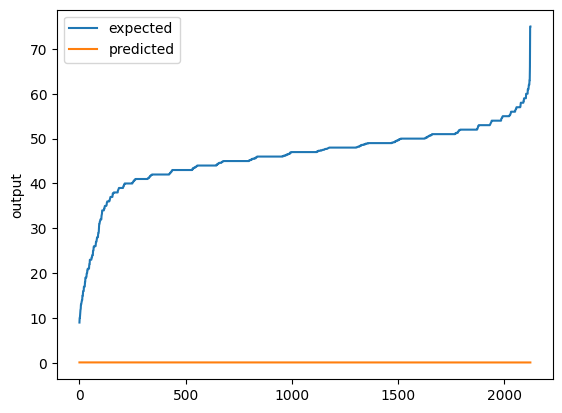

final score (MSE): 2140.99609375
final score (RMSE): 46.27090072631836
final score (MAE): 45.584564208984375
final score (R2): -32.95692443847656


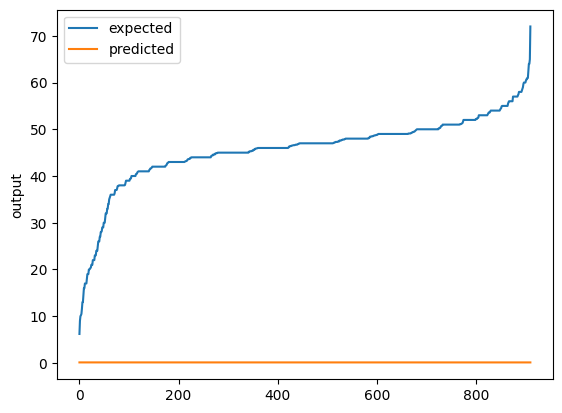

In [97]:
model_scores(model3_drop, X_train, y_train)
model_scores(model3_drop, X_test, y_test)

# DL helper method

In [ ]:
def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    elif hasattr(obj, "to"):
        return obj.to(device)
    else:
        return obj


In [ ]:
#sns.lineplot(x='epoch', y='Acc train', data=xresults_pd, label='Train')
#sns.lineplot(x='epoch', y='testloss', data=results_pd, label='Test')

In [ ]:
#results_pd.astype({'testloss': 'float64'}).dtypes

In [ ]:
#results_pd['testloss'] = results_pd['testloss'].astype(float)

In [ ]:
# build model
ANNreg = nn.Sequential(
    nn.Linear(X_train.shape[1],64),  # input layer
    nn.ReLU(),       # activation function
    nn.Linear(64,1)   # output layer
    )

ANNreg

In [ ]:
# learning rate
learningRate = .001

# loss function
lossfun = nn.MSELoss()

# optimizer (the flavor of gradient descent to implement)
optimizer = torch.optim.SGD(ANNreg.parameters(),lr=learningRate)

In [ ]:
# train the model
numepochs = 500
losses = torch.zeros(numepochs)


## Train the model!
for epochi in range(numepochs):

  # forward pass
  yHat = ANNreg(X_train)

  # compute loss
  loss = lossfun(yHat,y_train)
  losses[epochi] = loss

  # backprop
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

# Result Analysis

In [98]:
explainer = shap.DeepExplainer(model = model_linear, data = X_train)

In [99]:
shap_values = explainer.shap_values(X_train, check_additivity=False )

In [105]:
test_explainer = shap.DeepExplainer(model = model_linear, data = X_test)

In [106]:
test_shap_values = shap_values = explainer.shap_values(X_test, check_additivity=False )

variable importance plot lists the most significant variables in descending order. The top variables contribute more to the model than the bottom ones and thus have high predictive power.

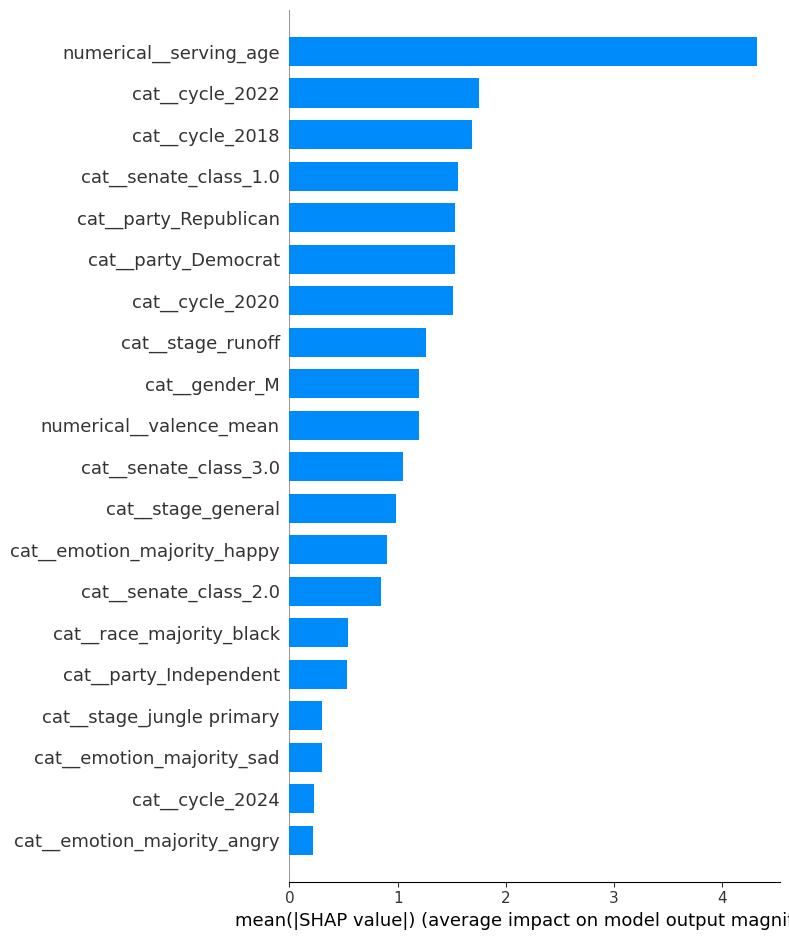

In [100]:
shap.summary_plot(shap_values, X_train, feature_names=ctprocessor.get_feature_names_out(), plot_type="bar")

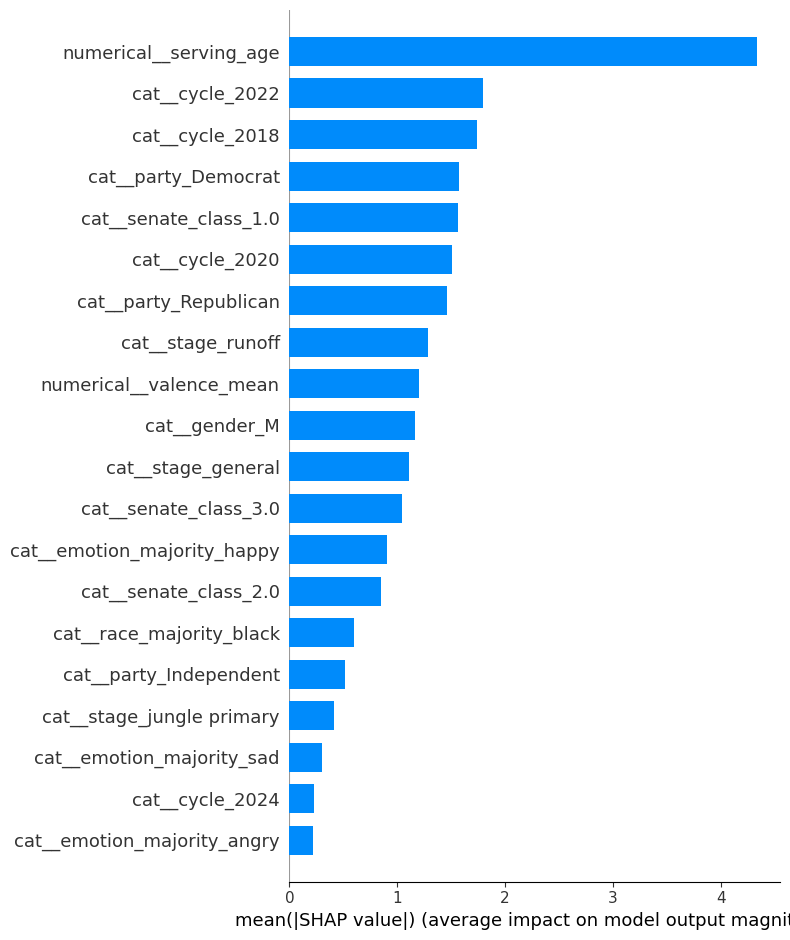

In [108]:
shap.summary_plot(test_shap_values, X_test, feature_names=ctprocessor.get_feature_names_out(), plot_type="bar")

The SHAP value plot can show the positive and negative relationships of the predictors with the target variable

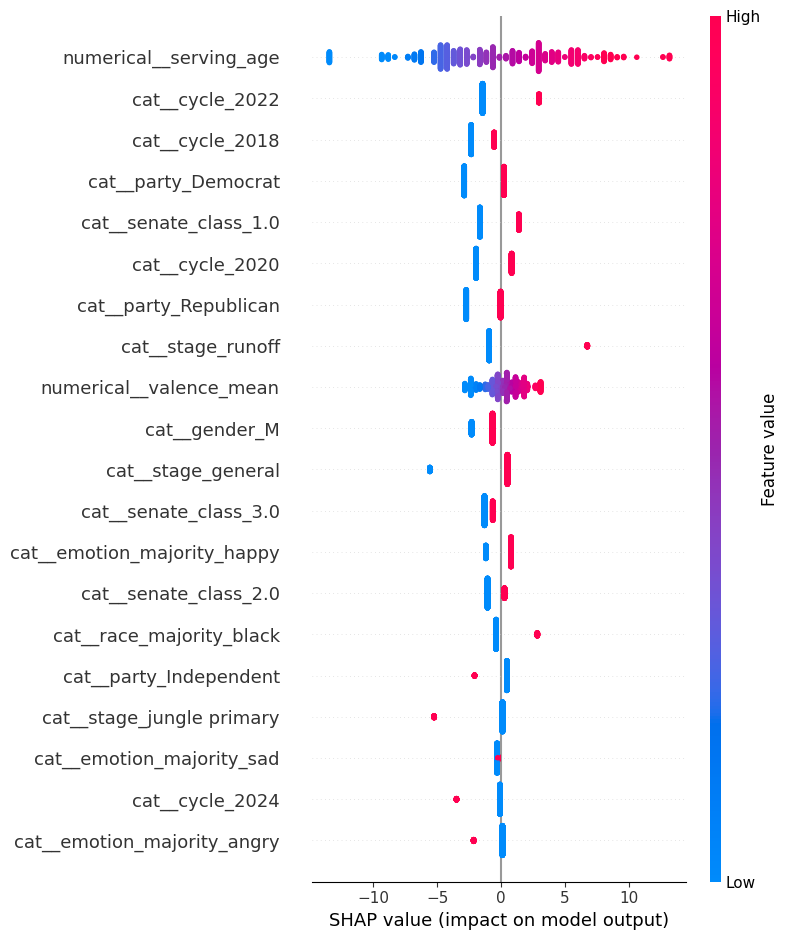

In [110]:
shap.summary_plot(test_shap_values, X_test,  ctprocessor.get_feature_names_out())

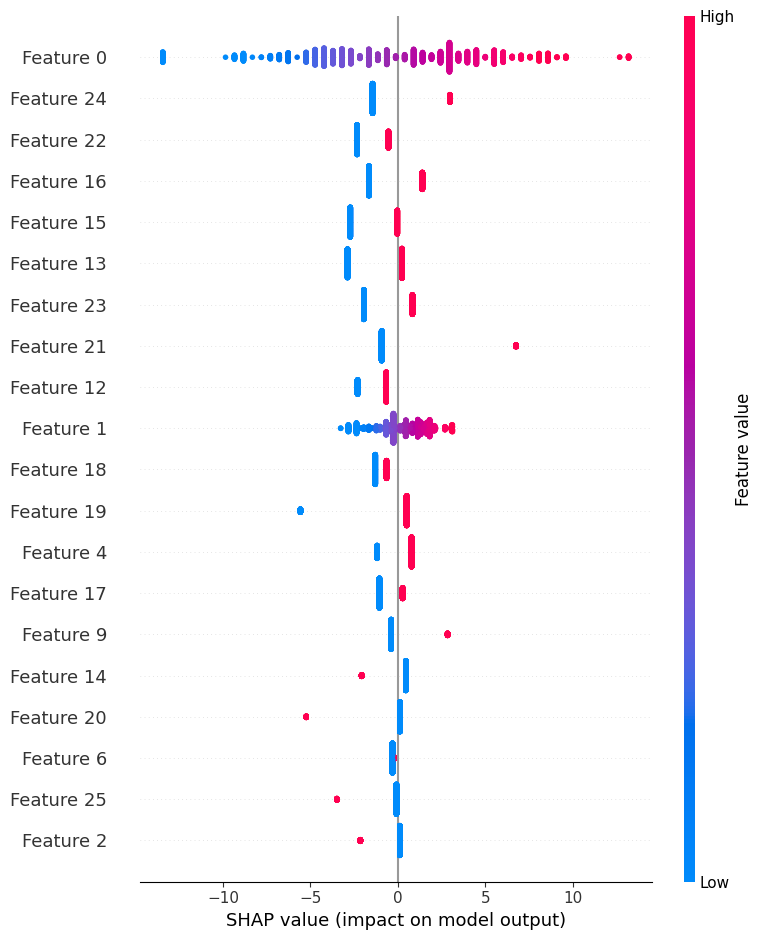

In [101]:
shap.summary_plot(shap_values, X_train)

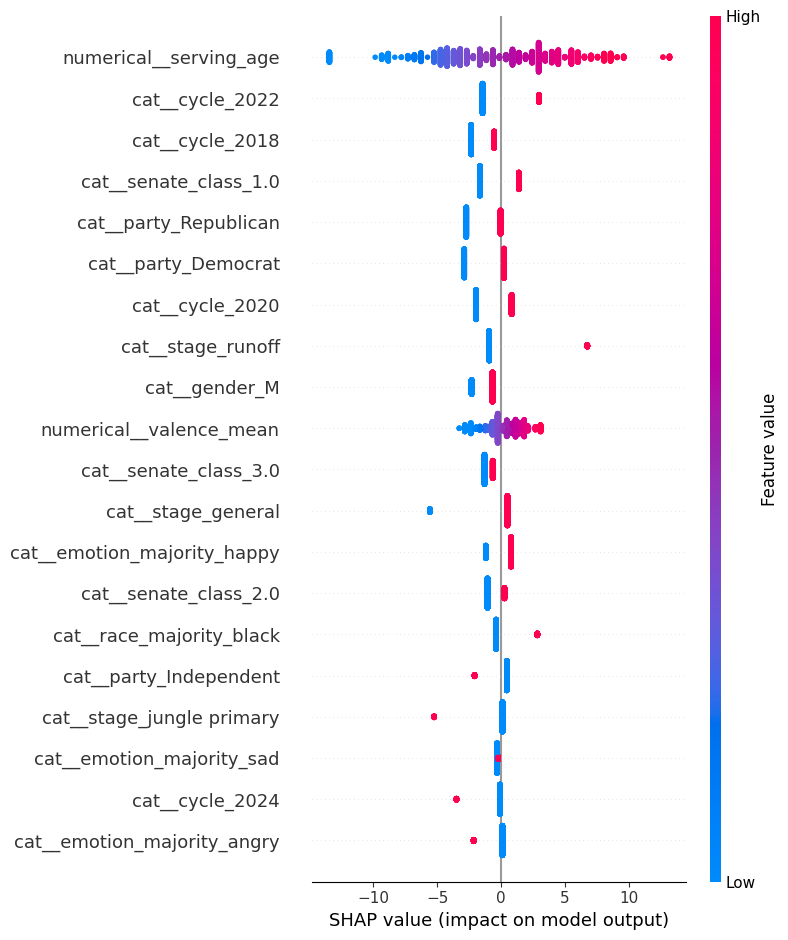

In [102]:
shap.summary_plot(shap_values, X_train, ctprocessor.get_feature_names_out())

In [103]:
shap._explaination.Explainer()

AttributeError: module 'shap' has no attribute '_explaination'

In [104]:
shap.plots.bar(explainer(X_test))

AttributeError: 'DeepExplainer' object has no attribute 'masker'

In [ ]:
shap.summary_plot(shap_values, plot_type='violin')

This plot shows us what are the main features affecting the prediction of a single observation, and the magnitude of the SHAP value for each feature.

In [ ]:
#Note the model is "multi-output" because it is rank-2 but only has one column
shap.force_plot(explainer.expected_value[0], shap_values[0],X_test[0])

In [ ]:
shap.initjs()

In [ ]:
shap.plots.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    X_train[0, :],
    feature_names= ctprocessor.get_feature_names_out())

The force plot is another way to see the effect each feature has on the prediction, for a given observation. In this plot the positive SHAP values are displayed on the left side and the negative on the right side, as if competing against each other. The highlighted value is the prediction for that observation.

In [ ]:
numFeats = X_test.shape[1]

In [ ]:
shap_values = shap_values[0].reshape(-1, numFeats) #num_of_feats
new_Xtest = X_test.reshape(-1, numFeats)

In [ ]:
labs = ctprocessor.fit_transform(X)

In [ ]:
labs.get_feature_names_out()

In [ ]:
X_train.cpu()

In [ ]:
X_test.cpu().get_feature_names_out

# Traditional modeling

## Modeling

### Helper functions

In [ ]:
## helper function for ensembling models
# evaluate a give model using cross-validation
def evaluate_model(model, X_train, y_train):
    cv = KFold(n_splits=4)
    pipeline = Pipeline(steps=[('preprocessor', ctprocessor), ('model',model)])

    avg_mse_score = -1*np.mean(cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error'))
    avg_mae_score = -1*np.mean(cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error'))
    avg_r2_score = np.mean(cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='r2'))

    return {'mse':avg_mse_score,'mae':avg_mae_score,'r2':avg_r2_score}

### Supervised Modeling - Traditional Methods

In [ ]:
ctprocessor.set_output(transform='default')

#### Linear Regression
Numeric features are standardized using StandardScaler and Categorical features One Hot Encoding

In [ ]:
lr = LinearRegression()

In [ ]:
lr_pipeline = Pipeline(steps=[('preprocessor', ctprocessor), ('model',lr)])
lr_pipeline.fit(X_train,y_train)

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [ ]:
lr_train_scores = evaluate_model(lr,X_train,y_train)
lr_train_scores

##### Testing Scores

In [ ]:
lr_scores = evaluate_model(lr,X_test,y_test)
lr_scores

#### Decision Tree

NOTE: SKLearn's Decision Tree Algorithm DOES NOT allow direct use of cateogrical features. Not clear if there is a Python package that supports this. LabelEncoding only works if there is a nominal relationship in the features.

AKA don't need encoded categorical features

In [ ]:
dtr = DecisionTreeRegressor(random_state=0)

In [ ]:
dtr_pipeline = Pipeline(steps=[('preprocessor', ctprocessor), ('model',dtr)])
dtr_pipeline.fit(X_train,y_train)

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [ ]:
dtr_train_scores = evaluate_model(dtr,X_train,y_train)
dtr_train_scores

##### Testing Scores

In [ ]:
dtr_scores = evaluate_model(dtr,X_test,y_test)
dtr_scores

Feature importance based on mean decrease in impurity

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [ ]:
feature_names = dtr_pipeline[:-1].get_feature_names_out()
forest_importances = pd.Series(dtr.feature_importances_, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Decision Tree Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Other Methods
K Nearest Neighbors Regressor

Requires Encoding

In [ ]:
knr = KNeighborsRegressor(n_neighbors=2)

In [ ]:
knr_pipeline = Pipeline(steps=[('preprocessor', ctprocessor), ('model',knr)])
knr_pipeline.fit(X_train,y_train)

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [ ]:
knr_train_scores = evaluate_model(knr,X_train,y_train)
knr_train_scores

##### Testing Scores

In [ ]:
knr_scores = evaluate_model(knr,X_test,y_test)
knr_scores

### Supervised Methods - Ensemble Learning

#### Random Forest

In [ ]:
rf = RandomForestRegressor(random_state=42)

In [ ]:
rf_pipeline = Pipeline(steps=[('preprocessor', ctprocessor), ('model', rf)])
rf_pipeline.fit(X_train,y_train)

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [ ]:
rf_train_scores = evaluate_model(rf,X_train,y_train)
rf_train_scores

##### Testing Scores

In [ ]:
rf_scores = evaluate_model(rf,X_test,y_test)
rf_scores

Feature importance based on mean decrease in impurity

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [ ]:
feature_names = rf_pipeline[:-1].get_feature_names_out()
forest_importances = pd.Series(rf.feature_importances_, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Random Forest Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### CatBoost
No Feature Processing Needed

https://catboost.ai/en/docs/features/categorical-features

In [ ]:
! pip install catboost

In [ ]:
from catboost import CatBoostRegressor, Pool

In [ ]:
# https://towardsdatascience.com/how-do-you-use-categorical-features-directly-with-catboost-947b211c2923
cbr = CatBoostRegressor(n_estimators=200,loss_function='RMSE',learning_rate=0.4,depth=3, task_type='CPU',random_state=1,verbose=False)

In [ ]:
pool_train = Pool(X_train, y_train, cat_features = categorical_features)
pool_test = Pool(X_test, cat_features = categorical_features)

In [ ]:
cbr.fit(pool_train)

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [ ]:
train_predictions = cbr.predict(pool_train)

In [ ]:
cbr_train_mse = mean_squared_error(y_train, train_predictions)
cbr_train_mae = mean_absolute_error(y_train, train_predictions)
cbr_train_r2 = r2_score(y_train, train_predictions)

In [ ]:
cbr_train_scores = {'mse':cbr_train_mse,'mae':cbr_train_mae,'r2':cbr_train_r2}
cbr_train_scores

##### Testing Scores

In [ ]:
test_predictions = cbr.predict(pool_test)

In [ ]:
cbr_mse = mean_squared_error(y_test, test_predictions)
cbr_mae = mean_absolute_error(y_test, test_predictions)
cbr_r2 = r2_score(y_test, test_predictions)

In [ ]:
cbr_scores = {'mse':cbr_mse,'mae':cbr_mae,'r2':cbr_r2}
cbr_scores

In [ ]:
cbr.get_feature_importance(prettified=True).plot.bar(x='Feature Id', y='Importances')
plt.xticks(rotation=90)
plt.title("CatBoost Feature Importances")
fig.tight_layout()

#### CatBoost WITH OneHotEncoding and StdScaler Transformed Data

https://catboost.ai/en/docs/features/categorical-features

In [ ]:
ctprocessor.fit(X_train)

In [ ]:
X_train_t = ctprocessor.transform(X_train)
X_test_t = ctprocessor.transform(X_test)

In [ ]:
features = ctprocessor.get_feature_names_out()
X_train_t = pd.DataFrame(X_train_t, columns=features)
X_test_t = pd.DataFrame(X_test_t, columns=features)

In [ ]:
# https://towardsdatascience.com/how-do-you-use-categorical-features-directly-with-catboost-947b211c2923
cbr_t = CatBoostRegressor(n_estimators=200,loss_function='RMSE',learning_rate=0.4,depth=3, task_type='CPU',random_state=1,verbose=False)

In [ ]:
pool_train_t = Pool(X_train_t, y_train)
pool_test_t = Pool(X_test_t)

In [ ]:
cbr_t.fit(pool_train_t)

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [ ]:
train_predictions_t = cbr_t.predict(pool_train_t)

In [ ]:
cbr_train_mse_t = mean_squared_error(y_train, train_predictions_t)
cbr_train_mae_t = mean_absolute_error(y_train, train_predictions_t)
cbr_train_r2_t = r2_score(y_train, train_predictions_t)

In [ ]:
cbr_train_scores_t = {'mse':cbr_train_mse_t,'mae':cbr_train_mae_t,'r2':cbr_train_r2_t}
cbr_train_scores_t

##### Testing Scores

In [ ]:
test_predictions_t = cbr_t.predict(pool_test_t)

In [ ]:
cbr_mse_t = mean_squared_error(y_test, test_predictions_t)
cbr_mae_t = mean_absolute_error(y_test, test_predictions_t)
cbr_r2_t = r2_score(y_test, test_predictions_t)

In [ ]:
cbr_scores_t = {'mse':cbr_mse_t,'mae':cbr_mae_t,'r2':cbr_r2_t}
cbr_scores_t

In [ ]:
cbr_t.get_feature_importance(prettified=True).plot.bar(x='Feature Id', y='Importances')
plt.xticks(rotation=90)
plt.title("CatBoost Feature Importances with Transformed Data")
fig.tight_layout()

In [ ]:
# TODO: Properly Extract Feature Names

#### CatBoost Witholding Emotion Features
No Feature Processing Needed

https://catboost.ai/en/docs/features/categorical-features

In [ ]:
# https://towardsdatascience.com/how-do-you-use-categorical-features-directly-with-catboost-947b211c2923
cbr_ne = CatBoostRegressor(n_estimators=200,loss_function='RMSE',learning_rate=0.4,depth=3, task_type='CPU',random_state=1,verbose=False)

In [ ]:
categorical_features_ne = ['gender', 'party', 'senate_class', 'stage', 'cycle', 'race_majority']

In [ ]:
pool_train_ne = Pool(X_train.drop(columns=['emotion_majority','valence_mean']), y_train, cat_features = categorical_features_ne)
pool_test_ne = Pool(X_test.drop(columns=['emotion_majority','valence_mean']), cat_features = categorical_features_ne)

In [ ]:
cbr_ne.fit(pool_train_ne)

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [ ]:
train_predictions_ne = cbr_ne.predict(pool_train_ne)

In [ ]:
cbr_train_mse_ne = mean_squared_error(y_train, train_predictions_ne)
cbr_train_mae_ne = mean_absolute_error(y_train, train_predictions_ne)
cbr_train_r2_ne = r2_score(y_train, train_predictions_ne)

In [ ]:
cbr_train_scores_ne = {'mse':cbr_train_mse_ne,'mae':cbr_train_mae_ne,'r2':cbr_train_r2_ne}
cbr_train_scores_ne

##### Testing Scores

In [ ]:
test_predictions_ne = cbr_ne.predict(pool_test_ne)

In [ ]:
cbr_mse_ne = mean_squared_error(y_test, test_predictions_ne)
cbr_mae_ne = mean_absolute_error(y_test, test_predictions_ne)
cbr_r2_ne = r2_score(y_test, test_predictions_ne)

In [ ]:
cbr_scores_ne = {'mse':cbr_mse_ne,'mae':cbr_mae_ne,'r2':cbr_r2_ne}
cbr_scores_ne

In [ ]:
cbr_ne.get_feature_importance(prettified=True).plot.bar(x='Feature Id', y='Importances')
plt.xticks(rotation=90)
plt.title("CatBoost Feature Importances (Without Emotion)")
fig.tight_layout()

## Modeling Evaulation

In [ ]:
# TODO: Jungle Primary feature importance potentially very interesting - https://politicaldictionary.com/words/jungle-primary/

## Unsupervised Modeling - TODO Week 10!

### KMeans and Hierarchical Clustering

In [ ]:
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)
kmeans.labels_
kmeans.predict([[0, 0], [12, 3]])
kmeans.cluster_centers_

In [ ]:
X = np.array([[1, 2], [1, 4], [1, 0], [4, 2], [4, 4], [4, 0]])
clustering = AgglomerativeClustering().fit(X)
clustering.labels_